In [119]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [63]:
# https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155

In [64]:
DATA_DIR = '/Users/qs.chou/Mask_RCNN/kaggle/'

# Directory to save logs and trained model
ROOT_DIR = '/Users/qs.chou/Mask_RCNN/kaggle/working'

In [167]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [66]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
#train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')
print(train_dicom_dir)
print(test_dicom_dir)

/Users/qs.chou/Mask_RCNN/kaggle/stage_2_train_images
/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images


In [67]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "/Users/qs.chou/Mask_RCNN/mask_rcnn_coco.h5"

In [68]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [210]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    #IMAGE_MIN_DIM = 256
    #IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    RPN_ANCHOR_RATIOS = [0.8, 1, 1.2]
    RPN_ANCHOR_STRIDE = 2
    IMAGE_MIN_DIM = 256
    IMAGE_MIN_SCALE = 0
    IMAGE_MAX_DIM = 2048

config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  2048
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANC

In [211]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [212]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [213]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [214]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [215]:
# show dicom fields 
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.30997.1517874505.465062
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.30997.1517874505.465062
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [216]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [217]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


In [218]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [219]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    6b110a37-e31c-437d-8886-c2e7cd5b2cb2
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 9912, dtype: object]

In [220]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/Users/qs.chou/Mask_RCNN/kaggle/stage_2_train_images/c2657014-120e-456e-97e5-1adcdb908b73.dcm
[1 1]


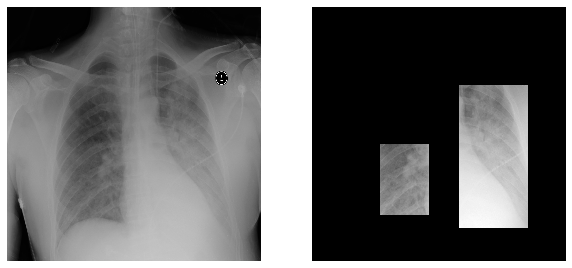

In [221]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

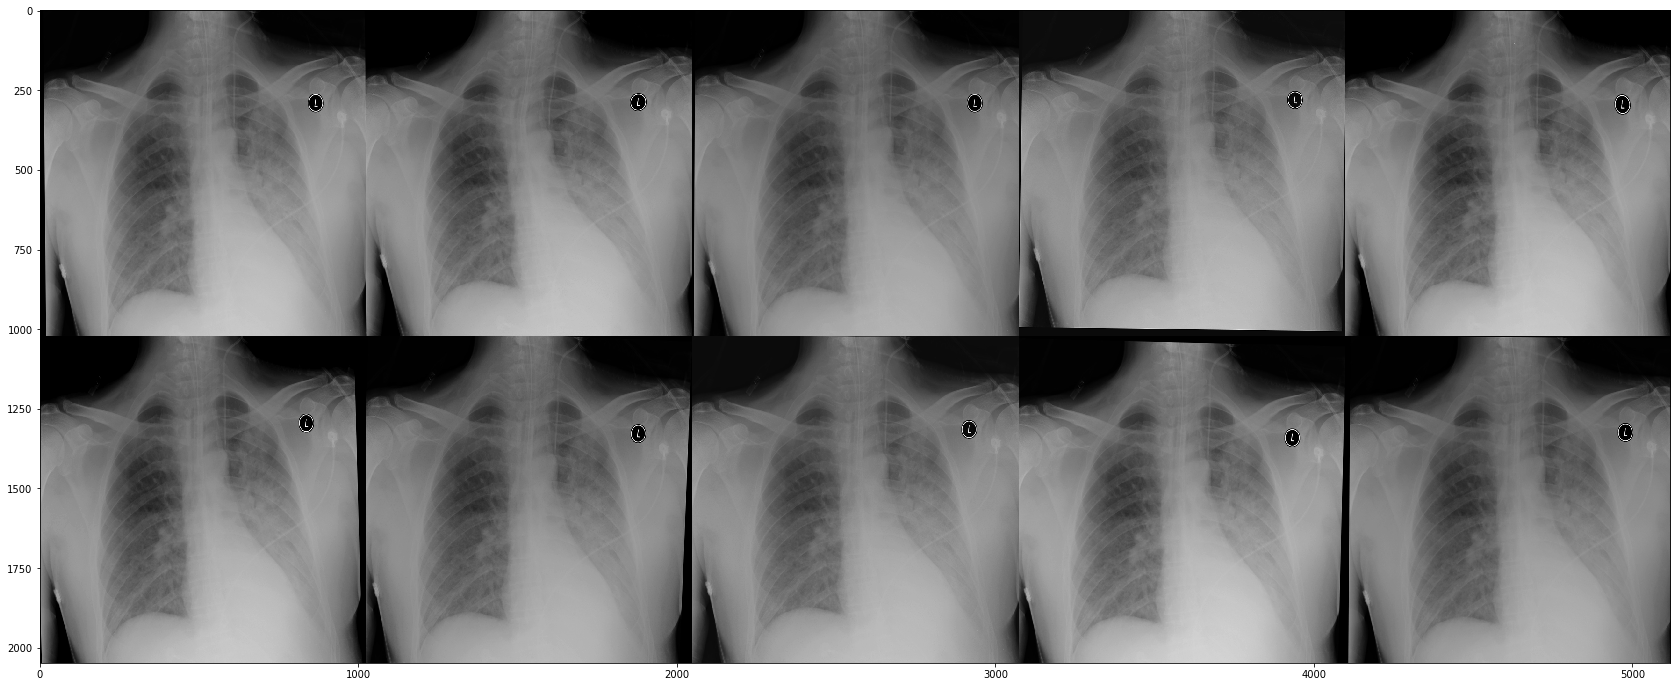

In [222]:
#Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [223]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [224]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [225]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=1,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /Users/qs.chou/Mask_RCNN/kaggle/working/pneumonia20200703T1603/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

InvalidArgumentError:  indices[255] = [0, 261623] does not index into param shape [1,65472,2]
	 [[node rpn_class_loss_3/GatherNd (defined at /Users/qs.chou/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_396243]

Function call stack:
keras_scratch_graph


In [231]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_ANCHOR_RATIOS = [0.8, 1, 1.2]
    RPN_ANCHOR_STRIDE = 2
    IMAGE_MIN_DIM = 256
    IMAGE_MIN_SCALE = 0
    IMAGE_MAX_DIM = 2048
    
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
#assert model_path != "", "Provide path to trained weights"
#print("Loading weights from ", model_path)
model.load_weights("/Users/qs.chou/Mask_RCNN/kaggle/working/mask_rcnn_pneumonia_0016.h5", by_name=True)

In [226]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    print(resize_factor)
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            print(image.shape)
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            
            print("config.IMAGE_MIN_DIM",config.IMAGE_MIN_DIM)
            print("config.IMAGE_MIN_SCALE",config.IMAGE_MIN_SCALE)
            print("config.IMAGE_MIN_SCALE",config.IMAGE_MIN_SCALE)
            print("config.IMAGE_RESIZE_MODE",config.IMAGE_RESIZE_MODE)
            print("os.path.splitext(os.path.basename(image_id))[0]",os.path.splitext(os.path.basename(image_id))[0])
            
            
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MIN_SCALE,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]
            print(r)
            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [227]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(1024, 1024, 3) [3903 1024 1024    3 1024 1024    3    0    0 1024 1024    1    1    1] [] [] []
(array([[[[-122.7, -115.8, -102.9],
         [-121.7, -114.8, -101.9],
         [-120.7, -113.8, -100.9],
         ...,
         [-120.7, -113.8, -100.9],
         [-121.7, -114.8, -101.9],
         [-121.7, -114.8, -101.9]],

        [[-121.7, -114.8, -101.9],
         [-120.7, -113.8, -100.9],
         [-119.7, -112.8,  -99.9],
         ...,
         [-118.7, -111.8,  -98.9],
         [-119.7, -112.8,  -99.9],
         [-120.7, -113.8, -100.9]],

        [[-120.7, -113.8, -100.9],
         [-119.7, -112.8,  -99.9],
         [-118.7, -111.8,  -98.9],
         ...,
         [-118.7, -111.8,  -98.9],
         [-119.7, -112.8,  -99.9],
         [-119.7, -112.8,  -99.9]],

        ...,

        [[-116.7, -109.8,  -96.9],
         [-114.7, -107.8,  -94.9],
         [-112.7, -105.8,  -92.9],
         ...,
         [ -40.7,  -33.8,  -20.9],
         [ -38.7,  -31.8,  -18.9],
         [ -77.7,  -7

<Figure size 720x2160 with 0 Axes>

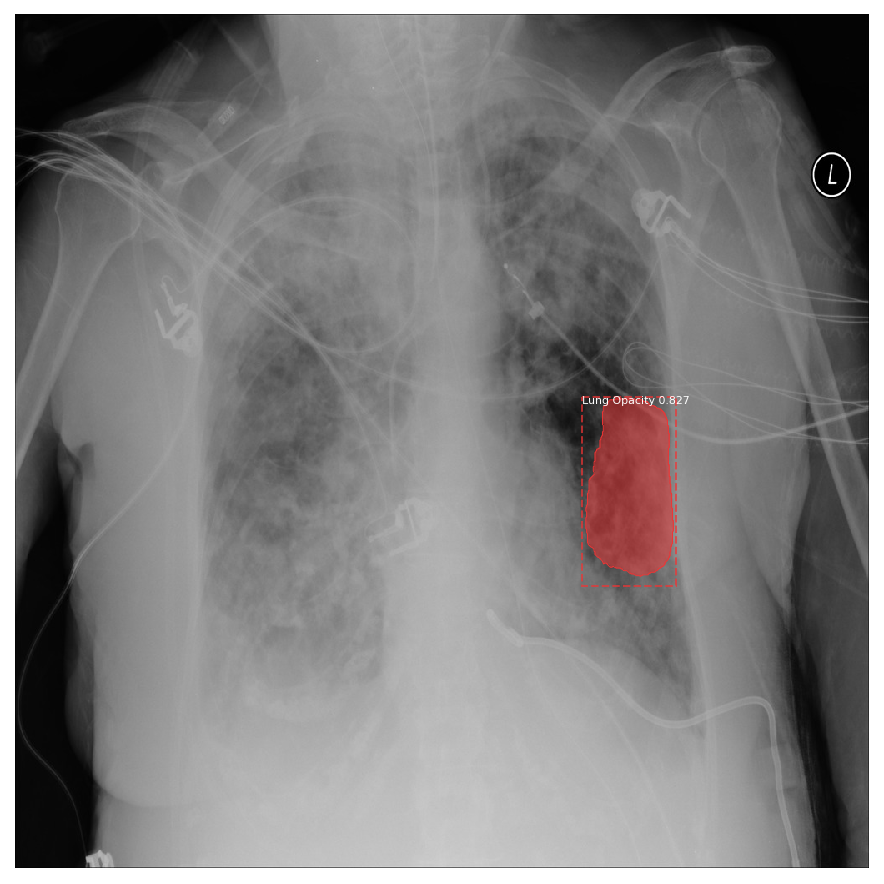

In [238]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_train
fig = plt.figure(figsize=(10, 30))
image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config, 
                               image_id, use_mini_mask=False)
print(original_image.shape,image_meta, gt_class_id, gt_bbox, gt_mask)
#print(get_colors_for_class_ids(gt_class_id),gt_class_id,fig.axes[-1])
#visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                dataset.class_names,
#                               colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
moldInput = model.mold_inputs([original_image])
print(moldInput)
results = model.detect([original_image] , verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], colors=get_colors_for_class_ids(r['class_ids']))

i 0
(1024, 1024, 3) [17974  1024  1024     3  1024  1024     3     0     0  1024  1024     1
     1     1] [1 1] [[177 605 653 828]
 [173 252 571 451]] [[[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 ...

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]]
(1024, 1024, 3) [17974  1024  1024     3  1024  1024     3     0     0  1024  1024     1
     1     1] [1 1] [[177 605 653 828]
 [173 252 571 451]] [[[False False]
  [False False]
  [False False]
  ...
  [False False]


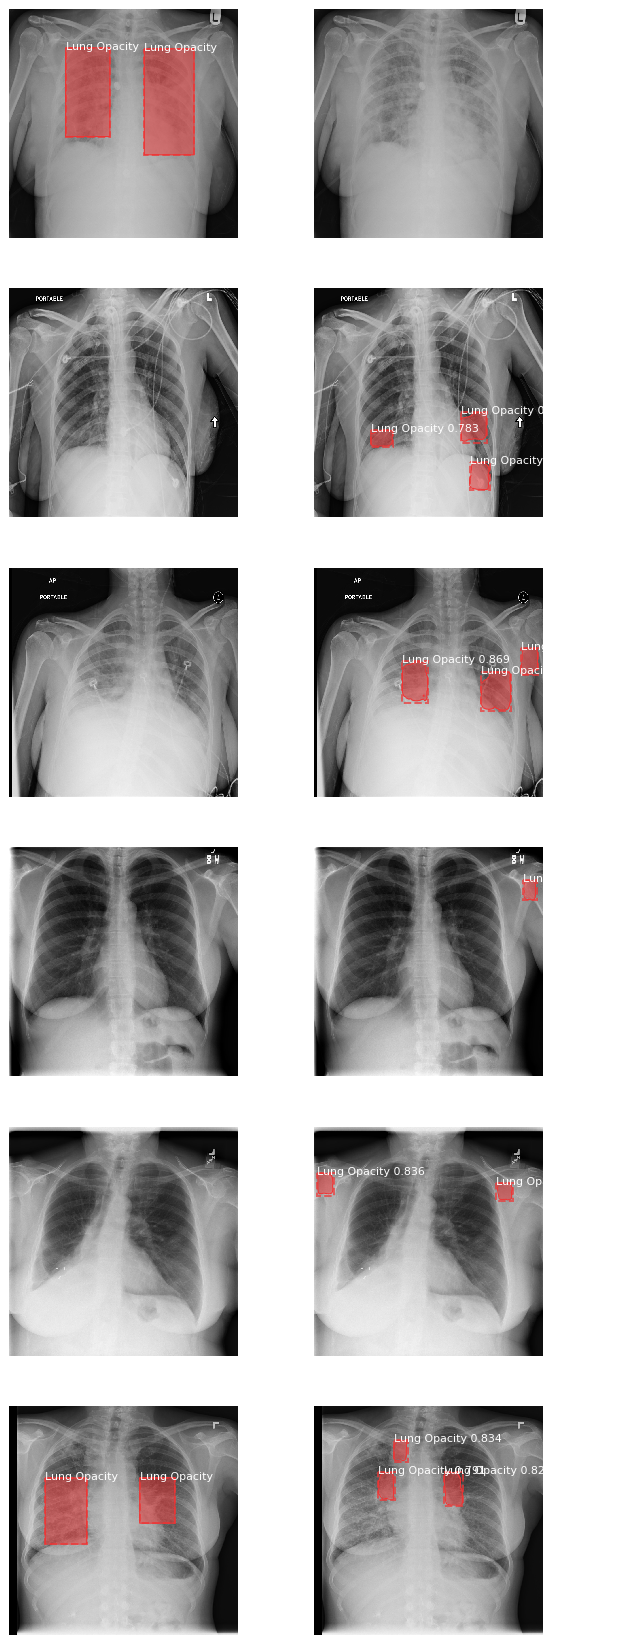

In [234]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_train
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config, 
                               image_id, use_mini_mask=False)
    print("i",i)
    print(original_image.shape,image_meta, gt_class_id, gt_bbox, gt_mask)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    print(original_image.shape,image_meta, gt_class_id, gt_bbox, gt_mask)
    results = model.detect([original_image] , verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [236]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)
print(test_image_fps)

['/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/1f75252b-2fff-4b7d-82cb-31189112f05b.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/310ec695-c874-453f-85b2-d02162fee735.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/21cc46d4-b5a8-4296-93ba-0f16bf88b30b.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/294b4109-6ea5-4136-9a67-67b6a929d285.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/1a6d0d55-8031-4e17-8c1c-d2023eb0a99e.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/11b77b1f-1da1-4803-b21e-b784500b5155.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/c10b53cf-2750-41c1-9ba6-b73598b2bc22.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/2977d766-7faa-42d5-943d-ec65ef284430.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/2348cc76-684f-406e-9e98-c14ce61c3143.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_2_test_images/0564ed66-bcd9-4f0d-a66b-846c1facd59f.dcm', '/Users/qs.chou/Mask_RCNN/kaggle/stage_

In [237]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

  0%|          | 0/3000 [00:00<?, ?it/s]

0.5
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f75252b-2fff-4b7d-82cb-31189112f05b


  0%|          | 1/3000 [00:01<1:32:03,  1.84s/it]

{'rois': array([[319, 326, 376, 406]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8540154], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  0%|          | 2/3000 [00:03<1:35:30,  1.91s/it]

{'rois': array([[169,  10, 258,  71],
       [160, 918, 262, 989]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9102233, 0.8769305], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  0%|          | 3/3000 [00:05<1:37:20,  1.95s/it]

{'rois': array([[659, 729, 778, 820]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84260076], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  0%|          | 4/3000 [00:07<1:36:18,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a6d0d55-8031-4e17-8c1c-d2023eb0a99e


  0%|          | 5/3000 [00:09<1:35:49,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11b77b1f-1da1-4803-b21e-b784500b5155


  0%|          | 6/3000 [00:11<1:38:24,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c10b53cf-2750-41c1-9ba6-b73598b2bc22


  0%|          | 7/3000 [00:13<1:41:20,  2.03s/it]

{'rois': array([[183, 149, 272, 246],
       [434, 676, 584, 785],
       [394, 314, 592, 450]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86768305, 0.7970247 , 0.79368603], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  0%|          | 8/3000 [00:16<1:43:07,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2348cc76-684f-406e-9e98-c14ce61c3143


  0%|          | 9/3000 [00:18<1:42:24,  2.05s/it]

{'rois': array([[  74,  443,  188,  522],
       [ 279,  937,  405, 1018]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8216517, 0.7955296], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

  0%|          | 10/3000 [00:20<1:41:49,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19d2d151-2a5f-4e1b-9666-56a4e51ce95a


  0%|          | 11/3000 [00:22<1:42:32,  2.06s/it]

{'rois': array([[642, 744, 708, 818],
       [212, 756, 358, 844]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8637316 , 0.84358877], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  0%|          | 12/3000 [00:24<1:45:00,  2.11s/it]

{'rois': array([[  35,  434,  139,  513],
       [ 196,  843,  337,  923],
       [ 191,  937,  285, 1006]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88518167, 0.85474575, 0.80709326], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

  0%|          | 13/3000 [00:26<1:46:52,  2.15s/it]

{'rois': array([[329, 357, 423, 426]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81696653], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  0%|          | 14/3000 [00:28<1:48:12,  2.17s/it]

{'rois': array([[179, 485, 269, 573],
       [826, 396, 929, 473]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85487515, 0.8370837 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  0%|          | 15/3000 [00:31<1:47:08,  2.15s/it]

{'rois': array([[611, 238, 691, 314],
       [671, 821, 765, 911],
       [486, 661, 587, 735]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84017146, 0.8383798 , 0.788277  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  1%|          | 16/3000 [00:33<1:46:42,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04df7618-aaf9-4979-94d4-2964151de11f


  1%|          | 17/3000 [00:35<1:44:46,  2.11s/it]

{'rois': array([[448, 388, 547, 449],
       [652, 729, 725, 808]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79190165, 0.78810865], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  1%|          | 18/3000 [00:37<1:45:39,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a0d2fa7-140c-49bb-ae85-4d6e597933e1


  1%|          | 19/3000 [00:39<1:45:17,  2.12s/it]

{'rois': array([[322, 791, 423, 864]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8702874], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  1%|          | 20/3000 [00:41<1:46:28,  2.14s/it]

{'rois': array([[273, 426, 387, 514],
       [353, 762, 438, 857],
       [167, 562, 284, 625]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87608796, 0.8479584 , 0.8429903 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  1%|          | 21/3000 [00:43<1:45:02,  2.12s/it]

{'rois': array([[390, 344, 470, 425]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84655935], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  1%|          | 22/3000 [00:45<1:45:21,  2.12s/it]

{'rois': array([[721, 288, 818, 388]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8353081], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  1%|          | 23/3000 [00:48<1:47:03,  2.16s/it]

{'rois': array([[175,  13, 327,  94],
       [327,  16, 449,  96],
       [536, 601, 644, 686]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8821676 , 0.85016805, 0.79954207], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  1%|          | 24/3000 [00:50<1:46:11,  2.14s/it]

{'rois': array([[622,  61, 731, 127],
       [435, 513, 511, 581]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8166984, 0.8053971], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  1%|          | 25/3000 [00:52<1:45:07,  2.12s/it]

{'rois': array([[824, 623, 912, 696]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8752434], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  1%|          | 26/3000 [00:54<1:47:22,  2.17s/it]

{'rois': array([[368, 345, 450, 408],
       [164,  59, 270, 136]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.848162 , 0.8153661], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  1%|          | 27/3000 [00:56<1:48:17,  2.19s/it]

{'rois': array([[200,  84, 287, 164],
       [501, 268, 676, 395],
       [430, 711, 613, 834]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8889887, 0.8332431, 0.8289883], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

  1%|          | 28/3000 [00:58<1:46:31,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04eaa6de-99d9-4a90-bd0f-3fb9f486171b


  1%|          | 29/3000 [01:01<1:47:39,  2.17s/it]

{'rois': array([[627, 293, 767, 393]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81728846], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  1%|          | 30/3000 [01:03<1:47:28,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ce40417-1531-4101-be24-e85416c812cc


  1%|          | 31/3000 [01:05<1:47:14,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28805c82-2a63-4790-9db3-b36f6576b8e4


  1%|          | 32/3000 [01:07<1:46:45,  2.16s/it]

{'rois': array([[ 176,  835,  303,  919],
       [ 166,  929,  287, 1013]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82398254, 0.8089671 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  1%|          | 33/3000 [01:09<1:46:12,  2.15s/it]

{'rois': array([[750, 266, 858, 344]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8195903], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  1%|          | 34/3000 [01:11<1:44:21,  2.11s/it]

{'rois': array([[206, 808, 305, 869]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8435268], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  1%|          | 35/3000 [01:13<1:43:44,  2.10s/it]

{'rois': array([[445, 336, 609, 448]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8737339], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  1%|          | 36/3000 [01:15<1:44:05,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27eb5f4c-1fe5-4580-baa1-1193824d5233


  1%|          | 37/3000 [01:17<1:43:35,  2.10s/it]

{'rois': array([[194, 400, 282, 470],
       [404, 354, 482, 420]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8929461 , 0.86373365], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  1%|▏         | 38/3000 [01:20<1:42:31,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02d6943e-66b0-4d0f-80ef-a468e937b663


  1%|▏         | 39/3000 [01:22<1:41:29,  2.06s/it]

{'rois': array([[473, 387, 544, 459]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8346843], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  1%|▏         | 40/3000 [01:24<1:40:51,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20f0b519-4336-4f74-b03d-ddc95d454bdb


  1%|▏         | 41/3000 [01:26<1:40:38,  2.04s/it]

{'rois': array([[564, 311, 659, 374]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81572884], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  1%|▏         | 42/3000 [01:28<1:40:14,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12564587-f259-4659-8aac-2c5cd7e48a89


  1%|▏         | 43/3000 [01:30<1:39:24,  2.02s/it]

{'rois': array([[213,  57, 351, 156]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86267024], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  1%|▏         | 44/3000 [01:32<1:41:11,  2.05s/it]

{'rois': array([[ 67,  76, 165, 161],
       [ 33, 813, 160, 910],
       [504, 331, 616, 416]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.937904  , 0.8607825 , 0.85462415], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  2%|▏         | 45/3000 [01:34<1:43:38,  2.10s/it]

{'rois': array([[866, 283, 946, 356]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8156655], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  2%|▏         | 46/3000 [01:36<1:44:07,  2.11s/it]

{'rois': array([[238, 462, 328, 520]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7879006], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  2%|▏         | 47/3000 [01:38<1:45:22,  2.14s/it]

{'rois': array([[245, 566, 358, 631]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7970542], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  2%|▏         | 48/3000 [01:40<1:46:09,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a322909-9ee1-4f88-a601-7160852d38c5


  2%|▏         | 49/3000 [01:43<1:47:51,  2.19s/it]

{'rois': array([[ 73, 410, 168, 494]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8480605], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  2%|▏         | 50/3000 [01:45<1:47:57,  2.20s/it]

{'rois': array([[496, 651, 580, 714]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8565495], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  2%|▏         | 51/3000 [01:47<1:48:37,  2.21s/it]

{'rois': array([[452, 265, 554, 373],
       [181, 101, 297, 188],
       [501, 650, 635, 724]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9076839 , 0.81538486, 0.8018856 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  2%|▏         | 52/3000 [01:49<1:48:30,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b83d54b-af50-4c15-9d53-d3b1c5381678


  2%|▏         | 53/3000 [01:52<1:48:24,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11c2071c-dab3-49b5-b120-41926283e5f6


  2%|▏         | 54/3000 [01:54<1:49:28,  2.23s/it]

{'rois': array([[ 251,  949,  367, 1020]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8300747], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

  2%|▏         | 55/3000 [01:56<1:47:15,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c008eff7-942c-4675-937b-d18905e8c770


  2%|▏         | 56/3000 [01:58<1:45:26,  2.15s/it]

{'rois': array([[425, 574, 528, 652],
       [498, 662, 584, 735],
       [594, 225, 760, 372]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92678857, 0.82326186, 0.79776746], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  2%|▏         | 57/3000 [02:00<1:46:07,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0eb58a9b-834f-4962-abfa-5c13b8a4b3cc


  2%|▏         | 58/3000 [02:02<1:45:54,  2.16s/it]

{'rois': array([[275, 857, 443, 945],
       [ 99, 371, 196, 442]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.846897 , 0.7843284], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  2%|▏         | 59/3000 [02:04<1:44:12,  2.13s/it]

{'rois': array([[170,  67, 257, 151],
       [525, 328, 619, 405]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87091154, 0.85354817], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  2%|▏         | 60/3000 [02:06<1:41:46,  2.08s/it]

{'rois': array([[ 237,  955,  330, 1016],
       [  47,  520,  124,  607]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8754787, 0.8007385], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

  2%|▏         | 61/3000 [02:08<1:40:11,  2.05s/it]

{'rois': array([[197,  88, 368, 168],
       [414, 388, 491, 452]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79365665, 0.78275293], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  2%|▏         | 62/3000 [02:10<1:39:04,  2.02s/it]

{'rois': array([[234,  46, 351, 121],
       [809, 661, 899, 761],
       [361,  26, 496, 111]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93772644, 0.8569326 , 0.82815206], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  2%|▏         | 63/3000 [02:12<1:39:13,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 260b87ff-df13-4177-90bb-53fb0618b1db


  2%|▏         | 64/3000 [02:14<1:37:47,  2.00s/it]

{'rois': array([[190,  81, 293, 159]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8734305], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  2%|▏         | 65/3000 [02:16<1:39:25,  2.03s/it]

{'rois': array([[669, 689, 759, 768],
       [817, 794, 904, 867]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8367509, 0.8178075], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  2%|▏         | 66/3000 [02:19<1:41:31,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 3038ffea-6002-410e-86ec-f59a5a306526


  2%|▏         | 67/3000 [02:21<1:41:35,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 031cc0e4-9e42-4bfe-9d0c-fb3170cfdc2f


  2%|▏         | 68/3000 [02:23<1:40:31,  2.06s/it]

{'rois': array([[265,  83, 371, 162],
       [280, 821, 376, 884]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83079636, 0.8164663 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  2%|▏         | 69/3000 [02:25<1:40:31,  2.06s/it]

{'rois': array([[531, 695, 632, 790],
       [ 40, 394, 174, 454],
       [559, 227, 668, 341]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9232793, 0.8718533, 0.8213333], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

  2%|▏         | 70/3000 [02:27<1:39:08,  2.03s/it]

{'rois': array([[184,  13, 283,  72],
       [212, 858, 321, 935]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84705096, 0.7836563 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  2%|▏         | 71/3000 [02:29<1:38:17,  2.01s/it]

{'rois': array([[595, 211, 701, 315],
       [192, 368, 275, 442],
       [739, 122, 824, 184]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87658656, 0.87154114, 0.8098386 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  2%|▏         | 72/3000 [02:31<1:39:39,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19a439ff-6521-4bea-9179-dccef727f918


  2%|▏         | 73/3000 [02:33<1:39:45,  2.05s/it]

{'rois': array([[260,  57, 463, 138],
       [635, 407, 750, 480]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83092993, 0.8254676 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  2%|▏         | 74/3000 [02:35<1:40:00,  2.05s/it]

{'rois': array([[526, 715, 627, 805],
       [379, 257, 470, 338],
       [348, 370, 464, 461]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88529116, 0.8662371 , 0.86372805], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  2%|▎         | 75/3000 [02:37<1:40:28,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ec0543e-a664-4fdb-8cc9-c96d20e975be


  3%|▎         | 76/3000 [02:39<1:42:43,  2.11s/it]

{'rois': array([[618, 674, 713, 745]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89060473], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  3%|▎         | 77/3000 [02:41<1:44:16,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1342a8a2-ca78-4f73-93f1-01c07b298c8c


  3%|▎         | 78/3000 [02:44<1:48:07,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 206f38dc-9b8a-4559-aaf7-b612fbd06ede


  3%|▎         | 79/3000 [02:46<1:46:38,  2.19s/it]

{'rois': array([[ 479,  260,  555,  340],
       [ 208,  920,  383, 1014]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83600885, 0.8047528 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  3%|▎         | 80/3000 [02:48<1:44:52,  2.16s/it]

{'rois': array([[135,  13, 270,  91],
       [457, 168, 581, 271]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8372204 , 0.83664477], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  3%|▎         | 81/3000 [02:50<1:40:45,  2.07s/it]

{'rois': array([[110,  42, 294, 179],
       [213, 386, 308, 455]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7839654, 0.7818331], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  3%|▎         | 82/3000 [02:52<1:38:59,  2.04s/it]

{'rois': array([[473, 594, 608, 692]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81838256], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  3%|▎         | 83/3000 [02:54<1:37:43,  2.01s/it]

{'rois': array([[184, 868, 297, 934],
       [350, 389, 440, 446]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8211104, 0.8207831], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  3%|▎         | 84/3000 [02:56<1:36:50,  1.99s/it]

{'rois': array([[258, 869, 387, 955],
       [559, 421, 653, 486]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83259916, 0.78452367], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  3%|▎         | 85/3000 [02:58<1:36:11,  1.98s/it]

{'rois': array([[372, 625, 479, 701]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89961034], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  3%|▎         | 86/3000 [03:00<1:38:20,  2.02s/it]

{'rois': array([[205,  87, 298, 166],
       [842, 723, 957, 824]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9013554 , 0.86916167], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  3%|▎         | 87/3000 [03:02<1:38:33,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e0ee049-6ece-48ef-9399-689fa7ab780e


  3%|▎         | 88/3000 [03:04<1:38:24,  2.03s/it]

{'rois': array([[342, 267, 480, 374],
       [206, 895, 321, 989],
       [194,  30, 345, 130]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87839764, 0.81700176, 0.79846305], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  3%|▎         | 89/3000 [03:06<1:38:50,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11c88925-9d98-47bb-ac8d-2522fae2c565


  3%|▎         | 90/3000 [03:08<1:38:40,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d97e7c4-9d6f-4a59-9f1b-31cde03466e0


  3%|▎         | 91/3000 [03:10<1:43:12,  2.13s/it]

{'rois': array([[112, 495, 210, 566],
       [416, 669, 528, 754]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8782806, 0.8447719], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  3%|▎         | 92/3000 [03:12<1:42:46,  2.12s/it]

{'rois': array([[192, 284, 257, 362]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8877866], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  3%|▎         | 93/3000 [03:14<1:41:32,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2602635c-7751-44db-82b3-ea47dd399121


  3%|▎         | 94/3000 [03:17<1:44:33,  2.16s/it]

{'rois': array([[285, 395, 401, 472],
       [396, 373, 519, 437]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8900479 , 0.80789626], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  3%|▎         | 95/3000 [03:19<1:47:07,  2.21s/it]

{'rois': array([[517, 262, 655, 358]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87060463], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  3%|▎         | 96/3000 [03:21<1:45:46,  2.19s/it]

{'rois': array([[161,  85, 269, 152]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8744988], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  3%|▎         | 97/3000 [03:23<1:45:47,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1dabe928-c185-4fb6-9cda-70a4944c291f


  3%|▎         | 98/3000 [03:26<1:45:50,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 213afd14-1f46-47f8-9ffd-da8350be7b04


  3%|▎         | 99/3000 [03:28<1:44:34,  2.16s/it]

{'rois': array([[222,  33, 303, 102]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9283631], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  3%|▎         | 100/3000 [03:30<1:45:09,  2.18s/it]

{'rois': array([[ 161,  925,  288, 1006],
       [ 211,   50,  318,  111],
       [ 494,  198,  589,  324]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8877315, 0.8334729, 0.8283844], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

  3%|▎         | 101/3000 [03:32<1:45:26,  2.18s/it]

{'rois': array([[195,  56, 350, 142]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84934807], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  3%|▎         | 102/3000 [03:34<1:44:51,  2.17s/it]

{'rois': array([[474, 270, 557, 342]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.923456], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

  3%|▎         | 103/3000 [03:36<1:45:07,  2.18s/it]

{'rois': array([[228,  59, 304, 135],
       [225, 891, 304, 996]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8516803 , 0.78724784], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  3%|▎         | 104/3000 [03:39<1:46:23,  2.20s/it]

{'rois': array([[436,  15, 562,  80]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.788466], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

  4%|▎         | 105/3000 [03:41<1:45:44,  2.19s/it]

{'rois': array([[600, 366, 716, 446],
       [500, 283, 617, 365]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9131366 , 0.86921394], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  4%|▎         | 106/3000 [03:43<1:42:45,  2.13s/it]

{'rois': array([[121, 209, 202, 285],
       [ 75, 845, 148, 924],
       [481, 261, 610, 375]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91150206, 0.89189976, 0.8575548 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  4%|▎         | 107/3000 [03:45<1:40:43,  2.09s/it]

{'rois': array([[ 904,  527,  996,  607],
       [ 251,  919,  390, 1011]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8652159 , 0.79412055], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  4%|▎         | 108/3000 [03:47<1:38:19,  2.04s/it]

{'rois': array([[475, 264, 566, 338],
       [377, 331, 488, 426],
       [226, 776, 330, 862]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93815464, 0.84438425, 0.82379895], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  4%|▎         | 109/3000 [03:49<1:36:54,  2.01s/it]

{'rois': array([[431, 670, 534, 749]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92684746], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  4%|▎         | 110/3000 [03:51<1:36:02,  1.99s/it]

{'rois': array([[423, 776, 595, 854],
       [192, 806, 338, 941]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8780025, 0.8047697], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  4%|▎         | 111/3000 [03:53<1:36:44,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c8b51ba-9258-4d8d-97a8-6d41d45d1a30


  4%|▎         | 112/3000 [03:55<1:35:55,  1.99s/it]

{'rois': array([[584, 430, 677, 491]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78659517], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  4%|▍         | 113/3000 [03:57<1:35:18,  1.98s/it]

{'rois': array([[ 540,  164,  622,  241],
       [ 157,  952,  249, 1017],
       [ 102,   16,  191,   93]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90649927, 0.85948694, 0.8009014 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

  4%|▍         | 114/3000 [03:59<1:34:47,  1.97s/it]

{'rois': array([[314, 659, 510, 794]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7833585], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  4%|▍         | 115/3000 [04:01<1:34:24,  1.96s/it]

{'rois': array([[340, 276, 465, 359],
       [353,  13, 471,  82]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8726329, 0.8403211], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  4%|▍         | 116/3000 [04:03<1:34:14,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fd519c1-7a2f-47dc-8904-a5174fe7d2e6


  4%|▍         | 117/3000 [04:04<1:33:57,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1143fdaa-99cb-437d-88de-0a9299bf8e40


  4%|▍         | 118/3000 [04:06<1:33:52,  1.95s/it]

{'rois': array([[234, 569, 308, 630],
       [404, 110, 551, 250]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87744486, 0.8597128 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  4%|▍         | 119/3000 [04:08<1:33:40,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23a7109e-071f-4fc6-ab9e-6b7021c229dc


  4%|▍         | 120/3000 [04:10<1:33:21,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d4f4313-566e-4de4-96c2-e2879a2846ce


  4%|▍         | 121/3000 [04:12<1:33:29,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 29048813-5b20-4aba-bfcb-8eed053e3e53


  4%|▍         | 122/3000 [04:14<1:33:12,  1.94s/it]

{'rois': array([[ 251,    9,  358,   71],
       [ 270,  935,  366, 1011]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.903594  , 0.85014874], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  4%|▍         | 123/3000 [04:16<1:33:08,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1526e12-28a6-429b-98e7-8c6d634a9818


  4%|▍         | 124/3000 [04:18<1:33:08,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21b094d6-593d-4dc2-a53f-c8edf0ce4f59


  4%|▍         | 125/3000 [04:20<1:32:54,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0fe81742-9643-47f1-9c77-7186610b1748


  4%|▍         | 126/3000 [04:22<1:32:51,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2eec3d8b-5153-4e45-a1e8-345ffcfea1a0


  4%|▍         | 127/3000 [04:24<1:32:50,  1.94s/it]

{'rois': array([[ 57, 443, 172, 520],
       [295, 125, 424, 202],
       [264, 899, 354, 972]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8593504 , 0.8008349 , 0.79812515], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  4%|▍         | 128/3000 [04:26<1:33:00,  1.94s/it]

{'rois': array([[780, 702, 892, 777],
       [430, 322, 563, 388]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87020934, 0.8593788 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  4%|▍         | 129/3000 [04:28<1:33:03,  1.94s/it]

{'rois': array([[282, 851, 418, 931]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.830536], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

  4%|▍         | 130/3000 [04:30<1:33:08,  1.95s/it]

{'rois': array([[488, 322, 586, 391],
       [566, 655, 735, 749],
       [185, 396, 267, 464]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.883609  , 0.87719196, 0.85628754], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  4%|▍         | 131/3000 [04:32<1:32:57,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20b99054-7b83-453b-b514-8aa7f0d7cfb4


  4%|▍         | 132/3000 [04:34<1:33:04,  1.95s/it]

{'rois': array([[678, 629, 804, 713]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88320214], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  4%|▍         | 133/3000 [04:36<1:33:02,  1.95s/it]

{'rois': array([[475, 302, 566, 397]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7919349], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  4%|▍         | 134/3000 [04:37<1:33:04,  1.95s/it]

{'rois': array([[259, 779, 360, 870],
       [810, 576, 925, 702]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8357045, 0.7998673], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  4%|▍         | 135/3000 [04:39<1:33:03,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ede87d3-9d0a-4244-84b4-1d8faece7a9c


  5%|▍         | 136/3000 [04:41<1:32:59,  1.95s/it]

{'rois': array([[700, 654, 814, 747],
       [512, 256, 684, 360],
       [514, 459, 602, 536]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.904736 , 0.8877687, 0.8635208], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

  5%|▍         | 137/3000 [04:43<1:33:07,  1.95s/it]

{'rois': array([[491, 169, 699, 295],
       [418, 372, 551, 454]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87239325, 0.8332997 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  5%|▍         | 138/3000 [04:45<1:32:39,  1.94s/it]

{'rois': array([[442, 634, 542, 707]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8976491], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▍         | 139/3000 [04:47<1:32:35,  1.94s/it]

{'rois': array([[180,  38, 299, 131]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8238778], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▍         | 140/3000 [04:49<1:32:29,  1.94s/it]

{'rois': array([[285, 134, 377, 229],
       [310, 851, 401, 925]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86917806, 0.8064413 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  5%|▍         | 141/3000 [04:51<1:32:39,  1.94s/it]

{'rois': array([[498, 279, 597, 353],
       [674, 296, 771, 373]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9265439, 0.7834711], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  5%|▍         | 142/3000 [04:53<1:32:25,  1.94s/it]

{'rois': array([[536, 396, 637, 468],
       [288, 374, 353, 461],
       [444, 594, 527, 671]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9047161 , 0.8647025 , 0.85503644], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  5%|▍         | 143/3000 [04:55<1:32:16,  1.94s/it]

{'rois': array([[555, 462, 643, 532],
       [399, 501, 558, 565]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84498954, 0.78199476], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  5%|▍         | 144/3000 [04:57<1:32:25,  1.94s/it]

{'rois': array([[ 188,  940,  277, 1009],
       [ 193,  849,  329,  932]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88559926, 0.7884795 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  5%|▍         | 145/3000 [04:59<1:32:39,  1.95s/it]

{'rois': array([[812, 703, 981, 813]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8484208], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▍         | 146/3000 [05:01<1:32:39,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c127745e-7555-4a19-8ed9-33aa32622c4a


  5%|▍         | 147/3000 [05:03<1:32:47,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1db263b-5d0e-47f7-9093-b7ad5b2a4d2a


  5%|▍         | 148/3000 [05:05<1:32:43,  1.95s/it]

{'rois': array([[418, 275, 630, 398]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8331542], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▍         | 149/3000 [05:07<1:32:32,  1.95s/it]

{'rois': array([[297, 355, 433, 464]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8182964], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▌         | 150/3000 [05:09<1:32:32,  1.95s/it]

{'rois': array([[598, 562, 705, 630]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82216686], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  5%|▌         | 151/3000 [05:11<1:32:21,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c15f29ca-8127-4be3-adf8-bda02e398575


  5%|▌         | 152/3000 [05:12<1:32:09,  1.94s/it]

{'rois': array([[209, 849, 320, 921]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8006307], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▌         | 153/3000 [05:14<1:32:17,  1.94s/it]

{'rois': array([[244, 811, 389, 900],
       [722, 810, 864, 896]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81164086, 0.7988311 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  5%|▌         | 154/3000 [05:16<1:32:18,  1.95s/it]

{'rois': array([[ 51, 810, 163, 908]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8125726], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▌         | 155/3000 [05:18<1:32:18,  1.95s/it]

{'rois': array([[422, 825, 630, 937]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79662865], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  5%|▌         | 156/3000 [05:20<1:32:19,  1.95s/it]

{'rois': array([[ 169,  899,  283, 1004]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.836311], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(

  5%|▌         | 157/3000 [05:22<1:32:09,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 101d65c4-d5c5-4a85-8988-59c1dc02fada


  5%|▌         | 158/3000 [05:24<1:31:48,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cd87e35-29b6-42cf-99c7-0b6815cce40b


  5%|▌         | 159/3000 [05:26<1:30:30,  1.91s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28d0fa7b-282b-4a7c-8a26-f0ffea5fe47a


  5%|▌         | 160/3000 [05:28<1:31:00,  1.92s/it]

{'rois': array([[723, 137, 830, 221]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80171657], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  5%|▌         | 161/3000 [05:30<1:31:23,  1.93s/it]

{'rois': array([[119,  82, 229, 160]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8375241], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  5%|▌         | 162/3000 [05:32<1:31:29,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 290b2fca-1aee-4058-a615-08dbe5d697b8


  5%|▌         | 163/3000 [05:34<1:32:20,  1.95s/it]

{'rois': array([[340, 303, 430, 364],
       [812, 182, 901, 275],
       [180, 857, 265, 941]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8167631, 0.8025402, 0.7861459], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

  5%|▌         | 164/3000 [05:36<1:32:15,  1.95s/it]

{'rois': array([[341, 376, 444, 458],
       [490, 231, 623, 326]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8794655 , 0.80164504], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  6%|▌         | 165/3000 [05:38<1:32:04,  1.95s/it]

{'rois': array([[ 173,  923,  307, 1010],
       [ 184,   68,  301,  137]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8453276, 0.8436154], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

  6%|▌         | 166/3000 [05:40<1:31:41,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2dea221c-84af-4d05-bf37-c29e6aef85e5


  6%|▌         | 167/3000 [05:42<1:31:38,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10a58805-abdf-4bd1-80bd-b76f8dd5c4f9


  6%|▌         | 168/3000 [05:44<1:31:42,  1.94s/it]

{'rois': array([[167,  51, 323, 126]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7880025], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▌         | 169/3000 [05:45<1:31:45,  1.94s/it]

{'rois': array([[417, 183, 551, 267],
       [306, 618, 413, 687]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8781908, 0.8554775], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  6%|▌         | 170/3000 [05:47<1:31:39,  1.94s/it]

{'rois': array([[420, 367, 508, 445]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8146523], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▌         | 171/3000 [05:49<1:31:29,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0fd9a32b-6d8f-475e-8e3d-e223d39bee3b


  6%|▌         | 172/3000 [05:51<1:31:20,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e1a4630-2cd8-4dae-b867-6628b2aa1939


  6%|▌         | 173/3000 [05:53<1:32:45,  1.97s/it]

{'rois': array([[528, 680, 597, 756]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8547914], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▌         | 174/3000 [05:55<1:32:51,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 00ca48ec-39b3-4650-80ed-1fab342aba0e


  6%|▌         | 175/3000 [05:57<1:32:41,  1.97s/it]

{'rois': array([[226, 403, 326, 468],
       [145,   6, 236,  66]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89398366, 0.8449948 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  6%|▌         | 176/3000 [05:59<1:32:18,  1.96s/it]

{'rois': array([[663, 189, 773, 268]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8337927], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▌         | 177/3000 [06:01<1:32:01,  1.96s/it]

{'rois': array([[498, 462, 582, 530],
       [350, 418, 426, 505]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8600215, 0.8467277], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  6%|▌         | 178/3000 [06:03<1:32:04,  1.96s/it]

{'rois': array([[ 31, 492, 139, 597]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8001808], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▌         | 179/3000 [06:05<1:31:52,  1.95s/it]

{'rois': array([[215,  17, 307,  94],
       [378, 648, 463, 727]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8873582, 0.8855448], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  6%|▌         | 180/3000 [06:07<1:32:11,  1.96s/it]

{'rois': array([[283, 801, 415, 864],
       [528, 606, 618, 690]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8366305 , 0.83083034], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  6%|▌         | 181/3000 [06:09<1:31:50,  1.95s/it]

{'rois': array([[697, 682, 794, 791]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86081606], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  6%|▌         | 182/3000 [06:11<1:31:35,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19ea225e-684f-494a-aaf0-acdb2d618aa3


  6%|▌         | 183/3000 [06:13<1:31:23,  1.95s/it]

{'rois': array([[456, 214, 585, 308]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8912557], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▌         | 184/3000 [06:15<1:31:17,  1.95s/it]

{'rois': array([[ 49, 515, 167, 585]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7978989], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▌         | 185/3000 [06:17<1:31:21,  1.95s/it]

{'rois': array([[357, 365, 432, 440],
       [186,  71, 326, 171],
       [433, 678, 603, 821]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8811872 , 0.8712923 , 0.79051703], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  6%|▌         | 186/3000 [06:19<1:31:15,  1.95s/it]

{'rois': array([[186, 852, 284, 924],
       [155,  13, 260,  79]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84139776, 0.83904403], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  6%|▌         | 187/3000 [06:21<1:31:05,  1.94s/it]

{'rois': array([[ 177,  948,  287, 1018]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8149019], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

  6%|▋         | 188/3000 [06:23<1:31:07,  1.94s/it]

{'rois': array([[463, 639, 532, 712]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8139267], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▋         | 189/3000 [06:25<1:31:05,  1.94s/it]

{'rois': array([[188,  30, 303, 111]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.858632], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

  6%|▋         | 190/3000 [06:26<1:30:44,  1.94s/it]

{'rois': array([[142, 445, 290, 518]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8619711], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  6%|▋         | 191/3000 [06:28<1:30:46,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23dc53f1-52ba-4411-87c9-d05b3ee35a0d


  6%|▋         | 192/3000 [06:30<1:30:46,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bd29296-2fa9-4708-bea7-2a3ea286723d


  6%|▋         | 193/3000 [06:32<1:31:07,  1.95s/it]

{'rois': array([[ 235,  941,  344, 1021],
       [ 247,  846,  389,  913],
       [ 200,   22,  400,   94]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90164167, 0.85671544, 0.8447389 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

  6%|▋         | 194/3000 [06:34<1:31:01,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2de0740f-d701-4f3b-b91e-abc4ae59baf3


  6%|▋         | 195/3000 [06:36<1:31:05,  1.95s/it]

{'rois': array([[383, 254, 460, 330],
       [169, 447, 286, 522]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83055377, 0.813142  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  7%|▋         | 196/3000 [06:38<1:31:00,  1.95s/it]

{'rois': array([[ 86, 386, 183, 462]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8498177], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  7%|▋         | 197/3000 [06:40<1:30:46,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23a26c71-73e0-4cb2-b2ae-661a04c696dc


  7%|▋         | 198/3000 [06:42<1:30:40,  1.94s/it]

{'rois': array([[622, 203, 805, 335],
       [ 92, 535, 226, 621],
       [282, 598, 359, 669]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9164061, 0.8299457, 0.7812935], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

  7%|▋         | 199/3000 [06:44<1:30:27,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 216356d5-711f-4358-b4ac-41468a70f96f


  7%|▋         | 200/3000 [06:46<1:30:26,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03dbe705-0a6c-434d-9b6c-93d7f2f76429


  7%|▋         | 201/3000 [06:48<1:30:24,  1.94s/it]

{'rois': array([[ 37, 426, 141, 513]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89251506], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  7%|▋         | 202/3000 [06:50<1:30:19,  1.94s/it]

{'rois': array([[186, 102, 287, 171],
       [571, 357, 666, 433]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.872985 , 0.8189818], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  7%|▋         | 203/3000 [06:52<1:29:54,  1.93s/it]

{'rois': array([[598, 732, 672, 808]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.782654], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

  7%|▋         | 204/3000 [06:54<1:30:00,  1.93s/it]

{'rois': array([[446, 413, 565, 496],
       [227, 871, 359, 952]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8160333, 0.7853487], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  7%|▋         | 205/3000 [06:56<1:30:08,  1.94s/it]

{'rois': array([[546, 642, 673, 723],
       [551, 276, 639, 368]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8729684, 0.8217165], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  7%|▋         | 206/3000 [06:57<1:30:10,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e777e72-c627-4599-89bc-9d86f9c197a5


  7%|▋         | 207/3000 [06:59<1:30:00,  1.93s/it]

{'rois': array([[289, 129, 384, 196],
       [385, 130, 544, 225]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8216548 , 0.79808867], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  7%|▋         | 208/3000 [07:01<1:30:06,  1.94s/it]

{'rois': array([[241, 258, 320, 347]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78499573], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  7%|▋         | 209/3000 [07:03<1:30:29,  1.95s/it]

{'rois': array([[383, 246, 590, 388]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7949161], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  7%|▋         | 210/3000 [07:05<1:30:25,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 267147a0-2320-4a54-85e8-a3950f0672b8


  7%|▋         | 211/3000 [07:07<1:30:13,  1.94s/it]

{'rois': array([[ 40, 296, 173, 384]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9076012], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  7%|▋         | 212/3000 [07:09<1:30:11,  1.94s/it]

{'rois': array([[ 50, 519, 122, 602]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8937369], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  7%|▋         | 213/3000 [07:11<1:30:05,  1.94s/it]

{'rois': array([[227,  20, 325,  89],
       [185, 860, 362, 927]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8743899 , 0.80658686], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  7%|▋         | 214/3000 [07:13<1:29:52,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 29e0eb1e-8292-4eb5-a335-75f5174de4d3


  7%|▋         | 215/3000 [07:15<1:30:00,  1.94s/it]

{'rois': array([[293, 636, 396, 698]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8383478], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  7%|▋         | 216/3000 [07:17<1:30:09,  1.94s/it]

{'rois': array([[ 238,  928,  370, 1009]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8573902], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

  7%|▋         | 217/3000 [07:19<1:30:09,  1.94s/it]

{'rois': array([[169,  34, 343, 113],
       [298, 620, 397, 692]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88863003, 0.7871121 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  7%|▋         | 218/3000 [07:21<1:30:06,  1.94s/it]

{'rois': array([[771, 498, 925, 590]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7994353], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  7%|▋         | 219/3000 [07:23<1:30:03,  1.94s/it]

{'rois': array([[155,   9, 270, 103],
       [277,   7, 365,  68]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8369972 , 0.79738885], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  7%|▋         | 220/3000 [07:25<1:29:54,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b6345c7-0d2c-4b43-b214-a5b43d69ac87


  7%|▋         | 221/3000 [07:27<1:29:45,  1.94s/it]

{'rois': array([[190,  26, 333, 111]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89472055], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  7%|▋         | 222/3000 [07:29<1:29:59,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 241a8008-8f3c-42fb-a4f4-4041fe0a14d4


  7%|▋         | 223/3000 [07:31<1:29:54,  1.94s/it]

{'rois': array([[118, 853, 246, 945],
       [265, 601, 373, 665]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8599063 , 0.80508274], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  7%|▋         | 224/3000 [07:32<1:30:00,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 308bc6d6-3d67-45ea-9764-2b1fc6bd2244


  8%|▊         | 225/3000 [07:34<1:29:58,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 268dd16f-f9d4-4626-897c-2a8939a73ab0


  8%|▊         | 226/3000 [07:36<1:29:53,  1.94s/it]

{'rois': array([[550, 183, 709, 287]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8473752], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 227/3000 [07:38<1:29:50,  1.94s/it]

{'rois': array([[304,  53, 416, 135]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8159226], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 228/3000 [07:40<1:29:51,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c187de8d-dff1-4f5f-b11e-74bd5bf8cfb8


  8%|▊         | 229/3000 [07:42<1:29:46,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f2454e6-2e7d-46b2-886e-70aaee4a2d0b


  8%|▊         | 230/3000 [07:44<1:30:41,  1.96s/it]

{'rois': array([[416, 257, 587, 340]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8245995], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 231/3000 [07:46<1:30:34,  1.96s/it]

{'rois': array([[230,  19, 346,  90]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85095274], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  8%|▊         | 232/3000 [07:48<1:30:10,  1.95s/it]

{'rois': array([[473, 695, 700, 810]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81933236], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  8%|▊         | 233/3000 [07:50<1:29:52,  1.95s/it]

{'rois': array([[183, 497, 325, 573]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86701685], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  8%|▊         | 234/3000 [07:52<1:29:49,  1.95s/it]

{'rois': array([[164,  34, 304, 122]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8076589], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 235/3000 [07:54<1:30:57,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19bea256-f86f-4f13-a0ca-c5cf45b62404


  8%|▊         | 236/3000 [07:56<1:30:54,  1.97s/it]

{'rois': array([[656, 732, 815, 817]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8074868], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 237/3000 [07:58<1:30:19,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 105d515f-b44e-4ba6-b4b1-b00b5354597e


  8%|▊         | 238/3000 [08:00<1:30:18,  1.96s/it]

{'rois': array([[581, 177, 684, 266],
       [103, 835, 226, 904]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81406283, 0.79608476], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  8%|▊         | 239/3000 [08:02<1:30:10,  1.96s/it]

{'rois': array([[ 144,  933,  288, 1015],
       [ 140,   19,  310,   90]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8852165, 0.7903193], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

  8%|▊         | 240/3000 [08:04<1:29:47,  1.95s/it]

{'rois': array([[564, 714, 639, 800],
       [673, 746, 785, 831]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8794992 , 0.83842885], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  8%|▊         | 241/3000 [08:06<1:29:41,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 107c7217-0346-4614-9b31-f6649b87ff54


  8%|▊         | 242/3000 [08:08<1:29:33,  1.95s/it]

{'rois': array([[297,  38, 445, 127],
       [501, 333, 583, 407]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7982269, 0.7819764], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  8%|▊         | 243/3000 [08:10<1:30:52,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2357ad7f-fe2b-460d-a7db-8d58c027d4c4


  8%|▊         | 244/3000 [08:12<1:30:26,  1.97s/it]

{'rois': array([[465, 597, 548, 679],
       [243, 408, 418, 481],
       [601, 686, 687, 818]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87194175, 0.8622765 , 0.8274454 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  8%|▊         | 245/3000 [08:14<1:29:53,  1.96s/it]

{'rois': array([[500, 636, 608, 725],
       [172, 885, 303, 972]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8095248 , 0.80941117], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  8%|▊         | 246/3000 [08:16<1:29:34,  1.95s/it]

{'rois': array([[510, 295, 663, 431]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7910769], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 247/3000 [08:17<1:29:31,  1.95s/it]

{'rois': array([[ 98, 811, 211, 880]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8293799], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 248/3000 [08:19<1:29:39,  1.95s/it]

{'rois': array([[562, 213, 740, 364]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8175912], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  8%|▊         | 249/3000 [08:21<1:29:25,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ed8ca2c-bf2d-4e95-8238-e26e59630bcd


  8%|▊         | 250/3000 [08:23<1:29:30,  1.95s/it]

{'rois': array([[275, 902, 358, 972],
       [263, 803, 392, 889],
       [327, 322, 451, 408]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8317697, 0.817859 , 0.7897993], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

  8%|▊         | 251/3000 [08:25<1:29:17,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10c41e0f-35e9-4bd2-863f-4b7a69cede01


  8%|▊         | 252/3000 [08:27<1:29:17,  1.95s/it]

{'rois': array([[690, 221, 900, 344],
       [566, 250, 665, 339]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9313714 , 0.84274787], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  8%|▊         | 253/3000 [08:29<1:29:13,  1.95s/it]

{'rois': array([[478, 200, 621, 345],
       [193, 865, 274, 934]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8919205, 0.8101391], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  8%|▊         | 254/3000 [08:31<1:29:07,  1.95s/it]

{'rois': array([[547, 238, 754, 360]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84706426], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  8%|▊         | 255/3000 [08:33<1:29:13,  1.95s/it]

{'rois': array([[194,  37, 276, 112]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7931359], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  9%|▊         | 256/3000 [08:35<1:29:09,  1.95s/it]

{'rois': array([[388, 609, 485, 685]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8984609], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  9%|▊         | 257/3000 [08:37<1:28:48,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23737a3d-f39e-4c71-96d9-37cac3c72004


  9%|▊         | 258/3000 [08:39<1:28:56,  1.95s/it]

{'rois': array([[ 219,  951,  308, 1013],
       [ 313,  938,  406, 1013]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84349006, 0.8054782 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  9%|▊         | 259/3000 [08:41<1:28:53,  1.95s/it]

{'rois': array([[ 220,   26,  339,  120],
       [ 197,  933,  306, 1017]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8514278 , 0.78007144], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  9%|▊         | 260/3000 [08:43<1:28:36,  1.94s/it]

{'rois': array([[496, 329, 625, 410],
       [284, 492, 420, 573],
       [464, 425, 593, 496]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86940074, 0.79749227, 0.7915047 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  9%|▊         | 261/3000 [08:45<1:28:41,  1.94s/it]

{'rois': array([[665, 744, 817, 832],
       [153,  15, 290,  92]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89006793, 0.8700374 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  9%|▊         | 262/3000 [08:47<1:28:40,  1.94s/it]

{'rois': array([[417, 592, 509, 656],
       [495, 655, 577, 752]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.941667 , 0.7920198], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  9%|▉         | 263/3000 [08:49<1:28:52,  1.95s/it]

{'rois': array([[277, 272, 406, 352],
       [547, 681, 653, 753],
       [480, 228, 699, 359]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.95407706, 0.8604982 , 0.83427364], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  9%|▉         | 264/3000 [08:50<1:27:19,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ab6ee02-cfaa-4d30-b341-6bea4d295901


  9%|▉         | 265/3000 [08:52<1:27:44,  1.92s/it]

{'rois': array([[526, 299, 724, 415]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8968798], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  9%|▉         | 266/3000 [08:54<1:28:05,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24df3a5d-14be-4d97-bb7c-96c274141e6c


  9%|▉         | 267/3000 [08:56<1:28:11,  1.94s/it]

{'rois': array([[306, 757, 384, 836],
       [494, 403, 604, 481]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83571565, 0.8187767 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  9%|▉         | 268/3000 [08:58<1:28:18,  1.94s/it]

{'rois': array([[340, 459, 438, 538],
       [314, 634, 445, 714]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84174275, 0.82653266], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  9%|▉         | 269/3000 [09:00<1:28:21,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03f95b1e-3378-4ccc-aa69-fdb7dd4d988a


  9%|▉         | 270/3000 [09:02<1:28:19,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 016d6d63-e32a-4df0-ad43-e42f808ab480


  9%|▉         | 271/3000 [09:04<1:28:28,  1.95s/it]

{'rois': array([[582, 170, 677, 259]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83964896], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

  9%|▉         | 272/3000 [09:06<1:28:20,  1.94s/it]

{'rois': array([[ 38, 395, 117, 472]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7939689], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  9%|▉         | 273/3000 [09:08<1:28:26,  1.95s/it]

{'rois': array([[482, 112, 593, 192],
       [119, 799, 235, 880]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8703213, 0.8349936], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  9%|▉         | 274/3000 [09:10<1:28:24,  1.95s/it]

{'rois': array([[540, 371, 643, 431],
       [185, 861, 329, 922]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8244392 , 0.80436325], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

  9%|▉         | 275/3000 [09:12<1:28:15,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ec5b804-19f7-4c99-a8a1-feb091908447


  9%|▉         | 276/3000 [09:14<1:27:33,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04596200-fe71-4b08-8184-431a24a6c8b2


  9%|▉         | 277/3000 [09:16<1:27:44,  1.93s/it]

{'rois': array([[ 194,  948,  377, 1016],
       [ 190,  854,  327,  937]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87245005, 0.8203666 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

  9%|▉         | 278/3000 [09:18<1:27:53,  1.94s/it]

{'rois': array([[461, 734, 557, 804]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9378367], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

  9%|▉         | 279/3000 [09:20<1:27:56,  1.94s/it]

{'rois': array([[190, 558, 265, 639]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.781601], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

  9%|▉         | 280/3000 [09:22<1:27:46,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24e41a67-aee6-4ee5-88ab-dec36b64836f


  9%|▉         | 281/3000 [09:23<1:27:53,  1.94s/it]

{'rois': array([[246, 357, 323, 427],
       [134,  78, 218, 151]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8905035, 0.8129864], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

  9%|▉         | 282/3000 [09:25<1:27:50,  1.94s/it]

{'rois': array([[324, 398, 488, 484],
       [293, 539, 476, 653],
       [456, 295, 582, 393]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88263446, 0.864587  , 0.8510638 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  9%|▉         | 283/3000 [09:27<1:27:47,  1.94s/it]

{'rois': array([[196,  10, 339,  74],
       [278, 878, 381, 957],
       [843, 321, 961, 390]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8615189 , 0.79918706, 0.7823591 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

  9%|▉         | 284/3000 [09:29<1:27:41,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a157a24-21e4-4d8a-ba56-6b03d0651035


 10%|▉         | 285/3000 [09:31<1:27:32,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e7c5923-3979-49d6-b08a-35b8d201d3da


 10%|▉         | 286/3000 [09:33<1:27:51,  1.94s/it]

{'rois': array([[234,  32, 347, 103]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87059677], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 10%|▉         | 287/3000 [09:35<1:28:14,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ff9e61f-1666-4ea2-b649-66ba3d71377e


 10%|▉         | 288/3000 [09:37<1:28:02,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f9ffa0e-5c1d-4d36-beb8-8e6d0b6a817a


 10%|▉         | 289/3000 [09:39<1:27:57,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27cf448c-36b9-4ee0-ad14-dcf350f564b7


 10%|▉         | 290/3000 [09:41<1:28:23,  1.96s/it]

{'rois': array([[224,  37, 368, 130]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80272883], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 10%|▉         | 291/3000 [09:43<1:26:56,  1.93s/it]

{'rois': array([[203, 791, 303, 875],
       [414, 335, 511, 402]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8909333 , 0.78347623], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 10%|▉         | 292/3000 [09:45<1:27:20,  1.94s/it]

{'rois': array([[483, 344, 591, 420],
       [259, 607, 432, 728],
       [295, 346, 429, 453]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83881116, 0.83290917, 0.805767  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 10%|▉         | 293/3000 [09:47<1:27:27,  1.94s/it]

{'rois': array([[267, 365, 337, 449]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8671497], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 10%|▉         | 294/3000 [09:49<1:27:30,  1.94s/it]

{'rois': array([[177, 768, 288, 839]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79750925], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 10%|▉         | 295/3000 [09:51<1:27:28,  1.94s/it]

{'rois': array([[686, 832, 829, 949],
       [252,  78, 403, 198]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83768344, 0.81679374], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 10%|▉         | 296/3000 [09:53<1:27:49,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04627a72-3f26-4b2e-864a-01da3abc0cee


 10%|▉         | 297/3000 [09:55<1:28:04,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22855945-01f8-4bde-bf70-23fcf73c6ef1


 10%|▉         | 298/3000 [09:57<1:28:15,  1.96s/it]

{'rois': array([[243, 604, 329, 670],
       [611, 159, 783, 306],
       [ 83,  28, 201,  98]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.80775136, 0.7885606 , 0.7815441 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 10%|▉         | 299/3000 [09:58<1:28:00,  1.95s/it]

{'rois': array([[798, 718, 912, 803],
       [154, 819, 320, 893]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8296904, 0.8179191], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 10%|█         | 300/3000 [10:00<1:27:47,  1.95s/it]

{'rois': array([[175,  10, 293,  75]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8933593], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 10%|█         | 301/3000 [10:02<1:27:48,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10251185-c869-451a-8b36-491c2207ac95


 10%|█         | 302/3000 [10:04<1:27:52,  1.95s/it]

{'rois': array([[274,  23, 391, 101]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80578595], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 10%|█         | 303/3000 [10:06<1:26:11,  1.92s/it]

{'rois': array([[122,  54, 218, 111],
       [385, 581, 452, 652]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86321706, 0.82617277], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 10%|█         | 304/3000 [10:08<1:26:27,  1.92s/it]

{'rois': array([[308, 906, 418, 989],
       [304, 797, 421, 884],
       [ 67, 570, 174, 639]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9186488, 0.9062642, 0.8431912], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 10%|█         | 305/3000 [10:10<1:26:35,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25e3c135-1274-407c-b34d-643460fbf617


 10%|█         | 306/3000 [10:12<1:26:42,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c3fd796-9222-4122-abdc-e9ed268d8055


 10%|█         | 307/3000 [10:14<1:27:01,  1.94s/it]

{'rois': array([[132, 459, 247, 548]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88080287], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 10%|█         | 308/3000 [10:16<1:27:11,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1448e8b5-3a0b-49db-8ca5-28470a6a6c99


 10%|█         | 309/3000 [10:18<1:27:09,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f164d6c-eb0b-45f1-97d9-bd261ccb52b2


 10%|█         | 310/3000 [10:20<1:27:18,  1.95s/it]

{'rois': array([[243,   7, 364, 129],
       [592, 122, 765, 268]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8866826, 0.7956225], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 10%|█         | 311/3000 [10:22<1:27:22,  1.95s/it]

{'rois': array([[254, 545, 333, 616],
       [681,  39, 800, 138]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79721344, 0.789425  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 10%|█         | 312/3000 [10:24<1:27:13,  1.95s/it]

{'rois': array([[ 136,  943,  243, 1013]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8141978], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 10%|█         | 313/3000 [10:26<1:27:18,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0521179f-8de0-4ec9-80c4-2f6e36f157cb


 10%|█         | 314/3000 [10:28<1:27:14,  1.95s/it]

{'rois': array([[185, 837, 276, 911]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8618643], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 10%|█         | 315/3000 [10:30<1:27:18,  1.95s/it]

{'rois': array([[ 222,  890,  371, 1005]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.786667], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(

 11%|█         | 316/3000 [10:32<1:27:12,  1.95s/it]

{'rois': array([[608, 221, 705, 333],
       [553, 679, 666, 764]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8168632, 0.7848908], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 11%|█         | 317/3000 [10:33<1:27:07,  1.95s/it]

{'rois': array([[148,  13, 233,  86]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8790256], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 11%|█         | 318/3000 [10:35<1:27:07,  1.95s/it]

{'rois': array([[158,  59, 278, 150],
       [653, 180, 835, 301],
       [497, 228, 624, 312]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8765446 , 0.79235554, 0.78942174], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 11%|█         | 319/3000 [10:37<1:27:00,  1.95s/it]

{'rois': array([[263,  83, 395, 194]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88216597], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 11%|█         | 320/3000 [10:39<1:26:52,  1.94s/it]

{'rois': array([[122,  17, 231,  86],
       [794, 891, 913, 962]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84939295, 0.7866544 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 11%|█         | 321/3000 [10:41<1:26:46,  1.94s/it]

{'rois': array([[115,  15, 217,  90]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8715861], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 11%|█         | 322/3000 [10:43<1:26:38,  1.94s/it]

{'rois': array([[143, 848, 289, 933]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8445131], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 11%|█         | 323/3000 [10:45<1:26:41,  1.94s/it]

{'rois': array([[530, 334, 605, 411]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81531006], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 11%|█         | 324/3000 [10:47<1:26:45,  1.95s/it]

{'rois': array([[562, 675, 672, 744],
       [243, 147, 333, 232],
       [167, 441, 254, 511]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8859776, 0.8747112, 0.7988493], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 11%|█         | 325/3000 [10:49<1:26:48,  1.95s/it]

{'rois': array([[449, 370, 538, 436]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8190766], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 11%|█         | 326/3000 [10:51<1:26:39,  1.94s/it]

{'rois': array([[581, 137, 682, 220],
       [324, 597, 401, 675]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8344319 , 0.79245466], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 11%|█         | 327/3000 [10:53<1:26:33,  1.94s/it]

{'rois': array([[576, 769, 656, 853],
       [695, 632, 784, 704]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80166936, 0.7957546 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 11%|█         | 328/3000 [10:55<1:26:31,  1.94s/it]

{'rois': array([[181,  31, 276,  99],
       [909, 759, 995, 833],
       [597, 688, 801, 809]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9322933 , 0.8778216 , 0.78788257], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 11%|█         | 329/3000 [10:57<1:26:19,  1.94s/it]

{'rois': array([[180, 819, 280, 894]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8057614], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 11%|█         | 330/3000 [10:59<1:26:19,  1.94s/it]

{'rois': array([[558, 376, 688, 469],
       [543, 177, 721, 300],
       [235, 863, 351, 941]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.7988816 , 0.78963125, 0.78276104], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 11%|█         | 331/3000 [11:01<1:26:15,  1.94s/it]

{'rois': array([[409, 318, 531, 393]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.93495107], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 11%|█         | 332/3000 [11:03<1:26:24,  1.94s/it]

{'rois': array([[152,  17, 278, 100],
       [454, 201, 552, 274]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83933043, 0.8288016 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 11%|█         | 333/3000 [11:05<1:26:15,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ffc8b2e-bd55-4b3d-94b1-306e0e20a3dd


 11%|█         | 334/3000 [11:06<1:26:12,  1.94s/it]

{'rois': array([[110,  11, 208,  75],
       [ 57, 447, 190, 526]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.93473047, 0.8525611 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 11%|█         | 335/3000 [11:08<1:26:12,  1.94s/it]

{'rois': array([[578, 736, 792, 863],
       [131,  88, 213, 146],
       [133, 401, 206, 484]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8102338 , 0.80905616, 0.8045549 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 11%|█         | 336/3000 [11:10<1:26:15,  1.94s/it]

{'rois': array([[829,  44, 966, 114]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7802017], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 11%|█         | 337/3000 [11:12<1:26:08,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f14fadb-ed1c-4b2e-88e7-9dd525c53542


 11%|█▏        | 338/3000 [11:14<1:26:12,  1.94s/it]

{'rois': array([[ 258,  418,  336,  496],
       [ 286,  942,  388, 1014],
       [ 250,   76,  391,  182]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8657739 , 0.82911044, 0.79142326], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 11%|█▏        | 339/3000 [11:16<1:26:02,  1.94s/it]

{'rois': array([[586, 672, 693, 760],
       [265, 884, 361, 967]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9140149, 0.8002989], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 11%|█▏        | 340/3000 [11:18<1:25:57,  1.94s/it]

{'rois': array([[655, 775, 751, 870]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8601194], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 11%|█▏        | 341/3000 [11:20<1:24:31,  1.91s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 273a038b-faa3-4d39-a818-3a565489f744


 11%|█▏        | 342/3000 [11:22<1:25:09,  1.92s/it]

{'rois': array([[824, 658, 933, 742]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81330204], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 11%|█▏        | 343/3000 [11:24<1:25:32,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c129ed85-8cdc-4505-972e-661a36fd9234


 11%|█▏        | 344/3000 [11:26<1:25:29,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21bd7ee7-584f-4b18-98ce-38a7b76b644d


 12%|█▏        | 345/3000 [11:28<1:25:39,  1.94s/it]

{'rois': array([[238,  14, 338,  83],
       [251, 829, 420, 916]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90435773, 0.85430145], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 12%|█▏        | 346/3000 [11:30<1:25:45,  1.94s/it]

{'rois': array([[623, 351, 785, 450]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.835372], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 12%|█▏        | 347/3000 [11:32<1:25:34,  1.94s/it]

{'rois': array([[603, 510, 746, 589]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.844796], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 12%|█▏        | 348/3000 [11:34<1:25:44,  1.94s/it]

{'rois': array([[423,  13, 547, 103]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85579973], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 12%|█▏        | 349/3000 [11:36<1:25:55,  1.94s/it]

{'rois': array([[599, 707, 698, 780],
       [610, 327, 710, 404]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87460446, 0.84473115], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 12%|█▏        | 350/3000 [11:37<1:25:59,  1.95s/it]

{'rois': array([[115, 872, 254, 951]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83780515], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 12%|█▏        | 351/3000 [11:39<1:25:53,  1.95s/it]

{'rois': array([[587, 190, 750, 340]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84763336], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 12%|█▏        | 352/3000 [11:41<1:25:08,  1.93s/it]

{'rois': array([[ 222,    9,  329,   69],
       [ 756,  742,  889,  821],
       [ 232,  915,  326, 1014]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.95775265, 0.8932633 , 0.88526917], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 12%|█▏        | 353/3000 [11:43<1:25:29,  1.94s/it]

{'rois': array([[ 217,  923,  375, 1015]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80864686], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 12%|█▏        | 354/3000 [11:45<1:25:36,  1.94s/it]

{'rois': array([[429, 351, 516, 424],
       [738, 332, 918, 417],
       [793, 620, 882, 701]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8358224, 0.8296571, 0.8069012], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 12%|█▏        | 355/3000 [11:47<1:25:38,  1.94s/it]

{'rois': array([[140,  30, 282, 148]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8000383], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 12%|█▏        | 356/3000 [11:49<1:25:49,  1.95s/it]

{'rois': array([[ 156,   23,  246,   98],
       [ 176,  941,  270, 1003],
       [ 185,  851,  284,  921]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90747625, 0.88306975, 0.8032614 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 12%|█▏        | 357/3000 [11:51<1:25:44,  1.95s/it]

{'rois': array([[201, 119, 303, 229]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9044508], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 12%|█▏        | 358/3000 [11:53<1:27:29,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b56d152-91aa-46f2-81e6-15d0da86f93d


 12%|█▏        | 359/3000 [11:55<1:27:15,  1.98s/it]

{'rois': array([[162,  54, 256, 133],
       [745, 529, 830, 601]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8582769, 0.8243919], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 12%|█▏        | 360/3000 [11:57<1:26:55,  1.98s/it]

{'rois': array([[154,  37, 276, 120]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87390816], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 12%|█▏        | 361/3000 [11:59<1:26:30,  1.97s/it]

{'rois': array([[274, 234, 440, 326]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8463949], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 12%|█▏        | 362/3000 [12:01<1:26:03,  1.96s/it]

{'rois': array([[ 153,  909,  313, 1005]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81800365], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 12%|█▏        | 363/3000 [12:03<1:26:12,  1.96s/it]

{'rois': array([[585, 375, 685, 450],
       [164,  30, 303, 110]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8559008, 0.8008445], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 12%|█▏        | 364/3000 [12:05<1:25:52,  1.95s/it]

{'rois': array([[ 47, 474, 126, 544]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9186693], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 12%|█▏        | 365/3000 [12:07<1:25:42,  1.95s/it]

{'rois': array([[184, 875, 288, 946]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8258712], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 12%|█▏        | 366/3000 [12:09<1:25:28,  1.95s/it]

{'rois': array([[285, 373, 379, 459],
       [287,  52, 434, 168]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85729724, 0.78320324], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 12%|█▏        | 367/3000 [12:11<1:25:05,  1.94s/it]

{'rois': array([[343, 581, 451, 664]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83989227], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 12%|█▏        | 368/3000 [12:13<1:24:54,  1.94s/it]

{'rois': array([[620, 271, 722, 356]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82137287], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 12%|█▏        | 369/3000 [12:15<1:25:00,  1.94s/it]

{'rois': array([[234, 634, 427, 775]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80505985], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 12%|█▏        | 370/3000 [12:16<1:24:54,  1.94s/it]

{'rois': array([[458, 617, 575, 702]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8325177], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 12%|█▏        | 371/3000 [12:18<1:24:53,  1.94s/it]

{'rois': array([[220, 545, 307, 617],
       [513, 659, 663, 757]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86730367, 0.78663826], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 12%|█▏        | 372/3000 [12:20<1:24:50,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 037ffaa8-d381-41af-b14e-a95b2d4b347a


 12%|█▏        | 373/3000 [12:22<1:24:58,  1.94s/it]

{'rois': array([[434, 711, 536, 774]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8286403], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 12%|█▏        | 374/3000 [12:24<1:24:55,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21f097aa-37d0-4340-a132-85e80880f5d0


 12%|█▎        | 375/3000 [12:26<1:24:42,  1.94s/it]

{'rois': array([[113,  20, 220, 112]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81107414], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 13%|█▎        | 376/3000 [12:28<1:24:41,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d0a219a-f091-430b-a0c4-6a90faa1636c


 13%|█▎        | 377/3000 [12:30<1:24:39,  1.94s/it]

{'rois': array([[458, 228, 713, 337]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9284686], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 378/3000 [12:32<1:24:28,  1.93s/it]

{'rois': array([[484, 359, 579, 434]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8869302], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 379/3000 [12:34<1:24:38,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 05ae568d-9153-4035-a5c0-33bafbf5b697


 13%|█▎        | 380/3000 [12:36<1:25:01,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 29ea4ef5-f115-4961-9fe6-4c286a78fe82


 13%|█▎        | 381/3000 [12:38<1:24:58,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2704fcb3-7b66-49ed-a5ba-ea20386c824a


 13%|█▎        | 382/3000 [12:40<1:24:59,  1.95s/it]

{'rois': array([[163,  30, 290, 118],
       [755, 605, 835, 694]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8573454, 0.8034136], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 13%|█▎        | 383/3000 [12:42<1:24:55,  1.95s/it]

{'rois': array([[461, 682, 573, 767],
       [528, 270, 722, 404]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8171305, 0.7990612], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 13%|█▎        | 384/3000 [12:44<1:25:46,  1.97s/it]

{'rois': array([[412, 208, 573, 325]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7999894], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 385/3000 [12:46<1:25:09,  1.95s/it]

{'rois': array([[376, 180, 535, 308]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8938187], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 386/3000 [12:48<1:24:58,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d896bb0-111c-480c-b2b8-eaba5e65e826


 13%|█▎        | 387/3000 [12:50<1:24:50,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b044e43-4650-4d92-a439-dce95a2c1c88


 13%|█▎        | 388/3000 [12:51<1:24:48,  1.95s/it]

{'rois': array([[278, 379, 354, 433],
       [ 67, 446, 142, 517]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83252525, 0.81172585], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 13%|█▎        | 389/3000 [12:53<1:24:45,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c3ab9e3-7ac2-437d-bd23-6d46481937e0


 13%|█▎        | 390/3000 [12:55<1:24:34,  1.94s/it]

{'rois': array([[216, 867, 333, 986],
       [204,  21, 293,  81],
       [477, 560, 691, 634]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8687505 , 0.86009836, 0.8390348 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 13%|█▎        | 391/3000 [12:57<1:24:28,  1.94s/it]

{'rois': array([[ 73,  66, 244, 188]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8186125], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 392/3000 [12:59<1:24:32,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 283db915-2d46-4477-8cba-7345743efb40


 13%|█▎        | 393/3000 [13:01<1:24:23,  1.94s/it]

{'rois': array([[410, 534, 519, 609]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8521558], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 394/3000 [13:03<1:24:43,  1.95s/it]

{'rois': array([[198, 108, 339, 199],
       [514, 717, 642, 817],
       [277, 338, 387, 432]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.82852906, 0.8257046 , 0.7921815 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 13%|█▎        | 395/3000 [13:05<1:24:26,  1.94s/it]

{'rois': array([[238,  75, 331, 155]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8042618], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 396/3000 [13:07<1:24:27,  1.95s/it]

{'rois': array([[446, 627, 558, 714],
       [208,  41, 334, 146],
       [304, 689, 417, 778]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9213321 , 0.8689858 , 0.79775655], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 13%|█▎        | 397/3000 [13:09<1:24:09,  1.94s/it]

{'rois': array([[677, 320, 760, 390]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8640513], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 13%|█▎        | 398/3000 [13:11<1:26:34,  2.00s/it]

{'rois': array([[ 203,   13,  309,   87],
       [ 219,  485,  311,  546],
       [ 227,  949,  316, 1016]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9455832 , 0.830855  , 0.81554294], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 13%|█▎        | 399/3000 [13:13<1:26:46,  2.00s/it]

{'rois': array([[775, 105, 889, 227],
       [ 60, 435, 161, 504],
       [352, 740, 429, 816]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8522391 , 0.80661017, 0.8043024 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 13%|█▎        | 400/3000 [13:15<1:27:18,  2.01s/it]

{'rois': array([[618, 205, 720, 283],
       [ 63, 804, 169, 904],
       [381, 184, 536, 326]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83839476, 0.83484435, 0.8009353 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 13%|█▎        | 401/3000 [13:17<1:26:28,  2.00s/it]

{'rois': array([[383, 565, 501, 637]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86439794], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 13%|█▎        | 402/3000 [13:19<1:25:48,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 01960630-c20f-412b-b5c6-9ab2e06d64a3


 13%|█▎        | 403/3000 [13:21<1:25:21,  1.97s/it]

{'rois': array([[179, 509, 291, 587],
       [535, 787, 630, 864],
       [143, 151, 229, 227]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86780655, 0.80369264, 0.80138177], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 13%|█▎        | 404/3000 [13:23<1:24:16,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 250d9e6f-afbb-4188-b61c-50e669ded9d2


 14%|█▎        | 405/3000 [13:25<1:24:25,  1.95s/it]

{'rois': array([[727, 594, 866, 675]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8191516], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 14%|█▎        | 406/3000 [13:27<1:24:17,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cafaa81-87f2-40e8-a7df-947de34103b3


 14%|█▎        | 407/3000 [13:29<1:24:11,  1.95s/it]

{'rois': array([[397, 691, 492, 777],
       [195, 757, 307, 828],
       [293, 573, 401, 646]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.874629 , 0.8529317, 0.8350041], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 14%|█▎        | 408/3000 [13:31<1:24:11,  1.95s/it]

{'rois': array([[514, 229, 641, 311]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.93870586], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 14%|█▎        | 409/3000 [13:33<1:24:21,  1.95s/it]

{'rois': array([[699, 829, 908, 942],
       [568, 848, 664, 930]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84983516, 0.8130762 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 14%|█▎        | 410/3000 [13:35<1:24:22,  1.95s/it]

{'rois': array([[445, 709, 530, 784]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79304516], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 14%|█▎        | 411/3000 [13:37<1:24:01,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28f51877-4cf3-4476-af15-256738626d14


 14%|█▎        | 412/3000 [13:39<1:24:04,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25b2b0ac-12f4-4bd5-9155-25d94a5f11ac


 14%|█▍        | 413/3000 [13:40<1:23:59,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 05b1c573-7f35-41b1-887d-bb6e8cedf29d


 14%|█▍        | 414/3000 [13:42<1:23:57,  1.95s/it]

{'rois': array([[176, 462, 264, 518]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78332025], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 14%|█▍        | 415/3000 [13:44<1:24:08,  1.95s/it]

{'rois': array([[354, 388, 431, 460],
       [361, 630, 450, 701],
       [474, 670, 585, 750]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9115009 , 0.89328957, 0.7934219 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 14%|█▍        | 416/3000 [13:46<1:24:04,  1.95s/it]

{'rois': array([[ 360,  406,  440,  476],
       [ 171,  934,  262, 1009]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88833463, 0.82944304], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 14%|█▍        | 417/3000 [13:48<1:24:00,  1.95s/it]

{'rois': array([[ 230,  941,  315, 1010],
       [ 472,  222,  656,  361]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7954268, 0.7803818], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 14%|█▍        | 418/3000 [13:50<1:24:11,  1.96s/it]

{'rois': array([[512, 674, 642, 772],
       [193, 873, 300, 952],
       [633, 787, 747, 871]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85807973, 0.83942634, 0.8207352 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 14%|█▍        | 419/3000 [13:52<1:23:45,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04a6a155-afbe-4ba6-88b2-d2f182d22f89


 14%|█▍        | 420/3000 [13:54<1:24:32,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 276f3471-858d-4856-a0e2-1106a92175c0


 14%|█▍        | 421/3000 [13:56<1:24:45,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2767048d-aef9-4a2d-be21-f8009f4f9b7e


 14%|█▍        | 422/3000 [13:58<1:24:23,  1.96s/it]

{'rois': array([[ 83,  13, 177,  70],
       [550, 369, 654, 456]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85428494, 0.7883127 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 14%|█▍        | 423/3000 [14:00<1:24:02,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25eb25e4-35a7-4357-a112-264787e32094


 14%|█▍        | 424/3000 [14:02<1:23:43,  1.95s/it]

{'rois': array([[219,  17, 341,  83],
       [238, 914, 351, 995],
       [440, 556, 563, 635]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84824675, 0.82299316, 0.80935824], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 14%|█▍        | 425/3000 [14:04<1:23:48,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 121711ca-e10e-495a-90e1-296b643f48e9


 14%|█▍        | 426/3000 [14:06<1:23:27,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11ba8217-4fcc-4da8-a748-476260d6b3c6


 14%|█▍        | 427/3000 [14:08<1:23:32,  1.95s/it]

{'rois': array([[ 220,  930,  314, 1013]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80567765], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 14%|█▍        | 428/3000 [14:10<1:23:27,  1.95s/it]

{'rois': array([[254, 543, 335, 621]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8282616], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 14%|█▍        | 429/3000 [14:12<1:23:21,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d26596a-1da1-42d7-8a90-9b573bcc5c45


 14%|█▍        | 430/3000 [14:14<1:23:14,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0491ed4f-43cd-4fc2-93c7-dec9ce25590a


 14%|█▍        | 431/3000 [14:16<1:23:15,  1.94s/it]

{'rois': array([[141,  22, 323, 133],
       [702, 763, 804, 828]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81193495, 0.79221123], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 14%|█▍        | 432/3000 [14:18<1:23:16,  1.95s/it]

{'rois': array([[ 658,  778,  745,  851],
       [ 128,  934,  227, 1013]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8677029 , 0.85016096], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 14%|█▍        | 433/3000 [14:19<1:22:57,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 31023556-644d-4c1a-9a94-fef5c5f52782


 14%|█▍        | 434/3000 [14:21<1:23:06,  1.94s/it]

{'rois': array([[220,  45, 383, 146]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92105126], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 14%|█▍        | 435/3000 [14:23<1:23:06,  1.94s/it]

{'rois': array([[553, 195, 716, 342]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7896139], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 15%|█▍        | 436/3000 [14:25<1:23:02,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 048b36cf-7652-472c-ba61-6dfd977c8558


 15%|█▍        | 437/3000 [14:27<1:23:00,  1.94s/it]

{'rois': array([[393, 333, 506, 405],
       [611, 322, 756, 393]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9220526, 0.8789046], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 15%|█▍        | 438/3000 [14:29<1:22:50,  1.94s/it]

{'rois': array([[702, 168, 875, 310],
       [511, 627, 715, 736],
       [479,  51, 585, 135]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8719428 , 0.81970775, 0.79387254], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 15%|█▍        | 439/3000 [14:31<1:22:49,  1.94s/it]

{'rois': array([[785, 739, 912, 826],
       [598, 651, 740, 741],
       [ 31, 358, 191, 447]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8739618, 0.8486666, 0.7934999], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 15%|█▍        | 440/3000 [14:33<1:22:57,  1.94s/it]

{'rois': array([[320, 582, 410, 659]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78661436], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 15%|█▍        | 441/3000 [14:35<1:22:54,  1.94s/it]

{'rois': array([[268, 421, 396, 488],
       [451, 673, 633, 814]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8801088 , 0.84365004], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 15%|█▍        | 442/3000 [14:37<1:22:53,  1.94s/it]

{'rois': array([[197,  71, 331, 182],
       [486, 719, 583, 800]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8161953 , 0.81584406], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 15%|█▍        | 443/3000 [14:39<1:23:00,  1.95s/it]

{'rois': array([[401, 267, 509, 368],
       [709, 199, 850, 355],
       [513, 241, 605, 324]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83598393, 0.8051185 , 0.78611463], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 15%|█▍        | 444/3000 [14:41<1:22:51,  1.95s/it]

{'rois': array([[ 153,  917,  254, 1006],
       [ 181,    2,  268,   66]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82918715, 0.8098232 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 15%|█▍        | 445/3000 [14:43<1:22:48,  1.94s/it]

{'rois': array([[500, 735, 588, 815]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.798779], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 15%|█▍        | 446/3000 [14:45<1:22:50,  1.95s/it]

{'rois': array([[ 358,  736,  568,  867],
       [ 330,  437,  432,  501],
       [ 200,  950,  309, 1018]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90694666, 0.87312305, 0.84050417], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 15%|█▍        | 447/3000 [14:47<1:22:59,  1.95s/it]

{'rois': array([[479, 705, 570, 778]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8528104], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 15%|█▍        | 448/3000 [14:49<1:22:57,  1.95s/it]

{'rois': array([[ 260,  876,  373,  953],
       [ 374,  919,  527, 1008],
       [ 276,   19,  369,  101]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8552177, 0.8402785, 0.8046019], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 15%|█▍        | 449/3000 [14:51<1:22:43,  1.95s/it]

{'rois': array([[165, 153, 248, 240]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79108995], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 15%|█▌        | 450/3000 [14:53<1:22:25,  1.94s/it]

{'rois': array([[652, 787, 866, 888]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7974852], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 15%|█▌        | 451/3000 [14:54<1:22:28,  1.94s/it]

{'rois': array([[438, 519, 613, 607],
       [759, 764, 890, 859]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89106953, 0.843336  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 15%|█▌        | 452/3000 [14:56<1:22:21,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1307e549-4650-408e-b731-9a8b07b8087d


 15%|█▌        | 453/3000 [14:58<1:22:06,  1.93s/it]

{'rois': array([[926, 599, 994, 674]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8568321], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 15%|█▌        | 454/3000 [15:00<1:22:10,  1.94s/it]

{'rois': array([[233, 614, 330, 680]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83919764], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 15%|█▌        | 455/3000 [15:02<1:22:25,  1.94s/it]

{'rois': array([[ 220,  859,  350,  934],
       [ 203,  940,  294, 1009]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9194865, 0.7849463], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 15%|█▌        | 456/3000 [15:04<1:22:21,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0dd973cd-f375-447c-8c64-bc61a11ad0f7


 15%|█▌        | 457/3000 [15:06<1:22:27,  1.95s/it]

{'rois': array([[184, 611, 374, 737]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8076226], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 15%|█▌        | 458/3000 [15:08<1:22:25,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c14d9403-6e1f-4d9f-b278-6b7bc18cf3cc


 15%|█▌        | 459/3000 [15:10<1:22:19,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 290132ce-cede-4fcb-82a2-69a106ef9576


 15%|█▌        | 460/3000 [15:12<1:22:20,  1.95s/it]

{'rois': array([[795, 589, 879, 667],
       [211,  38, 295, 106],
       [671, 766, 795, 846]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88987184, 0.8789275 , 0.8636847 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 15%|█▌        | 461/3000 [15:14<1:22:12,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 212c2acd-13d3-42fc-9bc1-1bca386189ec


 15%|█▌        | 462/3000 [15:16<1:22:15,  1.94s/it]

{'rois': array([[284, 430, 380, 500],
       [103, 372, 196, 458]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8033947, 0.786974 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 15%|█▌        | 463/3000 [15:18<1:22:26,  1.95s/it]

{'rois': array([[126, 905, 236, 978],
       [380, 347, 461, 422]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8485587 , 0.78591734], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 15%|█▌        | 464/3000 [15:20<1:22:19,  1.95s/it]

{'rois': array([[582, 798, 674, 905],
       [497, 187, 626, 298]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84251785, 0.80225515], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 16%|█▌        | 465/3000 [15:22<1:22:06,  1.94s/it]

{'rois': array([[536, 257, 754, 363]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92709297], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 16%|█▌        | 466/3000 [15:24<1:22:06,  1.94s/it]

{'rois': array([[704, 165, 866, 340],
       [732, 685, 858, 784],
       [230, 356, 317, 420]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86006093, 0.8352486 , 0.7926498 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 16%|█▌        | 467/3000 [15:26<1:22:06,  1.95s/it]

{'rois': array([[ 288,  929,  397, 1012],
       [ 427,  360,  578,  437],
       [ 595,  653,  767,  778]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86862576, 0.8119764 , 0.80552137], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 16%|█▌        | 468/3000 [15:28<1:22:08,  1.95s/it]

{'rois': array([[178, 894, 276, 972],
       [416, 354, 497, 419]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8653022 , 0.82653975], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 16%|█▌        | 469/3000 [15:29<1:22:02,  1.94s/it]

{'rois': array([[325, 791, 466, 873]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8149036], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 16%|█▌        | 470/3000 [15:31<1:21:55,  1.94s/it]

{'rois': array([[198, 904, 293, 994],
       [767, 608, 873, 683],
       [245, 436, 352, 509]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8610164 , 0.85667896, 0.8373783 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 16%|█▌        | 471/3000 [15:33<1:22:00,  1.95s/it]

{'rois': array([[ 16, 515,  99, 585]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82283413], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 16%|█▌        | 472/3000 [15:35<1:22:10,  1.95s/it]

{'rois': array([[363, 235, 503, 328],
       [ 97,  55, 197, 117]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7982351 , 0.78148687], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 16%|█▌        | 473/3000 [15:37<1:22:17,  1.95s/it]

{'rois': array([[ 131,  334,  305,  453],
       [ 189,  949,  300, 1013]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9000889 , 0.88181657], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 16%|█▌        | 474/3000 [15:39<1:22:05,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fd4f805-9860-4c13-821c-a7836fd1d90d


 16%|█▌        | 475/3000 [15:41<1:21:54,  1.95s/it]

{'rois': array([[231, 856, 348, 947]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8607841], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 16%|█▌        | 476/3000 [15:43<1:21:44,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2424527c-3327-4d30-bdda-4df08ba49679


 16%|█▌        | 477/3000 [15:45<1:21:46,  1.94s/it]

{'rois': array([[164,  25, 269, 102]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84935105], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 16%|█▌        | 478/3000 [15:47<1:21:35,  1.94s/it]

{'rois': array([[548, 775, 639, 869]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78667253], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 16%|█▌        | 479/3000 [15:49<1:21:51,  1.95s/it]

{'rois': array([[643, 763, 739, 867],
       [667, 272, 756, 351]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8841729 , 0.79541326], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 16%|█▌        | 480/3000 [15:51<1:21:24,  1.94s/it]

{'rois': array([[715,  48, 836, 134]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79005903], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 16%|█▌        | 481/3000 [15:53<1:22:09,  1.96s/it]

{'rois': array([[183,   9, 289,  70]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85452396], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 16%|█▌        | 482/3000 [15:55<1:22:22,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 222d0924-ad58-47af-a4a0-d60339febc1e


 16%|█▌        | 483/3000 [15:57<1:22:31,  1.97s/it]

{'rois': array([[428, 655, 574, 762],
       [489, 363, 631, 446]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8490762, 0.7843565], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 16%|█▌        | 484/3000 [15:59<1:22:01,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21287f7f-c054-4a78-8afc-23fe395eb213


 16%|█▌        | 485/3000 [16:01<1:21:40,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30b8ba34-b0b3-4def-8b28-a169221d755c


 16%|█▌        | 486/3000 [16:03<1:21:43,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11d0ddf4-12c0-4998-a16c-f35cd42e2ad0


 16%|█▌        | 487/3000 [16:05<1:21:34,  1.95s/it]

{'rois': array([[578, 238, 815, 350]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86261], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.pa

 16%|█▋        | 488/3000 [16:07<1:21:38,  1.95s/it]

{'rois': array([[846, 107, 910, 191]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8063428], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 16%|█▋        | 489/3000 [16:08<1:21:29,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d378bda-1278-49cf-b87e-81bbc4478c14


 16%|█▋        | 490/3000 [16:10<1:21:24,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13a84b9d-6351-4424-b19c-c745ef755dd2


 16%|█▋        | 491/3000 [16:12<1:21:22,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b07bf92-761f-409c-9f56-d85fd0b33a43


 16%|█▋        | 492/3000 [16:14<1:21:35,  1.95s/it]

{'rois': array([[421, 400, 505, 464],
       [593, 738, 717, 814],
       [229, 413, 336, 497]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84715426, 0.82161975, 0.814467  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 16%|█▋        | 493/3000 [16:16<1:21:29,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fc3831a-7b78-48c5-90c1-af8971ee9eae


 16%|█▋        | 494/3000 [16:18<1:21:20,  1.95s/it]

{'rois': array([[184, 397, 342, 471]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7878298], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 16%|█▋        | 495/3000 [16:20<1:21:14,  1.95s/it]

{'rois': array([[682, 146, 780, 209]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87562644], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 17%|█▋        | 496/3000 [16:22<1:21:10,  1.95s/it]

{'rois': array([[161, 405, 228, 491],
       [625, 773, 809, 893],
       [190, 171, 341, 269]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8423648 , 0.8350275 , 0.80810463], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 17%|█▋        | 497/3000 [16:24<1:21:16,  1.95s/it]

{'rois': array([[431, 224, 568, 337],
       [234, 644, 384, 727]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8497989 , 0.82461685], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 17%|█▋        | 498/3000 [16:26<1:21:18,  1.95s/it]

{'rois': array([[421, 377, 498, 443],
       [785, 793, 891, 888],
       [178, 898, 301, 974]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89476216, 0.84517086, 0.78272265], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 17%|█▋        | 499/3000 [16:28<1:21:16,  1.95s/it]

{'rois': array([[509, 216, 713, 358],
       [144, 800, 284, 872]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88825077, 0.869037  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 17%|█▋        | 500/3000 [16:30<1:21:10,  1.95s/it]

{'rois': array([[539, 375, 640, 449]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8667296], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 17%|█▋        | 501/3000 [16:32<1:20:57,  1.94s/it]

{'rois': array([[ 264,   35,  360,  113],
       [ 229,  849,  354,  914],
       [ 231,  933,  314, 1008]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90371335, 0.8129024 , 0.79356235], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 17%|█▋        | 502/3000 [16:34<1:21:20,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24a25154-88aa-4f08-b04d-372533f281f8


 17%|█▋        | 503/3000 [16:36<1:21:11,  1.95s/it]

{'rois': array([[365, 577, 559, 704]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8600016], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 17%|█▋        | 504/3000 [16:38<1:20:55,  1.95s/it]

{'rois': array([[455, 279, 615, 427]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8173201], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 17%|█▋        | 505/3000 [16:40<1:20:51,  1.94s/it]

{'rois': array([[ 189,  944,  282, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8700692], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 17%|█▋        | 506/3000 [16:42<1:20:56,  1.95s/it]

{'rois': array([[416, 789, 595, 952],
       [124, 460, 314, 529]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8216032 , 0.78685653], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 17%|█▋        | 507/3000 [16:44<1:20:54,  1.95s/it]

{'rois': array([[ 558,  209,  663,  278],
       [ 521,  280,  650,  368],
       [ 181,  943,  270, 1006]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92289275, 0.9041585 , 0.8030457 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 17%|█▋        | 508/3000 [16:45<1:20:54,  1.95s/it]

{'rois': array([[327,  32, 417,  92],
       [250, 493, 340, 561],
       [434, 716, 623, 859]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84113574, 0.82158387, 0.79937536], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 17%|█▋        | 509/3000 [16:47<1:20:43,  1.94s/it]

{'rois': array([[396, 251, 524, 358]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87308466], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 17%|█▋        | 510/3000 [16:49<1:20:34,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a966ab3-4029-4cd3-aa38-70a2f5f8e6ca


 17%|█▋        | 511/3000 [16:51<1:20:29,  1.94s/it]

{'rois': array([[ 24, 424, 109, 502],
       [429, 688, 542, 779]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89505535, 0.8447493 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 17%|█▋        | 512/3000 [16:53<1:20:35,  1.94s/it]

{'rois': array([[431, 525, 518, 597],
       [381, 609, 567, 728]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9043853, 0.891012 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 17%|█▋        | 513/3000 [16:55<1:20:32,  1.94s/it]

{'rois': array([[625, 107, 781, 236],
       [165, 501, 277, 568]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85115486, 0.7821681 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 17%|█▋        | 514/3000 [16:57<1:20:30,  1.94s/it]

{'rois': array([[877, 617, 961, 693]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85179514], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 17%|█▋        | 515/3000 [16:59<1:20:32,  1.94s/it]

{'rois': array([[626, 726, 742, 801]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.808779], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 17%|█▋        | 516/3000 [17:01<1:20:38,  1.95s/it]

{'rois': array([[230,  14, 312,  73],
       [418, 682, 509, 776],
       [605, 340, 696, 410]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9047476 , 0.8229346 , 0.81168264], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 17%|█▋        | 517/3000 [17:03<1:20:36,  1.95s/it]

{'rois': array([[435, 600, 647, 720]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.788695], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 17%|█▋        | 518/3000 [17:05<1:20:38,  1.95s/it]

{'rois': array([[148,  22, 257, 102],
       [173, 855, 301, 932]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8037267, 0.7970295], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 17%|█▋        | 519/3000 [17:07<1:20:29,  1.95s/it]

{'rois': array([[409, 680, 554, 770]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8905353], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 17%|█▋        | 520/3000 [17:09<1:20:32,  1.95s/it]

{'rois': array([[322, 616, 418, 700],
       [296,  46, 408, 140],
       [514, 700, 646, 806]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89543694, 0.8228861 , 0.7810606 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 17%|█▋        | 521/3000 [17:11<1:20:25,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30805bae-d556-49aa-822c-89b93b919f47


 17%|█▋        | 522/3000 [17:13<1:20:30,  1.95s/it]

{'rois': array([[114,  40, 221, 120],
       [229, 472, 340, 535]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90800834, 0.80645764], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 17%|█▋        | 523/3000 [17:15<1:20:30,  1.95s/it]

{'rois': array([[207,   9, 308,  88],
       [711, 579, 786, 664]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8319306 , 0.83144504], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 17%|█▋        | 524/3000 [17:17<1:20:26,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10090118-fe34-4225-bf51-62894ecb4994


 18%|█▊        | 525/3000 [17:19<1:20:17,  1.95s/it]

{'rois': array([[ 159,  928,  315, 1014],
       [ 729,  687,  815,  790],
       [ 140,  828,  291,  906]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91384625, 0.8810465 , 0.8699716 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 18%|█▊        | 526/3000 [17:20<1:20:06,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 214d9224-97dd-470a-abd6-59d756228452


 18%|█▊        | 527/3000 [17:22<1:19:58,  1.94s/it]

{'rois': array([[566, 418, 694, 491]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8741631], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 18%|█▊        | 528/3000 [17:24<1:20:02,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1af923fe-35a2-4dc5-8bc7-bfc260258958


 18%|█▊        | 529/3000 [17:26<1:19:52,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2742d025-e576-4659-b3a3-3c9e8ca06136


 18%|█▊        | 530/3000 [17:28<1:19:45,  1.94s/it]

{'rois': array([[208,  30, 294,  99]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8326398], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 18%|█▊        | 531/3000 [17:30<1:19:51,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 01478a83-71ad-4319-83b8-d0093bd22dfb


 18%|█▊        | 532/3000 [17:32<1:20:12,  1.95s/it]

{'rois': array([[614, 145, 778, 267],
       [350, 425, 436, 509],
       [441, 296, 668, 399]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9133079, 0.8895955, 0.812374 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 18%|█▊        | 533/3000 [17:34<1:20:07,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] bfed1172-fef5-46dc-8dcd-ba436b3ae518


 18%|█▊        | 534/3000 [17:36<1:20:11,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0246ec39-4938-4c8f-bfb6-c750d0313ee4


 18%|█▊        | 535/3000 [17:38<1:20:04,  1.95s/it]

{'rois': array([[ 253,  955,  342, 1012],
       [ 261,  883,  398,  949],
       [ 244,   29,  345,  114]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9110849, 0.84326  , 0.8412567], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 18%|█▊        | 536/3000 [17:40<1:19:57,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19b8517b-24e4-457b-96c0-a457e30125bb


 18%|█▊        | 537/3000 [17:42<1:19:42,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 025fd656-c29a-478b-a2f2-cf68a38faee9


 18%|█▊        | 538/3000 [17:44<1:21:50,  1.99s/it]

{'rois': array([[167, 560, 260, 652]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8094816], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 18%|█▊        | 539/3000 [17:46<1:22:09,  2.00s/it]

{'rois': array([[240,  10, 380,  67],
       [558, 741, 719, 914]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80522466, 0.79998785], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 18%|█▊        | 540/3000 [17:48<1:21:17,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f9acf4c-b60a-4e3c-8ceb-61b73fc36e1d


 18%|█▊        | 541/3000 [17:50<1:19:22,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2215b907-f15e-4b26-ba95-e9eebcaef2b6


 18%|█▊        | 542/3000 [17:52<1:19:21,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11c520bb-8900-4372-98c8-8311903628fe


 18%|█▊        | 543/3000 [17:54<1:20:53,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02780306-5d72-4377-8183-37c3e0e13e55


 18%|█▊        | 544/3000 [17:56<1:20:49,  1.97s/it]

{'rois': array([[608, 272, 818, 383]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7839762], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 18%|█▊        | 545/3000 [17:58<1:20:42,  1.97s/it]

{'rois': array([[486, 202, 633, 336]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7948362], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 18%|█▊        | 546/3000 [18:00<1:20:24,  1.97s/it]

{'rois': array([[245, 820, 347, 904],
       [418, 184, 613, 323],
       [204,  22, 325,  93]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87188303, 0.83183724, 0.8289553 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 18%|█▊        | 547/3000 [18:02<1:20:16,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c8a687a-d964-4e5d-8f30-55781771936e


 18%|█▊        | 548/3000 [18:04<1:20:26,  1.97s/it]

{'rois': array([[866, 843, 984, 948],
       [540, 578, 666, 664]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87380844, 0.78349024], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 18%|█▊        | 549/3000 [18:06<1:20:14,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ee4c769-5436-4c14-8d88-231c2dabd8bb


 18%|█▊        | 550/3000 [18:07<1:19:49,  1.95s/it]

{'rois': array([[271,  37, 356, 126]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89501876], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 18%|█▊        | 551/3000 [18:10<1:20:41,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12e74970-6a35-4aa1-be83-dd198f15e68a


 18%|█▊        | 552/3000 [18:11<1:20:17,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2975a1ea-26b6-4aef-95e8-a2f914bcb087


 18%|█▊        | 553/3000 [18:13<1:20:00,  1.96s/it]

{'rois': array([[407, 323, 514, 391]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83674157], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 18%|█▊        | 554/3000 [18:15<1:19:54,  1.96s/it]

{'rois': array([[431, 437, 532, 507],
       [563, 758, 667, 822]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8732474, 0.7999009], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 18%|█▊        | 555/3000 [18:17<1:19:39,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b1d3619-3d81-4d7a-8a39-69daeb1982df


 19%|█▊        | 556/3000 [18:19<1:19:35,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bf62f44-4770-4e2b-89a8-7ea1b75b5116


 19%|█▊        | 557/3000 [18:21<1:19:31,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f27b2f6-0744-492f-b56d-82fdc7596725


 19%|█▊        | 558/3000 [18:23<1:19:23,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 113b23a5-950e-49ee-ad17-c9dcdc2962b0


 19%|█▊        | 559/3000 [18:25<1:19:19,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bcc5188-113c-4c20-a0bd-f1c19f985a45


 19%|█▊        | 560/3000 [18:27<1:19:12,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 247c604a-daa1-4eb7-9905-ab99dd7ce1d4


 19%|█▊        | 561/3000 [18:29<1:19:01,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 139bd334-c207-415c-9fbb-7e597d559c5e


 19%|█▊        | 562/3000 [18:31<1:19:42,  1.96s/it]

{'rois': array([[668, 649, 754, 741]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8172462], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 19%|█▉        | 563/3000 [18:33<1:22:25,  2.03s/it]

{'rois': array([[  22,  434,   99,  514],
       [ 201,  920,  328, 1003]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9248195 , 0.81973875], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 19%|█▉        | 564/3000 [18:35<1:24:58,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22a5a7ed-41dc-47ad-bf9a-660eeee035bd


 19%|█▉        | 565/3000 [18:38<1:25:44,  2.11s/it]

{'rois': array([[250, 222, 459, 320],
       [615, 261, 781, 406],
       [665, 583, 823, 732]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8440267, 0.8425224, 0.797482 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 19%|█▉        | 566/3000 [18:40<1:26:58,  2.14s/it]

{'rois': array([[383, 398, 490, 487],
       [112,  35, 297, 147]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8488113 , 0.82369995], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 19%|█▉        | 567/3000 [18:42<1:26:04,  2.12s/it]

{'rois': array([[649, 758, 776, 828]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87926733], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 19%|█▉        | 568/3000 [18:44<1:26:59,  2.15s/it]

{'rois': array([[114, 158, 248, 274],
       [797, 240, 883, 323]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88637745, 0.83176696], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 19%|█▉        | 569/3000 [18:46<1:26:12,  2.13s/it]

{'rois': array([[515, 272, 651, 422]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79129803], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 19%|█▉        | 570/3000 [18:48<1:27:01,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04170f9f-5d56-4ef7-9960-0afe2b50f778


 19%|█▉        | 571/3000 [18:50<1:25:23,  2.11s/it]

{'rois': array([[624, 227, 796, 335]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81869334], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 19%|█▉        | 572/3000 [18:52<1:24:52,  2.10s/it]

{'rois': array([[554, 335, 680, 421],
       [143, 802, 242, 893],
       [403, 378, 510, 455]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91800773, 0.88656676, 0.8219734 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 19%|█▉        | 573/3000 [18:55<1:27:24,  2.16s/it]

{'rois': array([[838, 750, 918, 849],
       [220,  65, 336, 135]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8980629, 0.8187825], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 19%|█▉        | 574/3000 [18:57<1:27:53,  2.17s/it]

{'rois': array([[327, 684, 450, 767]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88434815], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 19%|█▉        | 575/3000 [18:59<1:27:20,  2.16s/it]

{'rois': array([[867,  48, 963, 128],
       [680, 146, 833, 258],
       [415, 257, 502, 333]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88797146, 0.8176805 , 0.8080078 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 19%|█▉        | 576/3000 [19:01<1:27:38,  2.17s/it]

{'rois': array([[800, 743, 901, 816]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8752756], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 19%|█▉        | 577/3000 [19:03<1:25:19,  2.11s/it]

{'rois': array([[430, 327, 530, 408]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8410898], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 19%|█▉        | 578/3000 [19:05<1:23:18,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c0d42af-c948-4939-b0d4-84e9834d6daa


 19%|█▉        | 579/3000 [19:07<1:21:57,  2.03s/it]

{'rois': array([[911, 171, 998, 250],
       [812, 422, 930, 496],
       [298, 762, 395, 854]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9325053 , 0.85963774, 0.7879569 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 19%|█▉        | 580/3000 [19:09<1:24:22,  2.09s/it]

{'rois': array([[186,  10, 288,  74]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8072757], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 19%|█▉        | 581/3000 [19:12<1:29:39,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f35b2f3-dbf0-465d-9ce8-4788b89bf412


 19%|█▉        | 582/3000 [19:14<1:29:18,  2.22s/it]

{'rois': array([[680, 685, 788, 758],
       [126, 883, 209, 968]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88725823, 0.81475717], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 19%|█▉        | 583/3000 [19:16<1:29:50,  2.23s/it]

{'rois': array([[209,  20, 376, 108]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8361465], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 19%|█▉        | 584/3000 [19:19<1:29:59,  2.23s/it]

{'rois': array([[179, 800, 296, 877],
       [189,  16, 344,  96]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88465345, 0.8038818 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 20%|█▉        | 585/3000 [19:21<1:29:30,  2.22s/it]

{'rois': array([[381, 226, 510, 307]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81824505], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 20%|█▉        | 586/3000 [19:23<1:30:32,  2.25s/it]

{'rois': array([[215,  78, 307, 153],
       [389, 423, 492, 502]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89147097, 0.8180236 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 20%|█▉        | 587/3000 [19:25<1:29:19,  2.22s/it]

{'rois': array([[ 214,   69,  305,  134],
       [ 530,  768,  612,  853],
       [ 210,  916,  320, 1010]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8951005 , 0.89441156, 0.8156336 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 20%|█▉        | 588/3000 [19:27<1:28:50,  2.21s/it]

{'rois': array([[ 18, 420, 148, 499]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9058515], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 20%|█▉        | 589/3000 [19:30<1:28:36,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 038cd87f-d57f-4db6-9548-879dc697d656


 20%|█▉        | 590/3000 [19:32<1:30:28,  2.25s/it]

{'rois': array([[764, 636, 889, 722]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82135373], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 20%|█▉        | 591/3000 [19:34<1:30:30,  2.25s/it]

{'rois': array([[166, 867, 322, 950],
       [651, 785, 766, 860]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84790534, 0.8107144 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 20%|█▉        | 592/3000 [19:36<1:29:31,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1263a9b3-0492-402e-a152-42a024955a68


 20%|█▉        | 593/3000 [19:39<1:27:54,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04514c74-98f2-4f73-b39f-869e762dbb6d


 20%|█▉        | 594/3000 [19:41<1:27:15,  2.18s/it]

{'rois': array([[540, 726, 637, 824]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8272564], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 20%|█▉        | 595/3000 [19:43<1:28:50,  2.22s/it]

{'rois': array([[192, 769, 316, 834]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8035538], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 20%|█▉        | 596/3000 [19:45<1:29:59,  2.25s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 215d4b0a-b546-4eae-ab7a-39b303f7248b


 20%|█▉        | 597/3000 [19:47<1:28:41,  2.21s/it]

{'rois': array([[ 72, 468, 256, 553]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7939602], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 20%|█▉        | 598/3000 [19:50<1:28:48,  2.22s/it]

{'rois': array([[127,  29, 279, 110]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84716326], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 20%|█▉        | 599/3000 [19:52<1:29:24,  2.23s/it]

{'rois': array([[ 19,  24, 138, 128]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8925527], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 20%|██        | 600/3000 [19:54<1:31:02,  2.28s/it]

{'rois': array([[700, 753, 818, 828],
       [260,  93, 382, 175],
       [412, 597, 497, 669]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.887388  , 0.880911  , 0.83095115], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 20%|██        | 601/3000 [19:57<1:32:12,  2.31s/it]

{'rois': array([[508, 223, 653, 326]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83449894], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 20%|██        | 602/3000 [19:59<1:31:16,  2.28s/it]

{'rois': array([[ 323,  208,  410,  286],
       [ 638,  815,  779,  897],
       [ 211,  917,  320, 1014]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88919765, 0.8724647 , 0.8256109 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 20%|██        | 603/3000 [20:01<1:29:17,  2.23s/it]

{'rois': array([[304, 310, 449, 399]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8498611], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 20%|██        | 604/3000 [20:03<1:27:16,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b052bac-24c6-41f2-8907-6c4788aa1e18


 20%|██        | 605/3000 [20:05<1:25:02,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e99fed9-1d35-4c12-8f24-7d2be66e2a38


 20%|██        | 606/3000 [20:07<1:23:36,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f5a23ae-f66e-4205-8c60-8da654adbab5


 20%|██        | 607/3000 [20:09<1:22:36,  2.07s/it]

{'rois': array([[695, 581, 826, 664]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8794872], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 20%|██        | 608/3000 [20:11<1:21:22,  2.04s/it]

{'rois': array([[312, 622, 404, 684],
       [705, 834, 781, 920]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9177953 , 0.85212535], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 20%|██        | 609/3000 [20:13<1:20:49,  2.03s/it]

{'rois': array([[590, 757, 692, 830],
       [619, 619, 865, 732]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8803535, 0.8046498], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 20%|██        | 610/3000 [20:15<1:20:40,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ad54a1a-4a7d-4f0c-aa33-346082668275


 20%|██        | 611/3000 [20:17<1:20:44,  2.03s/it]

{'rois': array([[507, 598, 642, 684],
       [526, 266, 632, 365],
       [509, 395, 648, 478]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9038333 , 0.89419997, 0.8636778 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 20%|██        | 612/3000 [20:19<1:20:23,  2.02s/it]

{'rois': array([[  35,  501,  102,  572],
       [ 153,  918,  267, 1009]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89176065, 0.8492852 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 20%|██        | 613/3000 [20:21<1:19:45,  2.00s/it]

{'rois': array([[240, 912, 336, 979],
       [251,  41, 336, 147]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9113907 , 0.88305783], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 20%|██        | 614/3000 [20:23<1:19:44,  2.01s/it]

{'rois': array([[674, 654, 795, 770],
       [352, 561, 474, 623]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8693683 , 0.80943584], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 20%|██        | 615/3000 [20:25<1:22:27,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c179ad70-56f9-4739-8a29-17c71be7f2cb


 21%|██        | 616/3000 [20:27<1:22:18,  2.07s/it]

{'rois': array([[500, 327, 605, 416]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82792515], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 21%|██        | 617/3000 [20:30<1:22:25,  2.08s/it]

{'rois': array([[402, 470, 502, 552],
       [151,  15, 259,  90],
       [465, 643, 646, 761]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92728543, 0.8984139 , 0.8329049 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 21%|██        | 618/3000 [20:32<1:21:05,  2.04s/it]

{'rois': array([[681, 266, 850, 343],
       [699, 350, 815, 451]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84039646, 0.8349575 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 21%|██        | 619/3000 [20:34<1:21:02,  2.04s/it]

{'rois': array([[ 84,  49, 231, 112]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8122584], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 21%|██        | 620/3000 [20:36<1:21:15,  2.05s/it]

{'rois': array([[227, 625, 322, 699],
       [144,  38, 309, 123]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.899648 , 0.7880609], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 21%|██        | 621/3000 [20:38<1:21:11,  2.05s/it]

{'rois': array([[554, 239, 686, 402],
       [125,  41, 277, 153]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86385524, 0.83853173], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 21%|██        | 622/3000 [20:40<1:19:50,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0094c2b8-5da2-4e25-a177-b4eea16bd671


 21%|██        | 623/3000 [20:42<1:19:02,  2.00s/it]

{'rois': array([[ 198,  906,  444, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81619644], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 21%|██        | 624/3000 [20:44<1:20:13,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e493a0c-8faa-4901-9e17-8598a0380ed4


 21%|██        | 625/3000 [20:46<1:20:13,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f646733-0892-48e4-a5d3-1bf84c892052


 21%|██        | 626/3000 [20:48<1:20:11,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d27bf33-c15e-45ed-aa3f-fbec202f685e


 21%|██        | 627/3000 [20:50<1:19:33,  2.01s/it]

{'rois': array([[380, 589, 489, 659]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9086428], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 21%|██        | 628/3000 [20:52<1:19:07,  2.00s/it]

{'rois': array([[339, 601, 418, 662],
       [404, 170, 502, 239],
       [115, 338, 181, 408]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8815958 , 0.80758977, 0.80727035], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 21%|██        | 629/3000 [20:54<1:18:55,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10e2ab61-a66b-4f5f-a104-13b449d7db55


 21%|██        | 630/3000 [20:56<1:18:21,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1384372f-0acc-4216-81b4-9acad2562301


 21%|██        | 631/3000 [20:58<1:17:47,  1.97s/it]

{'rois': array([[466, 514, 594, 576],
       [617, 230, 734, 314]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8614652, 0.7936979], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 21%|██        | 632/3000 [20:59<1:17:20,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fb162af-ea85-446e-bdf9-c84d49a78f6f


 21%|██        | 633/3000 [21:01<1:17:06,  1.95s/it]

{'rois': array([[ 226,   12,  324,   80],
       [ 167,  941,  270, 1010],
       [ 524,  288,  631,  376]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8946971 , 0.83372027, 0.80610496], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 21%|██        | 634/3000 [21:03<1:16:55,  1.95s/it]

{'rois': array([[296, 518, 388, 595]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9414208], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 21%|██        | 635/3000 [21:05<1:16:50,  1.95s/it]

{'rois': array([[233, 848, 355, 929]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8135411], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 21%|██        | 636/3000 [21:07<1:16:58,  1.95s/it]

{'rois': array([[417, 382, 545, 458]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81125295], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 21%|██        | 637/3000 [21:09<1:17:37,  1.97s/it]

{'rois': array([[ 36, 407, 127, 483],
       [583, 556, 705, 638]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.880269  , 0.78650326], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 21%|██▏       | 638/3000 [21:12<1:22:17,  2.09s/it]

{'rois': array([[229, 863, 375, 933],
       [675, 422, 779, 485],
       [227,  97, 477, 178]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8362791, 0.7885106, 0.7805455], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 21%|██▏       | 639/3000 [21:14<1:24:10,  2.14s/it]

{'rois': array([[636, 750, 738, 838],
       [668, 133, 783, 208],
       [535, 148, 672, 259]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9142558, 0.8372363, 0.7893377], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 21%|██▏       | 640/3000 [21:16<1:23:03,  2.11s/it]

{'rois': array([[180,  16, 284,  89]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8247818], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 21%|██▏       | 641/3000 [21:18<1:22:39,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14f199ad-e0d2-4360-a186-5aaaa652f3c7


 21%|██▏       | 642/3000 [21:20<1:25:30,  2.18s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13e17582-bd0c-41e4-afd7-af95d6c1a29e


 21%|██▏       | 643/3000 [21:23<1:29:08,  2.27s/it]

{'rois': array([[213, 102, 320, 172],
       [639, 330, 735, 395]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8457167 , 0.78200674], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 21%|██▏       | 644/3000 [21:25<1:30:20,  2.30s/it]

{'rois': array([[ 81, 486, 168, 553],
       [603, 726, 690, 807],
       [675, 306, 764, 388]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8144931, 0.8087664, 0.7974104], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 22%|██▏       | 645/3000 [21:28<1:33:10,  2.37s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f96b5e6-6714-4613-af33-edfbdbc1e0bd


 22%|██▏       | 646/3000 [21:31<1:40:42,  2.57s/it]

{'rois': array([[447, 216, 525, 290],
       [394, 564, 522, 646]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85583746, 0.8321615 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 22%|██▏       | 647/3000 [21:33<1:38:09,  2.50s/it]

{'rois': array([[367, 294, 481, 377]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8615532], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 22%|██▏       | 648/3000 [21:35<1:34:19,  2.41s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 136443f0-a25b-4dae-8660-78dd06c5f8db


 22%|██▏       | 649/3000 [21:38<1:32:29,  2.36s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c01ca942-bc95-408c-9c71-8845a817bac1


 22%|██▏       | 650/3000 [21:40<1:35:12,  2.43s/it]

{'rois': array([[305,  21, 411,  82]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88901466], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 651/3000 [21:42<1:32:47,  2.37s/it]

{'rois': array([[324, 313, 463, 413],
       [170, 376, 317, 464]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8827771, 0.783137 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 22%|██▏       | 652/3000 [21:45<1:29:57,  2.30s/it]

{'rois': array([[150, 490, 277, 549]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79902714], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 653/3000 [21:47<1:27:27,  2.24s/it]

{'rois': array([[439, 254, 546, 321],
       [101, 284, 181, 354]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8376959, 0.7971299], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 22%|██▏       | 654/3000 [21:49<1:25:07,  2.18s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e74f5a7-5959-4b0b-87ea-18b0fa308e7e


 22%|██▏       | 655/3000 [21:51<1:23:28,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1239f15a-2c58-4c73-bcf9-f190c28b5520


 22%|██▏       | 656/3000 [21:53<1:22:11,  2.10s/it]

{'rois': array([[501, 333, 587, 402],
       [600, 173, 703, 250]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9283384 , 0.89459145], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 22%|██▏       | 657/3000 [21:55<1:24:47,  2.17s/it]

{'rois': array([[ 274,  403,  355,  488],
       [ 140,  920,  338, 1008],
       [ 118,  505,  221,  574]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8774792 , 0.8514489 , 0.83847034], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 22%|██▏       | 658/3000 [21:57<1:23:08,  2.13s/it]

{'rois': array([[248, 877, 353, 959]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81588286], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 659/3000 [21:59<1:22:01,  2.10s/it]

{'rois': array([[504, 402, 623, 492]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83777547], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 660/3000 [22:02<1:27:23,  2.24s/it]

{'rois': array([[257, 200, 347, 274]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7827189], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 22%|██▏       | 661/3000 [22:04<1:26:02,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1cf84380-a3bd-44a9-9c4f-b5d51203a97b


 22%|██▏       | 662/3000 [22:06<1:26:36,  2.22s/it]

{'rois': array([[263,  10, 357,  70]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88437086], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 663/3000 [22:08<1:22:41,  2.12s/it]

{'rois': array([[194,  15, 284,  78]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82194227], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 664/3000 [22:10<1:20:34,  2.07s/it]

{'rois': array([[113,  16, 233,  81],
       [531, 377, 644, 459]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9121816, 0.8358743], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 22%|██▏       | 665/3000 [22:12<1:18:52,  2.03s/it]

{'rois': array([[178,  93, 279, 175]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88702726], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 666/3000 [22:14<1:17:09,  1.98s/it]

{'rois': array([[490, 870, 603, 938]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8321374], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 22%|██▏       | 667/3000 [22:16<1:15:58,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1dec8fb9-78a7-4a04-902f-e44e2ff328cd


 22%|██▏       | 668/3000 [22:18<1:15:05,  1.93s/it]

{'rois': array([[484, 582, 559, 669],
       [203,  15, 339, 116],
       [271, 823, 442, 912]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86157936, 0.85984975, 0.78472704], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 22%|██▏       | 669/3000 [22:19<1:14:20,  1.91s/it]

{'rois': array([[226, 911, 327, 995],
       [871, 681, 961, 746],
       [205, 808, 329, 884]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89567107, 0.8905594 , 0.78485686], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 22%|██▏       | 670/3000 [22:21<1:13:44,  1.90s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27eef917-370c-41a9-b97a-07fd4cf3fb33


 22%|██▏       | 671/3000 [22:23<1:13:21,  1.89s/it]

{'rois': array([[155, 274, 256, 356]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7954163], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 22%|██▏       | 672/3000 [22:25<1:12:10,  1.86s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 125917b3-7c5c-4d83-b6e5-6ca2fc79f5a0


 22%|██▏       | 673/3000 [22:27<1:12:29,  1.87s/it]

{'rois': array([[413, 257, 560, 360]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91559017], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 22%|██▏       | 674/3000 [22:29<1:12:42,  1.88s/it]

{'rois': array([[195, 639, 295, 702]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.868755], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 22%|██▎       | 675/3000 [22:31<1:12:52,  1.88s/it]

{'rois': array([[524, 329, 637, 428],
       [462, 568, 563, 637]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86898434, 0.83993053], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 23%|██▎       | 676/3000 [22:32<1:13:05,  1.89s/it]

{'rois': array([[ 205,  931,  315, 1014],
       [ 225,  856,  320,  918],
       [ 769,  624,  872,  707]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9044717 , 0.84054697, 0.839499  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 23%|██▎       | 677/3000 [22:34<1:12:59,  1.89s/it]

{'rois': array([[382, 165, 506, 321]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7962389], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 23%|██▎       | 678/3000 [22:36<1:13:06,  1.89s/it]

{'rois': array([[ 35, 460, 128, 545]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89842707], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 23%|██▎       | 679/3000 [22:38<1:12:54,  1.88s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bd1eb03-1494-4f10-b024-af68cad7d545


 23%|██▎       | 680/3000 [22:40<1:13:02,  1.89s/it]

{'rois': array([[184, 392, 301, 500],
       [294, 806, 399, 889]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84002995, 0.81681705], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 23%|██▎       | 681/3000 [22:42<1:12:46,  1.88s/it]

{'rois': array([[191,  22, 288, 109],
       [690, 535, 789, 617]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9150245, 0.8840269], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 23%|██▎       | 682/3000 [22:44<1:14:01,  1.92s/it]

{'rois': array([[213, 843, 343, 932],
       [482, 348, 570, 409]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81004703, 0.7912471 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 23%|██▎       | 683/3000 [22:46<1:13:49,  1.91s/it]

{'rois': array([[492, 311, 678, 444]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8150232], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 23%|██▎       | 684/3000 [22:48<1:14:17,  1.92s/it]

{'rois': array([[508, 724, 616, 799],
       [708, 780, 910, 894],
       [380, 361, 511, 443]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89116573, 0.83775294, 0.79650545], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 23%|██▎       | 685/3000 [22:50<1:14:13,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fa0a5b1-4be4-4bb9-a4a7-1d9989afdbf6


 23%|██▎       | 686/3000 [22:52<1:14:52,  1.94s/it]

{'rois': array([[469, 630, 565, 702]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79329216], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 23%|██▎       | 687/3000 [22:54<1:15:03,  1.95s/it]

{'rois': array([[223, 318, 402, 430]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8851949], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 23%|██▎       | 688/3000 [22:56<1:15:25,  1.96s/it]

{'rois': array([[252, 401, 434, 496]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82795084], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 23%|██▎       | 689/3000 [22:58<1:15:19,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2dda43f4-d50a-459a-9a66-d4639af5416f


 23%|██▎       | 690/3000 [23:00<1:15:33,  1.96s/it]

{'rois': array([[ 77, 513, 173, 580],
       [402, 588, 479, 650]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83819133, 0.80032283], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 23%|██▎       | 691/3000 [23:02<1:15:44,  1.97s/it]

{'rois': array([[240, 389, 353, 460],
       [568, 313, 652, 389],
       [453, 344, 535, 406]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91910875, 0.90786195, 0.83622384], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 23%|██▎       | 692/3000 [23:03<1:14:55,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21ec1079-962b-46fd-a489-871c2cb3bf32


 23%|██▎       | 693/3000 [23:05<1:14:12,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f787925-7338-489c-b565-df8a60253141


 23%|██▎       | 694/3000 [23:07<1:13:34,  1.91s/it]

{'rois': array([[459, 663, 539, 733]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83123523], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 23%|██▎       | 695/3000 [23:09<1:13:05,  1.90s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1225df58-5bdb-4dfb-bf61-9eeae31ac7c0


 23%|██▎       | 696/3000 [23:11<1:14:52,  1.95s/it]

{'rois': array([[164,  13, 329,  94]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9108837], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 23%|██▎       | 697/3000 [23:13<1:13:37,  1.92s/it]

{'rois': array([[159,  54, 266, 134]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7890046], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 23%|██▎       | 698/3000 [23:15<1:13:40,  1.92s/it]

{'rois': array([[471, 540, 567, 609],
       [582, 201, 670, 291]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8446602, 0.8098619], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 23%|██▎       | 699/3000 [23:17<1:13:08,  1.91s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ba3df76-d959-414f-b466-4bc0b4f41135


 23%|██▎       | 700/3000 [23:19<1:13:07,  1.91s/it]

{'rois': array([[437, 737, 520, 821]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78931546], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 23%|██▎       | 701/3000 [23:21<1:13:05,  1.91s/it]

{'rois': array([[150,  19, 241,  92],
       [480, 335, 600, 412]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8566126, 0.8351475], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 23%|██▎       | 702/3000 [23:22<1:11:41,  1.87s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ef94893-26cc-40b0-b6fc-abd9384a3fdb


 23%|██▎       | 703/3000 [23:24<1:12:39,  1.90s/it]

{'rois': array([[182,  10, 317,  95]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89476365], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 23%|██▎       | 704/3000 [23:26<1:13:14,  1.91s/it]

{'rois': array([[550, 652, 640, 734],
       [711, 292, 803, 366],
       [390, 596, 503, 692]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9002131 , 0.83478105, 0.7919748 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 24%|██▎       | 705/3000 [23:29<1:17:10,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c7a9efb-f38e-46e0-8f2e-f9ba05112ae8


 24%|██▎       | 706/3000 [23:30<1:16:35,  2.00s/it]

{'rois': array([[ 43, 430, 127, 500],
       [222,  18, 310,  88],
       [642, 116, 732, 204]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9501304, 0.9009456, 0.8280783], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 24%|██▎       | 707/3000 [23:32<1:15:38,  1.98s/it]

{'rois': array([[393, 632, 476, 699],
       [660, 382, 754, 452]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8631422, 0.793628 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 24%|██▎       | 708/3000 [23:34<1:14:49,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26cb0d8a-d50a-4de8-92af-78d46355725c


 24%|██▎       | 709/3000 [23:36<1:14:08,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12e4ed21-07e3-471c-9b2d-e71b128d3fde


 24%|██▎       | 710/3000 [23:38<1:13:50,  1.93s/it]

{'rois': array([[169,  13, 261,  98]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8937306], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 24%|██▎       | 711/3000 [23:40<1:13:29,  1.93s/it]

{'rois': array([[667, 324, 761, 409],
       [179, 880, 296, 974]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84710425, 0.8024812 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 24%|██▎       | 712/3000 [23:42<1:12:55,  1.91s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bf0535d-e5af-4773-bcb6-022bbc0fe887


 24%|██▍       | 713/3000 [23:44<1:12:51,  1.91s/it]

{'rois': array([[540, 649, 632, 727],
       [777, 172, 946, 303],
       [627, 332, 747, 421]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8235397, 0.7969776, 0.7835174], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 24%|██▍       | 714/3000 [23:46<1:12:35,  1.91s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 201e5036-cbcd-47bc-8fd0-5558eaeda272


 24%|██▍       | 715/3000 [23:48<1:12:39,  1.91s/it]

{'rois': array([[201,  16, 300,  81],
       [233, 880, 369, 958]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88176805, 0.8365226 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 24%|██▍       | 716/3000 [23:50<1:12:23,  1.90s/it]

{'rois': array([[ 148,  947,  265, 1018]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82665336], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 24%|██▍       | 717/3000 [23:51<1:11:38,  1.88s/it]

{'rois': array([[602, 718, 719, 813],
       [489, 259, 580, 352],
       [ 48, 393, 246, 461]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9120088 , 0.8309224 , 0.80458224], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 24%|██▍       | 718/3000 [23:53<1:12:27,  1.91s/it]

{'rois': array([[367, 547, 481, 653],
       [773, 750, 929, 866]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86200094, 0.7977696 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 24%|██▍       | 719/3000 [23:55<1:13:39,  1.94s/it]

{'rois': array([[454, 687, 616, 776]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86155635], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 24%|██▍       | 720/3000 [23:57<1:14:06,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bb2c31d-af87-45e3-961d-5cd6f2639119


 24%|██▍       | 721/3000 [23:59<1:14:15,  1.96s/it]

{'rois': array([[  38,  531,  112,  606],
       [ 156,  916,  292, 1002]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91358495, 0.8658747 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 24%|██▍       | 722/3000 [24:01<1:14:18,  1.96s/it]

{'rois': array([[262, 427, 376, 518],
       [339, 791, 443, 855]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9345802, 0.8219138], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 24%|██▍       | 723/3000 [24:03<1:15:16,  1.98s/it]

{'rois': array([[438, 334, 565, 437]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8682042], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 24%|██▍       | 724/3000 [24:05<1:14:36,  1.97s/it]

{'rois': array([[192, 908, 290, 990],
       [ 25, 499,  90, 590]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83724177, 0.80741435], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 24%|██▍       | 725/3000 [24:07<1:13:47,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23423315-2a2d-412e-8c45-ed9cc8d589f6


 24%|██▍       | 726/3000 [24:09<1:13:22,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a19dc42-c7ed-486a-9bf0-8ab60b297326


 24%|██▍       | 727/3000 [24:11<1:14:16,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e4e79b7-004b-436b-81fe-0fe90f29fb65


 24%|██▍       | 728/3000 [24:13<1:14:01,  1.95s/it]

{'rois': array([[649, 245, 753, 328],
       [481, 274, 606, 358],
       [ 78,  33, 230, 145]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85384154, 0.7896751 , 0.7862242 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 24%|██▍       | 729/3000 [24:15<1:13:51,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2376e0ed-344d-4492-897e-f2359f9881ae


 24%|██▍       | 730/3000 [24:17<1:13:40,  1.95s/it]

{'rois': array([[723, 623, 815, 692]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88270056], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 24%|██▍       | 731/3000 [24:19<1:13:45,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ca201cb-8252-4a1a-a574-1143f72fdaa7


 24%|██▍       | 732/3000 [24:21<1:13:32,  1.95s/it]

{'rois': array([[463, 568, 542, 654]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8102297], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 24%|██▍       | 733/3000 [24:23<1:13:52,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1065459b-6495-4341-9e2d-b471488c3256


 24%|██▍       | 734/3000 [24:25<1:13:47,  1.95s/it]

{'rois': array([[ 168,  911,  290, 1010],
       [ 152,   45,  288,  156],
       [ 601,  760,  707,  855]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.95045024, 0.83514905, 0.8020543 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 24%|██▍       | 735/3000 [24:27<1:13:37,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25c38056-0ae5-45e2-8a21-4bf97ae380e5


 25%|██▍       | 736/3000 [24:29<1:13:39,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0107871b-1095-4cd5-a197-bc7715873cbf


 25%|██▍       | 737/3000 [24:31<1:13:35,  1.95s/it]

{'rois': array([[ 99, 882, 204, 983],
       [785, 724, 892, 806]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8692182 , 0.78891593], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 25%|██▍       | 738/3000 [24:32<1:13:21,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 008102ab-5ea6-414d-bff1-9f55d148a80d


 25%|██▍       | 739/3000 [24:35<1:17:21,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 211f242e-8f05-4307-bf14-dcb8270dda7b


 25%|██▍       | 740/3000 [24:37<1:20:08,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 045d09ff-cc44-4c5f-952f-b83373bb2d93


 25%|██▍       | 741/3000 [24:39<1:20:33,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2316b90f-0098-471d-95e8-dd71c7e9cbda


 25%|██▍       | 742/3000 [24:42<1:23:09,  2.21s/it]

{'rois': array([[213, 543, 302, 621]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7866146], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 25%|██▍       | 743/3000 [24:44<1:23:51,  2.23s/it]

{'rois': array([[539, 174, 626, 261]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87077534], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 25%|██▍       | 744/3000 [24:46<1:22:43,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c03b0ef6-cea0-48c9-94ab-cd028740b31f


 25%|██▍       | 745/3000 [24:48<1:24:06,  2.24s/it]

{'rois': array([[585, 340, 701, 408],
       [233, 869, 331, 938]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8213888, 0.7906599], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 25%|██▍       | 746/3000 [24:51<1:23:46,  2.23s/it]

{'rois': array([[181, 559, 271, 641]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7874081], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 25%|██▍       | 747/3000 [24:53<1:23:18,  2.22s/it]

{'rois': array([[555, 223, 718, 369]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9055651], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 25%|██▍       | 748/3000 [24:55<1:23:45,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f1dc462-55cf-4c50-9ffe-16e1cec3cb79


 25%|██▍       | 749/3000 [24:57<1:21:10,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28b6f49b-3660-4836-9c68-e552fdab7917


 25%|██▌       | 750/3000 [24:59<1:20:16,  2.14s/it]

{'rois': array([[303, 237, 476, 381],
       [192, 917, 287, 974],
       [203,  33, 423, 125]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8490453, 0.8328648, 0.8221069], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 25%|██▌       | 751/3000 [25:01<1:19:32,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b66ef47-b795-418f-bc18-1339bc980b8b


 25%|██▌       | 752/3000 [25:03<1:19:15,  2.12s/it]

{'rois': array([[554, 244, 769, 363],
       [693, 756, 840, 860]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90277976, 0.82464045], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 25%|██▌       | 753/3000 [25:05<1:18:03,  2.08s/it]

{'rois': array([[ 231,  938,  333, 1010],
       [ 372,  364,  499,  443],
       [ 759,  685,  829,  764]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90445185, 0.88940716, 0.8245984 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 25%|██▌       | 754/3000 [25:07<1:18:16,  2.09s/it]

{'rois': array([[665, 834, 779, 956],
       [153,  53, 289, 183],
       [486, 711, 578, 799]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86195904, 0.85369605, 0.81545424], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 25%|██▌       | 755/3000 [25:09<1:18:06,  2.09s/it]

{'rois': array([[592, 573, 700, 654]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8751883], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 25%|██▌       | 756/3000 [25:12<1:18:14,  2.09s/it]

{'rois': array([[ 921,  182, 1009,  260],
       [ 126,  940,  214, 1003],
       [ 335,  487,  490,  571]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8700066, 0.8670948, 0.8509841], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 25%|██▌       | 757/3000 [25:14<1:17:12,  2.07s/it]

{'rois': array([[398, 545, 551, 651],
       [221, 100, 304, 177]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86940444, 0.81714755], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 25%|██▌       | 758/3000 [25:16<1:16:13,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04644a8f-bd70-484a-a4db-7ea330c6177c


 25%|██▌       | 759/3000 [25:18<1:15:02,  2.01s/it]

{'rois': array([[836, 760, 961, 868],
       [375, 649, 466, 710]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85949224, 0.7852622 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 25%|██▌       | 760/3000 [25:20<1:15:22,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1cf2eae5-29f3-4a1c-bce7-c9ade8554d1b


 25%|██▌       | 761/3000 [25:21<1:14:14,  1.99s/it]

{'rois': array([[315, 575, 499, 645]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84837085], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 25%|██▌       | 762/3000 [25:23<1:13:29,  1.97s/it]

{'rois': array([[535, 773, 655, 859]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.847193], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 25%|██▌       | 763/3000 [25:25<1:12:39,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fc24a0e-4768-41d3-baae-711077d5bcc0


 25%|██▌       | 764/3000 [25:27<1:12:05,  1.93s/it]

{'rois': array([[122, 364, 192, 445]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7843055], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 26%|██▌       | 765/3000 [25:29<1:11:52,  1.93s/it]

{'rois': array([[ 37, 410, 135, 494],
       [204,  14, 332, 112]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85669446, 0.7929858 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 26%|██▌       | 766/3000 [25:31<1:11:38,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0de9cd1-1d0c-49bd-a3c1-f0f62e64414e


 26%|██▌       | 767/3000 [25:33<1:11:39,  1.93s/it]

{'rois': array([[453, 570, 558, 647]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82823676], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 26%|██▌       | 768/3000 [25:35<1:11:27,  1.92s/it]

{'rois': array([[741, 591, 885, 689],
       [221, 847, 329, 924]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83657396, 0.7971066 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 26%|██▌       | 769/3000 [25:37<1:16:32,  2.06s/it]

{'rois': array([[ 189,  937,  281, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84959495], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 26%|██▌       | 770/3000 [25:39<1:17:34,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ffaa0b8-bef3-456b-ac73-e4d88073c3b8


 26%|██▌       | 771/3000 [25:42<1:19:36,  2.14s/it]

{'rois': array([[ 122,  929,  226, 1019]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78790057], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 26%|██▌       | 772/3000 [25:44<1:20:28,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2969eca6-35c8-4e4c-8ba7-bb78273dec37


 26%|██▌       | 773/3000 [25:46<1:19:50,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11ca69eb-7835-4948-b9a3-7e85cd11966a


 26%|██▌       | 774/3000 [25:48<1:19:53,  2.15s/it]

{'rois': array([[400, 657, 479, 725],
       [378, 355, 514, 448]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9369052 , 0.80614465], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 26%|██▌       | 775/3000 [25:50<1:20:04,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 112585e2-d08f-4740-8e17-6081789d5a76


 26%|██▌       | 776/3000 [25:53<1:20:01,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f5e2671-46e0-4bbb-afe4-3b91a018548a


 26%|██▌       | 777/3000 [25:55<1:24:22,  2.28s/it]

{'rois': array([[206, 855, 341, 927],
       [196,  75, 322, 152]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83307594, 0.8246353 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 26%|██▌       | 778/3000 [25:57<1:23:48,  2.26s/it]

{'rois': array([[ 195,  942,  329, 1011]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8781687], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 26%|██▌       | 779/3000 [25:59<1:22:18,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d8b52bf-231d-4b4f-8405-6a81a1d19583


 26%|██▌       | 780/3000 [26:01<1:19:46,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02952fe2-ceab-4e55-b1af-71f40a209a1f


 26%|██▌       | 781/3000 [26:04<1:20:09,  2.17s/it]

{'rois': array([[636, 231, 725, 330]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80669534], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 26%|██▌       | 782/3000 [26:06<1:19:00,  2.14s/it]

{'rois': array([[447, 683, 568, 780]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90262705], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 26%|██▌       | 783/3000 [26:08<1:18:15,  2.12s/it]

{'rois': array([[780, 793, 890, 875]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8455668], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 26%|██▌       | 784/3000 [26:10<1:18:03,  2.11s/it]

{'rois': array([[ 33, 895, 195, 972],
       [730, 841, 861, 925],
       [458, 300, 596, 442]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8068677, 0.792217 , 0.7914335], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 26%|██▌       | 785/3000 [26:12<1:17:30,  2.10s/it]

{'rois': array([[396, 474, 490, 552],
       [743, 712, 839, 779],
       [267, 202, 362, 278]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.95899254, 0.8484551 , 0.8328526 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 26%|██▌       | 786/3000 [26:14<1:17:21,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1af93d1-2cb6-47f0-a44a-fe48c60d4629


 26%|██▌       | 787/3000 [26:16<1:15:54,  2.06s/it]

{'rois': array([[484, 342, 625, 436],
       [ 66, 478, 166, 548]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85135543, 0.7953072 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 26%|██▋       | 788/3000 [26:18<1:14:27,  2.02s/it]

{'rois': array([[131,  43, 245, 132],
       [729, 367, 810, 446],
       [897, 832, 986, 910]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86618215, 0.86207545, 0.785712  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 26%|██▋       | 789/3000 [26:20<1:13:05,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27ba7a76-c614-4a04-982c-a652d7f51f85


 26%|██▋       | 790/3000 [26:22<1:12:32,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c822697-8fad-4661-9978-94d8a22371e0


 26%|██▋       | 791/3000 [26:24<1:11:50,  1.95s/it]

{'rois': array([[176,  92, 378, 184],
       [596,  68, 686, 133]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90915394, 0.81200635], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 26%|██▋       | 792/3000 [26:26<1:11:09,  1.93s/it]

{'rois': array([[287, 238, 464, 377],
       [456, 749, 589, 821],
       [604, 181, 703, 241]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8407832 , 0.83734083, 0.8326922 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 26%|██▋       | 793/3000 [26:27<1:11:17,  1.94s/it]

{'rois': array([[269, 402, 401, 472],
       [ 36, 508, 124, 586]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87136006, 0.85930735], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 26%|██▋       | 794/3000 [26:29<1:11:23,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21425cab-c511-4129-961c-ce5fc01715b1


 26%|██▋       | 795/3000 [26:31<1:11:44,  1.95s/it]

{'rois': array([[144, 389, 236, 461],
       [253, 211, 425, 327],
       [536, 703, 738, 787]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9223374, 0.8878246, 0.869084 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 27%|██▋       | 796/3000 [26:33<1:11:39,  1.95s/it]

{'rois': array([[245, 758, 338, 832],
       [555, 325, 664, 414]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81260765, 0.7923319 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 27%|██▋       | 797/3000 [26:35<1:11:23,  1.94s/it]

{'rois': array([[ 175,  930,  286, 1010],
       [ 220,   55,  330,  130],
       [ 602,  488,  691,  555]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93820983, 0.8766304 , 0.78833157], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 27%|██▋       | 798/3000 [26:37<1:10:54,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 144fcb63-98e1-47a0-939f-2a4b1bf9ac07


 27%|██▋       | 799/3000 [26:39<1:10:46,  1.93s/it]

{'rois': array([[ 158,   16,  276,  108],
       [ 193,  929,  328, 1013],
       [ 527,  579,  647,  660]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.95565635, 0.863916  , 0.79033464], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 27%|██▋       | 800/3000 [26:41<1:10:40,  1.93s/it]

{'rois': array([[571, 830, 668, 893]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7856652], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 27%|██▋       | 801/3000 [26:43<1:11:22,  1.95s/it]

{'rois': array([[ 111,  921,  234, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8321567], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 27%|██▋       | 802/3000 [26:45<1:11:20,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0996b19-8cdf-49b9-9865-d906fac2a434


 27%|██▋       | 803/3000 [26:47<1:11:31,  1.95s/it]

{'rois': array([[454, 691, 598, 805],
       [407, 385, 566, 459]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8581424, 0.8493196], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 27%|██▋       | 804/3000 [26:49<1:11:13,  1.95s/it]

{'rois': array([[805, 746, 893, 850]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81644905], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 27%|██▋       | 805/3000 [26:51<1:11:07,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0dfede2e-48be-42ec-aa22-d81d01df0e37


 27%|██▋       | 806/3000 [26:53<1:10:44,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f92f9c5-0a5f-4905-80cf-5bb762e6465e


 27%|██▋       | 807/3000 [26:55<1:10:51,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d8aefb2-3b62-4cf3-8adf-b2fd9f7570ca


 27%|██▋       | 808/3000 [26:57<1:11:41,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d73dd5c-4fb7-4684-a64e-14f1bdbec9dc


 27%|██▋       | 809/3000 [26:59<1:11:33,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28a86852-7fe2-4001-a2f0-4a1cee459f3e


 27%|██▋       | 810/3000 [27:01<1:11:19,  1.95s/it]

{'rois': array([[ 250,   23,  336,   87],
       [ 864,  819,  974,  890],
       [ 265,  916,  364, 1005]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90047324, 0.89566886, 0.8364001 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 27%|██▋       | 811/3000 [27:02<1:10:12,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28df490a-1851-4c46-ac1a-54ec9617d0d3


 27%|██▋       | 812/3000 [27:04<1:10:17,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b301603-0de0-4c9c-89b4-81b91053e9ef


 27%|██▋       | 813/3000 [27:06<1:10:10,  1.93s/it]

{'rois': array([[609, 231, 795, 358]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80057734], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 27%|██▋       | 814/3000 [27:08<1:10:06,  1.92s/it]

{'rois': array([[249, 915, 408, 980],
       [235,  19, 363,  93],
       [221,  92, 363, 175]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88474107, 0.8405101 , 0.789531  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 27%|██▋       | 815/3000 [27:10<1:09:56,  1.92s/it]

{'rois': array([[870, 691, 944, 764],
       [765, 438, 858, 514]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9278522, 0.8634236], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 27%|██▋       | 816/3000 [27:12<1:09:43,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11f3fd57-b8c5-4345-8a32-d30b3316bf40


 27%|██▋       | 817/3000 [27:14<1:09:30,  1.91s/it]

{'rois': array([[489, 347, 739, 438]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.781051], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 27%|██▋       | 818/3000 [27:16<1:09:36,  1.91s/it]

{'rois': array([[ 47, 532, 193, 592]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8313274], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 27%|██▋       | 819/3000 [27:18<1:09:45,  1.92s/it]

{'rois': array([[241, 690, 393, 786],
       [ 35, 483, 126, 563],
       [246,  26, 340, 100]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89573383, 0.8373987 , 0.7900701 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 27%|██▋       | 820/3000 [27:20<1:10:16,  1.93s/it]

{'rois': array([[451, 418, 555, 498],
       [742, 256, 868, 347]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8391318, 0.8354569], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 27%|██▋       | 821/3000 [27:22<1:13:36,  2.03s/it]

{'rois': array([[178, 793, 295, 877]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7917974], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 27%|██▋       | 822/3000 [27:24<1:13:41,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0dfe304d-a5b6-43b7-969e-754c6ebd7747


 27%|██▋       | 823/3000 [27:26<1:16:01,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19c92c92-9605-49f7-9793-acae3dbc713d


 27%|██▋       | 824/3000 [27:29<1:19:47,  2.20s/it]

{'rois': array([[541, 701, 644, 809]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8024174], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 825/3000 [27:31<1:21:19,  2.24s/it]

{'rois': array([[253,   6, 371,  72]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8218337], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 826/3000 [27:33<1:20:54,  2.23s/it]

{'rois': array([[236, 511, 329, 594],
       [256, 821, 339, 895]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8644658 , 0.78273356], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 28%|██▊       | 827/3000 [27:36<1:21:35,  2.25s/it]

{'rois': array([[560, 373, 745, 479]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9176204], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 828/3000 [27:38<1:23:28,  2.31s/it]

{'rois': array([[444,  74, 587, 151],
       [201,  54, 375, 166],
       [807,  92, 956, 174]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93202895, 0.84950465, 0.8495034 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 28%|██▊       | 829/3000 [27:40<1:24:00,  2.32s/it]

{'rois': array([[336, 213, 464, 331]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8573038], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 830/3000 [27:43<1:23:46,  2.32s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c040e4f2-467a-4078-beef-0ff693cfa952


 28%|██▊       | 831/3000 [27:45<1:23:23,  2.31s/it]

{'rois': array([[301, 836, 391, 898],
       [281, 760, 364, 823]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8694389, 0.8167302], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 28%|██▊       | 832/3000 [27:47<1:23:35,  2.31s/it]

{'rois': array([[681, 204, 763, 287]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7976792], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 833/3000 [27:50<1:24:20,  2.34s/it]

{'rois': array([[168,  57, 310, 181],
       [396, 242, 597, 351]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81673104, 0.7887007 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 28%|██▊       | 834/3000 [27:52<1:23:02,  2.30s/it]

{'rois': array([[439, 354, 526, 439]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8881569], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 835/3000 [27:54<1:24:29,  2.34s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30a3b04b-6164-40ac-9361-b0beb0ffe663


 28%|██▊       | 836/3000 [27:57<1:24:58,  2.36s/it]

{'rois': array([[607, 210, 732, 309],
       [ 87, 317, 222, 397]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8377619 , 0.79349154], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 28%|██▊       | 837/3000 [27:59<1:25:07,  2.36s/it]

{'rois': array([[600, 254, 694, 341]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80653954], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 28%|██▊       | 838/3000 [28:02<1:28:32,  2.46s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2536f5d6-d9c1-4ba7-a63e-ce053b28b0e0


 28%|██▊       | 839/3000 [28:04<1:27:38,  2.43s/it]

{'rois': array([[ 36, 453, 118, 519]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8564027], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 840/3000 [28:06<1:25:24,  2.37s/it]

{'rois': array([[816, 875, 950, 967],
       [ 40, 404, 169, 501]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8081896, 0.8033513], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 28%|██▊       | 841/3000 [28:09<1:23:37,  2.32s/it]

{'rois': array([[561, 363, 681, 444],
       [155,   2, 249,  64]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8996742, 0.8267777], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 28%|██▊       | 842/3000 [28:11<1:23:41,  2.33s/it]

{'rois': array([[591, 613, 698, 708]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9117167], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 843/3000 [28:13<1:21:19,  2.26s/it]

{'rois': array([[446, 609, 538, 671]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84035623], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 28%|██▊       | 844/3000 [28:15<1:18:51,  2.19s/it]

{'rois': array([[685, 136, 820, 217]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8352056], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 28%|██▊       | 845/3000 [28:17<1:16:25,  2.13s/it]

{'rois': array([[214,  23, 313, 102],
       [327, 773, 455, 866],
       [357, 507, 442, 598]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85532933, 0.79701656, 0.78477895], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 28%|██▊       | 846/3000 [28:19<1:15:03,  2.09s/it]

{'rois': array([[117, 141, 187, 216],
       [178, 392, 274, 459]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8604524 , 0.80132496], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 28%|██▊       | 847/3000 [28:21<1:14:09,  2.07s/it]

{'rois': array([[214,  76, 309, 162],
       [679, 205, 795, 281],
       [528, 363, 653, 452]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.96175134, 0.9207378 , 0.8372608 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 28%|██▊       | 848/3000 [28:23<1:13:05,  2.04s/it]

{'rois': array([[434, 122, 622, 242]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81236506], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 28%|██▊       | 849/3000 [28:25<1:12:12,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12d00691-389c-42bd-a945-62fdc69edb2f


 28%|██▊       | 850/3000 [28:27<1:11:15,  1.99s/it]

{'rois': array([[ 786,  712,  889,  819],
       [  98,  933,  345, 1015],
       [ 118,   65,  216,  133]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91165996, 0.870915  , 0.81550044], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 28%|██▊       | 851/3000 [28:29<1:10:31,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 290c3c3c-8864-43a7-894b-52edb4b21957


 28%|██▊       | 852/3000 [28:31<1:10:19,  1.96s/it]

{'rois': array([[212, 878, 361, 961],
       [243,  19, 334, 103]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82009137, 0.8066834 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 28%|██▊       | 853/3000 [28:33<1:13:17,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 302d8a19-5868-4286-be5d-a9be0b7310c1


 28%|██▊       | 854/3000 [28:35<1:14:25,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 004f720d-482c-4982-b866-1a327e51eaba


 28%|██▊       | 855/3000 [28:37<1:13:35,  2.06s/it]

{'rois': array([[263,  15, 357, 100],
       [528, 725, 637, 816],
       [186, 799, 308, 869]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89356   , 0.89157206, 0.81238294], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 29%|██▊       | 856/3000 [28:39<1:12:18,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c8ddf66-81c8-4696-a02d-fbe18c19f50e


 29%|██▊       | 857/3000 [28:41<1:11:43,  2.01s/it]

{'rois': array([[193, 898, 296, 999],
       [175, 807, 275, 869],
       [241,  14, 395,  92]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87712926, 0.8379661 , 0.7826576 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 29%|██▊       | 858/3000 [28:43<1:10:59,  1.99s/it]

{'rois': array([[632, 769, 729, 851],
       [171,  22, 274,  91],
       [434, 709, 604, 830]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9084945 , 0.8656251 , 0.79016274], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 29%|██▊       | 859/3000 [28:45<1:11:02,  1.99s/it]

{'rois': array([[153,  18, 272,  91]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81490624], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 29%|██▊       | 860/3000 [28:47<1:10:47,  1.98s/it]

{'rois': array([[ 119,  958,  215, 1014],
       [ 131,  869,  244,  951],
       [ 109,   41,  211,  117]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91666687, 0.7971448 , 0.7943198 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 29%|██▊       | 861/3000 [28:49<1:11:07,  2.00s/it]

{'rois': array([[302, 427, 450, 529]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7933314], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 29%|██▊       | 862/3000 [28:51<1:11:13,  2.00s/it]

{'rois': array([[150, 677, 223, 766],
       [482, 198, 646, 270],
       [159, 902, 274, 994]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8734035 , 0.84915906, 0.8097607 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 29%|██▉       | 863/3000 [28:53<1:11:28,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1dba90ae-6022-4c9a-865c-323be484f911


 29%|██▉       | 864/3000 [28:55<1:10:48,  1.99s/it]

{'rois': array([[356, 565, 481, 644],
       [538, 204, 694, 310]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85969925, 0.8111372 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 29%|██▉       | 865/3000 [28:57<1:09:58,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cef9f7f-788f-4d0a-93ef-e82bba91cfe6


 29%|██▉       | 866/3000 [28:59<1:09:27,  1.95s/it]

{'rois': array([[223, 848, 352, 917]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82113177], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 29%|██▉       | 867/3000 [29:01<1:08:58,  1.94s/it]

{'rois': array([[ 710,  749,  818,  820],
       [ 124,  918,  247, 1000]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83459544, 0.83092993], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 29%|██▉       | 868/3000 [29:03<1:08:43,  1.93s/it]

{'rois': array([[527, 615, 628, 686]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8441663], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 29%|██▉       | 869/3000 [29:05<1:08:35,  1.93s/it]

{'rois': array([[592, 206, 713, 314],
       [585, 343, 706, 418],
       [533, 638, 635, 711]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9308219 , 0.856452  , 0.81254137], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 29%|██▉       | 870/3000 [29:07<1:08:14,  1.92s/it]

{'rois': array([[233, 668, 319, 747]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8589004], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 29%|██▉       | 871/3000 [29:08<1:08:03,  1.92s/it]

{'rois': array([[235,  24, 348,  99]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85712063], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 29%|██▉       | 872/3000 [29:10<1:08:02,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a91d7cf-831f-4691-b25d-23b6fad483ea


 29%|██▉       | 873/3000 [29:12<1:07:57,  1.92s/it]

{'rois': array([[ 98,  78, 197, 157],
       [492, 784, 644, 905]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.887406 , 0.8568201], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 29%|██▉       | 874/3000 [29:14<1:09:20,  1.96s/it]

{'rois': array([[559, 340, 644, 413]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85888565], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 29%|██▉       | 875/3000 [29:16<1:09:47,  1.97s/it]

{'rois': array([[146,  23, 291, 119],
       [175, 838, 281, 913]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8538738 , 0.78047454], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 29%|██▉       | 876/3000 [29:18<1:09:46,  1.97s/it]

{'rois': array([[479, 602, 557, 674]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8591037], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 29%|██▉       | 877/3000 [29:20<1:10:07,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 301bce09-ee2c-45a0-9e33-89763a7bdc61


 29%|██▉       | 878/3000 [29:22<1:09:46,  1.97s/it]

{'rois': array([[233, 286, 339, 381]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8108779], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 29%|██▉       | 879/3000 [29:24<1:09:15,  1.96s/it]

{'rois': array([[192, 144, 289, 215]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81221646], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 29%|██▉       | 880/3000 [29:26<1:08:57,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b157958-b600-4aa7-98d6-f711a333d3f7


 29%|██▉       | 881/3000 [29:28<1:09:55,  1.98s/it]

{'rois': array([[ 214,  806,  351,  890],
       [ 222,  404,  304,  476],
       [ 201,  925,  329, 1014]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8539178, 0.8117249, 0.8021225], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 29%|██▉       | 882/3000 [29:30<1:10:05,  1.99s/it]

{'rois': array([[311, 465, 377, 534],
       [ 67, 465, 153, 530]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8324173, 0.809085 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 29%|██▉       | 883/3000 [29:32<1:09:42,  1.98s/it]

{'rois': array([[225, 848, 331, 922]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.812131], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 29%|██▉       | 884/3000 [29:34<1:09:47,  1.98s/it]

{'rois': array([[600, 359, 708, 427],
       [149, 916, 246, 998]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89717877, 0.88041073], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 30%|██▉       | 885/3000 [29:36<1:09:28,  1.97s/it]

{'rois': array([[293, 352, 372, 435],
       [646, 250, 785, 328]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.877781 , 0.8153507], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 30%|██▉       | 886/3000 [29:38<1:09:28,  1.97s/it]

{'rois': array([[568, 220, 660, 300]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85329187], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 30%|██▉       | 887/3000 [29:40<1:09:28,  1.97s/it]

{'rois': array([[352, 394, 489, 464],
       [656, 650, 784, 719],
       [434, 250, 617, 356]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8797736 , 0.853462  , 0.83237296], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 30%|██▉       | 888/3000 [29:42<1:10:28,  2.00s/it]

{'rois': array([[ 49,  15, 185, 115],
       [818, 821, 924, 893]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8862566 , 0.85513484], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 30%|██▉       | 889/3000 [29:44<1:10:37,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d2ed055-884d-42c9-b140-c5c3e4d74fdf


 30%|██▉       | 890/3000 [29:46<1:09:54,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d4ee901-841b-4693-8200-76d4cb1b2482


 30%|██▉       | 891/3000 [29:48<1:10:24,  2.00s/it]

{'rois': array([[521, 144, 598, 216],
       [442, 708, 659, 826]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8769797 , 0.85839444], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 30%|██▉       | 892/3000 [29:50<1:10:26,  2.01s/it]

{'rois': array([[232, 182, 333, 261],
       [756, 671, 899, 750]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9021449 , 0.84867316], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 30%|██▉       | 893/3000 [29:52<1:10:17,  2.00s/it]

{'rois': array([[699, 755, 813, 834],
       [235, 497, 413, 586],
       [404, 728, 497, 804]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.857099 , 0.8496805, 0.8187521], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 30%|██▉       | 894/3000 [29:54<1:11:38,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b406b6a-82d3-46c3-8016-b81fc5e555e3


 30%|██▉       | 895/3000 [29:56<1:12:08,  2.06s/it]

{'rois': array([[191, 866, 266, 970],
       [578, 358, 716, 454],
       [222, 431, 300, 499]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8779889 , 0.84858406, 0.8397326 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 30%|██▉       | 896/3000 [29:58<1:11:02,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f33cb7e-b6e9-46ad-b8b1-d59494bcc1d6


 30%|██▉       | 897/3000 [30:00<1:10:00,  2.00s/it]

{'rois': array([[478, 189, 597, 305]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8979211], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 30%|██▉       | 898/3000 [30:02<1:10:28,  2.01s/it]

{'rois': array([[501, 642, 596, 731],
       [ 37, 514, 134, 617],
       [275, 540, 370, 613]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9014381 , 0.8311692 , 0.80689424], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 30%|██▉       | 899/3000 [30:04<1:10:08,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27430d2f-310f-42ac-94a1-6682a267b2cc


 30%|███       | 900/3000 [30:06<1:09:55,  2.00s/it]

{'rois': array([[493, 213, 685, 337]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8184768], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 30%|███       | 901/3000 [30:08<1:10:29,  2.01s/it]

{'rois': array([[504, 624, 614, 690],
       [331,  36, 478, 121]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8375115 , 0.79122263], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 30%|███       | 902/3000 [30:10<1:10:36,  2.02s/it]

{'rois': array([[580, 116, 657, 175],
       [397, 525, 482, 618],
       [362,  81, 564, 159]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86242634, 0.8385104 , 0.8288246 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 30%|███       | 903/3000 [30:12<1:11:24,  2.04s/it]

{'rois': array([[146,  19, 253, 110]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9069035], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 30%|███       | 904/3000 [30:14<1:11:00,  2.03s/it]

{'rois': array([[598, 375, 709, 471],
       [432, 327, 545, 396]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8396904, 0.8201632], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 30%|███       | 905/3000 [30:16<1:11:26,  2.05s/it]

{'rois': array([[281, 886, 405, 986]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8727348], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 30%|███       | 906/3000 [30:18<1:10:42,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04df4d20-f843-487e-911e-8f68113172ce


 30%|███       | 907/3000 [30:21<1:13:32,  2.11s/it]

{'rois': array([[198,  39, 407, 145]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79092443], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 30%|███       | 908/3000 [30:23<1:12:41,  2.08s/it]

{'rois': array([[187,  61, 289, 135]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87701166], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 30%|███       | 909/3000 [30:25<1:11:24,  2.05s/it]

{'rois': array([[385, 244, 566, 363],
       [ 94, 893, 191, 976]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8461741, 0.8282561], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 30%|███       | 910/3000 [30:27<1:10:16,  2.02s/it]

{'rois': array([[346, 588, 585, 676],
       [863, 766, 948, 853]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8564789 , 0.84332615], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 30%|███       | 911/3000 [30:29<1:09:24,  1.99s/it]

{'rois': array([[479, 308, 562, 386]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90714645], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 30%|███       | 912/3000 [30:31<1:08:49,  1.98s/it]

{'rois': array([[286, 899, 409, 984],
       [738, 745, 843, 833],
       [255,  39, 391, 112]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8972843, 0.811555 , 0.803074 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 30%|███       | 913/3000 [30:33<1:09:03,  1.99s/it]

{'rois': array([[571, 623, 745, 728],
       [193, 353, 295, 436],
       [666, 272, 835, 402]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8560372 , 0.84193945, 0.7924122 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 30%|███       | 914/3000 [30:35<1:08:42,  1.98s/it]

{'rois': array([[ 55, 449, 133, 534],
       [302, 842, 455, 919]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8361091 , 0.79097116], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 30%|███       | 915/3000 [30:36<1:08:17,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2dcb73d8-07ab-4158-9324-a00bbbdf8093


 31%|███       | 916/3000 [30:38<1:08:00,  1.96s/it]

{'rois': array([[572, 213, 760, 325],
       [220,  49, 303, 122]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81476074, 0.7865093 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 31%|███       | 917/3000 [30:40<1:07:43,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ec8f886-8fe0-4334-b0f4-fb2284d9e3f9


 31%|███       | 918/3000 [30:42<1:07:44,  1.95s/it]

{'rois': array([[164,  15, 283,  98],
       [437, 233, 594, 371]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84037405, 0.83215994], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 31%|███       | 919/3000 [30:45<1:12:37,  2.09s/it]

{'rois': array([[221, 503, 314, 564]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8620666], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 31%|███       | 920/3000 [30:47<1:12:22,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e097143-6cc3-4a55-ba45-0f60075a42e5


 31%|███       | 921/3000 [30:49<1:12:07,  2.08s/it]

{'rois': array([[301, 896, 381, 987]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.804366], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 31%|███       | 922/3000 [30:51<1:12:05,  2.08s/it]

{'rois': array([[322, 250, 522, 382],
       [246, 588, 432, 721],
       [269, 424, 381, 498]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81340545, 0.812912  , 0.78724915], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 31%|███       | 923/3000 [30:53<1:12:01,  2.08s/it]

{'rois': array([[128,   9, 220,  72]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.944213], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 31%|███       | 924/3000 [30:55<1:12:06,  2.08s/it]

{'rois': array([[ 99,  57, 213, 143]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85207796], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 31%|███       | 925/3000 [30:57<1:11:35,  2.07s/it]

{'rois': array([[ 153,  923,  293, 1012]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79781723], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 31%|███       | 926/3000 [30:59<1:11:05,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c07239bc-922b-420e-9f30-dede391f9fad


 31%|███       | 927/3000 [31:01<1:12:12,  2.09s/it]

{'rois': array([[572, 705, 658, 778],
       [574, 183, 664, 272]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8829139 , 0.85051835], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 31%|███       | 928/3000 [31:03<1:10:52,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1aff3b6e-27a7-480a-a8bd-3dc13a84a4b7


 31%|███       | 929/3000 [31:05<1:09:47,  2.02s/it]

{'rois': array([[528, 360, 618, 425],
       [485, 533, 590, 601]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8830084, 0.8451828], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 31%|███       | 930/3000 [31:07<1:09:08,  2.00s/it]

{'rois': array([[483, 722, 570, 799],
       [677, 758, 768, 825],
       [486, 266, 584, 345]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.94670177, 0.87870204, 0.86427295], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 31%|███       | 931/3000 [31:09<1:08:25,  1.98s/it]

{'rois': array([[776, 801, 882, 872]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7854069], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 31%|███       | 932/3000 [31:11<1:07:49,  1.97s/it]

{'rois': array([[211, 909, 352, 984],
       [546, 261, 651, 347],
       [163,  45, 340, 141]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8597362, 0.8441348, 0.7845798], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 31%|███       | 933/3000 [31:13<1:07:19,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e3bf52d-b83e-4503-9b70-829b52d82269


 31%|███       | 934/3000 [31:15<1:06:58,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28c25252-860a-4f65-ae97-c136b577da2f


 31%|███       | 935/3000 [31:17<1:06:49,  1.94s/it]

{'rois': array([[204, 569, 284, 646]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7930832], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 31%|███       | 936/3000 [31:19<1:06:46,  1.94s/it]

{'rois': array([[476, 690, 549, 769]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7923611], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 31%|███       | 937/3000 [31:21<1:06:31,  1.93s/it]

{'rois': array([[208, 815, 330, 891]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90746087], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 31%|███▏      | 938/3000 [31:23<1:06:34,  1.94s/it]

{'rois': array([[647, 106, 736, 202],
       [614, 233, 698, 317],
       [484, 295, 565, 351]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8791345, 0.842976 , 0.841735 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 31%|███▏      | 939/3000 [31:25<1:06:21,  1.93s/it]

{'rois': array([[602, 678, 684, 758]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85868204], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 31%|███▏      | 940/3000 [31:27<1:06:28,  1.94s/it]

{'rois': array([[ 228,  904,  423, 1004],
       [ 192,   19,  293,   89]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84348035, 0.8038761 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 31%|███▏      | 941/3000 [31:29<1:12:30,  2.11s/it]

{'rois': array([[176, 470, 283, 539]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8021634], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 31%|███▏      | 942/3000 [31:31<1:13:05,  2.13s/it]

{'rois': array([[127, 393, 239, 455],
       [360, 212, 479, 288],
       [ 85, 553, 165, 641]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83452344, 0.8325542 , 0.81925696], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 31%|███▏      | 943/3000 [31:33<1:12:10,  2.11s/it]

{'rois': array([[202,  67, 296, 150]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90918714], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 31%|███▏      | 944/3000 [31:36<1:14:24,  2.17s/it]

{'rois': array([[243,  13, 346,  74]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8930656], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 945/3000 [31:38<1:14:28,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 110b101c-2cb9-48ba-b0da-1a3b375dbc55


 32%|███▏      | 946/3000 [31:40<1:13:26,  2.15s/it]

{'rois': array([[592, 606, 699, 674]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9136953], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 947/3000 [31:42<1:12:49,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1473b871-b12f-4d58-a957-ea9f9f6d0c87


 32%|███▏      | 948/3000 [31:44<1:11:59,  2.11s/it]

{'rois': array([[433, 272, 637, 395]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8069598], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 949/3000 [31:46<1:12:13,  2.11s/it]

{'rois': array([[730, 641, 828, 731],
       [756, 759, 842, 845]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8892023, 0.8878401], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 32%|███▏      | 950/3000 [31:48<1:11:01,  2.08s/it]

{'rois': array([[231, 408, 326, 467]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8095633], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 951/3000 [31:50<1:09:49,  2.04s/it]

{'rois': array([[359, 553, 551, 643]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78751004], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 32%|███▏      | 952/3000 [31:52<1:09:10,  2.03s/it]

{'rois': array([[449, 597, 551, 661]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9399271], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 953/3000 [31:54<1:09:44,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25807932-ae56-4b41-8d11-6c7eaf18b81a


 32%|███▏      | 954/3000 [31:56<1:09:24,  2.04s/it]

{'rois': array([[228, 785, 331, 855],
       [217, 867, 352, 997]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82858485, 0.8172713 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 32%|███▏      | 955/3000 [31:59<1:13:27,  2.16s/it]

{'rois': array([[166,  12, 312,  77],
       [490, 684, 627, 756],
       [226, 892, 365, 966]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90233016, 0.78911746, 0.7857031 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 32%|███▏      | 956/3000 [32:01<1:11:37,  2.10s/it]

{'rois': array([[155, 431, 228, 500],
       [418, 449, 574, 530],
       [137,  28, 298, 130]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91703564, 0.85891026, 0.82119197], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 32%|███▏      | 957/3000 [32:03<1:11:57,  2.11s/it]

{'rois': array([[171,  22, 301, 123]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.912302], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 32%|███▏      | 958/3000 [32:05<1:11:28,  2.10s/it]

{'rois': array([[172,  70, 280, 163]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8223504], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 959/3000 [32:07<1:12:27,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b42362a-0fec-4327-a3ea-f11b6a05efff


 32%|███▏      | 960/3000 [32:09<1:11:18,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fa15a86-f25b-45bf-a4d8-f0651d3714a8


 32%|███▏      | 961/3000 [32:11<1:10:57,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 011df306-5ca7-442e-bd54-f05820d84396


 32%|███▏      | 962/3000 [32:13<1:10:15,  2.07s/it]

{'rois': array([[508, 172, 576, 257],
       [453, 268, 546, 360],
       [399, 386, 486, 467]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9061825 , 0.8996751 , 0.85394174], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 32%|███▏      | 963/3000 [32:15<1:09:55,  2.06s/it]

{'rois': array([[133,  51, 271, 147]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7853509], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 964/3000 [32:17<1:08:41,  2.02s/it]

{'rois': array([[334, 453, 435, 522]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91693234], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 32%|███▏      | 965/3000 [32:19<1:07:33,  1.99s/it]

{'rois': array([[529, 303, 633, 427]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79250556], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 32%|███▏      | 966/3000 [32:21<1:07:46,  2.00s/it]

{'rois': array([[ 169,  934,  280, 1011],
       [ 181,   56,  287,  132]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9188417 , 0.90566844], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 32%|███▏      | 967/3000 [32:23<1:07:00,  1.98s/it]

{'rois': array([[ 16, 451, 202, 560]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8620676], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 968/3000 [32:25<1:06:22,  1.96s/it]

{'rois': array([[462, 397, 557, 466]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7934074], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▏      | 969/3000 [32:27<1:06:53,  1.98s/it]

{'rois': array([[240, 113, 374, 205],
       [432, 346, 560, 440]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8615496, 0.813579 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 32%|███▏      | 970/3000 [32:29<1:07:30,  2.00s/it]

{'rois': array([[306,  35, 463, 123]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85281724], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 32%|███▏      | 971/3000 [32:31<1:06:51,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0eabd79-0f88-4db8-b515-83a4c5a9ffde


 32%|███▏      | 972/3000 [32:33<1:07:54,  2.01s/it]

{'rois': array([[ 191,   12,  289,   72],
       [ 183,  953,  272, 1016],
       [  37,  485,  103,  566]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86793184, 0.8437741 , 0.819357  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 32%|███▏      | 973/3000 [32:35<1:07:24,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e89f38d-5f51-46ba-b887-c17a6f1e3741


 32%|███▏      | 974/3000 [32:37<1:06:53,  1.98s/it]

{'rois': array([[338, 293, 478, 390]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9317312], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 32%|███▎      | 975/3000 [32:39<1:07:22,  2.00s/it]

{'rois': array([[564, 173, 761, 286],
       [219, 464, 310, 532],
       [718,  94, 826, 165]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8562362 , 0.8147753 , 0.81008077], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 33%|███▎      | 976/3000 [32:41<1:06:41,  1.98s/it]

{'rois': array([[216,  25, 320, 112]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8158062], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 33%|███▎      | 977/3000 [32:43<1:06:59,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 010355fd-a8c0-4503-993e-16412a3b8136


 33%|███▎      | 978/3000 [32:45<1:08:34,  2.03s/it]

{'rois': array([[ 274,   68,  395,  152],
       [ 198,  930,  318, 1006]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90258336, 0.81955266], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 33%|███▎      | 979/3000 [32:47<1:09:12,  2.05s/it]

{'rois': array([[644, 695, 755, 784]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79646164], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 33%|███▎      | 980/3000 [32:49<1:07:53,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28dc9ac8-e269-4834-8483-aeddd22cb878


 33%|███▎      | 981/3000 [32:51<1:07:58,  2.02s/it]

{'rois': array([[235,  12, 377,  78],
       [449, 379, 534, 431]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8391295, 0.7953981], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 33%|███▎      | 982/3000 [32:53<1:08:22,  2.03s/it]

{'rois': array([[826, 669, 944, 748]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8947086], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 33%|███▎      | 983/3000 [32:55<1:08:22,  2.03s/it]

{'rois': array([[679, 345, 775, 431],
       [588, 388, 670, 454]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90922487, 0.8727046 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 33%|███▎      | 984/3000 [32:57<1:07:56,  2.02s/it]

{'rois': array([[616, 170, 706, 238],
       [170,   9, 327,  83]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9037562, 0.8372965], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 33%|███▎      | 985/3000 [32:59<1:07:18,  2.00s/it]

{'rois': array([[178, 912, 296, 985],
       [404, 716, 493, 794]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87090224, 0.8632589 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 33%|███▎      | 986/3000 [33:01<1:07:04,  2.00s/it]

{'rois': array([[306, 575, 416, 657]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8067982], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 33%|███▎      | 987/3000 [33:03<1:06:52,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a94cdaa-c1b1-49e0-9edb-eb1ae4ff4aeb


 33%|███▎      | 988/3000 [33:05<1:07:28,  2.01s/it]

{'rois': array([[ 55, 381, 132, 457]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.796553], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 33%|███▎      | 989/3000 [33:08<1:14:03,  2.21s/it]

{'rois': array([[439, 243, 637, 332],
       [207,  13, 294,  91],
       [393, 599, 539, 706]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81442624, 0.80115235, 0.7805582 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 33%|███▎      | 990/3000 [33:10<1:18:11,  2.33s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 045fad52-8652-4827-b725-cb616b4c482c


 33%|███▎      | 991/3000 [33:13<1:19:35,  2.38s/it]

{'rois': array([[147,  33, 279, 124]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9396922], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 33%|███▎      | 992/3000 [33:15<1:20:01,  2.39s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21111847-5b1d-416c-8561-5863463d214b


 33%|███▎      | 993/3000 [33:18<1:20:22,  2.40s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1a2fb00-a536-4e07-b462-2220a17968a2


 33%|███▎      | 994/3000 [33:20<1:20:09,  2.40s/it]

{'rois': array([[ 56, 402, 136, 477],
       [365, 601, 454, 681],
       [178, 816, 301, 898]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88758796, 0.845207  , 0.78806746], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 33%|███▎      | 995/3000 [33:23<1:21:15,  2.43s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fe24433-b547-4f79-819c-a0afa5cd2409


 33%|███▎      | 996/3000 [33:25<1:19:56,  2.39s/it]

{'rois': array([[136,  34, 327, 139]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8102555], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 33%|███▎      | 997/3000 [33:27<1:20:06,  2.40s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b4555aa-bfe4-4bc5-aaee-8c4347d3cbb5


 33%|███▎      | 998/3000 [33:30<1:19:42,  2.39s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d8b333d-e302-4959-8c72-efdf18a6680f


 33%|███▎      | 999/3000 [33:32<1:18:09,  2.34s/it]

{'rois': array([[401, 675, 490, 754],
       [160,  13, 255,  82]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9280953, 0.8587182], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 33%|███▎      | 1000/3000 [33:34<1:19:13,  2.38s/it]

{'rois': array([[ 328,  379,  430,  440],
       [ 481,  560,  574,  628],
       [ 146,  944,  257, 1018]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84673876, 0.83291614, 0.8111635 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 33%|███▎      | 1001/3000 [33:37<1:21:21,  2.44s/it]

{'rois': array([[130,  14, 257,  90]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79294425], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 33%|███▎      | 1002/3000 [33:40<1:22:59,  2.49s/it]

{'rois': array([[259,  20, 408,  97]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8364023], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 33%|███▎      | 1003/3000 [33:42<1:22:25,  2.48s/it]

{'rois': array([[816, 138, 920, 232]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8302498], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 33%|███▎      | 1004/3000 [33:44<1:20:45,  2.43s/it]

{'rois': array([[622, 809, 796, 918]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78646684], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 34%|███▎      | 1005/3000 [33:47<1:19:05,  2.38s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f0d63fb-3a49-4068-8330-c446f1db22eb


 34%|███▎      | 1006/3000 [33:49<1:16:37,  2.31s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0048e89e-f88a-41a1-b79f-ab4e7135627e


 34%|███▎      | 1007/3000 [33:51<1:13:52,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b0bfba4-ae3c-41a8-9e21-c3053b896445


 34%|███▎      | 1008/3000 [33:53<1:13:51,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b3dc649-9934-4210-b03d-b4282997b4e1


 34%|███▎      | 1009/3000 [33:55<1:14:14,  2.24s/it]

{'rois': array([[285, 315, 423, 414]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81972444], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 34%|███▎      | 1010/3000 [33:58<1:13:54,  2.23s/it]

{'rois': array([[207, 889, 343, 985],
       [146,  32, 251,  93]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8355752, 0.7979352], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 34%|███▎      | 1011/3000 [34:00<1:13:13,  2.21s/it]

{'rois': array([[ 196,   40,  324,  131],
       [ 173,  949,  313, 1013]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8757517, 0.840952 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 34%|███▎      | 1012/3000 [34:02<1:13:58,  2.23s/it]

{'rois': array([[545, 788, 635, 861],
       [339, 430, 422, 508],
       [591, 929, 742, 997]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.907815 , 0.8153934, 0.7878108], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 34%|███▍      | 1013/3000 [34:04<1:12:56,  2.20s/it]

{'rois': array([[516, 814, 643, 906]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91441816], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 34%|███▍      | 1014/3000 [34:06<1:11:51,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b3a9b79-a622-4834-8989-affac9f77f8b


 34%|███▍      | 1015/3000 [34:08<1:11:04,  2.15s/it]

{'rois': array([[439, 672, 542, 763],
       [519,  99, 678, 233],
       [379, 367, 466, 445]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83112735, 0.8082903 , 0.8050176 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 34%|███▍      | 1016/3000 [34:10<1:10:40,  2.14s/it]

{'rois': array([[154,  38, 246, 103],
       [383, 595, 516, 684]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8563573 , 0.80995435], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 34%|███▍      | 1017/3000 [34:13<1:11:03,  2.15s/it]

{'rois': array([[ 210,   77,  304,  150],
       [ 296,  606,  401,  678],
       [ 150,  932,  265, 1018]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85706514, 0.7904243 , 0.788029  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 34%|███▍      | 1018/3000 [34:15<1:10:37,  2.14s/it]

{'rois': array([[ 40, 426, 123, 494]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9107801], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 34%|███▍      | 1019/3000 [34:17<1:11:09,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 00dec011-0053-493a-9c51-3fc3524b3357


 34%|███▍      | 1020/3000 [34:19<1:10:22,  2.13s/it]

{'rois': array([[302, 240, 445, 325],
       [118, 585, 202, 670],
       [263, 605, 372, 671]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9204669, 0.8247867, 0.8201403], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 34%|███▍      | 1021/3000 [34:21<1:10:26,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d153b8c-bfca-404f-b6fe-1d26a4d47740


 34%|███▍      | 1022/3000 [34:23<1:09:31,  2.11s/it]

{'rois': array([[634, 407, 731, 485],
       [472, 675, 566, 745]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8350031, 0.7949212], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 34%|███▍      | 1023/3000 [34:25<1:10:33,  2.14s/it]

{'rois': array([[437, 622, 546, 694],
       [483, 254, 721, 355]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8866766 , 0.79642534], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 34%|███▍      | 1024/3000 [34:27<1:09:06,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11436729-e5c7-40a4-b7b2-bfec506b6fed


 34%|███▍      | 1025/3000 [34:29<1:08:25,  2.08s/it]

{'rois': array([[ 118,  927,  243, 1010],
       [ 769,  718,  849,  787]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83634514, 0.7937295 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 34%|███▍      | 1026/3000 [34:31<1:07:13,  2.04s/it]

{'rois': array([[ 73,  25, 281, 134]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.832606], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 34%|███▍      | 1027/3000 [34:33<1:07:42,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b554342-6224-4d4c-822c-48a56a522c3e


 34%|███▍      | 1028/3000 [34:36<1:09:53,  2.13s/it]

{'rois': array([[503, 293, 678, 424],
       [398, 677, 597, 824]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85979545, 0.7823162 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 34%|███▍      | 1029/3000 [34:38<1:09:24,  2.11s/it]

{'rois': array([[180,  16, 278,  90],
       [194, 809, 302, 892]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8878189 , 0.80445987], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 34%|███▍      | 1030/3000 [34:40<1:10:15,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b10797b-9f2e-443f-b279-da2c1d7c5801


 34%|███▍      | 1031/3000 [34:42<1:08:20,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fd5b190-a8a3-4ba7-a0c9-8f79ef3bcaec


 34%|███▍      | 1032/3000 [34:45<1:13:31,  2.24s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 055ea522-3b80-4dd7-a757-5b21a8a440c8


 34%|███▍      | 1033/3000 [34:47<1:13:59,  2.26s/it]

{'rois': array([[225, 916, 330, 985],
       [286, 391, 394, 474]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8198631, 0.8122785], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 34%|███▍      | 1034/3000 [34:49<1:14:24,  2.27s/it]

{'rois': array([[584, 636, 760, 751],
       [114,  12, 228,  98]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90328896, 0.8920904 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 34%|███▍      | 1035/3000 [34:51<1:13:32,  2.25s/it]

{'rois': array([[213,  28, 427, 127]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83846486], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 35%|███▍      | 1036/3000 [34:54<1:13:13,  2.24s/it]

{'rois': array([[275, 344, 399, 418],
       [ 97, 168, 196, 256]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79153365, 0.78798914], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 35%|███▍      | 1037/3000 [34:56<1:13:25,  2.24s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04e7a717-567b-4dc3-93ef-6ba4bbdc4a5a


 35%|███▍      | 1038/3000 [34:58<1:12:25,  2.21s/it]

{'rois': array([[435, 201, 543, 277]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8420412], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 35%|███▍      | 1039/3000 [35:00<1:13:10,  2.24s/it]

{'rois': array([[102,  18, 239,  92]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78495795], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 35%|███▍      | 1040/3000 [35:03<1:13:06,  2.24s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0daac4c7-ca50-4ea5-a1f0-ef7376ad14cd


 35%|███▍      | 1041/3000 [35:05<1:12:54,  2.23s/it]

{'rois': array([[220, 870, 354, 951]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7909398], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 35%|███▍      | 1042/3000 [35:07<1:12:54,  2.23s/it]

{'rois': array([[ 183,   13,  289,   83],
       [ 185,  934,  270, 1000],
       [ 187,  858,  282,  917]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9114169 , 0.8823263 , 0.85385364], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 35%|███▍      | 1043/3000 [35:09<1:11:34,  2.19s/it]

{'rois': array([[155, 886, 238, 969]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7937831], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 35%|███▍      | 1044/3000 [35:11<1:11:42,  2.20s/it]

{'rois': array([[231, 533, 313, 587]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81885463], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 35%|███▍      | 1045/3000 [35:13<1:11:09,  2.18s/it]

{'rois': array([[388, 144, 490, 232],
       [554, 443, 654, 516],
       [549, 771, 690, 891]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8418029 , 0.7908534 , 0.78949434], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 35%|███▍      | 1046/3000 [35:16<1:10:56,  2.18s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03f9f71c-8f7f-47c1-b39a-14fbd3d30c98


 35%|███▍      | 1047/3000 [35:18<1:12:26,  2.23s/it]

{'rois': array([[ 85, 559, 155, 639],
       [326, 580, 447, 659],
       [763, 640, 883, 733]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90266865, 0.8906621 , 0.80422246], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 35%|███▍      | 1048/3000 [35:21<1:17:34,  2.38s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e9a0009-4464-4f18-bff5-8dae9645ae6a


 35%|███▍      | 1049/3000 [35:24<1:27:15,  2.68s/it]

{'rois': array([[416, 374, 548, 447],
       [732, 728, 837, 798]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.871144  , 0.82493246], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 35%|███▌      | 1050/3000 [35:26<1:24:08,  2.59s/it]

{'rois': array([[506, 582, 669, 717],
       [679, 173, 788, 245],
       [163, 762, 279, 851]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.79431015, 0.7844397 , 0.78349584], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 35%|███▌      | 1051/3000 [35:29<1:21:30,  2.51s/it]

{'rois': array([[659, 268, 746, 336],
       [ 44,  27, 204, 123]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85054666, 0.8261895 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 35%|███▌      | 1052/3000 [35:31<1:20:04,  2.47s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03f9e13f-1239-4d82-802d-3ea20731e1db


 35%|███▌      | 1053/3000 [35:34<1:19:14,  2.44s/it]

{'rois': array([[ 208,  901,  331, 1000]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78186053], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 35%|███▌      | 1054/3000 [35:36<1:16:11,  2.35s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 008ca187-f164-4a2b-b14e-29d4e16e3a66


 35%|███▌      | 1055/3000 [35:38<1:13:33,  2.27s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d5eccb8-befa-400a-b2ec-3bfee6004787


 35%|███▌      | 1056/3000 [35:40<1:12:30,  2.24s/it]

{'rois': array([[669, 605, 779, 683]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82446706], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 35%|███▌      | 1057/3000 [35:42<1:11:37,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b14a096-e4a5-41ca-85dd-10d7863caa63


 35%|███▌      | 1058/3000 [35:44<1:11:01,  2.19s/it]

{'rois': array([[673, 246, 822, 374]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79882956], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 35%|███▌      | 1059/3000 [35:46<1:09:04,  2.14s/it]

{'rois': array([[139,  13, 241,  81],
       [185, 892, 347, 956]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8573672, 0.8512341], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 35%|███▌      | 1060/3000 [35:48<1:06:50,  2.07s/it]

{'rois': array([[263, 899, 367, 971],
       [239, 796, 342, 873]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90092975, 0.8971302 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 35%|███▌      | 1061/3000 [35:50<1:06:00,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21b0c6dd-5278-43f6-ac94-4f5c443a2c45


 35%|███▌      | 1062/3000 [35:52<1:05:16,  2.02s/it]

{'rois': array([[ 479,  262,  649,  397],
       [ 141,   93,  291,  199],
       [ 215,  912,  329, 1002]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9049699, 0.8594799, 0.8322775], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 35%|███▌      | 1063/3000 [35:54<1:06:41,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ecedf16-2d48-40cb-9dc8-04eafb81dd39


 35%|███▌      | 1064/3000 [35:56<1:06:18,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f8dbba2-2d4a-430e-a0e2-3d88dff1b785


 36%|███▌      | 1065/3000 [35:58<1:05:28,  2.03s/it]

{'rois': array([[292, 412, 414, 477]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79633206], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 36%|███▌      | 1066/3000 [36:00<1:05:12,  2.02s/it]

{'rois': array([[314, 416, 420, 514],
       [ 62, 433, 223, 511]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8753703 , 0.79372734], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 36%|███▌      | 1067/3000 [36:02<1:05:37,  2.04s/it]

{'rois': array([[281,  29, 379, 100],
       [293, 558, 368, 635],
       [ 74, 438, 174, 499]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9084449, 0.843541 , 0.8384103], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 36%|███▌      | 1068/3000 [36:04<1:05:05,  2.02s/it]

{'rois': array([[435, 607, 535, 699],
       [158,  22, 258,  89],
       [465, 379, 577, 453]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92555964, 0.902539  , 0.8418504 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 36%|███▌      | 1069/3000 [36:06<1:04:29,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 295a47cb-b808-45ee-9162-7e6e755dd064


 36%|███▌      | 1070/3000 [36:08<1:04:10,  1.99s/it]

{'rois': array([[175,  15, 281, 101]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8362656], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 36%|███▌      | 1071/3000 [36:10<1:04:39,  2.01s/it]

{'rois': array([[ 266,  934,  396, 1017]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8494564], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 36%|███▌      | 1072/3000 [36:12<1:04:31,  2.01s/it]

{'rois': array([[537,  48, 653, 164]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84520984], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 36%|███▌      | 1073/3000 [36:14<1:03:43,  1.98s/it]

{'rois': array([[412, 633, 518, 734]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78011], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.pa

 36%|███▌      | 1074/3000 [36:16<1:03:37,  1.98s/it]

{'rois': array([[359,  22, 447, 107],
       [258, 882, 356, 950]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8381946 , 0.81847984], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 36%|███▌      | 1075/3000 [36:18<1:03:31,  1.98s/it]

{'rois': array([[647, 602, 786, 761]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8420009], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 36%|███▌      | 1076/3000 [36:20<1:03:13,  1.97s/it]

{'rois': array([[126, 909, 280, 999]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78967255], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 36%|███▌      | 1077/3000 [36:22<1:03:04,  1.97s/it]

{'rois': array([[186, 384, 304, 460],
       [198, 489, 320, 549],
       [204, 123, 318, 195]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88214445, 0.8576188 , 0.8502025 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 36%|███▌      | 1078/3000 [36:24<1:03:02,  1.97s/it]

{'rois': array([[287, 604, 445, 715],
       [ 71, 916, 280, 997],
       [201, 456, 288, 529]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88258857, 0.84481287, 0.8040433 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 36%|███▌      | 1079/3000 [36:26<1:02:43,  1.96s/it]

{'rois': array([[573, 391, 688, 478],
       [553, 274, 669, 372]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79651153, 0.7853758 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 36%|███▌      | 1080/3000 [36:28<1:02:27,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d3e1e8b-f6d0-4289-b5e1-c9e992ee1225


 36%|███▌      | 1081/3000 [36:30<1:03:20,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0000a175-0e68-4ca4-b1af-167204a7e0bc


 36%|███▌      | 1082/3000 [36:32<1:03:22,  1.98s/it]

{'rois': array([[ 166,  906,  280, 1011]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7879138], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 36%|███▌      | 1083/3000 [36:34<1:03:05,  1.97s/it]

{'rois': array([[470, 652, 671, 759]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8219485], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 36%|███▌      | 1084/3000 [36:36<1:02:37,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2017c617-7593-4996-9faf-3db972b7e7d9


 36%|███▌      | 1085/3000 [36:38<1:02:16,  1.95s/it]

{'rois': array([[523, 211, 674, 322]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88218766], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 36%|███▌      | 1086/3000 [36:40<1:02:04,  1.95s/it]

{'rois': array([[578, 340, 679, 411]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7952614], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 36%|███▌      | 1087/3000 [36:42<1:01:47,  1.94s/it]

{'rois': array([[218,   9, 330,  69],
       [589, 213, 727, 307]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89534324, 0.7843564 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 36%|███▋      | 1088/3000 [36:44<1:01:44,  1.94s/it]

{'rois': array([[115,  10, 224,  84],
       [734, 677, 832, 753]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89208823, 0.8260552 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 36%|███▋      | 1089/3000 [36:45<1:01:35,  1.93s/it]

{'rois': array([[258, 616, 348, 680]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81086487], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 36%|███▋      | 1090/3000 [36:47<1:01:22,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b98d69d-6e7c-4d51-af53-c3fb16301c08


 36%|███▋      | 1091/3000 [36:49<1:01:17,  1.93s/it]

{'rois': array([[321,  21, 521,  98],
       [422, 118, 533, 223],
       [715, 653, 925, 789]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8197099 , 0.80218184, 0.8001384 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 36%|███▋      | 1092/3000 [36:51<1:01:21,  1.93s/it]

{'rois': array([[683, 363, 829, 473]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79449636], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 36%|███▋      | 1093/3000 [36:53<1:01:26,  1.93s/it]

{'rois': array([[358, 319, 451, 395]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8202202], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 36%|███▋      | 1094/3000 [36:55<1:01:19,  1.93s/it]

{'rois': array([[304, 402, 448, 500]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8223412], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 36%|███▋      | 1095/3000 [36:57<1:01:15,  1.93s/it]

{'rois': array([[462, 161, 585, 232],
       [753, 579, 862, 645],
       [266, 475, 362, 541]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.82128143, 0.8178228 , 0.8031802 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 37%|███▋      | 1096/3000 [36:59<1:01:17,  1.93s/it]

{'rois': array([[238, 643, 308, 707],
       [309, 349, 389, 418]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83479077, 0.8046109 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 37%|███▋      | 1097/3000 [37:01<1:01:09,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19b22865-0027-46b4-a8c6-232a7a1ee91c


 37%|███▋      | 1098/3000 [37:03<1:01:21,  1.94s/it]

{'rois': array([[171, 916, 272, 983]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8316845], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 37%|███▋      | 1099/3000 [37:05<1:00:15,  1.90s/it]

{'rois': array([[353, 704, 548, 825]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7870175], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 37%|███▋      | 1100/3000 [37:07<1:00:39,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c04e3eeb-80ec-46f1-81e4-4186ece11b3e


 37%|███▋      | 1101/3000 [37:09<1:00:54,  1.92s/it]

{'rois': array([[398, 660, 498, 728]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82690346], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 37%|███▋      | 1102/3000 [37:11<1:01:05,  1.93s/it]

{'rois': array([[ 225,  903,  376, 1004],
       [ 213,   68,  423,  156],
       [ 452,  656,  556,  724]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9135181, 0.8750288, 0.8608298], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 37%|███▋      | 1103/3000 [37:12<1:01:07,  1.93s/it]

{'rois': array([[475, 324, 561, 411],
       [359, 581, 501, 673],
       [344, 687, 432, 771]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9111207 , 0.88751096, 0.83111703], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 37%|███▋      | 1104/3000 [37:14<1:01:21,  1.94s/it]

{'rois': array([[325, 382, 434, 456]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79495484], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 37%|███▋      | 1105/3000 [37:16<1:01:17,  1.94s/it]

{'rois': array([[ 848,  797,  965,  889],
       [ 192,  934,  285, 1007]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92458725, 0.86196136], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 37%|███▋      | 1106/3000 [37:18<1:01:14,  1.94s/it]

{'rois': array([[204,  66, 324, 137]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7822024], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 37%|███▋      | 1107/3000 [37:20<1:01:00,  1.93s/it]

{'rois': array([[428, 312, 558, 381],
       [217, 806, 316, 871]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8969983, 0.8088226], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 37%|███▋      | 1108/3000 [37:22<1:01:06,  1.94s/it]

{'rois': array([[141,  16, 236,  85],
       [184, 434, 315, 519],
       [242,  14, 348,  73]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8955161 , 0.874061  , 0.85857016], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 37%|███▋      | 1109/3000 [37:24<1:00:58,  1.93s/it]

{'rois': array([[196,  13, 309,  99]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8505502], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 37%|███▋      | 1110/3000 [37:26<1:00:46,  1.93s/it]

{'rois': array([[731, 765, 852, 839],
       [190, 805, 304, 893]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8233248 , 0.78705317], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 37%|███▋      | 1111/3000 [37:28<1:00:49,  1.93s/it]

{'rois': array([[336, 128, 478, 231],
       [230, 809, 337, 873],
       [372, 630, 461, 696]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8372942, 0.7969636, 0.7926504], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 37%|███▋      | 1112/3000 [37:30<1:00:40,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25e1cbe8-80b1-459a-846d-2c59539c1050


 37%|███▋      | 1113/3000 [37:32<1:00:41,  1.93s/it]

{'rois': array([[174, 475, 279, 559]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.887301], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 37%|███▋      | 1114/3000 [37:34<1:00:51,  1.94s/it]

{'rois': array([[513, 692, 620, 771],
       [107, 871, 218, 949],
       [140,  26, 286, 143]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84269583, 0.8249495 , 0.8148262 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 37%|███▋      | 1115/3000 [37:36<1:00:51,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 142ecc70-d000-4629-9814-2a4fd0627d32


 37%|███▋      | 1116/3000 [37:38<1:00:47,  1.94s/it]

{'rois': array([[620, 220, 818, 364]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81529367], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 37%|███▋      | 1117/3000 [37:40<1:00:39,  1.93s/it]

{'rois': array([[ 79, 459, 162, 554],
       [251,  49, 333, 129]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83072156, 0.8025582 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 37%|███▋      | 1118/3000 [37:41<1:00:26,  1.93s/it]

{'rois': array([[263, 801, 410, 901]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8249321], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 37%|███▋      | 1119/3000 [37:44<1:02:13,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 311db5d7-eec8-456e-b6cc-5c078dce0bed


 37%|███▋      | 1120/3000 [37:46<1:02:19,  1.99s/it]

{'rois': array([[595, 252, 727, 338],
       [432, 246, 555, 339]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8608862, 0.8103698], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 37%|███▋      | 1121/3000 [37:48<1:02:00,  1.98s/it]

{'rois': array([[225,  24, 324, 103],
       [285, 198, 360, 282]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8590469 , 0.85835576], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 37%|███▋      | 1122/3000 [37:49<1:01:43,  1.97s/it]

{'rois': array([[663, 151, 744, 233],
       [262, 852, 376, 946]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8847492 , 0.88197315], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 37%|███▋      | 1123/3000 [37:51<1:01:17,  1.96s/it]

{'rois': array([[153, 201, 229, 273]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8610631], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 37%|███▋      | 1124/3000 [37:53<1:01:47,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f4d3c32-1bd2-4fa9-807f-6461601cc7c0


 38%|███▊      | 1125/3000 [37:55<1:02:12,  1.99s/it]

{'rois': array([[232, 880, 317, 958]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8457592], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1126/3000 [37:57<1:02:07,  1.99s/it]

{'rois': array([[401, 819, 565, 934],
       [490, 187, 600, 259],
       [448, 713, 543, 777]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9053119, 0.8546532, 0.8445135], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 38%|███▊      | 1127/3000 [37:59<1:01:51,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0316721f-901b-4828-a1ed-c7ab71a0141d


 38%|███▊      | 1128/3000 [38:01<1:01:44,  1.98s/it]

{'rois': array([[248, 609, 342, 676],
       [118,  27, 287, 111],
       [624, 761, 774, 864]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8838569, 0.849408 , 0.8134575], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 38%|███▊      | 1129/3000 [38:03<1:02:06,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ffcc21e-3dcb-4ca7-950b-856388a34d65


 38%|███▊      | 1130/3000 [38:05<1:01:42,  1.98s/it]

{'rois': array([[592, 328, 713, 463]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85198164], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 38%|███▊      | 1131/3000 [38:07<1:01:31,  1.97s/it]

{'rois': array([[436, 597, 626, 710]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9175052], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1132/3000 [38:09<1:02:00,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 29d42f45-5046-4112-87fa-18ea6ea97e75


 38%|███▊      | 1133/3000 [38:11<1:01:42,  1.98s/it]

{'rois': array([[239,  22, 372, 114]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8567394], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1134/3000 [38:13<1:01:28,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f1f2c60-536e-4e50-b9f4-b90cc8c4cc2b


 38%|███▊      | 1135/3000 [38:15<1:01:09,  1.97s/it]

{'rois': array([[370, 706, 607, 813]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9264255], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1136/3000 [38:17<1:00:56,  1.96s/it]

{'rois': array([[ 512,  184,  664,  308],
       [ 227,  938,  324, 1017],
       [ 303,  342,  378,  423]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8680703 , 0.8606859 , 0.78280705], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 38%|███▊      | 1137/3000 [38:19<1:00:39,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02ae4bbd-7dfa-489d-9bbd-e43e60ff876e


 38%|███▊      | 1138/3000 [38:21<1:00:30,  1.95s/it]

{'rois': array([[179, 862, 265, 930],
       [589, 648, 762, 754]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8707901, 0.808363 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 38%|███▊      | 1139/3000 [38:23<1:00:23,  1.95s/it]

{'rois': array([[  96,  927,  248, 1007]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8144033], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 38%|███▊      | 1140/3000 [38:25<1:00:30,  1.95s/it]

{'rois': array([[ 82, 524, 190, 587],
       [316, 313, 402, 391],
       [410, 298, 487, 363]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84930515, 0.808794  , 0.787971  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 38%|███▊      | 1141/3000 [38:27<1:00:02,  1.94s/it]

{'rois': array([[362, 189, 505, 304]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8178004], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1142/3000 [38:29<1:00:01,  1.94s/it]

{'rois': array([[504, 364, 619, 443]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8119538], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1143/3000 [38:31<59:56,  1.94s/it]  

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a9a0416-70f6-4a7f-b441-284c2604d335


 38%|███▊      | 1144/3000 [38:33<59:57,  1.94s/it]

{'rois': array([[859, 800, 956, 880]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8374639], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1145/3000 [38:35<59:51,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 056aad32-f0ca-41bb-8153-9bb2904b5658


 38%|███▊      | 1146/3000 [38:37<59:49,  1.94s/it]

{'rois': array([[435, 726, 519, 794]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80473965], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 38%|███▊      | 1147/3000 [38:38<59:47,  1.94s/it]

{'rois': array([[597, 205, 682, 282],
       [557, 561, 647, 643]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.94137675, 0.8579391 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 38%|███▊      | 1148/3000 [38:40<59:35,  1.93s/it]

{'rois': array([[367, 615, 447, 700]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8587127], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1149/3000 [38:42<59:24,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24179b68-0c97-4aa3-96c8-bb718ba204f1


 38%|███▊      | 1150/3000 [38:44<1:00:01,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04c755a9-47f5-47ac-ad3d-78534aecf983


 38%|███▊      | 1151/3000 [38:46<59:58,  1.95s/it]  

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1450d78f-57d5-4c56-8ca9-a2147258862b


 38%|███▊      | 1152/3000 [38:48<1:00:09,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1cc993a1-83e8-4e17-80a8-90c79117df6f


 38%|███▊      | 1153/3000 [38:50<1:00:05,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d023143-2c5b-448f-94e2-c140f47b10ab


 38%|███▊      | 1154/3000 [38:52<59:20,  1.93s/it]  

{'rois': array([[762, 704, 849, 800]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8190945], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 38%|███▊      | 1155/3000 [38:54<59:34,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a7df7aa-1314-40da-afc5-7af58ad1bee9


 39%|███▊      | 1156/3000 [38:56<59:43,  1.94s/it]

{'rois': array([[571, 585, 668, 671],
       [274, 324, 379, 405]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8570724 , 0.84747404], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 39%|███▊      | 1157/3000 [38:58<59:41,  1.94s/it]

{'rois': array([[218,   8, 322,  69],
       [476, 131, 629, 220]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8654593, 0.854953 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 39%|███▊      | 1158/3000 [39:00<59:37,  1.94s/it]

{'rois': array([[337, 668, 537, 803],
       [136, 228, 248, 295],
       [415, 359, 564, 466]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85157853, 0.83284944, 0.8082739 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 39%|███▊      | 1159/3000 [39:02<58:50,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24769263-7a02-47f7-b514-88ece09802bb


 39%|███▊      | 1160/3000 [39:04<59:35,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a5eef1c-c817-4c73-9e8b-d75eae0e4c0a


 39%|███▊      | 1161/3000 [39:06<59:45,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d018344-f3a3-4ec9-9359-38187eea4a6d


 39%|███▊      | 1162/3000 [39:08<59:53,  1.96s/it]

{'rois': array([[194,  18, 345, 100],
       [ 61, 486, 150, 573],
       [495, 387, 584, 448]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8576441 , 0.85478145, 0.84285223], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 39%|███▉      | 1163/3000 [39:10<59:48,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26e7295a-4039-463f-974f-e6402e5c9fa0


 39%|███▉      | 1164/3000 [39:12<59:44,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28bc3690-8ccf-4baa-8237-fbbd4b8ece72


 39%|███▉      | 1165/3000 [39:13<59:31,  1.95s/it]

{'rois': array([[381, 638, 504, 706]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8279256], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 39%|███▉      | 1166/3000 [39:15<59:22,  1.94s/it]

{'rois': array([[ 33,  16, 128,  94]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8573489], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 39%|███▉      | 1167/3000 [39:17<59:19,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10aa9591-db75-447b-9d6a-b84678ff6d95


 39%|███▉      | 1168/3000 [39:19<1:01:16,  2.01s/it]

{'rois': array([[ 232,  942,  354, 1017]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79361504], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 39%|███▉      | 1169/3000 [39:22<1:01:47,  2.02s/it]

{'rois': array([[ 154,  826,  280,  896],
       [ 160,  925,  256, 1009]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85836554, 0.8058705 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 39%|███▉      | 1170/3000 [39:24<1:01:30,  2.02s/it]

{'rois': array([[ 67,  10, 240,  89]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83264196], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 39%|███▉      | 1171/3000 [39:26<1:04:33,  2.12s/it]

{'rois': array([[267, 351, 417, 482]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89962894], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 39%|███▉      | 1172/3000 [39:28<1:04:17,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fb21356-f5c3-4504-bdf1-5baefed7316c


 39%|███▉      | 1173/3000 [39:30<1:03:52,  2.10s/it]

{'rois': array([[675, 727, 797, 798],
       [264, 829, 393, 905]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8823676 , 0.82362616], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 39%|███▉      | 1174/3000 [39:32<1:02:41,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03c86a26-4053-4e4f-8e3e-6229cb4c4881


 39%|███▉      | 1175/3000 [39:34<1:01:39,  2.03s/it]

{'rois': array([[549,  86, 688, 171]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8577565], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 39%|███▉      | 1176/3000 [39:36<1:01:03,  2.01s/it]

{'rois': array([[505, 577, 631, 661]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8012255], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 39%|███▉      | 1177/3000 [39:38<1:00:29,  1.99s/it]

{'rois': array([[416, 787, 521, 855],
       [ 70,  23, 189, 102],
       [178, 910, 265, 971]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8925108, 0.8776897, 0.8463382], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 39%|███▉      | 1178/3000 [39:40<1:00:01,  1.98s/it]

{'rois': array([[302,  38, 412, 135]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80962443], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 39%|███▉      | 1179/3000 [39:42<58:53,  1.94s/it]  

{'rois': array([[417, 409, 513, 485],
       [251, 409, 343, 477]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82180715, 0.7864636 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 39%|███▉      | 1180/3000 [39:44<1:00:00,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30388b30-3486-4269-b050-2f48d973e358


 39%|███▉      | 1181/3000 [39:46<1:00:10,  1.98s/it]

{'rois': array([[433, 622, 551, 727],
       [662, 333, 765, 402]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80859077, 0.7846761 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 39%|███▉      | 1182/3000 [39:48<1:00:08,  1.98s/it]

{'rois': array([[239, 815, 364, 905],
       [300,  13, 437,  84],
       [178,   7, 299, 113]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8448758 , 0.8152859 , 0.79299986], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 39%|███▉      | 1183/3000 [39:50<59:55,  1.98s/it]  

{'rois': array([[361, 279, 469, 378],
       [238, 175, 373, 247],
       [685, 768, 779, 856]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9142622, 0.8725501, 0.790981 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 39%|███▉      | 1184/3000 [39:52<59:38,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1503ef72-d4a4-44c0-83c8-d35f449fe53a


 40%|███▉      | 1185/3000 [39:54<1:00:13,  1.99s/it]

{'rois': array([[ 172,  951,  263, 1015],
       [ 168,  835,  364,  940],
       [ 162,   66,  337,  146]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87964314, 0.8663898 , 0.79189837], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 40%|███▉      | 1186/3000 [39:56<1:00:31,  2.00s/it]

{'rois': array([[476, 716, 562, 793],
       [375, 391, 476, 460]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8616421 , 0.78669244], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 40%|███▉      | 1187/3000 [39:58<1:00:17,  2.00s/it]

{'rois': array([[384, 639, 577, 748],
       [363, 215, 449, 314]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8128764, 0.7839074], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 40%|███▉      | 1188/3000 [40:00<59:53,  1.98s/it]  

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f499457-7527-495c-88cc-e110465e22c0


 40%|███▉      | 1189/3000 [40:02<59:45,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 271f9a5f-127f-4f94-9d05-ace8f48c0f41


 40%|███▉      | 1190/3000 [40:04<59:47,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bbcf539-6aaf-4511-9b60-a25806e66b99


 40%|███▉      | 1191/3000 [40:06<59:18,  1.97s/it]

{'rois': array([[624, 767, 725, 842]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7997114], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 40%|███▉      | 1192/3000 [40:08<59:04,  1.96s/it]

{'rois': array([[535, 262, 712, 407]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7889618], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 40%|███▉      | 1193/3000 [40:09<58:55,  1.96s/it]

{'rois': array([[152,  24, 275, 108],
       [492, 613, 639, 683],
       [398, 609, 474, 687]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93840533, 0.79530066, 0.78839785], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 40%|███▉      | 1194/3000 [40:11<58:40,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 208a6648-73ce-4de4-af7d-19c703d9200b


 40%|███▉      | 1195/3000 [40:13<58:18,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ffb49c2-51e5-47dd-bfb9-2fe300e697e8


 40%|███▉      | 1196/3000 [40:15<58:17,  1.94s/it]

{'rois': array([[630, 294, 780, 402],
       [493, 587, 674, 729]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8677433, 0.8075167], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 40%|███▉      | 1197/3000 [40:17<58:23,  1.94s/it]

{'rois': array([[467, 653, 568, 730],
       [697, 185, 792, 267]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79279214, 0.78654146], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 40%|███▉      | 1198/3000 [40:19<58:20,  1.94s/it]

{'rois': array([[346, 452, 432, 518],
       [330, 784, 426, 868],
       [329, 237, 456, 318]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9137728 , 0.87270075, 0.8338033 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 40%|███▉      | 1199/3000 [40:21<58:09,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13264410-8b62-4fc3-8e95-eb0088863a24


 40%|████      | 1200/3000 [40:23<58:07,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c14c6b4-985b-4606-b4a6-fe050f011cfc


 40%|████      | 1201/3000 [40:25<57:45,  1.93s/it]

{'rois': array([[394,  99, 538, 192]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7812815], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 40%|████      | 1202/3000 [40:27<57:53,  1.93s/it]

{'rois': array([[394, 772, 509, 851]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8705037], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 40%|████      | 1203/3000 [40:29<57:58,  1.94s/it]

{'rois': array([[418, 746, 590, 906]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80820066], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 40%|████      | 1204/3000 [40:31<58:34,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2539614e-1dc5-4ef7-8381-7f113b5fabc2


 40%|████      | 1205/3000 [40:33<59:11,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1e202a1-431c-458f-8aa2-c237c7c69647


 40%|████      | 1206/3000 [40:35<59:34,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 274def79-ae29-4b96-a222-4489e79d54ea


 40%|████      | 1207/3000 [40:37<59:38,  2.00s/it]

{'rois': array([[134, 389, 239, 466],
       [285, 913, 425, 995],
       [547, 152, 649, 233]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88001025, 0.8760206 , 0.8695445 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 40%|████      | 1208/3000 [40:39<59:49,  2.00s/it]

{'rois': array([[194, 117, 305, 199]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7834046], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 40%|████      | 1209/3000 [40:41<59:28,  1.99s/it]

{'rois': array([[485, 690, 609, 753]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86351705], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 40%|████      | 1210/3000 [40:43<1:00:00,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a941593-8eb0-41dd-9763-da1a1c874196


 40%|████      | 1211/3000 [40:45<59:29,  2.00s/it]  

{'rois': array([[ 40, 442, 132, 512],
       [534, 287, 675, 380],
       [232,  92, 337, 156]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8938242 , 0.8918423 , 0.87988544], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 40%|████      | 1212/3000 [40:47<59:30,  2.00s/it]

{'rois': array([[507, 316, 601, 431],
       [744, 282, 858, 371]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85811967, 0.78372526], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 40%|████      | 1213/3000 [40:49<59:10,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 3024f1ab-d681-4432-a5c9-8ce3dd27073a


 40%|████      | 1214/3000 [40:51<58:53,  1.98s/it]

{'rois': array([[621, 744, 723, 832]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79619104], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 40%|████      | 1215/3000 [40:53<58:35,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] bfff5d71-87ab-4530-beb9-ff017b6160a7


 41%|████      | 1216/3000 [40:55<58:14,  1.96s/it]

{'rois': array([[ 221,   23,  324,  108],
       [ 214,  952,  315, 1016]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88589597, 0.80968934], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 41%|████      | 1217/3000 [40:57<58:03,  1.95s/it]

{'rois': array([[140, 283, 230, 364]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8073785], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 41%|████      | 1218/3000 [40:59<57:59,  1.95s/it]

{'rois': array([[362, 104, 505, 198],
       [561, 454, 676, 531]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85335845, 0.7941121 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 41%|████      | 1219/3000 [41:01<57:50,  1.95s/it]

{'rois': array([[ 64,  36, 180, 111]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8731223], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 41%|████      | 1220/3000 [41:03<58:23,  1.97s/it]

{'rois': array([[550, 737, 617, 809],
       [682, 788, 837, 910]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8814697 , 0.82600504], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 41%|████      | 1221/3000 [41:05<58:49,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ede50e8-25e8-4dd2-9f5f-df43f14227f8


 41%|████      | 1222/3000 [41:06<58:36,  1.98s/it]

{'rois': array([[403, 289, 522, 384]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8136597], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 41%|████      | 1223/3000 [41:09<58:52,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2030b3be-cb12-4a2f-b96a-ddd702d361cb


 41%|████      | 1224/3000 [41:11<59:22,  2.01s/it]

{'rois': array([[209, 587, 310, 659]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8595071], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 41%|████      | 1225/3000 [41:13<59:32,  2.01s/it]

{'rois': array([[158,  24, 248, 106],
       [600, 440, 696, 502]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9077922, 0.8201262], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 41%|████      | 1226/3000 [41:15<59:08,  2.00s/it]

{'rois': array([[ 707,  789,  814,  886],
       [ 268,  925,  394, 1016]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9329856 , 0.79575807], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 41%|████      | 1227/3000 [41:17<59:12,  2.00s/it]

{'rois': array([[765, 282, 878, 372]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8692372], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 41%|████      | 1228/3000 [41:19<58:40,  1.99s/it]

{'rois': array([[151, 895, 286, 988]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81528187], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 41%|████      | 1229/3000 [41:20<58:16,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e3d4b94-9c67-4a3b-9805-389fe00addf9


 41%|████      | 1230/3000 [41:22<58:04,  1.97s/it]

{'rois': array([[544, 736, 671, 829],
       [526, 328, 684, 435]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8699169, 0.7909737], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 41%|████      | 1231/3000 [41:24<57:57,  1.97s/it]

{'rois': array([[504, 385, 576, 459],
       [128,  24, 228, 107]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87278765, 0.8493273 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 41%|████      | 1232/3000 [41:26<57:38,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b6e20c3-5ff6-4e86-8856-2f62539591b9


 41%|████      | 1233/3000 [41:28<57:33,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28913461-bfee-43a8-a955-c42ebb614a7d


 41%|████      | 1234/3000 [41:30<57:22,  1.95s/it]

{'rois': array([[122,  74, 201, 154],
       [771, 682, 857, 764]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.93747973, 0.8065282 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 41%|████      | 1235/3000 [41:32<57:20,  1.95s/it]

{'rois': array([[523, 162, 680, 302],
       [485, 655, 647, 754]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91088283, 0.8532912 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 41%|████      | 1236/3000 [41:34<57:14,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f9f2b0c-bbd1-4afd-b0ba-ab3d84fab4c4


 41%|████      | 1237/3000 [41:36<57:11,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b427775-da63-4fc0-a2cf-d1dec1aa19f5


 41%|████▏     | 1238/3000 [41:38<57:29,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19e76f7c-b673-4b33-a385-49f0bb8e4558


 41%|████▏     | 1239/3000 [41:40<57:47,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 148f4436-e979-47a6-83a9-3a48325718c4


 41%|████▏     | 1240/3000 [41:42<57:39,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2744b7fc-c95a-4071-ae23-4d91abc8ccb6


 41%|████▏     | 1241/3000 [41:44<58:16,  1.99s/it]

{'rois': array([[185,  25, 297, 113]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8591139], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 41%|████▏     | 1242/3000 [41:46<58:24,  1.99s/it]

{'rois': array([[ 654,  758,  817,  879],
       [  31,  488,  169,  541],
       [ 209,  930,  294, 1008]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9141915 , 0.8354433 , 0.83214206], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 41%|████▏     | 1243/3000 [41:48<58:00,  1.98s/it]

{'rois': array([[241, 419, 315, 482],
       [425, 684, 524, 760]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82776093, 0.8137226 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 41%|████▏     | 1244/3000 [41:50<58:06,  1.99s/it]

{'rois': array([[451, 359, 569, 441]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8620547], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 42%|████▏     | 1245/3000 [41:52<57:50,  1.98s/it]

{'rois': array([[ 244,  938,  331, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8321521], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 42%|████▏     | 1246/3000 [41:54<59:06,  2.02s/it]

{'rois': array([[641, 215, 723, 284]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7901379], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 42%|████▏     | 1247/3000 [41:56<59:35,  2.04s/it]

{'rois': array([[180, 820, 286, 906]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8816576], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 42%|████▏     | 1248/3000 [41:58<58:56,  2.02s/it]

{'rois': array([[519, 390, 651, 469]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81293565], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 42%|████▏     | 1249/3000 [42:00<58:24,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02d4d116-415d-49cb-91bc-98b97c973ad3


 42%|████▏     | 1250/3000 [42:02<59:02,  2.02s/it]

{'rois': array([[531, 566, 632, 649]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7884975], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 42%|████▏     | 1251/3000 [42:04<59:02,  2.03s/it]

{'rois': array([[ 347,  435,  451,  512],
       [ 208,  952,  290, 1017],
       [ 101,   41,  194,  115]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86982816, 0.83235776, 0.81364626], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 42%|████▏     | 1252/3000 [42:06<58:17,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 05099119-bb70-4efb-9cbd-03e9625528e4


 42%|████▏     | 1253/3000 [42:08<57:49,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 280933e5-47d7-4015-ab8f-d6c12a846b9a


 42%|████▏     | 1254/3000 [42:10<58:03,  2.00s/it]

{'rois': array([[208,  27, 338, 115],
       [837, 599, 926, 669],
       [210, 816, 343, 889]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8548177 , 0.8409106 , 0.82873297], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 42%|████▏     | 1255/3000 [42:12<57:27,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27522054-1b91-4f9c-9ab6-15aab6cca1cd


 42%|████▏     | 1256/3000 [42:14<57:15,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a0203a7-b56f-40bf-9cce-cba5163eb737


 42%|████▏     | 1257/3000 [42:16<57:30,  1.98s/it]

{'rois': array([[241, 102, 336, 184],
       [218, 858, 319, 932]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9250251, 0.7811773], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 42%|████▏     | 1258/3000 [42:18<58:15,  2.01s/it]

{'rois': array([[771, 759, 905, 858],
       [738, 608, 815, 699],
       [297,  67, 420, 165]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9460835 , 0.80664104, 0.7856805 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 42%|████▏     | 1259/3000 [42:20<57:48,  1.99s/it]

{'rois': array([[ 49, 545, 141, 623]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81750894], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 42%|████▏     | 1260/3000 [42:22<57:34,  1.99s/it]

{'rois': array([[ 26, 448, 116, 527]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88251567], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 42%|████▏     | 1261/3000 [42:24<57:48,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d373fad-c8a1-4e3d-8d88-b87d72188aba


 42%|████▏     | 1262/3000 [42:26<59:30,  2.05s/it]

{'rois': array([[266, 864, 349, 927],
       [ 20, 460, 106, 555]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8938318 , 0.85051584], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 42%|████▏     | 1263/3000 [42:28<59:51,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 205f6d99-0870-499f-9644-92b98d985d62


 42%|████▏     | 1264/3000 [42:30<59:58,  2.07s/it]

{'rois': array([[444, 560, 584, 631]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7880009], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 42%|████▏     | 1265/3000 [42:32<59:27,  2.06s/it]

{'rois': array([[121,  37, 288, 107]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8446773], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 42%|████▏     | 1266/3000 [42:34<58:31,  2.03s/it]

{'rois': array([[446, 624, 580, 727]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84132004], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 42%|████▏     | 1267/3000 [42:36<59:00,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cb404ed-bb53-42fd-8d53-327073e317eb


 42%|████▏     | 1268/3000 [42:38<58:43,  2.03s/it]

{'rois': array([[514, 275, 611, 356],
       [192, 563, 326, 639]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89734507, 0.86697984], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 42%|████▏     | 1269/3000 [42:41<59:35,  2.07s/it]

{'rois': array([[437, 582, 513, 673],
       [180, 358, 271, 426]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85904336, 0.7994053 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 42%|████▏     | 1270/3000 [42:43<1:00:12,  2.09s/it]

{'rois': array([[160, 585, 319, 673],
       [299, 278, 390, 375],
       [410, 257, 532, 353]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8666674 , 0.8427297 , 0.81410056], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 42%|████▏     | 1271/3000 [42:45<59:42,  2.07s/it]  

{'rois': array([[542, 280, 633, 352]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9071176], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 42%|████▏     | 1272/3000 [42:47<59:01,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 255ed7bd-9995-400d-9bdd-67268e4a4a26


 42%|████▏     | 1273/3000 [42:49<59:13,  2.06s/it]

{'rois': array([[217,  14, 306,  76],
       [542, 759, 685, 868]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81471926, 0.8075107 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 42%|████▏     | 1274/3000 [42:51<58:19,  2.03s/it]

{'rois': array([[127,  37, 229, 113]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86857367], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 42%|████▎     | 1275/3000 [42:53<57:41,  2.01s/it]

{'rois': array([[195, 776, 365, 893],
       [448, 570, 574, 652]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8675259, 0.7806572], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 43%|████▎     | 1276/3000 [42:55<57:10,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 021d0bd9-560c-43de-80de-5efa191f3251


 43%|████▎     | 1277/3000 [42:57<56:42,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f4562a7-ec65-4a86-8cc4-2fd276a62332


 43%|████▎     | 1278/3000 [42:59<56:29,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1e3615c-cf3a-48e7-a20e-05244bba5292


 43%|████▎     | 1279/3000 [43:01<56:24,  1.97s/it]

{'rois': array([[185,  16, 340, 112]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8873554], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 43%|████▎     | 1280/3000 [43:03<56:32,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28df7a3a-7750-4845-8335-4374bc039122


 43%|████▎     | 1281/3000 [43:05<57:55,  2.02s/it]

{'rois': array([[538, 743, 661, 822]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82428133], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 43%|████▎     | 1282/3000 [43:07<57:45,  2.02s/it]

{'rois': array([[363, 615, 472, 687],
       [238, 906, 342, 992],
       [204,  21, 312,  88]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87989414, 0.84696645, 0.8194828 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 43%|████▎     | 1283/3000 [43:09<57:14,  2.00s/it]

{'rois': array([[303,  28, 427, 102]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8742915], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 43%|████▎     | 1284/3000 [43:11<58:35,  2.05s/it]

{'rois': array([[132,  81, 261, 166]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8471241], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 43%|████▎     | 1285/3000 [43:13<58:22,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20cf7cea-879e-47fe-937c-15a258dff0e3


 43%|████▎     | 1286/3000 [43:15<59:23,  2.08s/it]

{'rois': array([[108, 153, 176, 228],
       [329, 771, 514, 896],
       [158, 654, 244, 725]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8873046 , 0.80961233, 0.7855893 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 43%|████▎     | 1287/3000 [43:17<58:32,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11921ca9-a014-41ca-90d1-deab38cbc348


 43%|████▎     | 1288/3000 [43:19<57:50,  2.03s/it]

{'rois': array([[247,  15, 354,  75],
       [227, 851, 343, 923]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8771653 , 0.79143596], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 43%|████▎     | 1289/3000 [43:21<58:04,  2.04s/it]

{'rois': array([[ 32, 512, 135, 590],
       [581, 294, 754, 432]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85338175, 0.83194053], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 43%|████▎     | 1290/3000 [43:23<57:55,  2.03s/it]

{'rois': array([[ 25, 521, 166, 595]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8691369], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 43%|████▎     | 1291/3000 [43:25<58:14,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f9fc03f-4ee7-41f8-b072-3c5f3f4e90e2


 43%|████▎     | 1292/3000 [43:27<57:29,  2.02s/it]

{'rois': array([[ 156,  903,  289, 1011],
       [ 146,   20,  293,  116]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.915766  , 0.87993586], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 43%|████▎     | 1293/3000 [43:29<56:59,  2.00s/it]

{'rois': array([[849, 630, 976, 735]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8328554], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 43%|████▎     | 1294/3000 [43:31<57:23,  2.02s/it]

{'rois': array([[783, 643, 872, 704]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79112524], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 43%|████▎     | 1295/3000 [43:33<57:53,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1429fe63-8d51-4017-9d9b-c7030da74621


 43%|████▎     | 1296/3000 [43:35<57:18,  2.02s/it]

{'rois': array([[280,  25, 440, 112],
       [273, 849, 420, 939],
       [576, 359, 714, 432]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8731532 , 0.8416362 , 0.82356626], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 43%|████▎     | 1297/3000 [43:37<57:39,  2.03s/it]

{'rois': array([[149, 132, 259, 204],
       [859, 617, 952, 690]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86770254, 0.8219539 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 43%|████▎     | 1298/3000 [43:40<1:01:02,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22f308e5-7711-4b49-b86f-bbdf1f9c9bda


 43%|████▎     | 1299/3000 [43:42<1:01:15,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c18260b-22c7-4f05-9f43-9867ba93b519


 43%|████▎     | 1300/3000 [43:44<1:00:26,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1df4324-58ef-4f0c-b5a2-88faaf28955f


 43%|████▎     | 1301/3000 [43:46<59:10,  2.09s/it]  

{'rois': array([[217, 788, 315, 856]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8625256], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 43%|████▎     | 1302/3000 [43:48<58:44,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 207aa3ce-48b1-46af-98b8-c8905b145b3b


 43%|████▎     | 1303/3000 [43:50<58:39,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26f13439-9e01-443c-a503-bd8340cb7bdf


 43%|████▎     | 1304/3000 [43:52<57:58,  2.05s/it]

{'rois': array([[222,  67, 345, 156],
       [ 48, 493, 158, 581]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80225873, 0.7825344 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 44%|████▎     | 1305/3000 [43:54<58:55,  2.09s/it]

{'rois': array([[539, 186, 724, 284],
       [191,  82, 273, 141],
       [760, 596, 839, 683]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9115692 , 0.8610204 , 0.84981406], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 44%|████▎     | 1306/3000 [43:56<58:42,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c04cf0fe-7b2f-4bf4-90f9-abbb041c108f


 44%|████▎     | 1307/3000 [43:58<58:50,  2.09s/it]

{'rois': array([[549, 424, 652, 492],
       [234,  20, 375, 101],
       [238, 455, 326, 520]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8052125, 0.7954573, 0.7808008], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 44%|████▎     | 1308/3000 [44:00<58:43,  2.08s/it]

{'rois': array([[309, 616, 487, 721]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8636738], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 44%|████▎     | 1309/3000 [44:02<59:01,  2.09s/it]

{'rois': array([[303, 291, 411, 365],
       [330, 872, 440, 992],
       [772, 295, 896, 378]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8730114 , 0.7964216 , 0.79404455], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 44%|████▎     | 1310/3000 [44:05<58:16,  2.07s/it]

{'rois': array([[597, 882, 691, 978]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.817466], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 44%|████▎     | 1311/3000 [44:07<57:55,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21346b75-7877-4ac4-9c07-3ab45c2c4a7d


 44%|████▎     | 1312/3000 [44:09<57:16,  2.04s/it]

{'rois': array([[ 240,  946,  348, 1016]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80279994], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 44%|████▍     | 1313/3000 [44:10<56:39,  2.02s/it]

{'rois': array([[228, 570, 341, 661]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8049794], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 44%|████▍     | 1314/3000 [44:12<56:19,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b63addd-3dfc-4bba-b1e5-fa6e6e49996f


 44%|████▍     | 1315/3000 [44:14<56:24,  2.01s/it]

{'rois': array([[792, 595, 917, 693]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85198194], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 44%|████▍     | 1316/3000 [44:17<56:40,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ff48706-9186-4d26-a805-02c46e219833


 44%|████▍     | 1317/3000 [44:19<56:36,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20020bf8-2fda-4ba6-b1d3-d573c8956069


 44%|████▍     | 1318/3000 [44:21<56:24,  2.01s/it]

{'rois': array([[210,  14, 316,  77],
       [736, 762, 846, 844]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8775764 , 0.82989436], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 44%|████▍     | 1319/3000 [44:23<55:57,  2.00s/it]

{'rois': array([[484,  49, 568, 119]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8200839], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 44%|████▍     | 1320/3000 [44:24<55:22,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 206bdd43-542c-4888-a7e5-4e1932638b0d


 44%|████▍     | 1321/3000 [44:26<54:59,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e600572-801d-40be-a6aa-627baad344dd


 44%|████▍     | 1322/3000 [44:29<56:39,  2.03s/it]

{'rois': array([[204,  22, 353, 110],
       [622, 707, 731, 808]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88924104, 0.78660625], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 44%|████▍     | 1323/3000 [44:31<57:08,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 012469b7-1b4b-4407-8c1b-7236861d49a3


 44%|████▍     | 1324/3000 [44:33<56:59,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1392fd6b-b17b-4dba-b70a-c9543f9c8105


 44%|████▍     | 1325/3000 [44:35<56:26,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21e42e94-8d99-43d6-8e06-e795cd00f69d


 44%|████▍     | 1326/3000 [44:37<55:43,  2.00s/it]

{'rois': array([[ 195,  914,  329, 1018],
       [ 227,   11,  334,   84]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83902276, 0.8086153 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 44%|████▍     | 1327/3000 [44:39<55:19,  1.98s/it]

{'rois': array([[596, 239, 698, 352],
       [454, 577, 559, 664],
       [315, 392, 404, 465]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8033081 , 0.79016334, 0.7887032 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 44%|████▍     | 1328/3000 [44:41<55:17,  1.98s/it]

{'rois': array([[506, 261, 680, 377],
       [185, 869, 298, 959]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90064204, 0.88524425], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 44%|████▍     | 1329/3000 [44:42<55:02,  1.98s/it]

{'rois': array([[ 198,  880,  401, 1002],
       [ 218,  355,  317,  414],
       [ 535,  221,  614,  309]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9257154 , 0.90101796, 0.8454305 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 44%|████▍     | 1330/3000 [44:44<54:45,  1.97s/it]

{'rois': array([[604, 400, 703, 465]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8313787], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 44%|████▍     | 1331/3000 [44:46<55:10,  1.98s/it]

{'rois': array([[ 162,  912,  282, 1013],
       [ 192,   45,  299,  124],
       [ 211,  820,  322,  891]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85004485, 0.8261704 , 0.79547995], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 44%|████▍     | 1332/3000 [44:48<54:54,  1.97s/it]

{'rois': array([[104,  15, 243, 101],
       [466, 228, 534, 315],
       [429, 634, 585, 701]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90463185, 0.85062355, 0.8449751 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 44%|████▍     | 1333/3000 [44:50<54:27,  1.96s/it]

{'rois': array([[415, 240, 499, 325]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81549877], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 44%|████▍     | 1334/3000 [44:52<54:10,  1.95s/it]

{'rois': array([[446, 182, 588, 262]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7914716], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 44%|████▍     | 1335/3000 [44:54<53:59,  1.95s/it]

{'rois': array([[384, 216, 471, 293],
       [369, 316, 521, 454]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8575369 , 0.80762076], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 45%|████▍     | 1336/3000 [44:56<55:25,  2.00s/it]

{'rois': array([[520, 272, 655, 366]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9324329], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▍     | 1337/3000 [44:58<55:39,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 15250795-72a1-49dd-be26-1c6211ab8d6c


 45%|████▍     | 1338/3000 [45:00<55:41,  2.01s/it]

{'rois': array([[516, 212, 629, 305]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9290787], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▍     | 1339/3000 [45:02<56:15,  2.03s/it]

{'rois': array([[509, 195, 586, 272],
       [366, 655, 467, 727],
       [485, 290, 582, 363]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8781857, 0.8336558, 0.8245055], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 45%|████▍     | 1340/3000 [45:04<56:06,  2.03s/it]

{'rois': array([[ 47, 491, 133, 562]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8734378], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▍     | 1341/3000 [45:07<56:38,  2.05s/it]

{'rois': array([[859, 695, 959, 779]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8363822], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▍     | 1342/3000 [45:09<56:09,  2.03s/it]

{'rois': array([[203, 551, 317, 643]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9084726], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▍     | 1343/3000 [45:11<56:50,  2.06s/it]

{'rois': array([[475, 348, 699, 476],
       [249, 663, 414, 761]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8407101 , 0.79371285], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 45%|████▍     | 1344/3000 [45:13<56:49,  2.06s/it]

{'rois': array([[548, 394, 646, 459]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81208044], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 45%|████▍     | 1345/3000 [45:15<55:44,  2.02s/it]

{'rois': array([[433, 375, 515, 441]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8534642], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▍     | 1346/3000 [45:17<55:42,  2.02s/it]

{'rois': array([[395, 571, 532, 642],
       [445, 650, 514, 732],
       [594, 252, 734, 357]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9037782 , 0.833941  , 0.79264784], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 45%|████▍     | 1347/3000 [45:19<55:25,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19deb1ca-cc39-47cd-8a26-762cc5fbeff2


 45%|████▍     | 1348/3000 [45:21<54:50,  1.99s/it]

{'rois': array([[ 81, 902, 204, 982]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8384246], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▍     | 1349/3000 [45:23<54:24,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11ea306d-5547-42cb-aa25-a02f151fe5ac


 45%|████▌     | 1350/3000 [45:24<54:02,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 00525b72-7c03-4328-9c02-6393704810d8


 45%|████▌     | 1351/3000 [45:26<53:46,  1.96s/it]

{'rois': array([[811, 288, 939, 381],
       [401, 588, 494, 664],
       [483,  12, 606,  79]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84675914, 0.8003489 , 0.78281736], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 45%|████▌     | 1352/3000 [45:28<53:33,  1.95s/it]

{'rois': array([[353,  61, 456, 141]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.861247], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 45%|████▌     | 1353/3000 [45:30<53:28,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0107acc8-bddd-4889-a18a-c54449c6844a


 45%|████▌     | 1354/3000 [45:32<53:23,  1.95s/it]

{'rois': array([[321, 200, 400, 280],
       [ 60, 496, 193, 592]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8461601 , 0.79440945], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 45%|████▌     | 1355/3000 [45:34<53:16,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1cad996a-c21c-46c8-aa09-95aa8220efa5


 45%|████▌     | 1356/3000 [45:36<53:06,  1.94s/it]

{'rois': array([[445, 511, 528, 572]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8019496], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 45%|████▌     | 1357/3000 [45:38<53:06,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 034c963e-7d6e-4350-b2ff-8e534ccf562d


 45%|████▌     | 1358/3000 [45:40<53:13,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 059cdbab-5cdc-4b42-bf37-0423ae3eba0a


 45%|████▌     | 1359/3000 [45:42<53:07,  1.94s/it]

{'rois': array([[312, 604, 464, 679],
       [457, 265, 594, 370],
       [267, 370, 357, 439]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.831097 , 0.7986921, 0.7876936], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 45%|████▌     | 1360/3000 [45:44<53:06,  1.94s/it]

{'rois': array([[ 860,  573,  961,  677],
       [ 241,   49,  376,  118],
       [ 198,  913,  310, 1006]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85086274, 0.828878  , 0.7990929 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 45%|████▌     | 1361/3000 [45:46<52:53,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27b3cd4c-44bc-4c61-af02-af2768877cc7


 45%|████▌     | 1362/3000 [45:48<52:56,  1.94s/it]

{'rois': array([[520, 390, 614, 464],
       [635, 770, 748, 838]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8553601, 0.8352582], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 45%|████▌     | 1363/3000 [45:50<52:57,  1.94s/it]

{'rois': array([[569, 186, 676, 269],
       [206, 382, 325, 458]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85101074, 0.7875233 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 45%|████▌     | 1364/3000 [45:52<52:49,  1.94s/it]

{'rois': array([[115,   7, 270,  90]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9324019], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 46%|████▌     | 1365/3000 [45:54<53:36,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25cff4d1-9a18-41f3-a171-6a1e7087a1d9


 46%|████▌     | 1366/3000 [45:56<53:55,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c9ff0b6-2ec0-49f6-85f4-54b424c9df7a


 46%|████▌     | 1367/3000 [45:58<53:29,  1.97s/it]

{'rois': array([[ 55, 588, 130, 670]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84639215], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 46%|████▌     | 1368/3000 [46:00<53:15,  1.96s/it]

{'rois': array([[416, 642, 596, 780]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8185707], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 46%|████▌     | 1369/3000 [46:02<53:16,  1.96s/it]

{'rois': array([[441, 820, 600, 911]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81033117], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 46%|████▌     | 1370/3000 [46:04<53:45,  1.98s/it]

{'rois': array([[546, 232, 673, 335]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81230026], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 46%|████▌     | 1371/3000 [46:06<53:44,  1.98s/it]

{'rois': array([[149,  16, 250,  92],
       [502, 327, 585, 418],
       [760, 658, 836, 749]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8690369 , 0.83459646, 0.79106164], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 46%|████▌     | 1372/3000 [46:08<53:48,  1.98s/it]

{'rois': array([[122, 870, 260, 958],
       [ 67,  93, 141, 175],
       [531, 217, 703, 368]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9121143, 0.8668784, 0.8632708], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 46%|████▌     | 1373/3000 [46:10<54:08,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fcda80a-628d-48fa-929f-60d097e468b3


 46%|████▌     | 1374/3000 [46:12<54:35,  2.01s/it]

{'rois': array([[583, 173, 677, 252],
       [552, 656, 752, 802]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8270722 , 0.79265326], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 46%|████▌     | 1375/3000 [46:14<54:48,  2.02s/it]

{'rois': array([[188, 868, 321, 942]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81556165], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 46%|████▌     | 1376/3000 [46:16<55:34,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e530c69-319b-413d-a9f3-2eb0810bba05


 46%|████▌     | 1377/3000 [46:18<56:15,  2.08s/it]

{'rois': array([[439, 589, 591, 674],
       [287, 334, 361, 408],
       [363, 320, 576, 403]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9316341 , 0.93079907, 0.9024749 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 46%|████▌     | 1378/3000 [46:20<56:25,  2.09s/it]

{'rois': array([[482, 215, 656, 354]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79238206], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 46%|████▌     | 1379/3000 [46:22<56:15,  2.08s/it]

{'rois': array([[550, 181, 668, 260],
       [806, 136, 961, 224],
       [706, 163, 777, 231]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8540808 , 0.84725803, 0.8408553 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 46%|████▌     | 1380/3000 [46:24<56:44,  2.10s/it]

{'rois': array([[236,  16, 342,  93],
       [350,   5, 461,  70]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8578462 , 0.81962246], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 46%|████▌     | 1381/3000 [46:26<56:07,  2.08s/it]

{'rois': array([[570, 145, 657, 226],
       [581, 237, 669, 311],
       [675,  73, 850, 206]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86893624, 0.84366816, 0.8104928 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 46%|████▌     | 1382/3000 [46:28<55:56,  2.07s/it]

{'rois': array([[808, 777, 910, 865]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9228028], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 46%|████▌     | 1383/3000 [46:30<56:17,  2.09s/it]

{'rois': array([[326, 400, 417, 466]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7940887], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 46%|████▌     | 1384/3000 [46:33<56:05,  2.08s/it]

{'rois': array([[419, 570, 516, 641]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80573636], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 46%|████▌     | 1385/3000 [46:35<56:00,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a6143c0-f2ea-4858-9983-87fb497307ed


 46%|████▌     | 1386/3000 [46:37<55:09,  2.05s/it]

{'rois': array([[363, 427, 473, 503],
       [214, 370, 285, 450],
       [525, 363, 646, 444]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8563743, 0.8542344, 0.8371663], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 46%|████▌     | 1387/3000 [46:39<54:43,  2.04s/it]

{'rois': array([[285, 348, 395, 421],
       [512, 629, 634, 724]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8799517, 0.7862294], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 46%|████▋     | 1388/3000 [46:41<55:00,  2.05s/it]

{'rois': array([[ 764,  858,  887,  933],
       [ 294,  950,  420, 1018],
       [ 283,  867,  449,  938]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83757865, 0.83110726, 0.78189534], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 46%|████▋     | 1389/3000 [46:43<54:31,  2.03s/it]

{'rois': array([[190, 366, 419, 464],
       [313, 598, 392, 664]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8010169 , 0.78984374], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 46%|████▋     | 1390/3000 [46:45<54:13,  2.02s/it]

{'rois': array([[206,  61, 349, 178]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7903389], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 46%|████▋     | 1391/3000 [46:47<53:22,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d1f4734-3e66-43a2-a3ef-34229bcf317a


 46%|████▋     | 1392/3000 [46:48<52:42,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23143428-e7a1-4bc0-bae6-0192c009c281


 46%|████▋     | 1393/3000 [46:50<52:28,  1.96s/it]

{'rois': array([[127, 846, 249, 918]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85716915], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 46%|████▋     | 1394/3000 [46:52<52:14,  1.95s/it]

{'rois': array([[626, 307, 751, 394],
       [648, 206, 751, 278],
       [767, 258, 911, 363]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9323618 , 0.8885219 , 0.81662613], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 46%|████▋     | 1395/3000 [46:54<52:03,  1.95s/it]

{'rois': array([[195,  18, 376, 102],
       [469, 126, 553, 235]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.843717, 0.787904], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

      

 47%|████▋     | 1396/3000 [46:56<51:56,  1.94s/it]

{'rois': array([[225, 569, 327, 638],
       [103,  14, 204,  90],
       [760, 316, 856, 383]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84477437, 0.8440149 , 0.82006717], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 47%|████▋     | 1397/3000 [46:58<51:47,  1.94s/it]

{'rois': array([[686, 113, 772, 215],
       [244, 284, 344, 362]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8573183, 0.7815256], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 47%|████▋     | 1398/3000 [47:00<51:40,  1.94s/it]

{'rois': array([[133,  97, 248, 176]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82483166], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 47%|████▋     | 1399/3000 [47:02<51:36,  1.93s/it]

{'rois': array([[401, 368, 479, 435]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8856379], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 47%|████▋     | 1400/3000 [47:04<51:49,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21ea7be5-b0a4-4d96-b56d-8288dd0292cd


 47%|████▋     | 1401/3000 [47:06<51:39,  1.94s/it]

{'rois': array([[ 402,  298,  505,  367],
       [ 234,  923,  346, 1015]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83813035, 0.7908738 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 47%|████▋     | 1402/3000 [47:08<51:34,  1.94s/it]

{'rois': array([[238, 795, 340, 856],
       [232, 348, 386, 441]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.820279 , 0.8139769], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 47%|████▋     | 1403/3000 [47:10<51:31,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c9b45ed-17f2-485e-917c-76e29e5739d4


 47%|████▋     | 1404/3000 [47:12<52:13,  1.96s/it]

{'rois': array([[239, 872, 371, 967]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8325554], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 47%|████▋     | 1405/3000 [47:14<52:38,  1.98s/it]

{'rois': array([[214,  24, 316,  96]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81215143], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 47%|████▋     | 1406/3000 [47:16<52:34,  1.98s/it]

{'rois': array([[ 30, 843, 137, 927],
       [134,   8, 256,  81]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9071828, 0.8639358], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 47%|████▋     | 1407/3000 [47:18<52:11,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e03e987-0877-4c41-93b9-a7f3bc74aec6


 47%|████▋     | 1408/3000 [47:20<51:53,  1.96s/it]

{'rois': array([[147,  29, 289, 112],
       [747, 170, 882, 250]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7988904 , 0.79832834], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 47%|████▋     | 1409/3000 [47:22<51:44,  1.95s/it]

{'rois': array([[825, 503, 922, 575],
       [132, 890, 249, 974],
       [151,  61, 235, 171]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8908204 , 0.84280866, 0.8197391 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 47%|████▋     | 1410/3000 [47:24<51:30,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] bfed4174-2767-496f-a013-dbcea318f9ad


 47%|████▋     | 1411/3000 [47:25<51:11,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d2e49e0-8fae-480b-aaa7-eede76cf9d5a


 47%|████▋     | 1412/3000 [47:27<51:17,  1.94s/it]

{'rois': array([[627, 123, 755, 231],
       [239,  18, 366,  94]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88273066, 0.8031484 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 47%|████▋     | 1413/3000 [47:29<51:16,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2557ee07-5fc1-4eba-915e-f52d3d898f1e


 47%|████▋     | 1414/3000 [47:31<51:04,  1.93s/it]

{'rois': array([[380, 286, 523, 395]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7930657], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 47%|████▋     | 1415/3000 [47:33<50:44,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 006be30e-1295-4053-9ffc-fab6b527e7d9


 47%|████▋     | 1416/3000 [47:35<50:57,  1.93s/it]

{'rois': array([[645, 716, 783, 799]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91713154], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 47%|████▋     | 1417/3000 [47:37<51:04,  1.94s/it]

{'rois': array([[ 262,  958,  357, 1017],
       [ 262,  872,  369,  953]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8068864 , 0.80148554], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 47%|████▋     | 1418/3000 [47:39<51:07,  1.94s/it]

{'rois': array([[672, 778, 764, 857],
       [794, 851, 908, 938]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8549194 , 0.78197175], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 47%|████▋     | 1419/3000 [47:41<50:58,  1.93s/it]

{'rois': array([[164,  36, 257, 104]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78983444], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 47%|████▋     | 1420/3000 [47:43<51:37,  1.96s/it]

{'rois': array([[122,  12, 258, 100]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8236673], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 47%|████▋     | 1421/3000 [47:45<51:36,  1.96s/it]

{'rois': array([[299, 230, 478, 374],
       [219,  54, 338, 137]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83572423, 0.83427703], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 47%|████▋     | 1422/3000 [47:47<51:27,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 235b24d7-70d6-4616-bd61-70379a2bbf68


 47%|████▋     | 1423/3000 [47:49<51:16,  1.95s/it]

{'rois': array([[332, 664, 422, 737]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81529945], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 47%|████▋     | 1424/3000 [47:51<51:12,  1.95s/it]

{'rois': array([[548, 529, 635, 622],
       [474, 140, 587, 213],
       [121, 121, 344, 211]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8644457 , 0.8245501 , 0.78739315], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 48%|████▊     | 1425/3000 [47:53<51:06,  1.95s/it]

{'rois': array([[641, 270, 754, 347],
       [385, 692, 500, 757],
       [485, 297, 643, 431]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.900682  , 0.86637014, 0.84848696], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 48%|████▊     | 1426/3000 [47:55<51:45,  1.97s/it]

{'rois': array([[252, 146, 342, 215]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8222023], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1427/3000 [47:57<52:02,  1.98s/it]

{'rois': array([[405, 599, 529, 691],
       [640, 764, 848, 899]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81293553, 0.79270476], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 48%|████▊     | 1428/3000 [47:59<51:34,  1.97s/it]

{'rois': array([[154, 504, 238, 578]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8145016], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1429/3000 [48:01<51:22,  1.96s/it]

{'rois': array([[409, 336, 501, 407],
       [327, 565, 456, 656]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87549216, 0.8021163 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 48%|████▊     | 1430/3000 [48:03<51:57,  1.99s/it]

{'rois': array([[213, 398, 321, 463],
       [169, 788, 258, 854]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8515411, 0.8432648], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 48%|████▊     | 1431/3000 [48:05<51:34,  1.97s/it]

{'rois': array([[554, 200, 670, 280],
       [254, 226, 442, 334]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87026095, 0.8216284 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 48%|████▊     | 1432/3000 [48:06<51:16,  1.96s/it]

{'rois': array([[ 725,  614,  870,  713],
       [ 193,  936,  272, 1006],
       [ 162,   16,  264,  108]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8735942 , 0.8319858 , 0.79308987], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 48%|████▊     | 1433/3000 [48:08<51:02,  1.95s/it]

{'rois': array([[ 359,   10,  473,  103],
       [ 226,  936,  319, 1010],
       [ 237,   27,  355,  117]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8572201, 0.8424868, 0.8263367], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 48%|████▊     | 1434/3000 [48:10<51:28,  1.97s/it]

{'rois': array([[560, 165, 726, 290]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8286317], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1435/3000 [48:12<51:05,  1.96s/it]

{'rois': array([[ 63, 419, 159, 480]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8810777], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1436/3000 [48:14<50:48,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 264c657e-941b-484f-a392-476091d70c5b


 48%|████▊     | 1437/3000 [48:16<50:40,  1.95s/it]

{'rois': array([[316, 801, 414, 873]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9056481], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1438/3000 [48:18<50:35,  1.94s/it]

{'rois': array([[258, 854, 453, 941],
       [123, 371, 213, 445]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83392173, 0.7811291 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 48%|████▊     | 1439/3000 [48:20<50:30,  1.94s/it]

{'rois': array([[205,  12, 328, 100]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85705584], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 48%|████▊     | 1440/3000 [48:22<50:27,  1.94s/it]

{'rois': array([[455, 415, 582, 487]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88057107], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 48%|████▊     | 1441/3000 [48:24<50:18,  1.94s/it]

{'rois': array([[225, 371, 314, 442],
       [101, 787, 194, 853]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8517114, 0.8259046], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 48%|████▊     | 1442/3000 [48:26<50:20,  1.94s/it]

{'rois': array([[481, 688, 581, 766]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8162464], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1443/3000 [48:28<50:15,  1.94s/it]

{'rois': array([[548, 622, 642, 700]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7956231], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1444/3000 [48:30<50:05,  1.93s/it]

{'rois': array([[163, 719, 273, 794]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8076155], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1445/3000 [48:32<50:11,  1.94s/it]

{'rois': array([[109, 137, 182, 211]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8992963], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 48%|████▊     | 1446/3000 [48:34<50:16,  1.94s/it]

{'rois': array([[384, 687, 448, 756],
       [102, 740, 184, 828]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84189016, 0.82732457], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 48%|████▊     | 1447/3000 [48:36<50:27,  1.95s/it]

{'rois': array([[150, 279, 248, 355],
       [635, 701, 748, 786]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87240225, 0.8352616 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 48%|████▊     | 1448/3000 [48:38<52:03,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 278800cb-2add-4fd3-83da-144b126a455d


 48%|████▊     | 1449/3000 [48:40<53:12,  2.06s/it]

{'rois': array([[ 577,   77,  766,  189],
       [ 217,  914,  361, 1005],
       [ 204,  808,  386,  903]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8263645 , 0.82409185, 0.8068834 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 48%|████▊     | 1450/3000 [48:42<53:05,  2.06s/it]

{'rois': array([[156,  21, 257,  99],
       [157, 380, 256, 452]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8543682 , 0.78090584], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 48%|████▊     | 1451/3000 [48:44<53:16,  2.06s/it]

{'rois': array([[491, 277, 600, 352],
       [ 69, 340, 187, 440]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9012768, 0.8490031], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 48%|████▊     | 1452/3000 [48:46<53:07,  2.06s/it]

{'rois': array([[222, 889, 341, 981],
       [537, 194, 641, 305],
       [637, 716, 765, 810]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91268724, 0.8827087 , 0.8537486 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 48%|████▊     | 1453/3000 [48:48<53:21,  2.07s/it]

{'rois': array([[379, 605, 470, 685],
       [544, 440, 688, 530],
       [714, 789, 799, 888]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9077256 , 0.88723826, 0.82286155], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 48%|████▊     | 1454/3000 [48:50<53:33,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10d51e48-d4c4-4a73-993d-0de2fd798444


 48%|████▊     | 1455/3000 [48:52<52:46,  2.05s/it]

{'rois': array([[314, 859, 439, 950]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7875721], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▊     | 1456/3000 [48:54<52:41,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0105b36d-2d7c-4431-9b5b-fa6acb31ee1d


 49%|████▊     | 1457/3000 [48:56<53:13,  2.07s/it]

{'rois': array([[238, 873, 369, 953]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82583916], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 49%|████▊     | 1458/3000 [48:59<53:01,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03beea3b-3d59-4f8d-a5f8-a02ae3bda6a2


 49%|████▊     | 1459/3000 [49:01<53:14,  2.07s/it]

{'rois': array([[594,  65, 774, 172]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8852973], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▊     | 1460/3000 [49:03<53:14,  2.07s/it]

{'rois': array([[853, 720, 952, 825],
       [131,  37, 300, 122],
       [450, 402, 540, 469]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81741065, 0.78933585, 0.7885304 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 49%|████▊     | 1461/3000 [49:05<52:13,  2.04s/it]

{'rois': array([[613, 157, 713, 258]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81262094], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 49%|████▊     | 1462/3000 [49:07<52:04,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2927b995-6caa-41d7-9a63-a5268f6b6a23


 49%|████▉     | 1463/3000 [49:09<52:29,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19d5f84e-17fc-482b-8bc9-8d35c6fd3f57


 49%|████▉     | 1464/3000 [49:11<52:20,  2.04s/it]

{'rois': array([[ 189,  925,  340, 1012],
       [ 246,  132,  380,  219],
       [ 617,  657,  792,  815]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9245056 , 0.89928657, 0.8212664 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 49%|████▉     | 1465/3000 [49:13<53:12,  2.08s/it]

{'rois': array([[829, 137, 935, 210],
       [760, 242, 884, 334]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8985729, 0.8124401], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 49%|████▉     | 1466/3000 [49:15<53:31,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c76bdde-790d-4f3b-980d-b8877932ea02


 49%|████▉     | 1467/3000 [49:17<53:23,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1defec61-9293-49ff-81ae-7246c77d489c


 49%|████▉     | 1468/3000 [49:19<52:19,  2.05s/it]

{'rois': array([[132,  13, 264, 126]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.785276], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 49%|████▉     | 1469/3000 [49:21<51:36,  2.02s/it]

{'rois': array([[344, 676, 451, 747]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8729324], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▉     | 1470/3000 [49:23<52:33,  2.06s/it]

{'rois': array([[ 187,  928,  287, 1012],
       [ 366,  345,  459,  404],
       [ 727,  328,  823,  400]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9077451 , 0.84845644, 0.83474267], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 49%|████▉     | 1471/3000 [49:25<53:21,  2.09s/it]

{'rois': array([[174, 157, 282, 250]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9494341], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▉     | 1472/3000 [49:28<54:20,  2.13s/it]

{'rois': array([[  9, 440, 120, 518]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7829014], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▉     | 1473/3000 [49:30<54:32,  2.14s/it]

{'rois': array([[434, 468, 538, 532]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8100695], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▉     | 1474/3000 [49:32<54:26,  2.14s/it]

{'rois': array([[858, 705, 943, 819]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79902905], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 49%|████▉     | 1475/3000 [49:34<54:51,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c13837b3-8a12-4cb3-98fd-4ff007df6aba


 49%|████▉     | 1476/3000 [49:36<54:35,  2.15s/it]

{'rois': array([[813, 660, 938, 759]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8265048], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▉     | 1477/3000 [49:38<54:19,  2.14s/it]

{'rois': array([[469, 634, 598, 738]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8264149], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▉     | 1478/3000 [49:40<54:01,  2.13s/it]

{'rois': array([[846, 758, 939, 832]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89104605], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 49%|████▉     | 1479/3000 [49:43<54:00,  2.13s/it]

{'rois': array([[ 242,   14,  339,   81],
       [ 740,  699,  825,  805],
       [ 211,  955,  304, 1016]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.885125 , 0.8259645, 0.7865006], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 49%|████▉     | 1480/3000 [49:45<53:58,  2.13s/it]

{'rois': array([[148, 855, 324, 964]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8761682], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 49%|████▉     | 1481/3000 [49:47<54:49,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ea77882-9a44-463b-9141-b8a714c83dd1


 49%|████▉     | 1482/3000 [49:49<53:44,  2.12s/it]

{'rois': array([[279,  35, 406, 112],
       [462, 370, 560, 445]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89338934, 0.85271084], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 49%|████▉     | 1483/3000 [49:51<52:29,  2.08s/it]

{'rois': array([[661, 142, 812, 299],
       [438, 266, 607, 376]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8325421 , 0.81544375], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 49%|████▉     | 1484/3000 [49:53<52:38,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2815b7e6-1112-484b-b6ed-367c87e0e22a


 50%|████▉     | 1485/3000 [49:55<53:31,  2.12s/it]

{'rois': array([[379, 256, 540, 368]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78082085], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 50%|████▉     | 1486/3000 [49:58<54:30,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e46f58b-4caa-4b3b-9306-3a68054bf193


 50%|████▉     | 1487/3000 [50:00<55:56,  2.22s/it]

{'rois': array([[562, 719, 698, 808]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8372747], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 50%|████▉     | 1488/3000 [50:02<57:50,  2.30s/it]

{'rois': array([[467, 586, 577, 661]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84392154], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 50%|████▉     | 1489/3000 [50:05<58:09,  2.31s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b948f4a-5131-465d-9f27-67ff15370499


 50%|████▉     | 1490/3000 [50:07<58:20,  2.32s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0eb34bbd-a1f9-4006-96e2-0ebcad6af512


 50%|████▉     | 1491/3000 [50:09<57:58,  2.31s/it]

{'rois': array([[ 689,  321,  776,  426],
       [ 304,  944,  404, 1019]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85095143, 0.8006011 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 50%|████▉     | 1492/3000 [50:12<57:35,  2.29s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 129c5c38-17a8-4318-b118-a0e3232da1d5


 50%|████▉     | 1493/3000 [50:14<57:28,  2.29s/it]

{'rois': array([[338, 164, 454, 256]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82026255], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 50%|████▉     | 1494/3000 [50:16<57:43,  2.30s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26e6a647-3e28-4635-a0a3-008f359a673b


 50%|████▉     | 1495/3000 [50:18<56:25,  2.25s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23ebfb85-2312-4a8b-8879-3cf48a1e8920


 50%|████▉     | 1496/3000 [50:20<55:45,  2.22s/it]

{'rois': array([[210, 350, 283, 438]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88556564], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 50%|████▉     | 1497/3000 [50:23<54:19,  2.17s/it]

{'rois': array([[685, 621, 754, 708],
       [682, 115, 806, 214]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81465006, 0.81396616], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 50%|████▉     | 1498/3000 [50:25<52:55,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 311d7a49-5733-4dd6-9332-e046bf107f8b


 50%|████▉     | 1499/3000 [50:27<51:55,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1bf11636-a3b7-46a3-b219-389ede8b09cc


 50%|█████     | 1500/3000 [50:28<51:09,  2.05s/it]

{'rois': array([[223,  11, 323,  65],
       [503, 371, 591, 444]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88398385, 0.87125295], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 50%|█████     | 1501/3000 [50:30<50:39,  2.03s/it]

{'rois': array([[321, 509, 420, 587],
       [601, 705, 708, 781]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9074022, 0.8700888], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 50%|█████     | 1502/3000 [50:32<50:15,  2.01s/it]

{'rois': array([[600, 179, 764, 312]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82739544], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 50%|█████     | 1503/3000 [50:34<50:15,  2.01s/it]

{'rois': array([[207,   8, 293,  72],
       [193,  73, 305, 142],
       [421, 164, 603, 318]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89369744, 0.8284567 , 0.7920919 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 50%|█████     | 1504/3000 [50:37<52:14,  2.10s/it]

{'rois': array([[588, 251, 747, 388]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7906058], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 50%|█████     | 1505/3000 [50:39<53:44,  2.16s/it]

{'rois': array([[370, 730, 474, 793],
       [389, 632, 500, 705]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8255443, 0.8124221], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 50%|█████     | 1506/3000 [50:41<53:54,  2.16s/it]

{'rois': array([[655, 344, 763, 433]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8250622], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 50%|█████     | 1507/3000 [50:43<54:06,  2.17s/it]

{'rois': array([[416, 789, 545, 860],
       [561, 852, 708, 931],
       [544, 387, 729, 530]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.914982  , 0.86230135, 0.85158205], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 50%|█████     | 1508/3000 [50:46<54:09,  2.18s/it]

{'rois': array([[248, 824, 333, 904],
       [606, 393, 718, 456]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8187508, 0.8110634], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 50%|█████     | 1509/3000 [50:48<54:31,  2.19s/it]

{'rois': array([[523, 238, 659, 343]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9022123], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 50%|█████     | 1510/3000 [50:50<53:46,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 258b9d9a-79c8-40eb-a502-d4c07648ed2e


 50%|█████     | 1511/3000 [50:52<52:44,  2.13s/it]

{'rois': array([[129,  17, 258, 105]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82784295], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 50%|█████     | 1512/3000 [50:54<51:43,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 3090e21b-706b-4ddb-b730-a5276b953bd7


 50%|█████     | 1513/3000 [50:56<51:02,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ba09a39-3935-4b61-8119-266a0fa153ec


 50%|█████     | 1514/3000 [50:58<50:32,  2.04s/it]

{'rois': array([[188,  18, 341, 102],
       [538, 707, 646, 839]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84514725, 0.8192624 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 50%|█████     | 1515/3000 [51:00<50:06,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13798bd2-64cb-450a-94f2-a4d1134f66a9


 51%|█████     | 1516/3000 [51:02<49:46,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0de684d0-d7e8-4784-80bc-b112a66425e6


 51%|█████     | 1517/3000 [51:04<50:35,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ff722c0-839c-4a62-b695-503f776f205e


 51%|█████     | 1518/3000 [51:06<51:28,  2.08s/it]

{'rois': array([[304, 501, 501, 596],
       [ 25, 317, 114, 403]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8671333 , 0.83348924], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 51%|█████     | 1519/3000 [51:08<51:04,  2.07s/it]

{'rois': array([[535, 358, 683, 471]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80984914], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 51%|█████     | 1520/3000 [51:10<51:25,  2.08s/it]

{'rois': array([[183,  14, 289,  97],
       [176, 837, 343, 924]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.936383 , 0.8549705], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 51%|█████     | 1521/3000 [51:12<51:31,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f6d1947-0c1d-43fd-8c32-809f8d7da390


 51%|█████     | 1522/3000 [51:15<51:52,  2.11s/it]

{'rois': array([[151, 221, 226, 307],
       [109, 104, 249, 205],
       [385, 429, 486, 512]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8806457, 0.8598422, 0.812591 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 51%|█████     | 1523/3000 [51:17<52:07,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2dde7f7c-84e3-4a24-a159-353377438e30


 51%|█████     | 1524/3000 [51:19<50:58,  2.07s/it]

{'rois': array([[678, 251, 903, 350]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84720635], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 51%|█████     | 1525/3000 [51:21<50:50,  2.07s/it]

{'rois': array([[200, 358, 300, 437]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.875427], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 51%|█████     | 1526/3000 [51:23<51:13,  2.09s/it]

{'rois': array([[191,  52, 281, 138]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.883769], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 51%|█████     | 1527/3000 [51:25<51:56,  2.12s/it]

{'rois': array([[806, 766, 885, 851]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81167394], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 51%|█████     | 1528/3000 [51:27<50:47,  2.07s/it]

{'rois': array([[444, 749, 537, 825],
       [177,   9, 312,  91],
       [323,  12, 455,  93]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.877896  , 0.82861185, 0.8010523 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 51%|█████     | 1529/3000 [51:29<50:06,  2.04s/it]

{'rois': array([[656, 784, 756, 854],
       [341, 899, 531, 991],
       [237, 841, 337, 929]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93778366, 0.92130893, 0.87361395], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 51%|█████     | 1530/3000 [51:31<49:42,  2.03s/it]

{'rois': array([[418, 392, 506, 477]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78292984], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 51%|█████     | 1531/3000 [51:33<49:22,  2.02s/it]

{'rois': array([[684, 314, 815, 394]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79278517], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 51%|█████     | 1532/3000 [51:35<50:09,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1afc2a45-89e9-416f-95f1-90268d99af99


 51%|█████     | 1533/3000 [51:37<49:32,  2.03s/it]

{'rois': array([[ 264,  360,  351,  442],
       [ 137,  934,  236, 1012]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82252383, 0.79621154], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 51%|█████     | 1534/3000 [51:39<49:54,  2.04s/it]

{'rois': array([[463, 350, 586, 453]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79342395], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 51%|█████     | 1535/3000 [51:41<50:47,  2.08s/it]

{'rois': array([[ 130,  940,  234, 1014],
       [ 106,   22,  251,  100]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9139782 , 0.78981876], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 51%|█████     | 1536/3000 [51:44<51:02,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0fbfdf91-1994-4c3a-a7f4-ed1fe04cefa1


 51%|█████     | 1537/3000 [51:46<50:15,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 208c6592-2055-4cde-98c3-dd48419088e9


 51%|█████▏    | 1538/3000 [51:47<49:44,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28df756b-3b5d-4ab1-baac-de295460d632


 51%|█████▏    | 1539/3000 [51:49<49:14,  2.02s/it]

{'rois': array([[280, 200, 496, 290]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87919354], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 51%|█████▏    | 1540/3000 [51:52<50:01,  2.06s/it]

{'rois': array([[384, 597, 545, 694]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9065888], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 51%|█████▏    | 1541/3000 [51:54<51:25,  2.11s/it]

{'rois': array([[478, 671, 589, 766]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7895788], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 51%|█████▏    | 1542/3000 [51:56<51:58,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d8965f0-e716-415c-b676-600d08e4415f


 51%|█████▏    | 1543/3000 [51:58<51:15,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11e27545-3213-4f18-a07d-2498ba7c505b


 51%|█████▏    | 1544/3000 [52:00<53:07,  2.19s/it]

{'rois': array([[149, 901, 260, 979],
       [156, 598, 367, 714]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82298046, 0.79214144], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 52%|█████▏    | 1545/3000 [52:03<55:49,  2.30s/it]

{'rois': array([[203, 836, 292, 930],
       [192,  99, 298, 187]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86058736, 0.8359659 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 52%|█████▏    | 1546/3000 [52:05<55:51,  2.30s/it]

{'rois': array([[281, 576, 371, 656]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8246308], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 52%|█████▏    | 1547/3000 [52:08<55:15,  2.28s/it]

{'rois': array([[465, 735, 557, 806]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8028802], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 52%|█████▏    | 1548/3000 [52:10<54:55,  2.27s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f23c765-65b3-497b-82e3-baf798c4ad31


 52%|█████▏    | 1549/3000 [52:12<55:54,  2.31s/it]

{'rois': array([[ 105,  929,  220, 1009],
       [ 661,  302,  755,  377]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8885026 , 0.80155635], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 52%|█████▏    | 1550/3000 [52:15<55:43,  2.31s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0305bbcb-4998-4020-9a9f-b32f448e30bf


 52%|█████▏    | 1551/3000 [52:17<53:38,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d0cb523-9de7-41d3-98a1-d8fcd371e28d


 52%|█████▏    | 1552/3000 [52:19<51:50,  2.15s/it]

{'rois': array([[382, 201, 596, 284],
       [380, 364, 505, 499],
       [361, 635, 526, 795]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8796891, 0.8162569, 0.8000464], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 52%|█████▏    | 1553/3000 [52:21<50:35,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 3129f567-c659-42f8-b4e1-8a5e3827b477


 52%|█████▏    | 1554/3000 [52:23<50:28,  2.09s/it]

{'rois': array([[ 465,  152,  615,  302],
       [ 247,  913,  408, 1007]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80433005, 0.78570294], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 52%|█████▏    | 1555/3000 [52:25<50:49,  2.11s/it]

{'rois': array([[537, 287, 692, 423],
       [121, 861, 248, 969]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8035456 , 0.79460377], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 52%|█████▏    | 1556/3000 [52:27<51:49,  2.15s/it]

{'rois': array([[212,   9, 314,  78]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7991767], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 52%|█████▏    | 1557/3000 [52:29<52:49,  2.20s/it]

{'rois': array([[169,  29, 268, 100],
       [573, 300, 662, 374]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9029119, 0.7941417], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 52%|█████▏    | 1558/3000 [52:32<54:02,  2.25s/it]

{'rois': array([[378, 646, 555, 736],
       [696, 163, 853, 253],
       [678, 360, 778, 457]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9110432 , 0.86079663, 0.8503592 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 52%|█████▏    | 1559/3000 [52:34<55:38,  2.32s/it]

{'rois': array([[442, 263, 515, 337],
       [732,  66, 836, 154],
       [624, 210, 718, 268]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8541405, 0.8475158, 0.8004029], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 52%|█████▏    | 1560/3000 [52:37<56:11,  2.34s/it]

{'rois': array([[ 196,  924,  319, 1020],
       [ 219,    9,  313,   76],
       [ 431,  411,  517,  478]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8587897 , 0.83029103, 0.82267356], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 52%|█████▏    | 1561/3000 [52:39<55:12,  2.30s/it]

{'rois': array([[622, 306, 775, 442]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86596936], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 52%|█████▏    | 1562/3000 [52:41<55:24,  2.31s/it]

{'rois': array([[199,  65, 290, 137]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8249228], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 52%|█████▏    | 1563/3000 [52:44<56:11,  2.35s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cbe226e-abd7-4c75-94ab-a4c048c253d2


 52%|█████▏    | 1564/3000 [52:46<55:31,  2.32s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b76e6cb-fe51-40da-bfc6-54253dee41f6


 52%|█████▏    | 1565/3000 [52:48<56:01,  2.34s/it]

{'rois': array([[207, 166, 298, 280]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78987867], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 52%|█████▏    | 1566/3000 [52:51<56:32,  2.37s/it]

{'rois': array([[422, 157, 540, 240]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8626078], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 52%|█████▏    | 1567/3000 [52:53<54:08,  2.27s/it]

{'rois': array([[ 54, 475, 125, 559]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8360788], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 52%|█████▏    | 1568/3000 [52:55<53:08,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 250cf344-9165-4407-9176-523e33f07cc7


 52%|█████▏    | 1569/3000 [52:57<53:06,  2.23s/it]

{'rois': array([[200, 819, 328, 886],
       [181,  43, 296, 116]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8585626, 0.7849435], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 52%|█████▏    | 1570/3000 [52:59<52:52,  2.22s/it]

{'rois': array([[215, 863, 332, 948],
       [787, 687, 938, 766],
       [184,  38, 291, 125]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8443944, 0.8376891, 0.8218127], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 52%|█████▏    | 1571/3000 [53:01<52:12,  2.19s/it]

{'rois': array([[408, 698, 545, 782]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8556881], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 52%|█████▏    | 1572/3000 [53:03<52:06,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2824b990-3060-414b-93b6-40e2ca9067ef


 52%|█████▏    | 1573/3000 [53:06<51:22,  2.16s/it]

{'rois': array([[215, 852, 315, 921],
       [186, 429, 265, 509]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8669371, 0.7840089], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 52%|█████▏    | 1574/3000 [53:08<50:28,  2.12s/it]

{'rois': array([[139, 318, 239, 418],
       [269, 839, 400, 932],
       [480, 106, 655, 250]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9224817, 0.8713209, 0.8304473], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 52%|█████▎    | 1575/3000 [53:10<51:51,  2.18s/it]

{'rois': array([[456, 312, 553, 384],
       [400, 614, 518, 695]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9097867, 0.8485706], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 53%|█████▎    | 1576/3000 [53:12<50:49,  2.14s/it]

{'rois': array([[854, 405, 955, 481],
       [ 84, 192, 199, 304]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8916491 , 0.88028175], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 53%|█████▎    | 1577/3000 [53:14<50:09,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03bbf8a4-f4a1-46a0-a64a-6613d875f80b


 53%|█████▎    | 1578/3000 [53:16<49:42,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 258163c6-f895-423c-83e9-d51c0063619d


 53%|█████▎    | 1579/3000 [53:18<48:57,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30384474-2ef9-4cd9-813f-4c5559c18e1a


 53%|█████▎    | 1580/3000 [53:20<48:28,  2.05s/it]

{'rois': array([[ 96, 871, 226, 976]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79042417], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 53%|█████▎    | 1581/3000 [53:22<49:17,  2.08s/it]

{'rois': array([[179, 923, 278, 983]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8091672], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 53%|█████▎    | 1582/3000 [53:24<48:49,  2.07s/it]

{'rois': array([[266, 652, 419, 774]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79134214], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 53%|█████▎    | 1583/3000 [53:26<48:21,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0074c6c-78a6-4160-8c71-b445d9967065


 53%|█████▎    | 1584/3000 [53:28<49:03,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b91bd91-7e7f-4d19-b0c0-5bae62ae1978


 53%|█████▎    | 1585/3000 [53:30<48:30,  2.06s/it]

{'rois': array([[192,  34, 318, 126],
       [569, 362, 652, 430]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7942356, 0.7875664], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 53%|█████▎    | 1586/3000 [53:32<47:55,  2.03s/it]

{'rois': array([[566, 593, 707, 699]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8014875], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 53%|█████▎    | 1587/3000 [53:34<47:25,  2.01s/it]

{'rois': array([[510, 675, 613, 743],
       [612, 719, 706, 788]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82263297, 0.798764  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 53%|█████▎    | 1588/3000 [53:36<47:47,  2.03s/it]

{'rois': array([[402, 355, 484, 434],
       [578, 104, 777, 226]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87741345, 0.8099654 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 53%|█████▎    | 1589/3000 [53:39<48:50,  2.08s/it]

{'rois': array([[294,  12, 429, 103],
       [ 38, 382, 213, 501]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9170743, 0.8519968], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 53%|█████▎    | 1590/3000 [53:41<48:46,  2.08s/it]

{'rois': array([[462, 281, 626, 406]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9004561], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 53%|█████▎    | 1591/3000 [53:43<48:32,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c084b75c-915e-4691-bb40-c16d7e1695a1


 53%|█████▎    | 1592/3000 [53:45<48:17,  2.06s/it]

{'rois': array([[132, 529, 263, 615],
       [528, 312, 626, 399]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9194334, 0.7960075], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 53%|█████▎    | 1593/3000 [53:47<48:18,  2.06s/it]

{'rois': array([[ 165,   15,  263,  101],
       [ 163,  930,  241, 1007]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9067536 , 0.88845414], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 53%|█████▎    | 1594/3000 [53:49<47:33,  2.03s/it]

{'rois': array([[230,  24, 437, 128]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84746796], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 53%|█████▎    | 1595/3000 [53:51<47:03,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f1136f7-3b32-49c3-bc9e-1b34be1b330b


 53%|█████▎    | 1596/3000 [53:53<48:47,  2.09s/it]

{'rois': array([[620, 228, 763, 321]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85635895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 53%|█████▎    | 1597/3000 [53:56<51:37,  2.21s/it]

{'rois': array([[307, 117, 421, 197],
       [523, 614, 611, 690]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8997891 , 0.89484155], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 53%|█████▎    | 1598/3000 [53:58<53:16,  2.28s/it]

{'rois': array([[308, 602, 380, 691]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9330272], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 53%|█████▎    | 1599/3000 [54:00<53:32,  2.29s/it]

{'rois': array([[416, 571, 519, 648]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8542197], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 53%|█████▎    | 1600/3000 [54:03<52:43,  2.26s/it]

{'rois': array([[604, 434, 710, 502]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8017229], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 53%|█████▎    | 1601/3000 [54:05<51:37,  2.21s/it]

{'rois': array([[330, 568, 412, 632]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8313275], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 53%|█████▎    | 1602/3000 [54:07<50:56,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10a59d8f-d790-44b2-8007-b9f34bdf482a


 53%|█████▎    | 1603/3000 [54:09<49:31,  2.13s/it]

{'rois': array([[241, 881, 378, 951]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83656895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 53%|█████▎    | 1604/3000 [54:11<48:18,  2.08s/it]

{'rois': array([[740, 316, 842, 387]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8332021], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 54%|█████▎    | 1605/3000 [54:13<48:19,  2.08s/it]

{'rois': array([[350, 671, 464, 739]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8961873], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 54%|█████▎    | 1606/3000 [54:15<48:21,  2.08s/it]

{'rois': array([[493, 374, 582, 449],
       [543, 159, 638, 230],
       [418, 581, 574, 661]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93549407, 0.8076456 , 0.7820759 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 54%|█████▎    | 1607/3000 [54:17<47:59,  2.07s/it]

{'rois': array([[520, 718, 717, 851]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8690306], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 54%|█████▎    | 1608/3000 [54:19<47:11,  2.03s/it]

{'rois': array([[309, 755, 421, 819],
       [195, 521, 307, 590]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90126336, 0.8694415 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 54%|█████▎    | 1609/3000 [54:21<46:34,  2.01s/it]

{'rois': array([[101, 100, 213, 220]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79284203], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 54%|█████▎    | 1610/3000 [54:23<46:11,  1.99s/it]

{'rois': array([[220, 822, 329, 894],
       [510, 708, 627, 824],
       [564, 376, 659, 439]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81670135, 0.8020448 , 0.78155094], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 54%|█████▎    | 1611/3000 [54:25<45:54,  1.98s/it]

{'rois': array([[608, 515, 727, 589]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78490907], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 54%|█████▎    | 1612/3000 [54:27<45:45,  1.98s/it]

{'rois': array([[517, 251, 681, 357],
       [314, 767, 401, 841]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80948454, 0.79101485], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 54%|█████▍    | 1613/3000 [54:29<46:14,  2.00s/it]

{'rois': array([[153, 894, 247, 955],
       [321, 115, 450, 174],
       [253, 278, 412, 432]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85320055, 0.8027589 , 0.79053587], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 54%|█████▍    | 1614/3000 [54:31<45:55,  1.99s/it]

{'rois': array([[264, 488, 359, 550],
       [508, 744, 605, 845],
       [ 47, 443, 182, 503]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.80686945, 0.8036209 , 0.7956179 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 54%|█████▍    | 1615/3000 [54:33<45:46,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a33c6eb-c153-4f8d-8742-2184f9860ac2


 54%|█████▍    | 1616/3000 [54:35<45:37,  1.98s/it]

{'rois': array([[233, 194, 305, 265]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92362744], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 54%|█████▍    | 1617/3000 [54:37<45:23,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 258f5240-8010-4472-91fe-494f75d59a46


 54%|█████▍    | 1618/3000 [54:39<45:15,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d958b72-ac2e-4117-86c7-ecffc5fc1f2d


 54%|█████▍    | 1619/3000 [54:41<45:39,  1.98s/it]

{'rois': array([[707, 221, 834, 324],
       [203,  50, 339, 154],
       [539, 328, 699, 396]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93679935, 0.8178674 , 0.7818774 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 54%|█████▍    | 1620/3000 [54:43<46:32,  2.02s/it]

{'rois': array([[644, 434, 738, 498]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8004525], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 54%|█████▍    | 1621/3000 [54:45<46:03,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24ab4146-c63f-4a81-b996-5b9295e2185b


 54%|█████▍    | 1622/3000 [54:47<45:46,  1.99s/it]

{'rois': array([[595, 451, 721, 536]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80028355], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 54%|█████▍    | 1623/3000 [54:49<45:52,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a4926e2-9d99-426e-a799-c8002ef2ca79


 54%|█████▍    | 1624/3000 [54:51<47:38,  2.08s/it]

{'rois': array([[110,  34, 300, 129],
       [318, 374, 453, 452],
       [743,  72, 842, 167]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85375327, 0.8145538 , 0.7855273 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 54%|█████▍    | 1625/3000 [54:53<48:25,  2.11s/it]

{'rois': array([[768, 234, 869, 313],
       [611, 181, 695, 265],
       [860, 126, 996, 214]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8462529 , 0.8453168 , 0.81362176], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 54%|█████▍    | 1626/3000 [54:55<47:32,  2.08s/it]

{'rois': array([[476, 611, 595, 698]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83468753], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 54%|█████▍    | 1627/3000 [54:57<46:53,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0df5618e-90fe-48dd-bb45-09ee59203884


 54%|█████▍    | 1628/3000 [54:59<46:45,  2.04s/it]

{'rois': array([[ 145,  842,  310,  938],
       [ 161,  947,  264, 1013]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8050925 , 0.78109866], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 54%|█████▍    | 1629/3000 [55:01<45:59,  2.01s/it]

{'rois': array([[578, 690, 708, 783]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79994196], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 54%|█████▍    | 1630/3000 [55:03<48:19,  2.12s/it]

{'rois': array([[ 164,  932,  253, 1007],
       [ 176,   44,  267,  121],
       [ 132,  488,  276,  544]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9147311 , 0.89570355, 0.8131841 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 54%|█████▍    | 1631/3000 [55:05<47:48,  2.10s/it]

{'rois': array([[354, 318, 443, 398]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7994395], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 54%|█████▍    | 1632/3000 [55:08<48:28,  2.13s/it]

{'rois': array([[ 189,   45,  301,  118],
       [ 162,  923,  267, 1016]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8584675 , 0.81831086], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 54%|█████▍    | 1633/3000 [55:10<47:37,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 207108d9-45b6-42a0-a967-d15cc7c3bf73


 54%|█████▍    | 1634/3000 [55:12<46:58,  2.06s/it]

{'rois': array([[236,  24, 329, 102]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.94711787], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 55%|█████▍    | 1635/3000 [55:14<49:10,  2.16s/it]

{'rois': array([[500, 615, 663, 754]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8569293], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▍    | 1636/3000 [55:16<48:27,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0edff49-046c-47ba-af8b-e740ae15da3e


 55%|█████▍    | 1637/3000 [55:18<48:18,  2.13s/it]

{'rois': array([[ 178,  930,  277, 1019],
       [ 568,  161,  730,  295]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80117697, 0.7815416 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 55%|█████▍    | 1638/3000 [55:20<48:50,  2.15s/it]

{'rois': array([[ 520,  244,  607,  343],
       [  75,  921,  183, 1001],
       [ 260,  588,  402,  673]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8987741 , 0.8796244 , 0.85211396], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 55%|█████▍    | 1639/3000 [55:23<48:43,  2.15s/it]

{'rois': array([[556, 740, 729, 836]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9165126], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▍    | 1640/3000 [55:25<49:00,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f05627f-60eb-4a46-85d5-69b8c0391643


 55%|█████▍    | 1641/3000 [55:27<50:26,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0619d50-76c3-49cc-af20-3d2779c96ad7


 55%|█████▍    | 1642/3000 [55:30<51:45,  2.29s/it]

{'rois': array([[609, 171, 717, 258]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82992464], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 55%|█████▍    | 1643/3000 [55:32<50:08,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27d28bee-7a75-4698-a1ce-2950ade2bb6b


 55%|█████▍    | 1644/3000 [55:34<50:41,  2.24s/it]

{'rois': array([[188, 590, 262, 664],
       [ 99,  21, 268, 122]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8551864, 0.8361911], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 55%|█████▍    | 1645/3000 [55:36<51:21,  2.27s/it]

{'rois': array([[636, 723, 789, 875]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8899257], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▍    | 1646/3000 [55:38<49:48,  2.21s/it]

{'rois': array([[189,  16, 391,  97],
       [170, 811, 328, 925]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81350374, 0.7998976 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 55%|█████▍    | 1647/3000 [55:40<49:10,  2.18s/it]

{'rois': array([[169,  20, 259,  93]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.795858], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 55%|█████▍    | 1648/3000 [55:42<47:26,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0382a252-b1b3-477d-bf8f-15da22a7f19c


 55%|█████▍    | 1649/3000 [55:44<47:32,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21ef32bf-62fb-4868-b7a4-f29b21a5ede4


 55%|█████▌    | 1650/3000 [55:47<48:08,  2.14s/it]

{'rois': array([[258, 140, 463, 219]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8052274], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▌    | 1651/3000 [55:49<49:39,  2.21s/it]

{'rois': array([[ 154,  914,  257, 1006],
       [ 794,  593,  895,  678],
       [ 173,    6,  275,   83]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81600094, 0.8022738 , 0.78561425], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 55%|█████▌    | 1652/3000 [55:51<49:04,  2.18s/it]

{'rois': array([[248, 111, 366, 191]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84207106], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 55%|█████▌    | 1653/3000 [55:53<49:33,  2.21s/it]

{'rois': array([[230,  16, 338,  88]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9236426], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▌    | 1654/3000 [55:56<49:24,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ffb34e5-f3c7-49c9-b9cd-5b73354f562d


 55%|█████▌    | 1655/3000 [55:58<49:48,  2.22s/it]

{'rois': array([[250,  20, 383, 112]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8118561], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▌    | 1656/3000 [56:00<48:49,  2.18s/it]

{'rois': array([[301, 785, 453, 873],
       [242,  28, 346,  97]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8834633, 0.7827061], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 55%|█████▌    | 1657/3000 [56:02<49:22,  2.21s/it]

{'rois': array([[559, 820, 688, 886]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.782421], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 55%|█████▌    | 1658/3000 [56:04<48:32,  2.17s/it]

{'rois': array([[140,  52, 245, 142],
       [537, 770, 680, 880]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84692633, 0.7836009 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 55%|█████▌    | 1659/3000 [56:07<48:58,  2.19s/it]

{'rois': array([[412, 429, 570, 496]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8560682], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▌    | 1660/3000 [56:09<48:38,  2.18s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ed5e143-7932-4179-8625-c66ab06aea09


 55%|█████▌    | 1661/3000 [56:11<48:24,  2.17s/it]

{'rois': array([[524, 295, 636, 376]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8649775], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 55%|█████▌    | 1662/3000 [56:13<49:30,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19fa0788-1b88-417c-b49e-a290b66ad5df


 55%|█████▌    | 1663/3000 [56:15<49:01,  2.20s/it]

{'rois': array([[558, 402, 659, 485],
       [457, 258, 649, 327],
       [ 12, 405,  79, 461]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8619426, 0.8590415, 0.8270727], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 55%|█████▌    | 1664/3000 [56:18<49:12,  2.21s/it]

{'rois': array([[189, 857, 273, 956]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8217789], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 56%|█████▌    | 1665/3000 [56:20<49:52,  2.24s/it]

{'rois': array([[787, 192, 960, 271],
       [285,  67, 392, 143],
       [651, 767, 807, 865]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83734995, 0.8217762 , 0.78359354], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 56%|█████▌    | 1666/3000 [56:22<50:36,  2.28s/it]

{'rois': array([[129, 431, 244, 506]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8133742], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 56%|█████▌    | 1667/3000 [56:24<49:55,  2.25s/it]

{'rois': array([[249, 408, 344, 491]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87977415], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 56%|█████▌    | 1668/3000 [56:27<49:07,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f9a56fb-377a-4578-8944-3232679e8342


 56%|█████▌    | 1669/3000 [56:29<49:39,  2.24s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 29420883-e102-44a6-95d9-389ee31d2be1


 56%|█████▌    | 1670/3000 [56:31<49:09,  2.22s/it]

{'rois': array([[178,  17, 324, 115],
       [250, 575, 340, 653],
       [209, 857, 339, 934]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9381621 , 0.91269875, 0.893418  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 56%|█████▌    | 1671/3000 [56:33<48:57,  2.21s/it]

{'rois': array([[577, 239, 649, 320]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8135555], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 56%|█████▌    | 1672/3000 [56:35<48:27,  2.19s/it]

{'rois': array([[259, 859, 377, 951]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79178566], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 56%|█████▌    | 1673/3000 [56:38<48:32,  2.20s/it]

{'rois': array([[480, 312, 594, 396],
       [597, 643, 671, 727],
       [375, 322, 454, 383]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88475394, 0.8667214 , 0.8095235 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 56%|█████▌    | 1674/3000 [56:40<49:40,  2.25s/it]

{'rois': array([[395, 599, 508, 671],
       [178,  55, 275, 126],
       [563, 757, 728, 903]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8672832 , 0.84907365, 0.7990549 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 56%|█████▌    | 1675/3000 [56:42<48:43,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a5b26fd-61c3-42e9-a26c-cf2331b523ef


 56%|█████▌    | 1676/3000 [56:44<49:40,  2.25s/it]

{'rois': array([[432, 718, 502, 802],
       [218,  82, 366, 205]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83510375, 0.79121137], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 56%|█████▌    | 1677/3000 [56:47<50:44,  2.30s/it]

{'rois': array([[ 277,   13,  400,   78],
       [ 279,  930,  404, 1012]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8337225 , 0.81183904], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 56%|█████▌    | 1678/3000 [56:49<51:19,  2.33s/it]

{'rois': array([[125,  31, 275, 126],
       [194, 886, 384, 993]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80271554, 0.7854226 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 56%|█████▌    | 1679/3000 [56:51<49:58,  2.27s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 248be5cb-5079-4ba7-b2ba-a0ff1062fff2


 56%|█████▌    | 1680/3000 [56:53<49:00,  2.23s/it]

{'rois': array([[267, 237, 467, 350],
       [112,  24, 201,  86]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86800104, 0.7855989 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 56%|█████▌    | 1681/3000 [56:56<47:36,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c766749-0a34-431a-929b-06a3f0c6752d


 56%|█████▌    | 1682/3000 [56:58<46:51,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1dc9fa14-57e3-4650-813f-550bb9e7c455


 56%|█████▌    | 1683/3000 [57:00<45:56,  2.09s/it]

{'rois': array([[269, 369, 373, 441]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80528617], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 56%|█████▌    | 1684/3000 [57:02<45:16,  2.06s/it]

{'rois': array([[572, 356, 681, 442],
       [457, 399, 549, 473]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8583589 , 0.80562776], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 56%|█████▌    | 1685/3000 [57:04<44:52,  2.05s/it]

{'rois': array([[287, 635, 457, 726]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8083389], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 56%|█████▌    | 1686/3000 [57:06<44:26,  2.03s/it]

{'rois': array([[170,  21, 299, 102]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90133244], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 56%|█████▌    | 1687/3000 [57:08<45:48,  2.09s/it]

{'rois': array([[666, 160, 741, 261],
       [230,  19, 324,  87],
       [158, 513, 309, 576]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9052976 , 0.8986923 , 0.87357694], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 56%|█████▋    | 1688/3000 [57:10<46:27,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1378e3e1-496c-47bd-a79e-787ba14b56f1


 56%|█████▋    | 1689/3000 [57:12<46:18,  2.12s/it]

{'rois': array([[227, 776, 348, 861]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79286057], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 56%|█████▋    | 1690/3000 [57:14<45:49,  2.10s/it]

{'rois': array([[494, 437, 590, 504]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85817444], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 56%|█████▋    | 1691/3000 [57:16<45:19,  2.08s/it]

{'rois': array([[ 117,  915,  238, 1009]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8638021], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 56%|█████▋    | 1692/3000 [57:18<44:33,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d10afa7-26c2-43ed-8a9e-931c2fc79522


 56%|█████▋    | 1693/3000 [57:20<44:34,  2.05s/it]

{'rois': array([[ 174,  933,  283, 1011]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78205556], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 56%|█████▋    | 1694/3000 [57:22<43:37,  2.00s/it]

{'rois': array([[593, 585, 767, 684],
       [245, 311, 326, 377],
       [545, 195, 726, 285]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8732871, 0.847815 , 0.8470046], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 56%|█████▋    | 1695/3000 [57:24<43:14,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 261e52e1-5c56-4d95-84a2-26841f98ed70


 57%|█████▋    | 1696/3000 [57:26<42:58,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23e99d2f-b0c5-4191-a5fe-8bcece4edd5b


 57%|█████▋    | 1697/3000 [57:28<42:41,  1.97s/it]

{'rois': array([[144,  10, 271,  99]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8543215], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 57%|█████▋    | 1698/3000 [57:30<42:29,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26a068d0-e410-4b4e-a5fc-0bcc9bb4f035


 57%|█████▋    | 1699/3000 [57:32<42:18,  1.95s/it]

{'rois': array([[ 19, 435, 180, 560],
       [765, 681, 935, 818]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83469534, 0.7822608 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 57%|█████▋    | 1700/3000 [57:34<42:20,  1.95s/it]

{'rois': array([[ 198,  911,  341, 1013],
       [ 132,   18,  268,  115]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8416025, 0.817046 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 57%|█████▋    | 1701/3000 [57:36<42:42,  1.97s/it]

{'rois': array([[719, 137, 856, 216]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8715087], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 57%|█████▋    | 1702/3000 [57:38<42:55,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2783eed6-66d6-4ccd-8c3f-eee6d2c1e3b3


 57%|█████▋    | 1703/3000 [57:40<42:58,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] bfec16e6-874f-4083-954e-7031d559f05e


 57%|█████▋    | 1704/3000 [57:42<43:02,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d90d83b-71b2-41b3-a385-312911ae911c


 57%|█████▋    | 1705/3000 [57:44<43:37,  2.02s/it]

{'rois': array([[493, 741, 611, 849]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89315015], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 57%|█████▋    | 1706/3000 [57:46<43:51,  2.03s/it]

{'rois': array([[616, 645, 701, 710]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8821473], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 57%|█████▋    | 1707/3000 [57:48<43:09,  2.00s/it]

{'rois': array([[422, 653, 510, 727]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78359485], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 57%|█████▋    | 1708/3000 [57:50<42:42,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c826ec1-41d0-401b-ada3-0f92d194c716


 57%|█████▋    | 1709/3000 [57:52<42:46,  1.99s/it]

{'rois': array([[214, 847, 307, 926],
       [516, 401, 598, 460],
       [719, 360, 833, 459]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9190338 , 0.7930467 , 0.78200233], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 57%|█████▋    | 1710/3000 [57:54<44:09,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c75136a-992f-477a-8a51-ee23fed87917


 57%|█████▋    | 1711/3000 [57:56<44:37,  2.08s/it]

{'rois': array([[440, 685, 646, 774]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78363395], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 57%|█████▋    | 1712/3000 [57:58<44:56,  2.09s/it]

{'rois': array([[406, 270, 595, 353],
       [ 95, 462, 196, 547],
       [245, 669, 319, 738]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8741993 , 0.87363434, 0.84266543], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 57%|█████▋    | 1713/3000 [58:01<47:04,  2.19s/it]

{'rois': array([[527, 222, 641, 319],
       [226,  20, 336, 102]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82834685, 0.8268188 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 57%|█████▋    | 1714/3000 [58:03<48:13,  2.25s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f9718e5-6d11-492e-83f5-c924986b0bb6


 57%|█████▋    | 1715/3000 [58:05<48:11,  2.25s/it]

{'rois': array([[754, 588, 887, 664],
       [168,  16, 278,  90]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8899883 , 0.78287435], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 57%|█████▋    | 1716/3000 [58:07<47:10,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ae5c877-44a9-4aa1-9f18-297599d90342


 57%|█████▋    | 1717/3000 [58:10<46:41,  2.18s/it]

{'rois': array([[ 80, 176, 161, 244]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8576233], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 57%|█████▋    | 1718/3000 [58:12<45:55,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2297bc72-aba0-4396-8d7c-dbc7cdca18ec


 57%|█████▋    | 1719/3000 [58:14<44:52,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e79f233-54df-440f-98e2-ae7ec3d55766


 57%|█████▋    | 1720/3000 [58:16<44:03,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2021bb8f-9fad-4220-b7a4-73894f5dbc19


 57%|█████▋    | 1721/3000 [58:18<43:27,  2.04s/it]

{'rois': array([[ 99, 250, 184, 307]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87346375], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 57%|█████▋    | 1722/3000 [58:20<43:06,  2.02s/it]

{'rois': array([[ 164,  913,  302, 1010],
       [ 157,   21,  242,   80]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.910023  , 0.85002226], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 57%|█████▋    | 1723/3000 [58:22<42:49,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ae28df1-2084-4000-9327-177953f4b18c


 57%|█████▋    | 1724/3000 [58:24<42:29,  2.00s/it]

{'rois': array([[346, 367, 422, 436],
       [696, 669, 781, 742]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.78458375, 0.78021836], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 57%|█████▊    | 1725/3000 [58:26<42:13,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 112e899a-c3bc-46d8-831f-2b8c8cdba2dd


 58%|█████▊    | 1726/3000 [58:27<41:56,  1.98s/it]

{'rois': array([[192, 851, 321, 928],
       [595, 653, 671, 730]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81712943, 0.7976833 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 58%|█████▊    | 1727/3000 [58:29<41:40,  1.96s/it]

{'rois': array([[377, 700, 471, 783]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8267164], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1728/3000 [58:31<41:30,  1.96s/it]

{'rois': array([[333, 419, 428, 489],
       [205, 892, 340, 968]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8864928, 0.7957484], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 58%|█████▊    | 1729/3000 [58:33<41:33,  1.96s/it]

{'rois': array([[829, 183, 942, 253],
       [394, 275, 485, 342]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8792023, 0.8237534], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 58%|█████▊    | 1730/3000 [58:35<41:17,  1.95s/it]

{'rois': array([[ 94, 308, 195, 376]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8158618], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1731/3000 [58:37<40:48,  1.93s/it]

{'rois': array([[765, 570, 864, 655],
       [529, 374, 620, 438]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83853954, 0.8292524 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 58%|█████▊    | 1732/3000 [58:40<43:58,  2.08s/it]

{'rois': array([[223, 923, 313, 990]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8938486], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1733/3000 [58:42<44:09,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 138273ef-6107-48a6-ac8c-dd71a725b45b


 58%|█████▊    | 1734/3000 [58:44<44:05,  2.09s/it]

{'rois': array([[194, 835, 322, 905]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81539536], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 58%|█████▊    | 1735/3000 [58:46<44:10,  2.10s/it]

{'rois': array([[431, 224, 587, 369],
       [483, 613, 560, 692]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83488274, 0.78534186], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 58%|█████▊    | 1736/3000 [58:48<44:12,  2.10s/it]

{'rois': array([[359, 271, 527, 360],
       [601, 287, 717, 363]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.93068177, 0.80942297], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 58%|█████▊    | 1737/3000 [58:50<43:50,  2.08s/it]

{'rois': array([[ 257,  920,  368, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83627385], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 58%|█████▊    | 1738/3000 [58:52<42:58,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03cc6b7a-4eef-46e3-98e0-fe3990325b36


 58%|█████▊    | 1739/3000 [58:54<42:57,  2.04s/it]

{'rois': array([[168,  90, 278, 164]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9635052], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1740/3000 [58:56<42:32,  2.03s/it]

{'rois': array([[619, 382, 724, 460],
       [315, 119, 433, 193],
       [  9, 614, 192, 682]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9082846, 0.8803874, 0.8450863], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 58%|█████▊    | 1741/3000 [58:58<42:16,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02a378a0-0229-4f11-9a1c-bf32332645da


 58%|█████▊    | 1742/3000 [59:00<42:12,  2.01s/it]

{'rois': array([[140,  23, 261, 114]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8396015], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1743/3000 [59:02<41:56,  2.00s/it]

{'rois': array([[ 258,  835,  379,  922],
       [ 231,  946,  334, 1017]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9259299, 0.825151 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 58%|█████▊    | 1744/3000 [59:04<41:33,  1.99s/it]

{'rois': array([[173, 872, 295, 949]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7994036], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1745/3000 [59:06<41:12,  1.97s/it]

{'rois': array([[183, 386, 386, 506]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8458758], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1746/3000 [59:08<42:05,  2.01s/it]

{'rois': array([[676, 606, 757, 680]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8377649], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1747/3000 [59:10<42:04,  2.01s/it]

{'rois': array([[ 68, 470, 167, 530]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8113967], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1748/3000 [59:12<41:44,  2.00s/it]

{'rois': array([[478, 320, 587, 389],
       [341, 407, 447, 471],
       [423, 589, 647, 693]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9187494 , 0.89447784, 0.8365916 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 58%|█████▊    | 1749/3000 [59:14<41:50,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c179dcc-e25c-4cde-890c-0f6d6de7dcb6


 58%|█████▊    | 1750/3000 [59:16<41:52,  2.01s/it]

{'rois': array([[473, 660, 580, 733]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9349693], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 58%|█████▊    | 1751/3000 [59:18<41:48,  2.01s/it]

{'rois': array([[121, 103, 312, 210],
       [433, 663, 562, 750],
       [338, 874, 450, 967]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87158036, 0.84381306, 0.80650294], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 58%|█████▊    | 1752/3000 [59:20<41:46,  2.01s/it]

{'rois': array([[192, 922, 281, 989]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79657215], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 58%|█████▊    | 1753/3000 [59:22<41:52,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e26ac7e-9271-4819-a86d-6139d6ceedb7


 58%|█████▊    | 1754/3000 [59:24<42:02,  2.02s/it]

{'rois': array([[369, 626, 454, 705]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92487675], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 58%|█████▊    | 1755/3000 [59:26<42:15,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23515be4-852c-4d17-af03-c338ab35f427


 59%|█████▊    | 1756/3000 [59:28<42:15,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2efce836-c584-4c12-99ef-399c4b08a894


 59%|█████▊    | 1757/3000 [59:30<42:18,  2.04s/it]

{'rois': array([[130,  21, 253, 113],
       [823, 358, 911, 448]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9149186 , 0.78824264], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 59%|█████▊    | 1758/3000 [59:32<42:12,  2.04s/it]

{'rois': array([[ 456,  655,  601,  718],
       [ 483,  738,  676,  825],
       [ 109,  898,  224, 1001]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9396002, 0.8616661, 0.8546677], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 59%|█████▊    | 1759/3000 [59:34<42:25,  2.05s/it]

{'rois': array([[181,  23, 285, 103],
       [374, 373, 489, 433]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8482587 , 0.79394156], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 59%|█████▊    | 1760/3000 [59:36<42:34,  2.06s/it]

{'rois': array([[318, 198, 479, 307]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7960042], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 59%|█████▊    | 1761/3000 [59:39<42:37,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f0f6887-ec83-44a1-a49d-7c7e127d51c0


 59%|█████▊    | 1762/3000 [59:41<43:22,  2.10s/it]

{'rois': array([[264, 815, 380, 901]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83022726], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 59%|█████▉    | 1763/3000 [59:43<43:45,  2.12s/it]

{'rois': array([[ 35, 235, 149, 326],
       [355, 574, 443, 642],
       [297, 199, 400, 277]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88205236, 0.8638497 , 0.8437483 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 59%|█████▉    | 1764/3000 [59:45<44:06,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ce6fe97-ef28-4368-a1cb-fa5f4c6717f2


 59%|█████▉    | 1765/3000 [59:47<44:02,  2.14s/it]

{'rois': array([[113, 504, 254, 596],
       [ 64,  38, 157, 118]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92190784, 0.84427524], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 59%|█████▉    | 1766/3000 [59:49<43:48,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d88a37a-d8d8-4f64-b2f1-7288acf8d80a


 59%|█████▉    | 1767/3000 [59:51<43:24,  2.11s/it]

{'rois': array([[723, 570, 834, 662],
       [743, 700, 903, 817],
       [155,  20, 240,  87]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89711726, 0.8718104 , 0.85020506], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 59%|█████▉    | 1768/3000 [59:53<43:22,  2.11s/it]

{'rois': array([[794, 623, 916, 705],
       [455, 598, 662, 707],
       [475, 189, 713, 296]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89038837, 0.85434234, 0.8204524 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 59%|█████▉    | 1769/3000 [59:56<42:52,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2df29894-5303-4050-9b98-a3e0b654b464


 59%|█████▉    | 1770/3000 [59:58<43:21,  2.11s/it]

{'rois': array([[589, 663, 727, 780],
       [329, 605, 424, 680]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9268459 , 0.91385174], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 59%|█████▉    | 1771/3000 [1:00:00<42:29,  2.07s/it]

{'rois': array([[189,  16, 305,  90],
       [410, 358, 510, 427],
       [217, 817, 340, 882]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86653715, 0.8146279 , 0.80496174], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 59%|█████▉    | 1772/3000 [1:00:02<41:51,  2.05s/it]

{'rois': array([[199, 771, 319, 843]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7912191], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 59%|█████▉    | 1773/3000 [1:00:04<41:43,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ac2f354-ae86-4c87-9ed7-38c842c6e604


 59%|█████▉    | 1774/3000 [1:00:06<41:03,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19c61430-be79-4a2b-a888-23f7ef47e5f2


 59%|█████▉    | 1775/3000 [1:00:08<40:43,  1.99s/it]

{'rois': array([[500, 316, 722, 414],
       [432, 861, 513, 941]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91769826, 0.8863946 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 59%|█████▉    | 1776/3000 [1:00:10<40:23,  1.98s/it]

{'rois': array([[ 157,  928,  252, 1004],
       [ 248,  904,  413, 1002]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8605022, 0.8188256], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 59%|█████▉    | 1777/3000 [1:00:11<40:07,  1.97s/it]

{'rois': array([[ 174,  911,  319, 1003],
       [  23,  439,  123,  505]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.793855  , 0.79063535], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 59%|█████▉    | 1778/3000 [1:00:13<39:51,  1.96s/it]

{'rois': array([[ 69, 433, 148, 508]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7956692], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 59%|█████▉    | 1779/3000 [1:00:15<39:40,  1.95s/it]

{'rois': array([[298, 338, 436, 415]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7986373], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 59%|█████▉    | 1780/3000 [1:00:17<39:32,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e545167-0db9-44bd-acf2-ce879af3ebda


 59%|█████▉    | 1781/3000 [1:00:19<39:32,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c9dd5d9-c943-4b9f-a885-a1f8f5da07d8


 59%|█████▉    | 1782/3000 [1:00:21<39:23,  1.94s/it]

{'rois': array([[247,  92, 365, 167]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9428144], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 59%|█████▉    | 1783/3000 [1:00:23<39:18,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ef50d59-05b7-4c40-a722-0096532a342f


 59%|█████▉    | 1784/3000 [1:00:25<39:17,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ff6f390-1e4c-489e-91ac-6b18448a08db


 60%|█████▉    | 1785/3000 [1:00:27<39:16,  1.94s/it]

{'rois': array([[203, 104, 330, 192]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79914975], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 60%|█████▉    | 1786/3000 [1:00:29<39:20,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 015a202d-5e18-4dcf-802c-0f7e75e14a38


 60%|█████▉    | 1787/3000 [1:00:31<39:20,  1.95s/it]

{'rois': array([[232, 399, 318, 476]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83360004], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 60%|█████▉    | 1788/3000 [1:00:33<39:11,  1.94s/it]

{'rois': array([[433, 637, 557, 729]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78473836], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 60%|█████▉    | 1789/3000 [1:00:35<39:08,  1.94s/it]

{'rois': array([[175,  15, 299, 101],
       [243, 902, 349, 968]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88241524, 0.83764756], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 60%|█████▉    | 1790/3000 [1:00:37<39:10,  1.94s/it]

{'rois': array([[475, 145, 564, 226],
       [235, 884, 348, 947]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.844482  , 0.83064055], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 60%|█████▉    | 1791/3000 [1:00:39<39:03,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 139175e9-b5b9-4dc4-8043-eba3e528af2e


 60%|█████▉    | 1792/3000 [1:00:41<39:06,  1.94s/it]

{'rois': array([[471, 341, 612, 417],
       [626,  77, 816, 203],
       [880, 834, 971, 905]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.82518715, 0.81489325, 0.80477047], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 60%|█████▉    | 1793/3000 [1:00:42<39:07,  1.94s/it]

{'rois': array([[498, 717, 584, 792],
       [105,  28, 226, 120]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84106874, 0.8020093 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 60%|█████▉    | 1794/3000 [1:00:44<39:05,  1.94s/it]

{'rois': array([[313, 102, 393, 187],
       [111, 524, 210, 622]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9346998, 0.8725458], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 60%|█████▉    | 1795/3000 [1:00:46<38:56,  1.94s/it]

{'rois': array([[ 234,  945,  330, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8355746], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 60%|█████▉    | 1796/3000 [1:00:48<38:54,  1.94s/it]

{'rois': array([[269, 882, 395, 972]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82706404], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 60%|█████▉    | 1797/3000 [1:00:50<38:52,  1.94s/it]

{'rois': array([[200,   8, 371,  95]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8576296], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 60%|█████▉    | 1798/3000 [1:00:52<38:50,  1.94s/it]

{'rois': array([[152,  50, 243, 118]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78965634], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 60%|█████▉    | 1799/3000 [1:00:54<38:48,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fbac962-a13e-46d6-b924-57c5e089fd15


 60%|██████    | 1800/3000 [1:00:56<38:47,  1.94s/it]

{'rois': array([[181, 854, 295, 938]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8390802], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 60%|██████    | 1801/3000 [1:00:58<38:48,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1424cff0-1e19-457c-9f48-0237ca60941d


 60%|██████    | 1802/3000 [1:01:00<38:41,  1.94s/it]

{'rois': array([[602, 695, 766, 786]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83435136], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 60%|██████    | 1803/3000 [1:01:02<38:35,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10fc3464-bb8b-45fb-9861-b79d288e2368


 60%|██████    | 1804/3000 [1:01:04<38:38,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26bf3493-da59-49e0-a702-eaa7bf823a91


 60%|██████    | 1805/3000 [1:01:06<38:34,  1.94s/it]

{'rois': array([[240, 903, 372, 977],
       [369, 581, 547, 674]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8499473 , 0.84694505], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 60%|██████    | 1806/3000 [1:01:08<38:29,  1.93s/it]

{'rois': array([[ 366,   12,  485,   83],
       [ 221,  959,  315, 1018]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8836276, 0.8081152], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 60%|██████    | 1807/3000 [1:01:10<38:32,  1.94s/it]

{'rois': array([[846, 727, 933, 797],
       [516, 273, 622, 356]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8145181, 0.8010464], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 60%|██████    | 1808/3000 [1:01:12<38:33,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22ef58eb-6d35-4872-91b3-3eaf3a4b1c6e


 60%|██████    | 1809/3000 [1:01:14<38:35,  1.94s/it]

{'rois': array([[619, 176, 720, 273],
       [135,  14, 280, 100]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8294591, 0.8123279], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 60%|██████    | 1810/3000 [1:01:15<38:37,  1.95s/it]

{'rois': array([[306, 594, 474, 662]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8164803], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 60%|██████    | 1811/3000 [1:01:17<38:53,  1.96s/it]

{'rois': array([[239,  37, 357, 137],
       [652, 243, 754, 332]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.835343  , 0.82141423], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 60%|██████    | 1812/3000 [1:01:19<38:46,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22dd02e5-5ca4-4493-af90-17178e558450


 60%|██████    | 1813/3000 [1:01:21<38:41,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1aee50dd-0361-46b7-ab70-6011e7c6c5e4


 60%|██████    | 1814/3000 [1:01:23<38:35,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f1b462c-3e97-4d58-bb3d-1eb43a0ff323


 60%|██████    | 1815/3000 [1:01:25<38:50,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1281ecd-6406-420a-960a-f60c0a2be14e


 61%|██████    | 1816/3000 [1:01:27<38:40,  1.96s/it]

{'rois': array([[367, 627, 579, 729]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80867535], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 61%|██████    | 1817/3000 [1:01:29<38:37,  1.96s/it]

{'rois': array([[142,  13, 272,  98]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9011134], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 61%|██████    | 1818/3000 [1:01:31<38:34,  1.96s/it]

{'rois': array([[119, 821, 226, 890],
       [230, 485, 402, 578]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8953879, 0.8941123], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 61%|██████    | 1819/3000 [1:01:33<38:35,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0470a3c3-5ae2-4324-9460-5720aa55a2e6


 61%|██████    | 1820/3000 [1:01:35<38:29,  1.96s/it]

{'rois': array([[362, 784, 469, 865],
       [589, 746, 747, 870]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8922325 , 0.79545736], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 61%|██████    | 1821/3000 [1:01:37<38:17,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cf1426e-9663-4c08-b37e-960e53f1225f


 61%|██████    | 1822/3000 [1:01:39<38:13,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f69bd0a-8e25-4c4e-b5be-f4395f032f58


 61%|██████    | 1823/3000 [1:01:41<38:10,  1.95s/it]

{'rois': array([[542, 695, 642, 758]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8069023], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 61%|██████    | 1824/3000 [1:01:43<38:04,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02d8eb87-93ea-4e76-94fe-2fce14a93c6c


 61%|██████    | 1825/3000 [1:01:45<38:09,  1.95s/it]

{'rois': array([[ 62, 519, 146, 606],
       [337, 633, 414, 730],
       [447, 424, 547, 489]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9122262 , 0.88166296, 0.82104343], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 61%|██████    | 1826/3000 [1:01:47<37:59,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21271204-1954-43bc-973b-63b896c17374


 61%|██████    | 1827/3000 [1:01:49<37:57,  1.94s/it]

{'rois': array([[585, 781, 750, 878]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8064191], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 61%|██████    | 1828/3000 [1:01:51<37:59,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19e60907-948c-4a82-9a18-4c45440723ad


 61%|██████    | 1829/3000 [1:01:53<37:59,  1.95s/it]

{'rois': array([[190, 868, 294, 961],
       [139,  53, 262, 145]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83180296, 0.7884875 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 61%|██████    | 1830/3000 [1:01:55<38:45,  1.99s/it]

{'rois': array([[647, 755, 738, 828]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8024217], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 61%|██████    | 1831/3000 [1:01:57<38:53,  2.00s/it]

{'rois': array([[372, 259, 549, 374],
       [271, 426, 421, 513]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8269103, 0.8263369], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 61%|██████    | 1832/3000 [1:01:59<38:37,  1.98s/it]

{'rois': array([[ 31,  19, 184, 128],
       [254, 347, 350, 413]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8587019, 0.7993267], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 61%|██████    | 1833/3000 [1:02:01<38:21,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30c01a73-7be5-49ab-8774-bf090f053d1a


 61%|██████    | 1834/3000 [1:02:03<38:42,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02347c05-a319-41a9-88b4-59ef119221b3


 61%|██████    | 1835/3000 [1:02:05<38:32,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f601e6a-80a3-4bd8-bfee-d00293058572


 61%|██████    | 1836/3000 [1:02:07<38:20,  1.98s/it]

{'rois': array([[455, 753, 587, 851]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81973845], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 61%|██████    | 1837/3000 [1:02:08<38:06,  1.97s/it]

{'rois': array([[162,  19, 257,  89],
       [174, 765, 302, 849]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8985309 , 0.80604804], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 61%|██████▏   | 1838/3000 [1:02:10<37:56,  1.96s/it]

{'rois': array([[495, 306, 578, 385]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83019865], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 61%|██████▏   | 1839/3000 [1:02:12<37:50,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d9a0d40-8406-4888-a727-7dd02e0b21aa


 61%|██████▏   | 1840/3000 [1:02:14<37:49,  1.96s/it]

{'rois': array([[ 201,  904,  317, 1006]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8039895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 61%|██████▏   | 1841/3000 [1:02:16<37:42,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23fef1ae-6472-4def-948b-5594056f2b79


 61%|██████▏   | 1842/3000 [1:02:18<37:42,  1.95s/it]

{'rois': array([[512, 368, 613, 460],
       [482, 711, 687, 803]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82995325, 0.7962261 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 61%|██████▏   | 1843/3000 [1:02:20<37:39,  1.95s/it]

{'rois': array([[ 225,  948,  322, 1013],
       [ 228,   54,  328,  124]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8673921, 0.7918019], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 61%|██████▏   | 1844/3000 [1:02:22<37:36,  1.95s/it]

{'rois': array([[585, 598, 675, 665],
       [584, 199, 714, 370],
       [241, 797, 354, 881]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.899129  , 0.87995124, 0.8790963 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 62%|██████▏   | 1845/3000 [1:02:24<37:31,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 286c2c78-1a39-4fc9-96ab-90d496c54a4f


 62%|██████▏   | 1846/3000 [1:02:26<37:31,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2865b97c-a54d-4029-89e6-e25725770eb4


 62%|██████▏   | 1847/3000 [1:02:28<37:28,  1.95s/it]

{'rois': array([[214,  46, 307, 122],
       [302, 275, 388, 350]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8607027, 0.8377651], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 62%|██████▏   | 1848/3000 [1:02:30<37:19,  1.94s/it]

{'rois': array([[138,  17, 244,  96],
       [250,  16, 409,  80]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86369205, 0.79443204], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 62%|██████▏   | 1849/3000 [1:02:32<37:20,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0124f347-a386-462e-ac00-4b3ddb2ed159


 62%|██████▏   | 1850/3000 [1:02:34<37:19,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1eeecd10-16a2-476f-8d81-867d5480bf01


 62%|██████▏   | 1851/3000 [1:02:36<37:17,  1.95s/it]

{'rois': array([[467, 228, 638, 373],
       [212, 382, 384, 468],
       [397, 404, 505, 487]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9094121, 0.8143438, 0.8120182], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 62%|██████▏   | 1852/3000 [1:02:38<37:16,  1.95s/it]

{'rois': array([[252,  98, 420, 184],
       [199,  16, 350,  78],
       [ 51, 396, 132, 483]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86319876, 0.82431924, 0.8149114 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 62%|██████▏   | 1853/3000 [1:02:40<37:16,  1.95s/it]

{'rois': array([[ 723,  671,  834,  757],
       [ 269,  934,  365, 1013],
       [ 479,  701,  675,  837]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9121852 , 0.83544385, 0.8247528 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 62%|██████▏   | 1854/3000 [1:02:42<37:08,  1.94s/it]

{'rois': array([[282, 308, 403, 416]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81666136], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 62%|██████▏   | 1855/3000 [1:02:44<37:46,  1.98s/it]

{'rois': array([[112, 870, 211, 949],
       [704, 653, 778, 735]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8570325, 0.8109377], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 62%|██████▏   | 1856/3000 [1:02:46<37:34,  1.97s/it]

{'rois': array([[280, 924, 370, 988],
       [494, 628, 553, 705]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87598586, 0.7837912 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 62%|██████▏   | 1857/3000 [1:02:48<37:24,  1.96s/it]

{'rois': array([[501, 378, 604, 440],
       [268, 914, 388, 997]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9101003 , 0.80201846], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 62%|██████▏   | 1858/3000 [1:02:49<37:12,  1.96s/it]

{'rois': array([[498, 644, 658, 782],
       [659, 688, 754, 768],
       [193, 926, 303, 990]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85727715, 0.8198635 , 0.8175681 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 62%|██████▏   | 1859/3000 [1:02:51<37:06,  1.95s/it]

{'rois': array([[231,  81, 330, 177]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82731396], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 62%|██████▏   | 1860/3000 [1:02:53<37:02,  1.95s/it]

{'rois': array([[127, 884, 207, 949],
       [238, 396, 314, 479],
       [406, 468, 505, 536]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85127884, 0.792186  , 0.7876291 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 62%|██████▏   | 1861/3000 [1:02:55<36:58,  1.95s/it]

{'rois': array([[ 136,  929,  235, 1000]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87283313], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 62%|██████▏   | 1862/3000 [1:02:57<36:52,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23e28b99-87b1-4f7e-a519-a5f14ff0a2c6


 62%|██████▏   | 1863/3000 [1:02:59<36:48,  1.94s/it]

{'rois': array([[193,  34, 289,  96],
       [682, 586, 766, 679],
       [202, 114, 342, 187]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9013267, 0.8155405, 0.795291 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 62%|██████▏   | 1864/3000 [1:03:01<36:43,  1.94s/it]

{'rois': array([[195,  43, 351, 121]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86395836], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 62%|██████▏   | 1865/3000 [1:03:03<36:53,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e3ecfed-036f-4e83-97a2-e25a64e525cc


 62%|██████▏   | 1866/3000 [1:03:05<36:46,  1.95s/it]

{'rois': array([[275,  14, 385, 106],
       [230, 802, 374, 866]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8289707 , 0.80880916], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 62%|██████▏   | 1867/3000 [1:03:07<36:42,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d3442b4-85fb-42b5-a095-9b1fe2c4d371


 62%|██████▏   | 1868/3000 [1:03:09<36:40,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11506857-bfbc-43e7-859e-05d233e6b3d2


 62%|██████▏   | 1869/3000 [1:03:11<37:38,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0196bb90-2e5a-401b-bffb-7fd7258d6844


 62%|██████▏   | 1870/3000 [1:03:13<37:23,  1.99s/it]

{'rois': array([[485, 379, 589, 451],
       [439, 601, 541, 681]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8316123 , 0.82096815], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 62%|██████▏   | 1871/3000 [1:03:15<37:06,  1.97s/it]

{'rois': array([[198, 851, 290, 924],
       [122, 106, 238, 192]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8662466 , 0.85065097], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 62%|██████▏   | 1872/3000 [1:03:17<36:59,  1.97s/it]

{'rois': array([[179, 495, 277, 557],
       [378, 182, 507, 261],
       [366, 703, 490, 775]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9153348 , 0.8102618 , 0.78037804], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 62%|██████▏   | 1873/3000 [1:03:19<36:48,  1.96s/it]

{'rois': array([[352, 387, 435, 468]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8590883], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 62%|██████▏   | 1874/3000 [1:03:21<36:44,  1.96s/it]

{'rois': array([[ 177,  905,  345, 1001]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79092056], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 62%|██████▎   | 1875/3000 [1:03:23<36:48,  1.96s/it]

{'rois': array([[212,  14, 319,  73]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81181115], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 63%|██████▎   | 1876/3000 [1:03:25<36:47,  1.96s/it]

{'rois': array([[564, 296, 663, 382]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9188392], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1877/3000 [1:03:27<36:42,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c9854a0-cac6-411b-8579-986e03ff2e96


 63%|██████▎   | 1878/3000 [1:03:29<36:34,  1.96s/it]

{'rois': array([[191,  40, 279, 117]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8480005], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1879/3000 [1:03:31<36:28,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c07be578-7dba-4f48-9d41-ca336d9823de


 63%|██████▎   | 1880/3000 [1:03:33<36:31,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1cb71dda-47f2-44e0-ad42-2737ec3f43b6


 63%|██████▎   | 1881/3000 [1:03:34<36:28,  1.96s/it]

{'rois': array([[443, 419, 537, 488]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8145432], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1882/3000 [1:03:37<36:53,  1.98s/it]

{'rois': array([[383, 214, 636, 329]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8156744], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1883/3000 [1:03:38<36:39,  1.97s/it]

{'rois': array([[355, 183, 482, 284],
       [ 28,  32, 195, 121]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9501658, 0.8593849], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 63%|██████▎   | 1884/3000 [1:03:40<36:28,  1.96s/it]

{'rois': array([[ 31, 387, 116, 449],
       [351,  99, 526, 186]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7915644, 0.7911193], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 63%|██████▎   | 1885/3000 [1:03:42<36:11,  1.95s/it]

{'rois': array([[265, 311, 349, 399]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8491762], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1886/3000 [1:03:44<36:08,  1.95s/it]

{'rois': array([[421, 615, 521, 677],
       [568, 626, 664, 701],
       [124,  18, 244,  85]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85816145, 0.8455743 , 0.84512854], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 63%|██████▎   | 1887/3000 [1:03:46<36:09,  1.95s/it]

{'rois': array([[ 232,  929,  321, 1007],
       [ 371,  476,  528,  557]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85394704, 0.830629  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 63%|██████▎   | 1888/3000 [1:03:48<36:05,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d4d4aae-bbe2-470d-9f9e-886a0ac63ff3


 63%|██████▎   | 1889/3000 [1:03:50<36:06,  1.95s/it]

{'rois': array([[600, 150, 699, 261]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8203132], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1890/3000 [1:03:52<36:02,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14be3838-e1d9-4238-a1c2-55a5030fda41


 63%|██████▎   | 1891/3000 [1:03:54<36:53,  2.00s/it]

{'rois': array([[612, 292, 700, 379],
       [627, 721, 757, 823],
       [349, 788, 485, 887]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9422781 , 0.8672506 , 0.80375904], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 63%|██████▎   | 1892/3000 [1:03:56<37:01,  2.00s/it]

{'rois': array([[433, 393, 596, 475],
       [305, 235, 466, 342]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9073105, 0.8047413], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 63%|██████▎   | 1893/3000 [1:03:58<36:52,  2.00s/it]

{'rois': array([[ 71, 554, 180, 627]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8731018], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1894/3000 [1:04:00<36:46,  1.99s/it]

{'rois': array([[178,  37, 330, 104],
       [475, 540, 624, 626]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.794572  , 0.78187907], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 63%|██████▎   | 1895/3000 [1:04:02<36:49,  2.00s/it]

{'rois': array([[ 187,  927,  335, 1009],
       [ 748,  569,  865,  658]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84016913, 0.8059222 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 63%|██████▎   | 1896/3000 [1:04:04<36:57,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ea7fd2c-4275-4c7f-b9e0-d1aa3fc6be8b


 63%|██████▎   | 1897/3000 [1:04:06<36:31,  1.99s/it]

{'rois': array([[ 38,  73, 180, 199]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8280725], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1898/3000 [1:04:08<36:13,  1.97s/it]

{'rois': array([[408, 707, 574, 804],
       [390, 304, 532, 459]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85678405, 0.7963158 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 63%|██████▎   | 1899/3000 [1:04:10<35:59,  1.96s/it]

{'rois': array([[597, 339, 725, 415]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8291557], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1900/3000 [1:04:12<35:45,  1.95s/it]

{'rois': array([[437, 696, 505, 779]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7809175], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1901/3000 [1:04:14<35:42,  1.95s/it]

{'rois': array([[ 65, 427, 150, 510],
       [801, 302, 918, 391],
       [599, 353, 768, 447]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91566914, 0.8245804 , 0.79859257], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 63%|██████▎   | 1902/3000 [1:04:16<35:37,  1.95s/it]

{'rois': array([[613, 616, 718, 694],
       [623, 204, 725, 289],
       [644, 102, 742, 169]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9129804 , 0.885991  , 0.87324274], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 63%|██████▎   | 1903/3000 [1:04:18<35:30,  1.94s/it]

{'rois': array([[293, 378, 383, 477]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7953114], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 63%|██████▎   | 1904/3000 [1:04:20<35:27,  1.94s/it]

{'rois': array([[ 168,  920,  274, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92787164], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 64%|██████▎   | 1905/3000 [1:04:22<35:21,  1.94s/it]

{'rois': array([[630, 204, 782, 327],
       [516, 627, 707, 732]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82214165, 0.7908061 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 64%|██████▎   | 1906/3000 [1:04:24<35:19,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0ef98861-e289-4e54-81b2-68f2812bf7f3


 64%|██████▎   | 1907/3000 [1:04:26<35:23,  1.94s/it]

{'rois': array([[382, 553, 475, 614],
       [505, 356, 621, 417],
       [181, 573, 252, 669]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9070398 , 0.83432364, 0.79891187], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 64%|██████▎   | 1908/3000 [1:04:27<35:20,  1.94s/it]

{'rois': array([[354,  12, 451,  85]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8449992], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 64%|██████▎   | 1909/3000 [1:04:29<35:18,  1.94s/it]

{'rois': array([[548, 680, 675, 794],
       [699, 233, 778, 314],
       [375, 572, 463, 663]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85984904, 0.82927424, 0.81293374], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 64%|██████▎   | 1910/3000 [1:04:31<35:10,  1.94s/it]

{'rois': array([[551, 707, 666, 781],
       [284, 906, 392, 971]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8887679 , 0.80031466], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 64%|██████▎   | 1911/3000 [1:04:33<35:09,  1.94s/it]

{'rois': array([[160, 813, 265, 901]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8329619], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 64%|██████▎   | 1912/3000 [1:04:35<35:07,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f9b4ff9-cafe-4c96-b0e8-6e4c282ecb02


 64%|██████▍   | 1913/3000 [1:04:37<35:09,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f12250b-7596-4a1e-a1df-dd18aa1f421b


 64%|██████▍   | 1914/3000 [1:04:39<35:08,  1.94s/it]

{'rois': array([[599, 311, 759, 438]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82197523], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 64%|██████▍   | 1915/3000 [1:04:41<35:01,  1.94s/it]

{'rois': array([[604, 621, 718, 724]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8301857], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 64%|██████▍   | 1916/3000 [1:04:43<35:01,  1.94s/it]

{'rois': array([[176, 512, 294, 585],
       [544, 118, 649, 177]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8544247, 0.8266945], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 64%|██████▍   | 1917/3000 [1:04:45<35:01,  1.94s/it]

{'rois': array([[482, 871, 578, 940],
       [630, 444, 730, 517]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84995115, 0.8319121 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 64%|██████▍   | 1918/3000 [1:04:47<35:03,  1.94s/it]

{'rois': array([[115,  31, 258, 140],
       [728, 861, 853, 979]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9326859 , 0.84198886], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 64%|██████▍   | 1919/3000 [1:04:49<34:56,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14a5a858-39e6-47b2-b0ed-35023536b3ff


 64%|██████▍   | 1920/3000 [1:04:51<34:54,  1.94s/it]

{'rois': array([[263, 875, 383, 956]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7808704], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 64%|██████▍   | 1921/3000 [1:04:53<34:50,  1.94s/it]

{'rois': array([[143,  31, 254, 125],
       [457, 701, 548, 791]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8746312, 0.8349582], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 64%|██████▍   | 1922/3000 [1:04:55<34:50,  1.94s/it]

{'rois': array([[550, 364, 633, 437],
       [ 40, 480, 138, 538],
       [237,  11, 380,  62]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89031637, 0.8484347 , 0.78777736], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 64%|██████▍   | 1923/3000 [1:04:57<34:46,  1.94s/it]

{'rois': array([[426, 878, 592, 971]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8171855], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 64%|██████▍   | 1924/3000 [1:04:58<34:42,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13038f21-5a9c-4c77-848e-0cea101a1079


 64%|██████▍   | 1925/3000 [1:05:00<34:43,  1.94s/it]

{'rois': array([[289,  27, 416, 108]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89770204], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 64%|██████▍   | 1926/3000 [1:05:02<34:38,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] bfecd96e-8826-4936-b01b-86cdb2004f06


 64%|██████▍   | 1927/3000 [1:05:04<34:33,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b99188f-0dac-47c5-b5e9-9588f6ac666c


 64%|██████▍   | 1928/3000 [1:05:06<34:31,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28f0e911-7f0e-43de-8b6a-70fb1b77f21c


 64%|██████▍   | 1929/3000 [1:05:08<34:33,  1.94s/it]

{'rois': array([[ 132,   12,  231,   79],
       [ 164,  931,  266, 1011],
       [ 185,  820,  312,  901]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9031079 , 0.88016224, 0.85662   ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 64%|██████▍   | 1930/3000 [1:05:10<34:30,  1.93s/it]

{'rois': array([[812, 672, 920, 753],
       [527, 223, 666, 331],
       [772, 571, 892, 655]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8528855, 0.8176543, 0.784364 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 64%|██████▍   | 1931/3000 [1:05:12<34:38,  1.94s/it]

{'rois': array([[ 378,  328,  495,  408],
       [ 178,  390,  300,  479],
       [ 113,  906,  272, 1001]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9017474 , 0.80265766, 0.79990435], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 64%|██████▍   | 1932/3000 [1:05:14<34:55,  1.96s/it]

{'rois': array([[381, 322, 541, 401],
       [297, 555, 394, 649]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8526938, 0.829217 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 64%|██████▍   | 1933/3000 [1:05:16<34:56,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 01119341-8004-44c4-9537-0e47c4b67689


 64%|██████▍   | 1934/3000 [1:05:18<34:51,  1.96s/it]

{'rois': array([[148, 895, 252, 994],
       [197, 787, 300, 856],
       [734, 753, 825, 846]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90687156, 0.84374315, 0.8040046 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 64%|██████▍   | 1935/3000 [1:05:20<34:44,  1.96s/it]

{'rois': array([[534, 154, 638, 242]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79222655], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 65%|██████▍   | 1936/3000 [1:05:22<34:38,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e586366-2ff8-443d-b09d-341467680c12


 65%|██████▍   | 1937/3000 [1:05:24<34:38,  1.95s/it]

{'rois': array([[334,  39, 433, 109]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92756945], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 65%|██████▍   | 1938/3000 [1:05:26<34:33,  1.95s/it]

{'rois': array([[502, 341, 575, 428],
       [ 37, 469, 160, 568]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82916224, 0.81318665], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 65%|██████▍   | 1939/3000 [1:05:28<34:25,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 112c8a69-cfec-425c-b9d9-fe07a0fd4ca7


 65%|██████▍   | 1940/3000 [1:05:30<34:20,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ed99207-1a38-4fc3-87f7-a4582fd4a8d8


 65%|██████▍   | 1941/3000 [1:05:32<34:22,  1.95s/it]

{'rois': array([[ 252,  938,  336, 1005],
       [ 257,   10,  340,   69],
       [ 503,   13,  639,   76]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8744372 , 0.84187734, 0.78903604], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 65%|██████▍   | 1942/3000 [1:05:34<34:20,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d22ce36-f92f-49e6-a77e-4ebea9247c21


 65%|██████▍   | 1943/3000 [1:05:35<34:13,  1.94s/it]

{'rois': array([[465, 636, 559, 702],
       [562, 641, 648, 726]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9146804, 0.9034351], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 65%|██████▍   | 1944/3000 [1:05:37<34:14,  1.95s/it]

{'rois': array([[ 197,   47,  289,  128],
       [ 223,  931,  363, 1011],
       [ 253,  832,  381,  909]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88231146, 0.8484216 , 0.8180376 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 65%|██████▍   | 1945/3000 [1:05:39<34:11,  1.94s/it]

{'rois': array([[240, 625, 315, 702],
       [296, 308, 410, 393],
       [297,  51, 371, 116]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8829129, 0.8250946, 0.8057234], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 65%|██████▍   | 1946/3000 [1:05:41<34:05,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02693444-dc0d-4ac0-8cd0-cbaed1844da3


 65%|██████▍   | 1947/3000 [1:05:43<34:01,  1.94s/it]

{'rois': array([[301, 464, 420, 544],
       [448, 688, 569, 768]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8055293, 0.7853887], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 65%|██████▍   | 1948/3000 [1:05:45<33:58,  1.94s/it]

{'rois': array([[ 61, 475, 162, 546],
       [283, 224, 384, 290],
       [345, 324, 515, 470]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9567075, 0.9167983, 0.7887053], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 65%|██████▍   | 1949/3000 [1:05:47<34:00,  1.94s/it]

{'rois': array([[755, 658, 842, 748]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9249677], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 65%|██████▌   | 1950/3000 [1:05:49<33:56,  1.94s/it]

{'rois': array([[180, 597, 279, 668]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7860943], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 65%|██████▌   | 1951/3000 [1:05:51<33:57,  1.94s/it]

{'rois': array([[265, 429, 364, 498],
       [439, 413, 514, 484],
       [594, 350, 695, 444]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90584934, 0.85105014, 0.8134948 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 65%|██████▌   | 1952/3000 [1:05:53<33:56,  1.94s/it]

{'rois': array([[150,  12, 276,  83],
       [219, 838, 365, 949],
       [608, 702, 799, 845]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8894346, 0.7949601, 0.7820884], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 65%|██████▌   | 1953/3000 [1:05:55<34:37,  1.98s/it]

{'rois': array([[173, 151, 382, 259],
       [602, 761, 795, 848]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81217223, 0.80042213], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 65%|██████▌   | 1954/3000 [1:05:57<34:53,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 245beb7f-d20b-49eb-8403-09360ec9f163


 65%|██████▌   | 1955/3000 [1:05:59<34:46,  2.00s/it]

{'rois': array([[155,  15, 279,  97]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.829843], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 65%|██████▌   | 1956/3000 [1:06:01<34:35,  1.99s/it]

{'rois': array([[775, 813, 891, 896],
       [398, 402, 500, 473],
       [465, 322, 558, 388]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9294314, 0.8971182, 0.8720518], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 65%|██████▌   | 1957/3000 [1:06:03<34:54,  2.01s/it]

{'rois': array([[ 215,   15,  315,  100],
       [ 269,  863,  393,  941],
       [ 278,  956,  360, 1014]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93196774, 0.89304763, 0.81466025], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 65%|██████▌   | 1958/3000 [1:06:05<34:32,  1.99s/it]

{'rois': array([[153,  19, 307, 116],
       [854, 750, 942, 830]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86119246, 0.7928697 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 65%|██████▌   | 1959/3000 [1:06:07<34:16,  1.98s/it]

{'rois': array([[570, 224, 659, 323],
       [447, 579, 551, 657]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8770853 , 0.80007625], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 65%|██████▌   | 1960/3000 [1:06:09<33:59,  1.96s/it]

{'rois': array([[373, 374, 460, 437]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8048447], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 65%|██████▌   | 1961/3000 [1:06:11<33:46,  1.95s/it]

{'rois': array([[154, 187, 232, 242]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86109], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.pa

 65%|██████▌   | 1962/3000 [1:06:13<33:43,  1.95s/it]

{'rois': array([[545, 787, 673, 881]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8008042], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 65%|██████▌   | 1963/3000 [1:06:15<33:38,  1.95s/it]

{'rois': array([[325, 393, 405, 465]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8273247], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 65%|██████▌   | 1964/3000 [1:06:17<33:37,  1.95s/it]

{'rois': array([[287, 288, 446, 435],
       [250, 525, 431, 663],
       [481, 258, 646, 362]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8692333, 0.8397996, 0.8121618], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 66%|██████▌   | 1965/3000 [1:06:19<33:33,  1.95s/it]

{'rois': array([[493, 273, 567, 349]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9531093], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 66%|██████▌   | 1966/3000 [1:06:21<33:23,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 211702c1-a91e-46b5-b3d9-6669212a7fd0


 66%|██████▌   | 1967/3000 [1:06:22<33:25,  1.94s/it]

{'rois': array([[201, 353, 291, 425]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8730684], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 66%|██████▌   | 1968/3000 [1:06:24<33:28,  1.95s/it]

{'rois': array([[513, 367, 626, 434]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8520992], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 66%|██████▌   | 1969/3000 [1:06:26<33:25,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 29e30dfe-0f9c-4300-89a7-cf3693839880


 66%|██████▌   | 1970/3000 [1:06:28<33:21,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ebf816d-3d54-4354-b6bd-9b84894f008e


 66%|██████▌   | 1971/3000 [1:06:30<33:35,  1.96s/it]

{'rois': array([[299, 429, 389, 499]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81446093], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 66%|██████▌   | 1972/3000 [1:06:32<33:28,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13a2bd8e-dc09-4a5b-9e2b-40f67b284d69


 66%|██████▌   | 1973/3000 [1:06:34<33:22,  1.95s/it]

{'rois': array([[245,  99, 422, 193]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83302945], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 66%|██████▌   | 1974/3000 [1:06:36<33:17,  1.95s/it]

{'rois': array([[460, 287, 545, 364],
       [592, 630, 781, 729]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85115886, 0.7998582 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 66%|██████▌   | 1975/3000 [1:06:38<33:16,  1.95s/it]

{'rois': array([[526, 206, 630, 294],
       [372, 623, 458, 720]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91686493, 0.80384004], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 66%|██████▌   | 1976/3000 [1:06:40<33:11,  1.95s/it]

{'rois': array([[ 378,  619,  459,  698],
       [ 136,  899,  249, 1003]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.929587, 0.848565], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

 66%|██████▌   | 1977/3000 [1:06:42<33:10,  1.95s/it]

{'rois': array([[188, 561, 278, 645],
       [408, 626, 509, 697],
       [548, 706, 672, 838]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8819636, 0.8550739, 0.8492356], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 66%|██████▌   | 1978/3000 [1:06:44<33:03,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27e74851-45bb-46f7-8412-defe6d91f4fb


 66%|██████▌   | 1979/3000 [1:06:46<32:59,  1.94s/it]

{'rois': array([[871, 142, 965, 234],
       [  7,  20, 200, 119]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8135438, 0.8083662], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 66%|██████▌   | 1980/3000 [1:06:48<32:58,  1.94s/it]

{'rois': array([[ 186,  944,  283, 1013]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8139448], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 66%|██████▌   | 1981/3000 [1:06:50<32:45,  1.93s/it]

{'rois': array([[205,  31, 306, 104]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86857635], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 66%|██████▌   | 1982/3000 [1:06:52<32:53,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d5d8ecc-3ee3-4c9b-bb86-3f614a079585


 66%|██████▌   | 1983/3000 [1:06:54<32:55,  1.94s/it]

{'rois': array([[252, 406, 346, 469]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.865462], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 66%|██████▌   | 1984/3000 [1:06:56<33:02,  1.95s/it]

{'rois': array([[208,  11, 348,  86],
       [228, 875, 364, 962]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8280405, 0.8055421], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 66%|██████▌   | 1985/3000 [1:06:57<32:56,  1.95s/it]

{'rois': array([[544, 631, 637, 696]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92052096], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 66%|██████▌   | 1986/3000 [1:06:59<32:58,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ac04f0b-2f0d-4179-bcc9-04bcd6ed8f76


 66%|██████▌   | 1987/3000 [1:07:01<32:52,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ad688bf-adab-4e1b-9144-1f456b896726


 66%|██████▋   | 1988/3000 [1:07:03<32:55,  1.95s/it]

{'rois': array([[224,  13, 314,  76]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8393348], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 66%|██████▋   | 1989/3000 [1:07:05<32:44,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2699ba79-7383-46e2-bf24-53b6bda87dfc


 66%|██████▋   | 1990/3000 [1:07:07<32:54,  1.95s/it]

{'rois': array([[ 510,  389,  596,  455],
       [ 181,  932,  307, 1017],
       [ 186,  812,  301,  902]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8709605 , 0.81755847, 0.7870001 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 66%|██████▋   | 1991/3000 [1:07:09<32:43,  1.95s/it]

{'rois': array([[237, 543, 314, 639]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87941134], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 66%|██████▋   | 1992/3000 [1:07:11<32:44,  1.95s/it]

{'rois': array([[420, 405, 510, 473],
       [246,  12, 390,  88]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86236143, 0.8452376 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 66%|██████▋   | 1993/3000 [1:07:13<32:38,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c96653c-ddeb-419a-ad37-8836eab89773


 66%|██████▋   | 1994/3000 [1:07:15<32:36,  1.95s/it]

{'rois': array([[377, 596, 467, 681]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78610736], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 66%|██████▋   | 1995/3000 [1:07:17<32:35,  1.95s/it]

{'rois': array([[458, 238, 568, 332]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84315073], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 67%|██████▋   | 1996/3000 [1:07:19<32:35,  1.95s/it]

{'rois': array([[826, 809, 963, 910],
       [530, 802, 808, 906],
       [650, 253, 757, 349]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87734026, 0.82043546, 0.81489235], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 67%|██████▋   | 1997/3000 [1:07:21<32:32,  1.95s/it]

{'rois': array([[276, 430, 359, 497]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91085386], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 67%|██████▋   | 1998/3000 [1:07:23<32:31,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1044cdf6-d7b5-4e65-b569-10418f948419


 67%|██████▋   | 1999/3000 [1:07:25<32:28,  1.95s/it]

{'rois': array([[185,  27, 311, 105],
       [598, 780, 747, 888],
       [190, 880, 379, 962]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9128728, 0.8357989, 0.8296937], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 67%|██████▋   | 2000/3000 [1:07:27<32:28,  1.95s/it]

{'rois': array([[541, 668, 732, 756],
       [137,   8, 291,  78],
       [495, 371, 619, 438]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8021235 , 0.797144  , 0.78243095], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 67%|██████▋   | 2001/3000 [1:07:29<32:23,  1.95s/it]

{'rois': array([[223, 848, 316, 964],
       [328, 301, 527, 409],
       [835, 729, 911, 797]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91077507, 0.89466757, 0.8577558 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 67%|██████▋   | 2002/3000 [1:07:31<32:16,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e9ab6d7-8cf5-48dc-a30b-afcccfc339e2


 67%|██████▋   | 2003/3000 [1:07:33<32:21,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fd4507e-c4a3-432f-a8b8-03fe70f51eb6


 67%|██████▋   | 2004/3000 [1:07:34<32:21,  1.95s/it]

{'rois': array([[876, 735, 968, 823],
       [875, 637, 966, 708],
       [208,  79, 353, 165]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85486203, 0.80128044, 0.78475946], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 67%|██████▋   | 2005/3000 [1:07:36<32:18,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20da1944-1714-4170-a08a-8b82c0788ad5


 67%|██████▋   | 2006/3000 [1:07:38<32:19,  1.95s/it]

{'rois': array([[772, 851, 846, 935],
       [ 23, 504, 110, 586],
       [172, 817, 352, 937]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8774406 , 0.84677166, 0.7959357 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 67%|██████▋   | 2007/3000 [1:07:40<32:13,  1.95s/it]

{'rois': array([[127, 123, 229, 203],
       [576, 649, 780, 746]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89297545, 0.79157275], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 67%|██████▋   | 2008/3000 [1:07:42<32:05,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 294f447e-a691-4c34-9740-8e2554691d81


 67%|██████▋   | 2009/3000 [1:07:44<32:28,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21559d4a-04ce-4590-b890-6e8873253d97


 67%|██████▋   | 2010/3000 [1:07:46<32:23,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04749fa3-5cb1-4f37-8156-f73a2083b392


 67%|██████▋   | 2011/3000 [1:07:48<32:17,  1.96s/it]

{'rois': array([[ 32, 417, 118, 491],
       [201,  20, 305,  85],
       [555, 289, 674, 368]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8759593 , 0.82476634, 0.78585315], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 67%|██████▋   | 2012/3000 [1:07:50<32:08,  1.95s/it]

{'rois': array([[ 176,   41,  280,  108],
       [ 142,  910,  281, 1004]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87537384, 0.87072057], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 67%|██████▋   | 2013/3000 [1:07:52<32:07,  1.95s/it]

{'rois': array([[203,  43, 308, 121],
       [ 54, 444, 154, 515]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91762453, 0.83990186], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 67%|██████▋   | 2014/3000 [1:07:54<32:58,  2.01s/it]

{'rois': array([[ 69, 386, 153, 458],
       [711,  69, 898, 201]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91283566, 0.8355278 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 67%|██████▋   | 2015/3000 [1:07:56<33:09,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ad85dcd-d179-4e98-b9b8-a44d8d10165b


 67%|██████▋   | 2016/3000 [1:07:58<33:50,  2.06s/it]

{'rois': array([[284, 372, 413, 450],
       [103,  14, 243, 112]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8295816, 0.8000665], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 67%|██████▋   | 2017/3000 [1:08:00<33:30,  2.04s/it]

{'rois': array([[559, 585, 653, 657],
       [341, 582, 453, 664]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90561044, 0.78177404], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 67%|██████▋   | 2018/3000 [1:08:03<33:38,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13c7e896-0bae-43eb-8e9a-f498e3defff4


 67%|██████▋   | 2019/3000 [1:08:04<33:09,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0066ba32-08b6-4ac9-8d5a-abec69825d53


 67%|██████▋   | 2020/3000 [1:08:06<32:49,  2.01s/it]

{'rois': array([[446, 169, 579, 272]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8965851], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 67%|██████▋   | 2021/3000 [1:08:08<32:28,  1.99s/it]

{'rois': array([[905, 717, 972, 787]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9209176], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 67%|██████▋   | 2022/3000 [1:08:10<32:52,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d6243f2-28a3-4b89-b461-de17dd77f1ca


 67%|██████▋   | 2023/3000 [1:08:12<32:33,  2.00s/it]

{'rois': array([[177,  11, 269,  68]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8439652], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 67%|██████▋   | 2024/3000 [1:08:14<32:16,  1.98s/it]

{'rois': array([[333, 358, 470, 451]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87077147], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 68%|██████▊   | 2025/3000 [1:08:16<32:01,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f7c5eb5-3cd5-4495-a5d9-9a2b4eff6165


 68%|██████▊   | 2026/3000 [1:08:18<31:55,  1.97s/it]

{'rois': array([[679, 109, 798, 220],
       [488, 720, 582, 803]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86570174, 0.8118246 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 68%|██████▊   | 2027/3000 [1:08:20<32:16,  1.99s/it]

{'rois': array([[350, 331, 504, 403]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8115545], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2028/3000 [1:08:22<32:34,  2.01s/it]

{'rois': array([[368, 274, 463, 340]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8247721], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2029/3000 [1:08:24<32:56,  2.04s/it]

{'rois': array([[451, 783, 576, 901]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85307986], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 68%|██████▊   | 2030/3000 [1:08:26<32:50,  2.03s/it]

{'rois': array([[ 456,  184,  591,  276],
       [ 179,  932,  307, 1015]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9457287, 0.8321222], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 68%|██████▊   | 2031/3000 [1:08:28<32:35,  2.02s/it]

{'rois': array([[230, 816, 317, 890],
       [214,  12, 358, 104]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81398714, 0.8120277 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 68%|██████▊   | 2032/3000 [1:08:30<32:10,  1.99s/it]

{'rois': array([[189,  60, 297, 164]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.823703], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 68%|██████▊   | 2033/3000 [1:08:33<32:59,  2.05s/it]

{'rois': array([[440, 333, 517, 406]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8506032], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2034/3000 [1:08:35<33:14,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 046a9f1a-abb6-4e75-94f5-a98a197a3ee9


 68%|██████▊   | 2035/3000 [1:08:37<32:56,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22465003-1c9f-4ced-891c-7cc23dad7318


 68%|██████▊   | 2036/3000 [1:08:39<33:02,  2.06s/it]

{'rois': array([[426, 197, 577, 296],
       [131, 836, 275, 929]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91025895, 0.82243544], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 68%|██████▊   | 2037/3000 [1:08:41<32:49,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 104f01b9-7f61-49b4-836c-de1cef558910


 68%|██████▊   | 2038/3000 [1:08:43<32:18,  2.02s/it]

{'rois': array([[744, 745, 849, 820],
       [168, 900, 255, 970]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8928443 , 0.83414555], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 68%|██████▊   | 2039/3000 [1:08:45<32:19,  2.02s/it]

{'rois': array([[146,  38, 318, 133],
       [127, 805, 230, 872],
       [166, 885, 310, 961]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8589049 , 0.8559011 , 0.81790966], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 68%|██████▊   | 2040/3000 [1:08:47<32:19,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c3c30e0-b03c-41a6-887f-61a845afa751


 68%|██████▊   | 2041/3000 [1:08:49<32:31,  2.03s/it]

{'rois': array([[662, 310, 781, 429]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83162427], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 68%|██████▊   | 2042/3000 [1:08:51<32:37,  2.04s/it]

{'rois': array([[238,  31, 336, 129]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7895683], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2043/3000 [1:08:53<32:12,  2.02s/it]

{'rois': array([[557, 355, 692, 444]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7881625], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2044/3000 [1:08:55<31:57,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2470255f-acf9-4842-97e9-37f7937c92f9


 68%|██████▊   | 2045/3000 [1:08:57<31:41,  1.99s/it]

{'rois': array([[468, 678, 590, 755]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9032777], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2046/3000 [1:08:59<31:29,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30deb7c5-090a-49a7-a00d-a8f65ba96af2


 68%|██████▊   | 2047/3000 [1:09:01<31:18,  1.97s/it]

{'rois': array([[237, 839, 342, 904]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8149726], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2048/3000 [1:09:03<31:33,  1.99s/it]

{'rois': array([[630, 329, 722, 400],
       [520, 261, 609, 358],
       [732, 299, 843, 382]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9093349 , 0.8049068 , 0.80088866], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 68%|██████▊   | 2049/3000 [1:09:05<31:41,  2.00s/it]

{'rois': array([[496, 367, 662, 474]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8311807], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 68%|██████▊   | 2050/3000 [1:09:07<31:46,  2.01s/it]

{'rois': array([[816, 242, 913, 316],
       [589, 648, 785, 739],
       [530, 337, 631, 413]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.94371825, 0.8603048 , 0.8525099 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 68%|██████▊   | 2051/3000 [1:09:09<31:47,  2.01s/it]

{'rois': array([[495, 229, 705, 343]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87991714], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 68%|██████▊   | 2052/3000 [1:09:11<31:32,  2.00s/it]

{'rois': array([[147, 869, 259, 939],
       [376, 574, 500, 674],
       [549, 161, 636, 233]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85678095, 0.8478143 , 0.800973  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 68%|██████▊   | 2053/3000 [1:09:13<31:38,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11912f95-56ea-4747-8062-87e455a6c5e1


 68%|██████▊   | 2054/3000 [1:09:15<31:53,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b2d704b-cb66-4bcc-afb0-4eff225d620d


 68%|██████▊   | 2055/3000 [1:09:17<31:54,  2.03s/it]

{'rois': array([[677, 739, 774, 816],
       [213,  76, 365, 164],
       [754, 541, 925, 630]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86525536, 0.8386416 , 0.8017329 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 69%|██████▊   | 2056/3000 [1:09:19<31:59,  2.03s/it]

{'rois': array([[481, 353, 566, 421]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8087853], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 69%|██████▊   | 2057/3000 [1:09:21<31:43,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04bcc451-d63c-4845-a1d9-68539a4b4f3e


 69%|██████▊   | 2058/3000 [1:09:23<31:18,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0543bdc7-dc00-4dc5-9ae2-e7f131e0d60c


 69%|██████▊   | 2059/3000 [1:09:25<31:02,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 113a0978-a57f-4989-b3a2-09af6cfac9a6


 69%|██████▊   | 2060/3000 [1:09:27<31:19,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28d9e106-c5b7-4f30-ad0c-dccf0f8ba09e


 69%|██████▊   | 2061/3000 [1:09:29<31:28,  2.01s/it]

{'rois': array([[220,  21, 306,  91]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80726856], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 69%|██████▊   | 2062/3000 [1:09:31<31:33,  2.02s/it]

{'rois': array([[ 63, 888, 203, 990]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7902412], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 69%|██████▉   | 2063/3000 [1:09:33<31:19,  2.01s/it]

{'rois': array([[208, 792, 340, 869],
       [428, 627, 556, 702]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80958444, 0.7852057 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 69%|██████▉   | 2064/3000 [1:09:35<31:08,  2.00s/it]

{'rois': array([[ 37, 676, 131, 746],
       [541, 319, 629, 400],
       [487, 428, 598, 509]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8562311, 0.8359481, 0.8276829], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 69%|██████▉   | 2065/3000 [1:09:37<30:47,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 106db102-2a51-4785-aab1-9ab08588bc93


 69%|██████▉   | 2066/3000 [1:09:39<30:35,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d2633d2-b5a5-4f56-901e-6599355cebd4


 69%|██████▉   | 2067/3000 [1:09:41<30:33,  1.96s/it]

{'rois': array([[387, 211, 476, 303],
       [158,  48, 269, 137],
       [168, 452, 344, 533]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93344116, 0.8486369 , 0.79894775], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 69%|██████▉   | 2068/3000 [1:09:43<30:28,  1.96s/it]

{'rois': array([[702, 175, 838, 271],
       [581, 230, 686, 340],
       [297, 463, 418, 538]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8817498 , 0.86474603, 0.8462409 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 69%|██████▉   | 2069/3000 [1:09:45<30:20,  1.96s/it]

{'rois': array([[192,  51, 306, 140],
       [256, 449, 377, 515]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8562804 , 0.84448165], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 69%|██████▉   | 2070/3000 [1:09:47<30:16,  1.95s/it]

{'rois': array([[680, 335, 821, 473]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8606738], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 69%|██████▉   | 2071/3000 [1:09:48<29:45,  1.92s/it]

{'rois': array([[199, 821, 339, 908]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8283847], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 69%|██████▉   | 2072/3000 [1:09:50<29:56,  1.94s/it]

{'rois': array([[605, 383, 736, 456],
       [171, 893, 258, 953]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82060665, 0.80248606], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 69%|██████▉   | 2073/3000 [1:09:52<30:04,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0479e08-bd63-4dc3-8334-a6e3b5469987


 69%|██████▉   | 2074/3000 [1:09:54<30:48,  2.00s/it]

{'rois': array([[695, 867, 825, 933]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86595124], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 69%|██████▉   | 2075/3000 [1:09:57<30:59,  2.01s/it]

{'rois': array([[123, 508, 209, 587]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84691036], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 69%|██████▉   | 2076/3000 [1:09:59<31:03,  2.02s/it]

{'rois': array([[300, 185, 404, 276],
       [411, 351, 494, 488],
       [211, 554, 381, 633]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93784696, 0.80441517, 0.7916334 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 69%|██████▉   | 2077/3000 [1:10:01<30:56,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19d67232-2d92-4486-b9bb-f8355f5d2a74


 69%|██████▉   | 2078/3000 [1:10:03<31:12,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02500219-bcb2-462d-8c02-857a53a2f969


 69%|██████▉   | 2079/3000 [1:10:05<30:47,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2772133f-a612-4e10-9f64-e23aab41a050


 69%|██████▉   | 2080/3000 [1:10:07<31:11,  2.03s/it]

{'rois': array([[732, 626, 853, 739]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.866011], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 69%|██████▉   | 2081/3000 [1:10:09<31:20,  2.05s/it]

{'rois': array([[369, 295, 580, 415]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78116775], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 69%|██████▉   | 2082/3000 [1:10:11<31:24,  2.05s/it]

{'rois': array([[819, 305, 913, 380]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8353139], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 69%|██████▉   | 2083/3000 [1:10:13<31:18,  2.05s/it]

{'rois': array([[627, 196, 751, 301],
       [438, 686, 653, 814],
       [353, 908, 476, 999]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8841435, 0.8522161, 0.7894969], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 69%|██████▉   | 2084/3000 [1:10:15<30:53,  2.02s/it]

{'rois': array([[742, 778, 840, 868]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8135893], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|██████▉   | 2085/3000 [1:10:17<31:07,  2.04s/it]

{'rois': array([[458, 196, 596, 358]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9054786], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|██████▉   | 2086/3000 [1:10:19<31:01,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 297be3aa-dcb5-4e28-9aed-69ac55d3dd41


 70%|██████▉   | 2087/3000 [1:10:21<31:03,  2.04s/it]

{'rois': array([[527, 676, 777, 776]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9459787], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|██████▉   | 2088/3000 [1:10:23<31:09,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 01512575-81f5-4de3-9645-1bf3050dced8


 70%|██████▉   | 2089/3000 [1:10:25<31:16,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1a7417f-6802-4f4b-8f4a-debfd1558230


 70%|██████▉   | 2090/3000 [1:10:27<30:44,  2.03s/it]

{'rois': array([[251, 248, 380, 347]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79883134], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 70%|██████▉   | 2091/3000 [1:10:29<30:47,  2.03s/it]

{'rois': array([[645, 646, 771, 752],
       [ 49,   4, 200,  79]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81078076, 0.8008629 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 70%|██████▉   | 2092/3000 [1:10:31<30:31,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 216bac30-0d82-425f-ae57-eb6c2fc01271


 70%|██████▉   | 2093/3000 [1:10:33<31:32,  2.09s/it]

{'rois': array([[830, 854, 948, 960]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86869544], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 70%|██████▉   | 2094/3000 [1:10:35<31:09,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11c194f2-c78e-4a1d-aed4-e1fdb7cfba3f


 70%|██████▉   | 2095/3000 [1:10:37<30:46,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12986940-5cf4-43b9-8506-8046abc4599e


 70%|██████▉   | 2096/3000 [1:10:39<30:24,  2.02s/it]

{'rois': array([[188,  21, 279,  90]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8704877], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|██████▉   | 2097/3000 [1:10:41<30:38,  2.04s/it]

{'rois': array([[470, 398, 632, 500]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7856195], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|██████▉   | 2098/3000 [1:10:43<30:28,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27d281c6-ee2b-4ca3-b5a0-96622436b397


 70%|██████▉   | 2099/3000 [1:10:46<31:04,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 047dd82b-ca05-4952-95f1-cf68900ac1fa


 70%|███████   | 2100/3000 [1:10:48<30:51,  2.06s/it]

{'rois': array([[542, 568, 623, 651]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8748062], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|███████   | 2101/3000 [1:10:50<30:52,  2.06s/it]

{'rois': array([[395, 395, 503, 518],
       [433, 310, 508, 384]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8360346, 0.8331416], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 70%|███████   | 2102/3000 [1:10:52<30:51,  2.06s/it]

{'rois': array([[ 230,  935,  332, 1013],
       [ 413,  534,  533,  607],
       [ 332,  948,  445, 1012]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8181795 , 0.8127238 , 0.79885006], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 70%|███████   | 2103/3000 [1:10:54<30:42,  2.05s/it]

{'rois': array([[290,  48, 412, 146]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8671277], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|███████   | 2104/3000 [1:10:56<30:25,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ae109bf-47be-4645-bd8f-003dee84da0b


 70%|███████   | 2105/3000 [1:10:58<30:31,  2.05s/it]

{'rois': array([[202, 371, 301, 438],
       [376,  11, 507,  89]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79526526, 0.7878793 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 70%|███████   | 2106/3000 [1:11:00<30:36,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f8152fc-21a3-488f-b8bf-9d2e29436fb7


 70%|███████   | 2107/3000 [1:11:02<30:05,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1bc7bf3e-8ced-447b-9569-a4c0370d8e4c


 70%|███████   | 2108/3000 [1:11:04<30:08,  2.03s/it]

{'rois': array([[434, 614, 527, 679],
       [ 79,  24, 232, 104],
       [148, 368, 276, 486]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8881786, 0.8400711, 0.7834563], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 70%|███████   | 2109/3000 [1:11:06<29:48,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 206955df-8dba-4529-b71c-46daba6ddd00


 70%|███████   | 2110/3000 [1:11:08<29:59,  2.02s/it]

{'rois': array([[ 73,  39, 218, 150]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84757483], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 70%|███████   | 2111/3000 [1:11:10<30:35,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1cb7194e-f761-41b7-8e6f-d5abdbfb270c


 70%|███████   | 2112/3000 [1:11:12<30:44,  2.08s/it]

{'rois': array([[266,  21, 400, 120],
       [222, 821, 357, 896]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92355627, 0.8806206 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 70%|███████   | 2113/3000 [1:11:14<30:16,  2.05s/it]

{'rois': array([[595, 149, 705, 231],
       [689, 669, 820, 748],
       [447, 547, 587, 641]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84803444, 0.8224303 , 0.81918806], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 70%|███████   | 2114/3000 [1:11:16<30:34,  2.07s/it]

{'rois': array([[545, 360, 627, 423]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8346453], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 70%|███████   | 2115/3000 [1:11:18<30:25,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ea6243d-2c01-4efc-8111-e197b8e0ab8f


 71%|███████   | 2116/3000 [1:11:20<30:22,  2.06s/it]

{'rois': array([[196,  48, 280, 121],
       [597, 719, 686, 831],
       [191, 849, 313, 928]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9397358 , 0.81326395, 0.8079096 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 71%|███████   | 2117/3000 [1:11:22<30:20,  2.06s/it]

{'rois': array([[315, 200, 426, 279],
       [626, 133, 745, 220],
       [164, 330, 347, 469]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.78536636, 0.7823103 , 0.780203  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 71%|███████   | 2118/3000 [1:11:24<29:43,  2.02s/it]

{'rois': array([[551, 652, 647, 727],
       [405, 400, 551, 480],
       [851, 633, 953, 720]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.950479  , 0.882991  , 0.79239225], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 71%|███████   | 2119/3000 [1:11:26<29:19,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e8707e7-338c-4a66-bc14-5fee9e73bb14


 71%|███████   | 2120/3000 [1:11:28<29:03,  1.98s/it]

{'rois': array([[128,  16, 255,  76]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81211877], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 71%|███████   | 2121/3000 [1:11:30<29:05,  1.99s/it]

{'rois': array([[242,  50, 382, 135]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9043105], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 71%|███████   | 2122/3000 [1:11:32<28:59,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c2a1ddb-6e71-4c6a-b897-adeab5d88cb0


 71%|███████   | 2123/3000 [1:11:34<29:24,  2.01s/it]

{'rois': array([[122, 383, 220, 454],
       [546, 281, 711, 384],
       [383, 294, 508, 389]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8677925 , 0.8657807 , 0.81042594], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 71%|███████   | 2124/3000 [1:11:36<29:16,  2.00s/it]

{'rois': array([[ 158,   12,  290,   86],
       [ 174,  927,  282, 1014]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8506026, 0.8194622], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 71%|███████   | 2125/3000 [1:11:38<29:08,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b133040-808a-4a07-8640-d1f5245e8d3a


 71%|███████   | 2126/3000 [1:11:40<29:02,  1.99s/it]

{'rois': array([[ 223,  927,  429, 1016]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7933295], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 71%|███████   | 2127/3000 [1:11:42<28:53,  1.99s/it]

{'rois': array([[463, 389, 544, 482],
       [639, 863, 745, 964]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88715297, 0.8787245 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 71%|███████   | 2128/3000 [1:11:44<28:39,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0dcf2fda-af28-4473-8ac3-47bb30d332a8


 71%|███████   | 2129/3000 [1:11:46<28:32,  1.97s/it]

{'rois': array([[113,  37, 231, 114],
       [607, 723, 801, 817]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88701177, 0.81034946], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 71%|███████   | 2130/3000 [1:11:48<28:33,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e4e7205-8ffc-4b26-bf0d-8e5864b7238c


 71%|███████   | 2131/3000 [1:11:50<28:57,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 247ad4c7-6363-46aa-8ec6-936f0c751321


 71%|███████   | 2132/3000 [1:11:52<28:44,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0a4d39d-2848-4827-8d32-a21cb6f4e05e


 71%|███████   | 2133/3000 [1:11:54<29:56,  2.07s/it]

{'rois': array([[552, 324, 749, 408],
       [156,  62, 325, 131]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86640984, 0.78807664], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 71%|███████   | 2134/3000 [1:11:57<30:18,  2.10s/it]

{'rois': array([[ 91,  13, 228,  78]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88578254], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 71%|███████   | 2135/3000 [1:11:59<30:35,  2.12s/it]

{'rois': array([[867, 774, 953, 839],
       [330, 608, 402, 672]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8930519, 0.7935809], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 71%|███████   | 2136/3000 [1:12:01<30:06,  2.09s/it]

{'rois': array([[499, 609, 682, 715],
       [312, 515, 389, 582]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88654923, 0.81944054], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 71%|███████   | 2137/3000 [1:12:03<30:24,  2.11s/it]

{'rois': array([[ 28,  70, 162, 196],
       [254, 457, 339, 544]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.842327, 0.781389], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

      

 71%|███████▏  | 2138/3000 [1:12:05<30:18,  2.11s/it]

{'rois': array([[133, 244, 219, 309]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8008646], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 71%|███████▏  | 2139/3000 [1:12:07<30:13,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d281227-f786-4bfe-a4b7-f900a2f3d23e


 71%|███████▏  | 2140/3000 [1:12:09<30:05,  2.10s/it]

{'rois': array([[209, 454, 334, 521]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7862082], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 71%|███████▏  | 2141/3000 [1:12:11<30:04,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04603933-3d07-4725-9d50-f4ff2302d7df


 71%|███████▏  | 2142/3000 [1:12:13<29:50,  2.09s/it]

{'rois': array([[ 35, 521, 141, 603],
       [508, 367, 595, 438],
       [863, 680, 969, 750]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9108762 , 0.80166745, 0.79929024], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 71%|███████▏  | 2143/3000 [1:12:15<29:38,  2.08s/it]

{'rois': array([[176, 824, 255, 888],
       [729, 213, 892, 284]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82085234, 0.8077062 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 71%|███████▏  | 2144/3000 [1:12:17<29:25,  2.06s/it]

{'rois': array([[177,  13, 350,  95]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7881765], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 72%|███████▏  | 2145/3000 [1:12:19<29:15,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b65bd85-e390-4b30-9f0e-f2f2a3d35710


 72%|███████▏  | 2146/3000 [1:12:22<29:18,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0022bb50-bf6c-4185-843e-403a9cc1ea80


 72%|███████▏  | 2147/3000 [1:12:24<29:20,  2.06s/it]

{'rois': array([[151,  17, 247,  90],
       [447, 672, 542, 745],
       [117, 482, 224, 543]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9215679 , 0.8206094 , 0.80677164], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 72%|███████▏  | 2148/3000 [1:12:26<29:11,  2.06s/it]

{'rois': array([[427, 229, 522, 302],
       [338, 303, 438, 364]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.839498 , 0.8327117], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 72%|███████▏  | 2149/3000 [1:12:28<28:47,  2.03s/it]

{'rois': array([[515, 775, 596, 907]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82755554], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 72%|███████▏  | 2150/3000 [1:12:30<28:28,  2.01s/it]

{'rois': array([[690, 750, 807, 821],
       [354, 567, 440, 650]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8269275 , 0.82132834], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 72%|███████▏  | 2151/3000 [1:12:32<28:11,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e9709fd-a769-4d60-8a06-29a41c7c8297


 72%|███████▏  | 2152/3000 [1:12:34<28:05,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e85807d-4f11-43eb-9bf8-deecfcf79961


 72%|███████▏  | 2153/3000 [1:12:36<28:03,  1.99s/it]

{'rois': array([[175,  18, 309, 106]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8476357], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 72%|███████▏  | 2154/3000 [1:12:38<28:15,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04384b80-0b9e-4744-85e4-f5184fc073e9


 72%|███████▏  | 2155/3000 [1:12:40<28:11,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2644da41-6eec-40db-8e85-0bf261de690d


 72%|███████▏  | 2156/3000 [1:12:42<27:58,  1.99s/it]

{'rois': array([[153, 833, 264, 910],
       [136,  12, 226,  80],
       [692, 787, 849, 888]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8739109, 0.842278 , 0.8262794], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 72%|███████▏  | 2157/3000 [1:12:44<28:46,  2.05s/it]

{'rois': array([[109,  17, 244,  88]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8274486], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 72%|███████▏  | 2158/3000 [1:12:46<28:52,  2.06s/it]

{'rois': array([[334,   9, 460,  72]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8676253], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 72%|███████▏  | 2159/3000 [1:12:48<28:42,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14d4b142-29d6-4656-ab1d-17b84816b2c6


 72%|███████▏  | 2160/3000 [1:12:50<28:22,  2.03s/it]

{'rois': array([[161, 225, 309, 381]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9175], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.pat

 72%|███████▏  | 2161/3000 [1:12:52<28:21,  2.03s/it]

{'rois': array([[360, 347, 454, 402]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.802043], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 72%|███████▏  | 2162/3000 [1:12:54<28:14,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f7a2d81-5f0f-454c-b35d-5da9be2c825b


 72%|███████▏  | 2163/3000 [1:12:56<28:20,  2.03s/it]

{'rois': array([[460, 170, 618, 276]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84670895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 72%|███████▏  | 2164/3000 [1:12:58<27:56,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b683a4f-e04f-4da9-9a89-2dd5faa4b82b


 72%|███████▏  | 2165/3000 [1:13:00<28:01,  2.01s/it]

{'rois': array([[  89,   18,  203,   98],
       [ 168,  940,  272, 1019]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9247595, 0.7837477], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 72%|███████▏  | 2166/3000 [1:13:02<28:24,  2.04s/it]

{'rois': array([[378, 368, 473, 438]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8312171], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 72%|███████▏  | 2167/3000 [1:13:04<28:29,  2.05s/it]

{'rois': array([[428, 457, 543, 547],
       [846, 709, 935, 786]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9274786 , 0.78189594], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 72%|███████▏  | 2168/3000 [1:13:06<28:19,  2.04s/it]

{'rois': array([[163, 812, 262, 898]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8977488], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 72%|███████▏  | 2169/3000 [1:13:08<28:22,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0957a54-79af-4505-a5de-c49c52e7c959


 72%|███████▏  | 2170/3000 [1:13:10<29:33,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 147d5400-179d-4473-b823-77e4be688b59


 72%|███████▏  | 2171/3000 [1:13:13<29:44,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ed254c5-9431-47d8-b10d-3b5f4593e65d


 72%|███████▏  | 2172/3000 [1:13:15<29:37,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1376ccfc-b223-4a54-b682-6fade7355657


 72%|███████▏  | 2173/3000 [1:13:17<29:16,  2.12s/it]

{'rois': array([[589, 229, 727, 333]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81195766], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 72%|███████▏  | 2174/3000 [1:13:19<28:50,  2.10s/it]

{'rois': array([[349, 387, 438, 470]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79330564], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 72%|███████▎  | 2175/3000 [1:13:21<29:05,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 299151d6-ec2d-48ba-aaed-880503b013b8


 73%|███████▎  | 2176/3000 [1:13:23<29:06,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ef1ca84-8256-475f-9753-a32b5b17245d


 73%|███████▎  | 2177/3000 [1:13:25<29:07,  2.12s/it]

{'rois': array([[216,  10, 294,  84]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86962456], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 73%|███████▎  | 2178/3000 [1:13:27<28:49,  2.10s/it]

{'rois': array([[ 60, 487, 186, 546]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80419314], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 73%|███████▎  | 2179/3000 [1:13:29<28:21,  2.07s/it]

{'rois': array([[732, 260, 824, 351]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78011674], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 73%|███████▎  | 2180/3000 [1:13:31<28:20,  2.07s/it]

{'rois': array([[529, 418, 660, 496]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8001406], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 73%|███████▎  | 2181/3000 [1:13:34<28:20,  2.08s/it]

{'rois': array([[ 212,  812,  374,  894],
       [ 700,  923,  841, 1008],
       [ 431,  870,  648,  992]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85347205, 0.81264275, 0.8069194 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 73%|███████▎  | 2182/3000 [1:13:36<28:06,  2.06s/it]

{'rois': array([[474, 707, 575, 781],
       [510, 373, 611, 443],
       [175,  17, 298,  84]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83788943, 0.81854093, 0.8156762 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 73%|███████▎  | 2183/3000 [1:13:38<27:54,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14f1931f-2fbd-469f-9187-5423ac0ed109


 73%|███████▎  | 2184/3000 [1:13:40<27:48,  2.04s/it]

{'rois': array([[606, 211, 730, 316],
       [328, 483, 428, 544],
       [ 58, 538, 137, 608]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9213677, 0.854976 , 0.7879728], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 73%|███████▎  | 2185/3000 [1:13:42<27:42,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26aff776-ff9d-40f2-b899-6b88f1355506


 73%|███████▎  | 2186/3000 [1:13:44<27:29,  2.03s/it]

{'rois': array([[501, 333, 626, 393]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78298193], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 73%|███████▎  | 2187/3000 [1:13:46<27:41,  2.04s/it]

{'rois': array([[207, 344, 368, 490],
       [375, 757, 470, 847]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8968401, 0.8132316], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 73%|███████▎  | 2188/3000 [1:13:48<27:49,  2.06s/it]

{'rois': array([[117, 101, 199, 161],
       [809, 838, 932, 928]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82515293, 0.82219505], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 73%|███████▎  | 2189/3000 [1:13:50<27:25,  2.03s/it]

{'rois': array([[613, 137, 811, 270]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7915909], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 73%|███████▎  | 2190/3000 [1:13:52<27:06,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 21fbfc34-e070-41fe-acad-cf3b520237f4


 73%|███████▎  | 2191/3000 [1:13:54<27:40,  2.05s/it]

{'rois': array([[441, 394, 533, 460],
       [741, 837, 838, 929],
       [240, 890, 370, 986]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8626871, 0.8220489, 0.801702 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 73%|███████▎  | 2192/3000 [1:13:56<27:58,  2.08s/it]

{'rois': array([[637, 100, 762, 199]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8279921], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 73%|███████▎  | 2193/3000 [1:13:58<28:16,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 048a59f8-9022-4598-8424-f8b0250a2e2a


 73%|███████▎  | 2194/3000 [1:14:00<27:58,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20b0afdd-c8ac-4049-b07f-22b5af366bf6


 73%|███████▎  | 2195/3000 [1:14:02<27:51,  2.08s/it]

{'rois': array([[791, 385, 883, 459]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7843377], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 73%|███████▎  | 2196/3000 [1:14:04<27:18,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0143f05b-f5f5-4147-a9e3-7f525e45a2ce


 73%|███████▎  | 2197/3000 [1:14:06<26:55,  2.01s/it]

{'rois': array([[ 40, 442, 159, 533],
       [844, 735, 929, 831],
       [334,  54, 418, 117]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8707012, 0.8496344, 0.828425 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 73%|███████▎  | 2198/3000 [1:14:08<26:37,  1.99s/it]

{'rois': array([[773, 566, 863, 661],
       [158,  20, 273,  90],
       [196, 892, 276, 955]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.94266576, 0.893652  , 0.87800854], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 73%|███████▎  | 2199/3000 [1:14:10<26:22,  1.98s/it]

{'rois': array([[ 186,  929,  307, 1014]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9090187], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 73%|███████▎  | 2200/3000 [1:14:12<26:14,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1cbfbfee-12ab-48ca-a355-2e45c579275b


 73%|███████▎  | 2201/3000 [1:14:14<26:06,  1.96s/it]

{'rois': array([[364, 423, 526, 489]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8690063], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 73%|███████▎  | 2202/3000 [1:14:16<26:01,  1.96s/it]

{'rois': array([[ 37, 424, 112, 503]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80595446], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 73%|███████▎  | 2203/3000 [1:14:18<25:58,  1.96s/it]

{'rois': array([[181, 437, 260, 506],
       [603, 103, 724, 191]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87580055, 0.80854553], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 73%|███████▎  | 2204/3000 [1:14:20<25:49,  1.95s/it]

{'rois': array([[212, 837, 394, 937]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78933203], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▎  | 2205/3000 [1:14:22<25:48,  1.95s/it]

{'rois': array([[264, 844, 463, 929]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88218665], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▎  | 2206/3000 [1:14:24<25:43,  1.94s/it]

{'rois': array([[115, 758, 266, 876]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83098453], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▎  | 2207/3000 [1:14:26<25:39,  1.94s/it]

{'rois': array([[198,  18, 375,  98]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8628052], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 74%|███████▎  | 2208/3000 [1:14:28<25:33,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2811018f-f803-4bc5-8a76-955fa316380e


 74%|███████▎  | 2209/3000 [1:14:29<25:32,  1.94s/it]

{'rois': array([[759, 619, 837, 698]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8843948], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 74%|███████▎  | 2210/3000 [1:14:31<25:50,  1.96s/it]

{'rois': array([[643, 374, 743, 468],
       [479, 382, 559, 459],
       [ 50,  15, 215, 115]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88554925, 0.8511129 , 0.84616506], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 74%|███████▎  | 2211/3000 [1:14:34<26:24,  2.01s/it]

{'rois': array([[453, 126, 575, 205]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9049214], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 74%|███████▎  | 2212/3000 [1:14:36<26:51,  2.05s/it]

{'rois': array([[502, 195, 639, 370],
       [224, 535, 308, 600],
       [244, 807, 322, 883]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8419183 , 0.83662784, 0.8210873 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 74%|███████▍  | 2213/3000 [1:14:38<27:20,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20563db8-4509-4d84-93e0-72d19c2ad6f8


 74%|███████▍  | 2214/3000 [1:14:40<27:20,  2.09s/it]

{'rois': array([[264, 415, 382, 494]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8382331], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 74%|███████▍  | 2215/3000 [1:14:42<27:01,  2.07s/it]

{'rois': array([[187,  12, 385,  83],
       [ 75, 848, 182, 928],
       [224, 299, 315, 373]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8759567 , 0.84405655, 0.80248135], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 74%|███████▍  | 2216/3000 [1:14:44<26:34,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24a12eff-c4ee-4ce1-bcf8-40ec40cccd0f


 74%|███████▍  | 2217/3000 [1:14:46<26:51,  2.06s/it]

{'rois': array([[526, 304, 634, 383],
       [657, 292, 766, 373],
       [524, 183, 624, 282]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92121714, 0.9200111 , 0.9038558 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 74%|███████▍  | 2218/3000 [1:14:48<26:35,  2.04s/it]

{'rois': array([[598, 791, 691, 875]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78942895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▍  | 2219/3000 [1:14:50<26:52,  2.06s/it]

{'rois': array([[464, 329, 562, 400]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83620745], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▍  | 2220/3000 [1:14:52<27:18,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2919e9ff-9ae1-4a90-b9c5-2e804888f8ef


 74%|███████▍  | 2221/3000 [1:14:55<27:28,  2.12s/it]

{'rois': array([[ 94, 471, 199, 534]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83846706], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▍  | 2222/3000 [1:14:57<27:57,  2.16s/it]

{'rois': array([[207, 882, 322, 948]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86636066], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▍  | 2223/3000 [1:14:59<27:34,  2.13s/it]

{'rois': array([[ 20, 453, 134, 545],
       [180, 845, 320, 928],
       [201,  94, 310, 164]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.82838976, 0.803189  , 0.79986984], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 74%|███████▍  | 2224/3000 [1:15:01<27:32,  2.13s/it]

{'rois': array([[347, 604, 581, 690]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9199352], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 74%|███████▍  | 2225/3000 [1:15:03<28:10,  2.18s/it]

{'rois': array([[443, 233, 534, 303],
       [553, 621, 650, 725]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8638923, 0.8156878], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 74%|███████▍  | 2226/3000 [1:15:05<28:04,  2.18s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24f93f6c-5d66-487a-a9a6-3bb4ebf749bc


 74%|███████▍  | 2227/3000 [1:15:08<27:41,  2.15s/it]

{'rois': array([[  98,  939,  181, 1001],
       [ 341,  352,  433,  433],
       [ 545,  802,  646,  891]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8866753 , 0.8248164 , 0.78603154], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 74%|███████▍  | 2228/3000 [1:15:10<27:31,  2.14s/it]

{'rois': array([[ 187,   66,  285,  134],
       [ 169,  915,  296, 1008]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8483964, 0.8343976], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 74%|███████▍  | 2229/3000 [1:15:12<27:59,  2.18s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 129459d4-fbde-469b-b038-6f5fd9ab05e2


 74%|███████▍  | 2230/3000 [1:15:14<28:02,  2.19s/it]

{'rois': array([[559, 542, 658, 612],
       [129, 865, 215, 937]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.839812  , 0.81482095], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 74%|███████▍  | 2231/3000 [1:15:16<27:48,  2.17s/it]

{'rois': array([[ 88,  37, 257, 125]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80419683], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▍  | 2232/3000 [1:15:18<27:14,  2.13s/it]

{'rois': array([[168, 834, 288, 903]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79628175], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 74%|███████▍  | 2233/3000 [1:15:20<26:31,  2.07s/it]

{'rois': array([[461, 342, 544, 417]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9612833], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 74%|███████▍  | 2234/3000 [1:15:22<26:06,  2.05s/it]

{'rois': array([[170,  34, 272, 108],
       [460, 333, 577, 431]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92216825, 0.88337386], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 74%|███████▍  | 2235/3000 [1:15:24<26:36,  2.09s/it]

{'rois': array([[427, 218, 586, 344],
       [187, 829, 305, 899]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8927278, 0.8557449], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 75%|███████▍  | 2236/3000 [1:15:27<26:39,  2.09s/it]

{'rois': array([[ 187,  921,  337, 1008],
       [ 655,  180,  794,  286],
       [ 172,  823,  270,  892]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85458523, 0.8367613 , 0.8024772 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 75%|███████▍  | 2237/3000 [1:15:28<26:03,  2.05s/it]

{'rois': array([[ 192,  914,  303, 1015],
       [ 483,  776,  583,  860],
       [ 592,  775,  695,  842]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8136   , 0.8010337, 0.7801693], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 75%|███████▍  | 2238/3000 [1:15:30<25:41,  2.02s/it]

{'rois': array([[409, 673, 511, 755],
       [207,  37, 314, 117]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9194232 , 0.78228396], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 75%|███████▍  | 2239/3000 [1:15:32<25:25,  2.00s/it]

{'rois': array([[128,  13, 262,  88]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9253006], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 75%|███████▍  | 2240/3000 [1:15:34<25:10,  1.99s/it]

{'rois': array([[205, 366, 403, 454]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8145944], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 75%|███████▍  | 2241/3000 [1:15:36<24:56,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13fcd1dd-4314-4c91-be62-292a1695b8ef


 75%|███████▍  | 2242/3000 [1:15:38<24:47,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 021fe6f6-dc70-463a-a2fa-bff41f74af6a


 75%|███████▍  | 2243/3000 [1:15:40<24:38,  1.95s/it]

{'rois': array([[569, 656, 693, 736]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82053304], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 75%|███████▍  | 2244/3000 [1:15:42<24:33,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2efd4438-6385-4c97-8869-82c83e739756


 75%|███████▍  | 2245/3000 [1:15:44<24:32,  1.95s/it]

{'rois': array([[155,  23, 332, 124]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8706196], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 75%|███████▍  | 2246/3000 [1:15:46<24:31,  1.95s/it]

{'rois': array([[174,  14, 285,  93],
       [408, 155, 578, 283],
       [536, 754, 719, 877]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87030184, 0.8223055 , 0.79965246], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 75%|███████▍  | 2247/3000 [1:15:48<24:26,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fbceaa4-7df5-499c-bab7-f7f75f56a817


 75%|███████▍  | 2248/3000 [1:15:50<24:24,  1.95s/it]

{'rois': array([[ 551,  803,  730,  957],
       [ 302,  936,  421, 1012]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.844701 , 0.7934566], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 75%|███████▍  | 2249/3000 [1:15:52<24:24,  1.95s/it]

{'rois': array([[391, 577, 467, 665],
       [194,  19, 334, 105]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9292539, 0.7920542], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 75%|███████▌  | 2250/3000 [1:15:54<24:46,  1.98s/it]

{'rois': array([[268,  75, 397, 149],
       [468, 741, 653, 885]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.93979245, 0.8223337 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 75%|███████▌  | 2251/3000 [1:15:56<24:47,  1.99s/it]

{'rois': array([[ 20, 528,  97, 608]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7891962], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 75%|███████▌  | 2252/3000 [1:15:58<25:19,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d8495e4-e8f5-4755-acfb-7b7b68798fe6


 75%|███████▌  | 2253/3000 [1:16:00<25:22,  2.04s/it]

{'rois': array([[369, 328, 579, 446],
       [ 96,  20, 256, 103],
       [140, 310, 296, 436]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8904645 , 0.7957239 , 0.78953785], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 75%|███████▌  | 2254/3000 [1:16:02<25:34,  2.06s/it]

{'rois': array([[265, 827, 408, 913],
       [676, 808, 789, 912]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.794036, 0.785627], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

      

 75%|███████▌  | 2255/3000 [1:16:04<25:31,  2.06s/it]

{'rois': array([[126,  22, 318, 103],
       [444, 639, 532, 721],
       [ 41, 407, 151, 474]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8641847, 0.8629099, 0.8316387], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 75%|███████▌  | 2256/3000 [1:16:06<25:18,  2.04s/it]

{'rois': array([[416, 387, 501, 486]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8910793], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 75%|███████▌  | 2257/3000 [1:16:08<25:11,  2.03s/it]

{'rois': array([[ 128,  922,  221, 1009],
       [ 118,  374,  215,  436]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8290033, 0.7851458], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 75%|███████▌  | 2258/3000 [1:16:10<24:58,  2.02s/it]

{'rois': array([[488, 664, 584, 743],
       [195, 849, 404, 952],
       [209,  16, 370, 102]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8465038 , 0.8342213 , 0.80099374], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 75%|███████▌  | 2259/3000 [1:16:12<24:38,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0460e5b6-4298-419e-a930-d9aab8c4f271


 75%|███████▌  | 2260/3000 [1:16:14<24:34,  1.99s/it]

{'rois': array([[155,  84, 269, 166]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9323691], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 75%|███████▌  | 2261/3000 [1:16:16<24:30,  1.99s/it]

{'rois': array([[164, 421, 313, 506],
       [104,  88, 204, 171],
       [419, 323, 521, 406]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9342611 , 0.89439845, 0.87775093], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 75%|███████▌  | 2262/3000 [1:16:18<24:43,  2.01s/it]

{'rois': array([[ 39, 499, 128, 589],
       [786, 767, 889, 849],
       [233, 821, 350, 899]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8683424 , 0.84612536, 0.79873544], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 75%|███████▌  | 2263/3000 [1:16:20<24:40,  2.01s/it]

{'rois': array([[159,  15, 315, 124]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8774605], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 75%|███████▌  | 2264/3000 [1:16:22<24:51,  2.03s/it]

{'rois': array([[761, 193, 893, 285],
       [793, 629, 938, 735]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8526785, 0.8053213], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 76%|███████▌  | 2265/3000 [1:16:24<24:48,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0de14fa9-8f75-4e50-abda-1e5414b06e0d


 76%|███████▌  | 2266/3000 [1:16:26<24:42,  2.02s/it]

{'rois': array([[266,  15, 360, 100]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86226183], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 76%|███████▌  | 2267/3000 [1:16:28<24:35,  2.01s/it]

{'rois': array([[820, 772, 927, 849],
       [666, 697, 777, 786],
       [515, 317, 648, 399]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92917943, 0.88311857, 0.84037346], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 76%|███████▌  | 2268/3000 [1:16:31<25:32,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2badcdd6-4733-47ae-bdfc-412bb853e9a1


 76%|███████▌  | 2269/3000 [1:16:33<26:16,  2.16s/it]

{'rois': array([[ 795,  130,  924,  218],
       [ 178,  950,  296, 1017],
       [  44,  473,  145,  538]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87069947, 0.8085686 , 0.7810438 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 76%|███████▌  | 2270/3000 [1:16:35<26:17,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b6fd072-e92c-4d97-9277-5cfb4d1551b3


 76%|███████▌  | 2271/3000 [1:16:37<25:50,  2.13s/it]

{'rois': array([[210, 882, 330, 954]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81564987], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 76%|███████▌  | 2272/3000 [1:16:39<25:32,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03055987-3303-429f-8979-cecf701707e5


 76%|███████▌  | 2273/3000 [1:16:41<25:21,  2.09s/it]

{'rois': array([[253,  22, 375, 102],
       [183, 874, 277, 965],
       [642, 172, 751, 245]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84797955, 0.84305125, 0.8355931 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 76%|███████▌  | 2274/3000 [1:16:43<24:55,  2.06s/it]

{'rois': array([[647, 144, 745, 240]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85469085], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 76%|███████▌  | 2275/3000 [1:16:45<24:34,  2.03s/it]

{'rois': array([[117,  50, 233, 137],
       [331, 723, 426, 795],
       [215, 633, 296, 702]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89564735, 0.82161856, 0.7877363 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 76%|███████▌  | 2276/3000 [1:16:47<24:23,  2.02s/it]

{'rois': array([[167, 864, 259, 939],
       [120,  48, 229, 117]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92292535, 0.78268147], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 76%|███████▌  | 2277/3000 [1:16:49<24:12,  2.01s/it]

{'rois': array([[ 503,  750,  599,  833],
       [ 181,   16,  291,  107],
       [ 185,  917,  299, 1008]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8155266 , 0.8149012 , 0.80040616], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 76%|███████▌  | 2278/3000 [1:16:51<24:12,  2.01s/it]

{'rois': array([[260, 615, 367, 697]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9298914], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 76%|███████▌  | 2279/3000 [1:16:53<24:14,  2.02s/it]

{'rois': array([[125,  76, 221, 146],
       [134, 872, 284, 980]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.827458, 0.788711], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

      

 76%|███████▌  | 2280/3000 [1:16:55<24:01,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c5b8f7b-d76d-4a2c-ba14-42325e4e4a39


 76%|███████▌  | 2281/3000 [1:16:57<23:49,  1.99s/it]

{'rois': array([[268, 229, 382, 310],
       [231, 307, 408, 434]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8854257, 0.8575937], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 76%|███████▌  | 2282/3000 [1:16:59<23:39,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13783bf0-0c87-4434-a063-662b1a15d428


 76%|███████▌  | 2283/3000 [1:17:01<24:58,  2.09s/it]

{'rois': array([[861,  40, 983, 113],
       [267, 249, 447, 395],
       [ 70, 517, 159, 607]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9168513 , 0.89687353, 0.83321625], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 76%|███████▌  | 2284/3000 [1:17:04<25:00,  2.10s/it]

{'rois': array([[183, 843, 288, 920],
       [614, 770, 712, 852],
       [563, 590, 656, 666]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87687564, 0.85608923, 0.8276857 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 76%|███████▌  | 2285/3000 [1:17:06<24:42,  2.07s/it]

{'rois': array([[ 24, 410, 134, 506],
       [665, 725, 796, 814]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.7882449, 0.7821085], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 76%|███████▌  | 2286/3000 [1:17:08<24:22,  2.05s/it]

{'rois': array([[234,  71, 450, 172]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80448043], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 76%|███████▌  | 2287/3000 [1:17:10<24:15,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a31df3c-5131-4622-b63a-be9a058837bd


 76%|███████▋  | 2288/3000 [1:17:12<24:01,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e9efec0-222c-464d-9955-55e0aa7bd8be


 76%|███████▋  | 2289/3000 [1:17:14<23:53,  2.02s/it]

{'rois': array([[433, 175, 527, 240],
       [374, 579, 550, 653],
       [516, 382, 639, 459]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8857589 , 0.8791974 , 0.87302554], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 76%|███████▋  | 2290/3000 [1:17:16<23:41,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fe97b7f-62e1-4b0c-84b4-d41486039f01


 76%|███████▋  | 2291/3000 [1:17:17<23:31,  1.99s/it]

{'rois': array([[666, 717, 869, 817],
       [ 74, 445, 158, 537]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9013174, 0.8252436], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 76%|███████▋  | 2292/3000 [1:17:19<23:23,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c172bbde-f7f7-4e65-aeb9-98684feddbbd


 76%|███████▋  | 2293/3000 [1:17:21<23:11,  1.97s/it]

{'rois': array([[221, 330, 299, 401]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8617654], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 76%|███████▋  | 2294/3000 [1:17:24<23:41,  2.01s/it]

{'rois': array([[678, 774, 824, 866],
       [146,  71, 270, 153],
       [445, 238, 642, 372]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9174755 , 0.90319306, 0.7840324 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 76%|███████▋  | 2295/3000 [1:17:26<23:46,  2.02s/it]

{'rois': array([[641, 180, 778, 280],
       [446, 200, 529, 297],
       [288, 358, 368, 412]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87061256, 0.8536581 , 0.84539604], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 77%|███████▋  | 2296/3000 [1:17:28<23:52,  2.03s/it]

{'rois': array([[347, 585, 431, 645]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9086884], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 77%|███████▋  | 2297/3000 [1:17:30<24:46,  2.11s/it]

{'rois': array([[780, 732, 933, 848]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8238289], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 77%|███████▋  | 2298/3000 [1:17:32<24:22,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1bea7c6-14cb-483c-b2ee-e958901f0667


 77%|███████▋  | 2299/3000 [1:17:34<25:30,  2.18s/it]

{'rois': array([[339, 510, 411, 578],
       [320,  24, 517, 117]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81218475, 0.78396827], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 77%|███████▋  | 2300/3000 [1:17:37<26:19,  2.26s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12c940f0-3238-452f-a653-f8bbdbc4670e


 77%|███████▋  | 2301/3000 [1:17:40<29:01,  2.49s/it]

{'rois': array([[129,  52, 219, 139],
       [176, 791, 316, 873],
       [647, 653, 728, 736]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8147927, 0.7979783, 0.7820335], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 77%|███████▋  | 2302/3000 [1:17:42<28:13,  2.43s/it]

{'rois': array([[ 764,  710,  941,  826],
       [ 180,  945,  267, 1005],
       [ 171,  480,  262,  536]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8720403 , 0.82648665, 0.78732586], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 77%|███████▋  | 2303/3000 [1:17:44<27:35,  2.38s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 261c2f87-c4e3-461e-b6eb-e9a01dd3d4c1


 77%|███████▋  | 2304/3000 [1:17:46<26:31,  2.29s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1bdf99c5-f857-4f7f-bd32-3c75921b9799


 77%|███████▋  | 2305/3000 [1:17:49<26:39,  2.30s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c61bb7e-b4ae-436b-9a71-97daa5c23e87


 77%|███████▋  | 2306/3000 [1:17:51<26:34,  2.30s/it]

{'rois': array([[ 432,  664,  521,  756],
       [ 380,  932,  516, 1018],
       [ 399,  391,  498,  464]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9061095 , 0.8761715 , 0.83149993], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 77%|███████▋  | 2307/3000 [1:17:53<26:44,  2.32s/it]

{'rois': array([[803, 132, 938, 236],
       [255, 391, 341, 464]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8734917, 0.8373042], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 77%|███████▋  | 2308/3000 [1:17:56<27:01,  2.34s/it]

{'rois': array([[270, 475, 363, 539],
       [210,  11, 297,  78],
       [383, 654, 458, 732]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9060305 , 0.89156854, 0.87199867], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 77%|███████▋  | 2309/3000 [1:17:58<27:08,  2.36s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14d24e04-ff6e-458c-b26d-9c87f5789a60


 77%|███████▋  | 2310/3000 [1:18:00<26:35,  2.31s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cd2cd73-fc7c-4707-98c7-af9f35494c3b


 77%|███████▋  | 2311/3000 [1:18:03<26:58,  2.35s/it]

{'rois': array([[148, 805, 240, 879]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84612], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.pa

 77%|███████▋  | 2312/3000 [1:18:05<26:46,  2.34s/it]

{'rois': array([[753, 720, 857, 799],
       [ 54, 470, 130, 554],
       [201,  28, 316, 120]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9043583 , 0.85990167, 0.84921616], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 77%|███████▋  | 2313/3000 [1:18:07<26:04,  2.28s/it]

{'rois': array([[199,  51, 313, 122],
       [620, 356, 705, 420]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8800689 , 0.84213114], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 77%|███████▋  | 2314/3000 [1:18:10<26:15,  2.30s/it]

{'rois': array([[ 222,  918,  322, 1007],
       [  29,  554,  117,  623],
       [ 183,   60,  276,  145]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92762434, 0.8599244 , 0.8122904 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 77%|███████▋  | 2315/3000 [1:18:12<26:04,  2.28s/it]

{'rois': array([[503, 692, 667, 761]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84078753], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 77%|███████▋  | 2316/3000 [1:18:14<25:56,  2.28s/it]

{'rois': array([[277, 145, 379, 224],
       [808, 257, 908, 329]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8301515, 0.8079333], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 77%|███████▋  | 2317/3000 [1:18:16<25:42,  2.26s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e36e3cd-cf66-45c3-bd52-83de5f78a2d4


 77%|███████▋  | 2318/3000 [1:18:18<25:13,  2.22s/it]

{'rois': array([[197, 919, 295, 993]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8893587], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 77%|███████▋  | 2319/3000 [1:18:21<25:06,  2.21s/it]

{'rois': array([[428, 636, 605, 764]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8586108], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 77%|███████▋  | 2320/3000 [1:18:23<25:49,  2.28s/it]

{'rois': array([[221, 533, 298, 595]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8210936], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 77%|███████▋  | 2321/3000 [1:18:25<25:52,  2.29s/it]

{'rois': array([[152, 517, 251, 582]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83749264], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 77%|███████▋  | 2322/3000 [1:18:28<25:51,  2.29s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19c30ace-ee4a-4fb1-a067-a8548428996f


 77%|███████▋  | 2323/3000 [1:18:30<25:53,  2.29s/it]

{'rois': array([[522, 219, 628, 330],
       [204,  44, 313, 132]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82288224, 0.78158057], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 77%|███████▋  | 2324/3000 [1:18:32<26:23,  2.34s/it]

{'rois': array([[152,  37, 241,  97]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8408459], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2325/3000 [1:18:35<25:55,  2.30s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2f9119ab-038b-4657-a4aa-d6e83dcb6800


 78%|███████▊  | 2326/3000 [1:18:37<26:01,  2.32s/it]

{'rois': array([[ 59, 186, 191, 273],
       [622, 650, 792, 742]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8775151, 0.7880919], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 78%|███████▊  | 2327/3000 [1:18:39<25:40,  2.29s/it]

{'rois': array([[605, 304, 715, 380],
       [471, 355, 569, 425]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8216344 , 0.79027706], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 78%|███████▊  | 2328/3000 [1:18:42<26:01,  2.32s/it]

{'rois': array([[642, 252, 889, 346],
       [186, 313, 269, 418]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90710574, 0.81448054], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 78%|███████▊  | 2329/3000 [1:18:44<25:27,  2.28s/it]

{'rois': array([[413, 188, 513, 298]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9165478], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2330/3000 [1:18:46<25:43,  2.30s/it]

{'rois': array([[250, 823, 353, 890]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8142186], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2331/3000 [1:18:49<26:06,  2.34s/it]

{'rois': array([[190,  82, 283, 159]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8851985], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2332/3000 [1:18:51<25:24,  2.28s/it]

{'rois': array([[108, 262, 209, 343]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79278386], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 78%|███████▊  | 2333/3000 [1:18:53<24:45,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1285111b-557d-4f58-85d3-7a1425c7602e


 78%|███████▊  | 2334/3000 [1:18:55<24:31,  2.21s/it]

{'rois': array([[309, 336, 406, 403],
       [298, 207, 388, 298]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.91607434, 0.8740294 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 78%|███████▊  | 2335/3000 [1:18:57<24:24,  2.20s/it]

{'rois': array([[821, 762, 901, 847],
       [229,  30, 335, 109],
       [181, 882, 351, 992]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86810017, 0.84529954, 0.8364917 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 78%|███████▊  | 2336/3000 [1:18:59<24:34,  2.22s/it]

{'rois': array([[ 156,  921,  271, 1003],
       [ 634,  646,  703,  727],
       [ 200,  812,  306,  890]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87636477, 0.8237196 , 0.81006086], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 78%|███████▊  | 2337/3000 [1:19:02<24:43,  2.24s/it]

{'rois': array([[ 31, 511, 153, 579]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8842146], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2338/3000 [1:19:04<24:25,  2.21s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1caf8339-23e0-44b7-9cb6-3aad8fc602e5


 78%|███████▊  | 2339/3000 [1:19:06<24:30,  2.22s/it]

{'rois': array([[787, 125, 896, 197],
       [578, 162, 679, 220],
       [268, 832, 384, 914]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87293303, 0.7971271 , 0.79637754], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 78%|███████▊  | 2340/3000 [1:19:08<24:12,  2.20s/it]

{'rois': array([[266, 852, 401, 945]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80317503], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 78%|███████▊  | 2341/3000 [1:19:11<24:26,  2.22s/it]

{'rois': array([[177, 504, 255, 569],
       [418, 358, 526, 432],
       [387, 714, 505, 800]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8943598, 0.8737751, 0.846958 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 78%|███████▊  | 2342/3000 [1:19:13<24:13,  2.21s/it]

{'rois': array([[229, 373, 320, 450]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8257014], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2343/3000 [1:19:15<24:11,  2.21s/it]

{'rois': array([[272, 438, 468, 526]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80506104], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 78%|███████▊  | 2344/3000 [1:19:17<24:16,  2.22s/it]

{'rois': array([[141,  29, 225, 110]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8313461], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2345/3000 [1:19:20<24:56,  2.29s/it]

{'rois': array([[205,  23, 327, 101]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8145529], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2346/3000 [1:19:22<24:37,  2.26s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a32ada8-3fe8-4db4-865b-83e6f6f38180


 78%|███████▊  | 2347/3000 [1:19:24<23:48,  2.19s/it]

{'rois': array([[435, 639, 512, 718]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80190855], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 78%|███████▊  | 2348/3000 [1:19:26<23:08,  2.13s/it]

{'rois': array([[122, 316, 233, 389]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7983452], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2349/3000 [1:19:28<22:29,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25b8d29b-958e-45a5-8b30-1f56404aea94


 78%|███████▊  | 2350/3000 [1:19:30<22:03,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 27fa5f79-6d04-41aa-a7a4-e4d57db6b98b


 78%|███████▊  | 2351/3000 [1:19:32<22:13,  2.06s/it]

{'rois': array([[ 203,   15,  306,   82],
       [ 548,  166,  635,  274],
       [ 184,  907,  368, 1003]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89192355, 0.8734945 , 0.80793786], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 78%|███████▊  | 2352/3000 [1:19:34<22:20,  2.07s/it]

{'rois': array([[166, 907, 279, 990]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8593305], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 78%|███████▊  | 2353/3000 [1:19:36<21:55,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 010d5095-acc6-4210-8753-eea1b0734a76


 78%|███████▊  | 2354/3000 [1:19:38<21:47,  2.02s/it]

{'rois': array([[502, 619, 617, 714],
       [400, 289, 586, 381],
       [216, 795, 312, 864]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93006337, 0.8490267 , 0.82821274], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 78%|███████▊  | 2355/3000 [1:19:40<21:32,  2.00s/it]

{'rois': array([[428, 619, 647, 739],
       [718, 132, 903, 268],
       [119, 787, 215, 862]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8883367 , 0.87350625, 0.8638553 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 79%|███████▊  | 2356/3000 [1:19:42<21:35,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 110745d6-b723-471c-8d12-5a25324e1acb


 79%|███████▊  | 2357/3000 [1:19:44<21:41,  2.02s/it]

{'rois': array([[ 84, 358, 176, 431],
       [739, 163, 919, 311]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.782195 , 0.7813321], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 79%|███████▊  | 2358/3000 [1:19:46<21:33,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02724047-234e-43ea-8418-62ab74f05668


 79%|███████▊  | 2359/3000 [1:19:48<21:29,  2.01s/it]

{'rois': array([[764, 153, 847, 240],
       [581, 699, 678, 800],
       [213, 547, 303, 611]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9314372 , 0.84289837, 0.7910973 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 79%|███████▊  | 2360/3000 [1:19:50<21:22,  2.00s/it]

{'rois': array([[233, 795, 348, 892]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8189667], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 79%|███████▊  | 2361/3000 [1:19:52<21:13,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 302d9dca-10d7-4901-a1ac-c6e4dbc080e7


 79%|███████▊  | 2362/3000 [1:19:54<21:30,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26a8c9e0-13ee-4c48-924c-b7a7fe0ba83e


 79%|███████▉  | 2363/3000 [1:19:56<21:27,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 267e8c40-5334-4761-afd5-37052bf0c1aa


 79%|███████▉  | 2364/3000 [1:19:58<21:30,  2.03s/it]

{'rois': array([[ 746,  680,  844,  747],
       [ 777,  579,  868,  649],
       [ 171,  938,  276, 1008]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81350887, 0.8077424 , 0.7830215 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 79%|███████▉  | 2365/3000 [1:20:00<21:28,  2.03s/it]

{'rois': array([[268,  14, 398,  75]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8870184], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 79%|███████▉  | 2366/3000 [1:20:02<21:28,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c48926e-0117-4c21-862a-3cb8312c68cc


 79%|███████▉  | 2367/3000 [1:20:04<21:21,  2.02s/it]

{'rois': array([[ 199,  937,  311, 1012],
       [ 176,   36,  267,  116],
       [ 842,  360,  970,  452]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8832046 , 0.8526138 , 0.81115735], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 79%|███████▉  | 2368/3000 [1:20:06<21:02,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fad54d3-e697-4009-84ad-24c5bd09b36a


 79%|███████▉  | 2369/3000 [1:20:08<20:52,  1.99s/it]

{'rois': array([[260, 258, 420, 351],
       [303, 360, 422, 459],
       [177, 369, 273, 475]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88183045, 0.8749485 , 0.87204987], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 79%|███████▉  | 2370/3000 [1:20:10<20:43,  1.97s/it]

{'rois': array([[442, 417, 518, 488]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8830045], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 79%|███████▉  | 2371/3000 [1:20:12<20:47,  1.98s/it]

{'rois': array([[541, 690, 648, 759]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90285516], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 79%|███████▉  | 2372/3000 [1:20:14<20:38,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0041fc67-793c-4129-a952-ea3fb821b445


 79%|███████▉  | 2373/3000 [1:20:16<20:31,  1.96s/it]

{'rois': array([[ 27, 417, 137, 481]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8104597], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 79%|███████▉  | 2374/3000 [1:20:18<20:36,  1.97s/it]

{'rois': array([[125,  48, 262, 147],
       [338, 531, 435, 604]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83649725, 0.79391724], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 79%|███████▉  | 2375/3000 [1:20:20<20:30,  1.97s/it]

{'rois': array([[ 235,   11,  351,   80],
       [ 153,  944,  285, 1020]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92297655, 0.8113131 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 79%|███████▉  | 2376/3000 [1:20:22<20:35,  1.98s/it]

{'rois': array([[384, 417, 481, 477]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78097725], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 79%|███████▉  | 2377/3000 [1:20:24<20:35,  1.98s/it]

{'rois': array([[341,  47, 444, 123]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8489844], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 79%|███████▉  | 2378/3000 [1:20:26<20:31,  1.98s/it]

{'rois': array([[ 185,  934,  273, 1004],
       [ 187,  853,  282,  921]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9119755, 0.8587082], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 79%|███████▉  | 2379/3000 [1:20:28<20:19,  1.96s/it]

{'rois': array([[142,  23, 338, 126]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.787907], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 79%|███████▉  | 2380/3000 [1:20:30<20:12,  1.95s/it]

{'rois': array([[344, 413, 468, 492],
       [669, 782, 754, 871]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85722214, 0.80300057], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 79%|███████▉  | 2381/3000 [1:20:32<20:15,  1.96s/it]

{'rois': array([[598, 140, 806, 257],
       [825, 770, 932, 843]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.837711 , 0.8371597], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 79%|███████▉  | 2382/3000 [1:20:34<20:16,  1.97s/it]

{'rois': array([[ 315,   40,  410,  122],
       [ 278,  932,  396, 1020],
       [ 875,  674,  969,  754]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85549366, 0.8181731 , 0.79847187], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 79%|███████▉  | 2383/3000 [1:20:36<20:20,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c05576db-505d-422a-a41b-52029015cab8


 79%|███████▉  | 2384/3000 [1:20:38<20:13,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 308d1be1-7a4a-460f-8429-0e02f1ca51fd


 80%|███████▉  | 2385/3000 [1:20:40<20:06,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2af2d0c7-b138-49b0-8bf3-65aaedcf0682


 80%|███████▉  | 2386/3000 [1:20:41<20:00,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0460484c-d06c-4156-8690-89124ab751e8


 80%|███████▉  | 2387/3000 [1:20:43<19:53,  1.95s/it]

{'rois': array([[ 134,  925,  227, 1009],
       [ 529,  766,  644,  853]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9138052 , 0.82104325], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 80%|███████▉  | 2388/3000 [1:20:45<19:51,  1.95s/it]

{'rois': array([[ 186,  924,  336, 1011],
       [ 250,   17,  352,   86]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90049106, 0.8305418 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 80%|███████▉  | 2389/3000 [1:20:47<19:49,  1.95s/it]

{'rois': array([[477, 650, 722, 751]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80170864], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 80%|███████▉  | 2390/3000 [1:20:49<19:47,  1.95s/it]

{'rois': array([[444, 332, 581, 406]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8610779], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|███████▉  | 2391/3000 [1:20:51<19:45,  1.95s/it]

{'rois': array([[118, 828, 223, 890]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78908825], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 80%|███████▉  | 2392/3000 [1:20:53<19:39,  1.94s/it]

{'rois': array([[581, 402, 678, 465],
       [184, 873, 361, 958],
       [178,  13, 310,  77]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84970975, 0.80485094, 0.7908648 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 80%|███████▉  | 2393/3000 [1:20:55<19:35,  1.94s/it]

{'rois': array([[177, 856, 253, 923]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8370492], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|███████▉  | 2394/3000 [1:20:57<19:35,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ed08f16-e100-463c-adf1-3efbe99aae0a


 80%|███████▉  | 2395/3000 [1:20:59<19:35,  1.94s/it]

{'rois': array([[198,  42, 283, 111],
       [210, 263, 297, 343],
       [206, 368, 315, 459]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9009172 , 0.86735284, 0.838256  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 80%|███████▉  | 2396/3000 [1:21:01<19:33,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2abd6efc-20df-4dd9-ae53-2c5f7c5a52eb


 80%|███████▉  | 2397/3000 [1:21:03<19:39,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1130022a-5b49-4d2d-89d4-0886343b5bad


 80%|███████▉  | 2398/3000 [1:21:05<19:52,  1.98s/it]

{'rois': array([[198, 287, 298, 355]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8027133], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|███████▉  | 2399/3000 [1:21:07<19:54,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f580263-ccbe-4b30-96cd-e1929ed5d873


 80%|████████  | 2400/3000 [1:21:09<19:56,  1.99s/it]

{'rois': array([[194,  14, 398,  95]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7871079], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|████████  | 2401/3000 [1:21:11<19:47,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04892909-51b5-475c-9234-e7e97fb77c83


 80%|████████  | 2402/3000 [1:21:13<19:54,  2.00s/it]

{'rois': array([[321, 653, 422, 752],
       [137,  49, 316, 140]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9342972 , 0.79358685], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 80%|████████  | 2403/3000 [1:21:15<19:54,  2.00s/it]

{'rois': array([[150,  50, 236, 129]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79239243], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 80%|████████  | 2404/3000 [1:21:17<19:47,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22684349-817a-4855-909e-3765dd94a1cd


 80%|████████  | 2405/3000 [1:21:19<19:38,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d9b09ec-eaa7-47ac-9845-b4a98b90469b


 80%|████████  | 2406/3000 [1:21:21<19:37,  1.98s/it]

{'rois': array([[423, 237, 550, 353]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8960379], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|████████  | 2407/3000 [1:21:23<19:40,  1.99s/it]

{'rois': array([[156,  48, 272, 124]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90172493], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 80%|████████  | 2408/3000 [1:21:25<19:31,  1.98s/it]

{'rois': array([[251, 625, 350, 694]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8338661], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|████████  | 2409/3000 [1:21:27<19:32,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0ec3097-a14b-4ee2-9547-c0d2532f2e62


 80%|████████  | 2410/3000 [1:21:29<19:39,  2.00s/it]

{'rois': array([[708, 788, 797, 874],
       [686, 676, 781, 750],
       [554, 700, 648, 779]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88750654, 0.8779084 , 0.7884119 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 80%|████████  | 2411/3000 [1:21:31<19:43,  2.01s/it]

{'rois': array([[648, 749, 752, 845]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8315225], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|████████  | 2412/3000 [1:21:33<19:34,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2552caa6-fad6-4ec7-8e7e-31eff2674150


 80%|████████  | 2413/3000 [1:21:35<19:37,  2.01s/it]

{'rois': array([[463, 221, 610, 359],
       [716, 744, 791, 815]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8018481 , 0.79773855], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 80%|████████  | 2414/3000 [1:21:37<19:29,  1.99s/it]

{'rois': array([[461, 444, 560, 515]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8488468], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 80%|████████  | 2415/3000 [1:21:39<19:25,  1.99s/it]

{'rois': array([[230, 922, 326, 999],
       [493, 597, 619, 674]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88388336, 0.8500152 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 81%|████████  | 2416/3000 [1:21:41<19:34,  2.01s/it]

{'rois': array([[583, 598, 727, 689],
       [ 55, 385, 194, 486],
       [400, 541, 576, 667]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8717684 , 0.82268   , 0.80013764], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 81%|████████  | 2417/3000 [1:21:43<19:45,  2.03s/it]

{'rois': array([[176,  22, 299, 112]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.819068], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 81%|████████  | 2418/3000 [1:21:45<19:57,  2.06s/it]

{'rois': array([[111, 814, 206, 889]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8506289], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 81%|████████  | 2419/3000 [1:21:47<19:48,  2.05s/it]

{'rois': array([[ 38, 519, 131, 597],
       [396, 320, 556, 444],
       [578, 284, 739, 406]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8947771 , 0.82072765, 0.81768095], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 81%|████████  | 2420/3000 [1:21:49<19:39,  2.03s/it]

{'rois': array([[222, 311, 416, 416],
       [475, 323, 586, 389],
       [218, 444, 355, 546]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91842383, 0.83442634, 0.82663566], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 81%|████████  | 2421/3000 [1:21:51<19:20,  2.00s/it]

{'rois': array([[207, 897, 320, 993],
       [200,  56, 298, 137],
       [206, 821, 331, 883]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9051254, 0.873857 , 0.7862463], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 81%|████████  | 2422/3000 [1:21:53<19:57,  2.07s/it]

{'rois': array([[723, 567, 825, 642],
       [183, 915, 265, 999],
       [184,  16, 274, 102]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.888683 , 0.8085809, 0.7975615], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 81%|████████  | 2423/3000 [1:21:55<20:17,  2.11s/it]

{'rois': array([[572, 141, 801, 258]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7984409], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 81%|████████  | 2424/3000 [1:21:58<20:38,  2.15s/it]

{'rois': array([[358, 576, 457, 647],
       [298,  45, 427, 125]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8386008, 0.8179673], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 81%|████████  | 2425/3000 [1:22:00<20:22,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c4d9d50-bb03-4d73-b972-4f9ca8b90661


 81%|████████  | 2426/3000 [1:22:02<20:08,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a960408-21c0-4b5f-a093-2ea4a94a2258


 81%|████████  | 2427/3000 [1:22:04<19:52,  2.08s/it]

{'rois': array([[200,  19, 363,  90]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8605479], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 81%|████████  | 2428/3000 [1:22:06<19:29,  2.04s/it]

{'rois': array([[238,  54, 327, 127],
       [548, 200, 717, 318]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90740794, 0.8096289 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 81%|████████  | 2429/3000 [1:22:08<19:09,  2.01s/it]

{'rois': array([[768, 409, 871, 491]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80192834], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 81%|████████  | 2430/3000 [1:22:10<18:57,  2.00s/it]

{'rois': array([[429, 178, 602, 322]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89843965], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 81%|████████  | 2431/3000 [1:22:12<18:44,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 15212951-d7a3-4332-8fc9-51ef843a6ade


 81%|████████  | 2432/3000 [1:22:14<18:32,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20163ab5-99f3-4bc9-b13e-2d8910370eaf


 81%|████████  | 2433/3000 [1:22:15<18:30,  1.96s/it]

{'rois': array([[ 195,  911,  310, 1001],
       [ 741,  654,  933,  753]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9053474, 0.8035717], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 81%|████████  | 2434/3000 [1:22:17<18:26,  1.95s/it]

{'rois': array([[255, 631, 415, 727]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78203636], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 81%|████████  | 2435/3000 [1:22:19<18:22,  1.95s/it]

{'rois': array([[665, 334, 841, 456],
       [728, 475, 837, 557]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87615377, 0.78685915], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 81%|████████  | 2436/3000 [1:22:21<18:19,  1.95s/it]

{'rois': array([[710, 712, 805, 772],
       [122,  19, 231, 133]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79425925, 0.79047173], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 81%|████████  | 2437/3000 [1:22:23<18:14,  1.94s/it]

{'rois': array([[303, 599, 454, 677]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7927834], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 81%|████████▏ | 2438/3000 [1:22:25<18:13,  1.95s/it]

{'rois': array([[ 60, 482, 157, 560]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9472425], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 81%|████████▏ | 2439/3000 [1:22:27<18:08,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c427bf7-abee-4c71-933c-488fffb53360


 81%|████████▏ | 2440/3000 [1:22:29<18:07,  1.94s/it]

{'rois': array([[ 229,  819,  352,  896],
       [ 890,  724,  975,  795],
       [ 247,  920,  430, 1012]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87240875, 0.8645697 , 0.8550342 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 81%|████████▏ | 2441/3000 [1:22:31<18:03,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19fe1b8d-e93e-4810-b8cb-19c59141c90c


 81%|████████▏ | 2442/3000 [1:22:33<18:04,  1.94s/it]

{'rois': array([[690, 219, 826, 305],
       [515, 320, 675, 429]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9115314, 0.8009764], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 81%|████████▏ | 2443/3000 [1:22:35<18:01,  1.94s/it]

{'rois': array([[213, 868, 323, 974]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8134648], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 81%|████████▏ | 2444/3000 [1:22:37<18:00,  1.94s/it]

{'rois': array([[557, 621, 756, 737]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81939375], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▏ | 2445/3000 [1:22:39<17:56,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 021ca4f1-52fd-4881-85cf-c57dfa74566b


 82%|████████▏ | 2446/3000 [1:22:41<17:55,  1.94s/it]

{'rois': array([[282, 501, 369, 583]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79336166], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▏ | 2447/3000 [1:22:43<18:02,  1.96s/it]

{'rois': array([[376, 412, 479, 470]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7875238], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 82%|████████▏ | 2448/3000 [1:22:45<18:00,  1.96s/it]

{'rois': array([[506, 160, 647, 250],
       [342, 269, 428, 343],
       [204,  11, 316,  82]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9275467 , 0.9089408 , 0.83611685], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 82%|████████▏ | 2449/3000 [1:22:47<17:49,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2664366f-4f04-49e1-ab20-19b9173f23bc


 82%|████████▏ | 2450/3000 [1:22:49<17:46,  1.94s/it]

{'rois': array([[496, 718, 576, 819],
       [285,  18, 508, 104]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8741045 , 0.82189417], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 82%|████████▏ | 2451/3000 [1:22:50<17:43,  1.94s/it]

{'rois': array([[186, 610, 318, 715]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.94235927], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▏ | 2452/3000 [1:22:52<17:42,  1.94s/it]

{'rois': array([[373, 525, 507, 616]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8214999], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 82%|████████▏ | 2453/3000 [1:22:54<17:41,  1.94s/it]

{'rois': array([[478, 638, 584, 755],
       [404, 367, 561, 440],
       [558, 210, 758, 331]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87015325, 0.834466  , 0.7871816 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 82%|████████▏ | 2454/3000 [1:22:56<17:41,  1.94s/it]

{'rois': array([[452, 157, 540, 228],
       [228, 535, 332, 617],
       [410, 244, 563, 315]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86839575, 0.8656468 , 0.83156055], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 82%|████████▏ | 2455/3000 [1:22:58<17:40,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2d939ac2-7fa6-4016-a1d6-742ff9fb6bbe


 82%|████████▏ | 2456/3000 [1:23:00<17:38,  1.95s/it]

{'rois': array([[525, 639, 642, 714],
       [375, 594, 461, 670]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8792729, 0.8163203], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 82%|████████▏ | 2457/3000 [1:23:02<17:41,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 153222cd-6029-4b8b-9171-5d85e0e9bb46


 82%|████████▏ | 2458/3000 [1:23:04<17:16,  1.91s/it]

{'rois': array([[ 177,  929,  323, 1011]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78511333], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 82%|████████▏ | 2459/3000 [1:23:06<17:22,  1.93s/it]

{'rois': array([[737, 746, 863, 824]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82943135], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▏ | 2460/3000 [1:23:08<17:27,  1.94s/it]

{'rois': array([[ 69,   9, 192,  94]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8485708], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 82%|████████▏ | 2461/3000 [1:23:10<17:58,  2.00s/it]

{'rois': array([[197, 575, 275, 668],
       [456, 676, 545, 755]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85666084, 0.7902927 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 82%|████████▏ | 2462/3000 [1:23:12<17:52,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c11b14e-23df-419b-9a6b-e16372754c2f


 82%|████████▏ | 2463/3000 [1:23:14<17:43,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23262e9c-3767-4beb-8e3d-0d1d50df6d8f


 82%|████████▏ | 2464/3000 [1:23:16<17:36,  1.97s/it]

{'rois': array([[449, 384, 537, 460]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85230464], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▏ | 2465/3000 [1:23:18<17:40,  1.98s/it]

{'rois': array([[595, 723, 746, 829]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.870232], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 82%|████████▏ | 2466/3000 [1:23:20<17:35,  1.98s/it]

{'rois': array([[145, 790, 261, 867]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86750954], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▏ | 2467/3000 [1:23:22<17:27,  1.96s/it]

{'rois': array([[481, 689, 585, 769],
       [507, 346, 619, 425]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92516285, 0.898809  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 82%|████████▏ | 2468/3000 [1:23:24<17:20,  1.96s/it]

{'rois': array([[659, 816, 756, 883],
       [645, 681, 745, 768]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9170179, 0.8529097], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 82%|████████▏ | 2469/3000 [1:23:26<17:15,  1.95s/it]

{'rois': array([[390, 693, 537, 811],
       [576, 752, 817, 859]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8862791, 0.8162173], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 82%|████████▏ | 2470/3000 [1:23:28<17:11,  1.95s/it]

{'rois': array([[136, 576, 311, 684]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7827895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 82%|████████▏ | 2471/3000 [1:23:30<17:09,  1.95s/it]

{'rois': array([[248,  19, 379,  97]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8680497], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 82%|████████▏ | 2472/3000 [1:23:32<17:06,  1.94s/it]

{'rois': array([[378, 400, 518, 482]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80063593], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▏ | 2473/3000 [1:23:33<17:07,  1.95s/it]

{'rois': array([[666,  48, 764, 123],
       [300, 701, 410, 812],
       [520, 870, 660, 936]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88805777, 0.8651143 , 0.7960468 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 82%|████████▏ | 2474/3000 [1:23:36<17:24,  1.99s/it]

{'rois': array([[255, 165, 342, 249]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89476365], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 82%|████████▎ | 2475/3000 [1:23:38<17:18,  1.98s/it]

{'rois': array([[210,  14, 294,  78],
       [221, 806, 333, 893]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.90570235, 0.7909618 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 83%|████████▎ | 2476/3000 [1:23:39<17:16,  1.98s/it]

{'rois': array([[410, 292, 507, 370]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8510611], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 83%|████████▎ | 2477/3000 [1:23:42<19:12,  2.20s/it]

{'rois': array([[250, 850, 365, 917]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7959697], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 83%|████████▎ | 2478/3000 [1:23:45<19:24,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ff93860-0196-44f1-a9a5-4210fe7e5d96


 83%|████████▎ | 2479/3000 [1:23:47<19:44,  2.27s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 231c9104-2a52-4299-a457-46220d7721d5


 83%|████████▎ | 2480/3000 [1:23:49<19:06,  2.20s/it]

{'rois': array([[848, 775, 976, 895],
       [825, 683, 922, 744]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9085391, 0.8730366], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 83%|████████▎ | 2481/3000 [1:23:51<18:28,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2975cc3d-94de-47cf-b506-f91d0514d6ba


 83%|████████▎ | 2482/3000 [1:23:53<18:02,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a344d33-4969-4543-801e-0e3e89520eeb


 83%|████████▎ | 2483/3000 [1:23:55<18:49,  2.18s/it]

{'rois': array([[576, 653, 716, 734]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8167836], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 83%|████████▎ | 2484/3000 [1:23:57<18:49,  2.19s/it]

{'rois': array([[215, 269, 304, 347]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8468604], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 83%|████████▎ | 2485/3000 [1:24:00<18:42,  2.18s/it]

{'rois': array([[706,  59, 807, 140]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7877979], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 83%|████████▎ | 2486/3000 [1:24:02<18:23,  2.15s/it]

{'rois': array([[477, 359, 586, 430]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7893501], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 83%|████████▎ | 2487/3000 [1:24:04<18:07,  2.12s/it]

{'rois': array([[151,  39, 282, 115]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79252833], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 83%|████████▎ | 2488/3000 [1:24:06<17:39,  2.07s/it]

{'rois': array([[464, 240, 539, 318],
       [206, 532, 307, 600]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86414385, 0.80119956], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 83%|████████▎ | 2489/3000 [1:24:08<17:20,  2.04s/it]

{'rois': array([[615, 193, 789, 306],
       [333, 544, 445, 636],
       [714, 678, 820, 766]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91510797, 0.8910621 , 0.7840398 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 83%|████████▎ | 2490/3000 [1:24:10<17:03,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 00a221ac-da8f-4f61-8d4f-fc195143491d


 83%|████████▎ | 2491/3000 [1:24:12<16:53,  1.99s/it]

{'rois': array([[329,   9, 428,  86],
       [223, 769, 367, 850]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86287194, 0.8407967 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 83%|████████▎ | 2492/3000 [1:24:14<16:46,  1.98s/it]

{'rois': array([[473, 858, 607, 941],
       [642, 846, 743, 938],
       [477, 401, 557, 472]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8757235 , 0.842025  , 0.78340673], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 83%|████████▎ | 2493/3000 [1:24:15<16:39,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b06329c-fae8-4a2a-b8e0-c59de0bb43db


 83%|████████▎ | 2494/3000 [1:24:17<16:34,  1.97s/it]

{'rois': array([[270, 360, 367, 438]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87317425], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 83%|████████▎ | 2495/3000 [1:24:19<16:28,  1.96s/it]

{'rois': array([[ 75, 509, 153, 594],
       [289,  21, 486, 108]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9075007, 0.8193182], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 83%|████████▎ | 2496/3000 [1:24:21<16:26,  1.96s/it]

{'rois': array([[362, 421, 535, 539],
       [189, 539, 275, 591]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8437137 , 0.82395416], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 83%|████████▎ | 2497/3000 [1:24:23<16:21,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 118ee78d-51a6-449e-9691-33f64f92e1e6


 83%|████████▎ | 2498/3000 [1:24:25<16:20,  1.95s/it]

{'rois': array([[544, 654, 647, 724]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8283372], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 83%|████████▎ | 2499/3000 [1:24:27<16:18,  1.95s/it]

{'rois': array([[ 576,  526,  757,  665],
       [ 819,  690,  923,  760],
       [ 165,  929,  298, 1024]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8714699 , 0.812315  , 0.80708754], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 83%|████████▎ | 2500/3000 [1:24:29<16:15,  1.95s/it]

{'rois': array([[685, 865, 803, 957],
       [206, 406, 296, 493],
       [210,  47, 443, 124]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.880279 , 0.8701424, 0.7994542], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 83%|████████▎ | 2501/3000 [1:24:31<16:13,  1.95s/it]

{'rois': array([[145,  12, 239,  98],
       [537, 331, 638, 405],
       [517, 724, 637, 842]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9104432 , 0.8382773 , 0.78426045], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 83%|████████▎ | 2502/3000 [1:24:33<16:15,  1.96s/it]

{'rois': array([[319, 373, 425, 449],
       [528, 655, 706, 774]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.903135  , 0.80925024], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 83%|████████▎ | 2503/3000 [1:24:35<16:09,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02256e17-eef9-412c-a03c-39e2eb2e6392


 83%|████████▎ | 2504/3000 [1:24:37<16:07,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0fb9236e-e8bd-4dbc-81a2-c062caafdf43


 84%|████████▎ | 2505/3000 [1:24:39<16:04,  1.95s/it]

{'rois': array([[463, 597, 548, 681],
       [127,  24, 279, 145]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.93982047, 0.8665131 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 84%|████████▎ | 2506/3000 [1:24:41<15:44,  1.91s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e19a268-04c6-4a37-8bd5-e573a5e20317


 84%|████████▎ | 2507/3000 [1:24:43<15:46,  1.92s/it]

{'rois': array([[350, 256, 460, 323]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8420515], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 84%|████████▎ | 2508/3000 [1:24:45<15:52,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ea43515-d423-454c-b8da-a3b191e14a96


 84%|████████▎ | 2509/3000 [1:24:47<15:58,  1.95s/it]

{'rois': array([[575, 710, 657, 781]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88569576], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 84%|████████▎ | 2510/3000 [1:24:49<16:07,  1.98s/it]

{'rois': array([[226, 816, 346, 899]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9125888], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 84%|████████▎ | 2511/3000 [1:24:51<16:15,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2860838c-8c66-4201-8418-ba961d011f75


 84%|████████▎ | 2512/3000 [1:24:53<16:24,  2.02s/it]

{'rois': array([[ 269,  927,  396, 1003],
       [ 839,  623,  917,  705],
       [ 826,  730,  905,  818]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.89032024, 0.8778137 , 0.87657416], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 84%|████████▍ | 2513/3000 [1:24:55<16:22,  2.02s/it]

{'rois': array([[374, 615, 478, 690]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7927623], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 84%|████████▍ | 2514/3000 [1:24:57<16:02,  1.98s/it]

{'rois': array([[472, 737, 590, 849]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81795853], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 84%|████████▍ | 2515/3000 [1:24:59<15:59,  1.98s/it]

{'rois': array([[132,  17, 232,  90],
       [339, 381, 445, 456]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9430658 , 0.79636836], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 84%|████████▍ | 2516/3000 [1:25:01<16:04,  1.99s/it]

{'rois': array([[427, 559, 615, 630]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79449], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.pa

 84%|████████▍ | 2517/3000 [1:25:03<16:13,  2.01s/it]

{'rois': array([[113, 277, 198, 343],
       [349, 378, 479, 473],
       [397, 647, 538, 745]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92766535, 0.8731915 , 0.8728128 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 84%|████████▍ | 2518/3000 [1:25:05<16:10,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ff4d829-9c29-4f68-995e-2d267375c83c


 84%|████████▍ | 2519/3000 [1:25:07<16:09,  2.02s/it]

{'rois': array([[158,  15, 292,  91]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8857241], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 84%|████████▍ | 2520/3000 [1:25:09<16:19,  2.04s/it]

{'rois': array([[464, 581, 547, 651],
       [518, 368, 653, 445]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8663589, 0.8266344], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 84%|████████▍ | 2521/3000 [1:25:11<16:03,  2.01s/it]

{'rois': array([[374, 365, 477, 432]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7986766], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 84%|████████▍ | 2522/3000 [1:25:13<15:52,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 131e619a-f15c-4c89-97fe-64c484e17834


 84%|████████▍ | 2523/3000 [1:25:15<15:42,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11efea2c-2129-432f-8478-7877d3b5952d


 84%|████████▍ | 2524/3000 [1:25:17<15:47,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30c0fddd-fda9-4889-8e7b-b13602c6d1b2


 84%|████████▍ | 2525/3000 [1:25:19<15:50,  2.00s/it]

{'rois': array([[134,  13, 271,  82],
       [430, 649, 600, 749],
       [198, 847, 351, 936]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8462457 , 0.83810055, 0.8100737 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 84%|████████▍ | 2526/3000 [1:25:21<15:55,  2.02s/it]

{'rois': array([[427, 631, 523, 713]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83640754], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 84%|████████▍ | 2527/3000 [1:25:23<15:56,  2.02s/it]

{'rois': array([[852, 684, 943, 753]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82348496], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 84%|████████▍ | 2528/3000 [1:25:25<15:53,  2.02s/it]

{'rois': array([[504, 545, 621, 635]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8549757], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 84%|████████▍ | 2529/3000 [1:25:27<15:48,  2.01s/it]

{'rois': array([[348, 195, 600, 308]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82167596], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 84%|████████▍ | 2530/3000 [1:25:29<15:42,  2.01s/it]

{'rois': array([[158, 553, 315, 640],
       [362, 323, 459, 404],
       [750, 605, 868, 679]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9047205 , 0.8985689 , 0.87616116], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 84%|████████▍ | 2531/3000 [1:25:31<15:43,  2.01s/it]

{'rois': array([[205,  16, 280,  83],
       [ 19, 439, 132, 516]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.93288547, 0.8354368 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 84%|████████▍ | 2532/3000 [1:25:33<15:49,  2.03s/it]

{'rois': array([[530, 338, 621, 436],
       [583, 120, 684, 187]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8617329 , 0.84570265], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 84%|████████▍ | 2533/3000 [1:25:35<15:46,  2.03s/it]

{'rois': array([[336,  11, 496,  89],
       [393, 251, 520, 338],
       [610, 177, 687, 253]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90856403, 0.87407285, 0.797136  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 84%|████████▍ | 2534/3000 [1:25:37<15:46,  2.03s/it]

{'rois': array([[107,   7, 195,  65]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83663994], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 84%|████████▍ | 2535/3000 [1:25:39<15:42,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 248cb457-9cde-4575-8ac0-8f2f67c1fbbb


 85%|████████▍ | 2536/3000 [1:25:41<15:30,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 018cb7c3-0ec3-484d-a6a3-bd7c376605d1


 85%|████████▍ | 2537/3000 [1:25:43<15:14,  1.98s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fb19175-ac6e-4b37-a78a-bfc15cbe4ceb


 85%|████████▍ | 2538/3000 [1:25:45<15:20,  1.99s/it]

{'rois': array([[430, 642, 497, 711],
       [753, 854, 856, 935]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85190433, 0.84167916], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 85%|████████▍ | 2539/3000 [1:25:47<15:20,  2.00s/it]

{'rois': array([[ 157,  952,  256, 1013],
       [ 433,  386,  535,  454]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9473073, 0.8807644], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 85%|████████▍ | 2540/3000 [1:25:49<15:22,  2.00s/it]

{'rois': array([[ 422,  660,  540,  743],
       [ 142,  912,  274, 1005],
       [ 415,  476,  603,  578]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.922149 , 0.8551817, 0.7809356], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 85%|████████▍ | 2541/3000 [1:25:51<15:23,  2.01s/it]

{'rois': array([[267, 577, 342, 652],
       [636, 611, 722, 679]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84444046, 0.7905233 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 85%|████████▍ | 2542/3000 [1:25:53<15:11,  1.99s/it]

{'rois': array([[ 92, 862, 258, 955]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8215961], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 85%|████████▍ | 2543/3000 [1:25:55<15:21,  2.02s/it]

{'rois': array([[306, 619, 399, 697]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.92368656], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 85%|████████▍ | 2544/3000 [1:25:57<15:25,  2.03s/it]

{'rois': array([[210,  15, 334,  91],
       [696, 580, 784, 652]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8481962, 0.7949182], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 85%|████████▍ | 2545/3000 [1:25:59<15:34,  2.05s/it]

{'rois': array([[141,  60, 250, 157],
       [818, 692, 920, 772],
       [658, 220, 733, 313]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92935187, 0.8285583 , 0.8285361 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 85%|████████▍ | 2546/3000 [1:26:01<15:27,  2.04s/it]

{'rois': array([[248, 632, 356, 723]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8604537], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 85%|████████▍ | 2547/3000 [1:26:03<15:44,  2.09s/it]

{'rois': array([[744, 644, 856, 737]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85185283], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 85%|████████▍ | 2548/3000 [1:26:05<15:36,  2.07s/it]

{'rois': array([[377,  82, 579, 194],
       [486, 596, 575, 678],
       [653, 805, 751, 883]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9050671 , 0.81532395, 0.8025599 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 85%|████████▍ | 2549/3000 [1:26:08<15:46,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11cc923f-ec9a-49c5-b4a3-ceb3c6da3273


 85%|████████▌ | 2550/3000 [1:26:10<15:38,  2.09s/it]

{'rois': array([[764, 682, 867, 773],
       [213,  12, 361,  78]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.802015 , 0.7898299], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 85%|████████▌ | 2551/3000 [1:26:12<15:23,  2.06s/it]

{'rois': array([[193,  26, 291,  94],
       [192, 805, 291, 873]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8511002 , 0.81554615], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 85%|████████▌ | 2552/3000 [1:26:14<15:07,  2.03s/it]

{'rois': array([[247,  15, 376,  93],
       [276, 362, 393, 440]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87421995, 0.81581485], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 85%|████████▌ | 2553/3000 [1:26:16<14:57,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23ca0b17-47b6-42b5-81e4-980e2bedc996


 85%|████████▌ | 2554/3000 [1:26:18<14:55,  2.01s/it]

{'rois': array([[299, 692, 385, 765]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81637996], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 85%|████████▌ | 2555/3000 [1:26:20<14:50,  2.00s/it]

{'rois': array([[213,  11, 330,  96],
       [234, 843, 347, 916]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8642449 , 0.80751824], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 85%|████████▌ | 2556/3000 [1:26:21<14:46,  2.00s/it]

{'rois': array([[494, 212, 583, 288]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9133966], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 85%|████████▌ | 2557/3000 [1:26:23<14:32,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f84d048-0bce-45fa-87f9-2c7356b753f9


 85%|████████▌ | 2558/3000 [1:26:25<14:36,  1.98s/it]

{'rois': array([[775, 729, 865, 800]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8313619], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 85%|████████▌ | 2559/3000 [1:26:27<14:38,  1.99s/it]

{'rois': array([[ 66, 429, 166, 504],
       [368, 437, 532, 515],
       [293,  19, 430,  93]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9148466 , 0.827443  , 0.80617315], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 85%|████████▌ | 2560/3000 [1:26:29<14:42,  2.01s/it]

{'rois': array([[417, 161, 528, 238]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8348997], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 85%|████████▌ | 2561/3000 [1:26:32<14:44,  2.01s/it]

{'rois': array([[366, 528, 445, 618]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8203323], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 85%|████████▌ | 2562/3000 [1:26:33<14:38,  2.01s/it]

{'rois': array([[ 76,  14, 233,  99]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8786836], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 85%|████████▌ | 2563/3000 [1:26:36<14:39,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a545588-c287-4124-88d1-7a17032d5cb3


 85%|████████▌ | 2564/3000 [1:26:38<15:43,  2.16s/it]

{'rois': array([[456, 125, 580, 235]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8990182], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 86%|████████▌ | 2565/3000 [1:26:40<15:40,  2.16s/it]

{'rois': array([[474, 666, 569, 745],
       [173,  11, 287,  72]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9098704, 0.8724926], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 86%|████████▌ | 2566/3000 [1:26:42<15:33,  2.15s/it]

{'rois': array([[156,  70, 251, 151]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7852883], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 86%|████████▌ | 2567/3000 [1:26:44<15:18,  2.12s/it]

{'rois': array([[746, 157, 930, 283],
       [501,  55, 697, 168],
       [333, 401, 412, 468]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.82650644, 0.79232717, 0.78398573], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 86%|████████▌ | 2568/3000 [1:26:46<14:55,  2.07s/it]

{'rois': array([[142, 861, 248, 919]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82006586], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 86%|████████▌ | 2569/3000 [1:26:48<14:53,  2.07s/it]

{'rois': array([[786, 514, 967, 589],
       [470, 361, 568, 439],
       [471, 194, 592, 284]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8407512 , 0.7908831 , 0.78956807], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 86%|████████▌ | 2570/3000 [1:26:50<14:38,  2.04s/it]

{'rois': array([[782, 649, 902, 738]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7877402], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 86%|████████▌ | 2571/3000 [1:26:53<14:51,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 26f63e56-725c-474e-979d-17dab41fc9e2


 86%|████████▌ | 2572/3000 [1:26:55<14:53,  2.09s/it]

{'rois': array([[361,  20, 539, 122],
       [280, 845, 362, 922]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80890816, 0.8036413 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 86%|████████▌ | 2573/3000 [1:26:57<15:22,  2.16s/it]

{'rois': array([[394, 280, 535, 437],
       [659, 663, 861, 759]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86654824, 0.78028685], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 86%|████████▌ | 2574/3000 [1:26:59<15:15,  2.15s/it]

{'rois': array([[217,  41, 326, 134]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91220075], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 86%|████████▌ | 2575/3000 [1:27:01<15:26,  2.18s/it]

{'rois': array([[160,  13, 280,  81]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8741191], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 86%|████████▌ | 2576/3000 [1:27:04<15:41,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0c629fa-2d12-4534-a792-a70e1f6c967e


 86%|████████▌ | 2577/3000 [1:27:06<15:38,  2.22s/it]

{'rois': array([[776, 672, 878, 765],
       [768, 869, 883, 946]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9428289, 0.8124684], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 86%|████████▌ | 2578/3000 [1:27:08<15:39,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a41d17f-89e2-4155-8588-81fc046d75e3


 86%|████████▌ | 2579/3000 [1:27:10<15:20,  2.19s/it]

{'rois': array([[ 38, 497, 143, 562],
       [208, 396, 313, 482]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82580614, 0.822397  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 86%|████████▌ | 2580/3000 [1:27:12<15:03,  2.15s/it]

{'rois': array([[173, 105, 259, 178],
       [182, 841, 271, 917],
       [384, 578, 538, 733]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9144687 , 0.84930575, 0.79351336], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 86%|████████▌ | 2581/3000 [1:27:14<15:05,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0eaf12d1-72c0-4c28-9dae-be7e43ec3f5c


 86%|████████▌ | 2582/3000 [1:27:17<15:14,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22a25fe8-7b6d-4c13-8996-c1518515473a


 86%|████████▌ | 2583/3000 [1:27:19<15:27,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fa3ab62-559c-4383-840b-e125b861ce53


 86%|████████▌ | 2584/3000 [1:27:21<15:24,  2.22s/it]

{'rois': array([[345, 136, 480, 210]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8456685], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 86%|████████▌ | 2585/3000 [1:27:23<15:24,  2.23s/it]

{'rois': array([[455, 663, 562, 728],
       [117, 123, 197, 199]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8294328, 0.8086166], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 86%|████████▌ | 2586/3000 [1:27:26<15:16,  2.21s/it]

{'rois': array([[ 186,  941,  289, 1017]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78181064], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 86%|████████▌ | 2587/3000 [1:27:28<15:11,  2.21s/it]

{'rois': array([[542, 753, 626, 831]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88411146], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 86%|████████▋ | 2588/3000 [1:27:30<15:06,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 260a7b23-08ed-451d-bd0a-ecbffc7c3d30


 86%|████████▋ | 2589/3000 [1:27:32<15:04,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 139b2baa-9c95-4ec9-8d91-1642144834d6


 86%|████████▋ | 2590/3000 [1:27:35<15:08,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0198e5bc-ea34-4e84-b21f-1a3ea96801ab


 86%|████████▋ | 2591/3000 [1:27:37<14:59,  2.20s/it]

{'rois': array([[191, 544, 334, 620]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7973261], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 86%|████████▋ | 2592/3000 [1:27:39<15:03,  2.21s/it]

{'rois': array([[140,  25, 260, 107],
       [421, 702, 571, 786]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86319685, 0.8218409 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 86%|████████▋ | 2593/3000 [1:27:41<14:37,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0110317f-73a0-43db-aace-49f4aabd781f


 86%|████████▋ | 2594/3000 [1:27:43<14:49,  2.19s/it]

{'rois': array([[731, 664, 815, 742],
       [381, 569, 457, 634]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82735485, 0.81917703], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 86%|████████▋ | 2595/3000 [1:27:45<14:43,  2.18s/it]

{'rois': array([[459, 369, 583, 448]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84742445], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 87%|████████▋ | 2596/3000 [1:27:48<14:38,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10c6f9ca-4e9f-48f3-848d-4a5c2b8daf89


 87%|████████▋ | 2597/3000 [1:27:50<15:12,  2.26s/it]

{'rois': array([[582, 718, 677, 797],
       [ 53, 561, 130, 632]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8058809, 0.7957274], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 87%|████████▋ | 2598/3000 [1:27:53<15:43,  2.35s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24a37027-3bb6-4827-8d70-cdc74d5f40db


 87%|████████▋ | 2599/3000 [1:27:55<16:36,  2.49s/it]

{'rois': array([[ 221,  937,  316, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91155237], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 87%|████████▋ | 2600/3000 [1:27:58<16:13,  2.43s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b22da42-be15-4905-bfb1-5f17a02c18b2


 87%|████████▋ | 2601/3000 [1:28:00<15:36,  2.35s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10018c2f-3283-458b-9f0a-55b39e8c29a6


 87%|████████▋ | 2602/3000 [1:28:02<15:05,  2.27s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 310a54ff-adc2-421e-9478-6f16c814aa20


 87%|████████▋ | 2603/3000 [1:28:04<15:29,  2.34s/it]

{'rois': array([[476, 383, 671, 494],
       [194,  65, 402, 170]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85820377, 0.8120753 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 87%|████████▋ | 2604/3000 [1:28:07<15:23,  2.33s/it]

{'rois': array([[396, 238, 485, 315]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8206807], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 87%|████████▋ | 2605/3000 [1:28:09<15:20,  2.33s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0050f8bb-36a4-4a1a-8de5-2d73154c2571


 87%|████████▋ | 2606/3000 [1:28:12<16:06,  2.45s/it]

{'rois': array([[ 226,  926,  445, 1011],
       [ 503,  363,  602,  443]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84154254, 0.7946716 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 87%|████████▋ | 2607/3000 [1:28:14<16:09,  2.47s/it]

{'rois': array([[380, 366, 459, 446]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79837763], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 87%|████████▋ | 2608/3000 [1:28:17<15:42,  2.40s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b5d3109-5eb6-4190-aba0-f538f7980ae0


 87%|████████▋ | 2609/3000 [1:28:19<15:29,  2.38s/it]

{'rois': array([[ 586,  697,  669,  803],
       [ 317,  828,  420,  918],
       [ 315,  937,  404, 1011]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8675918, 0.8514743, 0.8462851], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 87%|████████▋ | 2610/3000 [1:28:21<15:22,  2.37s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 05b1fb97-b4f8-4bb9-b154-27505856cf0d


 87%|████████▋ | 2611/3000 [1:28:24<15:19,  2.36s/it]

{'rois': array([[248,  69, 466, 182],
       [503, 222, 698, 331]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8615149, 0.8611601], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 87%|████████▋ | 2612/3000 [1:28:26<15:02,  2.33s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0076e68b-90cf-45da-a839-e67d3131182b


 87%|████████▋ | 2613/3000 [1:28:28<14:52,  2.30s/it]

{'rois': array([[231, 135, 430, 254],
       [549, 257, 733, 354],
       [460, 266, 550, 360]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.86516535, 0.8623218 , 0.7869067 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 87%|████████▋ | 2614/3000 [1:28:30<14:35,  2.27s/it]

{'rois': array([[131, 358, 232, 432]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78374535], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 87%|████████▋ | 2615/3000 [1:28:32<14:31,  2.26s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2711f127-4a43-4e83-a3a0-c404c2a19e1c


 87%|████████▋ | 2616/3000 [1:28:35<14:34,  2.28s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c0c0b012-30fe-40d2-b9ee-cf2004950558


 87%|████████▋ | 2617/3000 [1:28:37<15:15,  2.39s/it]

{'rois': array([[184,  12, 285,  82]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91114444], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 87%|████████▋ | 2618/3000 [1:28:40<15:36,  2.45s/it]

{'rois': array([[117, 122, 245, 221]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82408595], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 87%|████████▋ | 2619/3000 [1:28:43<15:47,  2.49s/it]

{'rois': array([[188, 903, 285, 989]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8352887], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 87%|████████▋ | 2620/3000 [1:28:45<15:28,  2.44s/it]

{'rois': array([[219, 887, 327, 950],
       [529,  95, 723, 205],
       [194,  10, 294,  89]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87330806, 0.8110628 , 0.8030137 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 87%|████████▋ | 2621/3000 [1:28:47<15:01,  2.38s/it]

{'rois': array([[513, 175, 631, 285],
       [530, 715, 713, 849]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8359628, 0.7970901], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 87%|████████▋ | 2622/3000 [1:28:49<14:16,  2.27s/it]

{'rois': array([[ 17, 444,  92, 518]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81449044], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 87%|████████▋ | 2623/3000 [1:28:51<13:42,  2.18s/it]

{'rois': array([[324, 398, 443, 507]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82392657], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 87%|████████▋ | 2624/3000 [1:28:53<13:13,  2.11s/it]

{'rois': array([[133, 813, 238, 889]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83070576], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 88%|████████▊ | 2625/3000 [1:28:55<12:55,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c61626f-bbbc-4081-950a-e11463990eca


 88%|████████▊ | 2626/3000 [1:28:57<12:43,  2.04s/it]

{'rois': array([[155, 882, 311, 951]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80807304], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 88%|████████▊ | 2627/3000 [1:28:59<12:35,  2.03s/it]

{'rois': array([[ 176,    8,  300,  102],
       [ 302,   14,  411,   86],
       [ 195,  924,  320, 1012]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8897545 , 0.8885485 , 0.79915893], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 88%|████████▊ | 2628/3000 [1:29:01<12:25,  2.00s/it]

{'rois': array([[535, 225, 658, 325],
       [378, 643, 479, 722]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8187311, 0.7949008], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 88%|████████▊ | 2629/3000 [1:29:03<12:19,  1.99s/it]

{'rois': array([[745, 727, 842, 805],
       [209, 529, 288, 612]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81855506, 0.7808043 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 88%|████████▊ | 2630/3000 [1:29:05<12:11,  1.98s/it]

{'rois': array([[206, 781, 378, 872]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8107354], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 88%|████████▊ | 2631/3000 [1:29:07<12:23,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c543fc5-9506-4853-8643-d9f9b5e8b318


 88%|████████▊ | 2632/3000 [1:29:09<12:33,  2.05s/it]

{'rois': array([[553, 378, 639, 435]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8896107], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 88%|████████▊ | 2633/3000 [1:29:11<12:32,  2.05s/it]

{'rois': array([[138, 531, 215, 597]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7963599], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 88%|████████▊ | 2634/3000 [1:29:13<12:25,  2.04s/it]

{'rois': array([[ 50,  17, 211, 106],
       [335, 363, 428, 435],
       [563, 786, 682, 865]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90994686, 0.8859794 , 0.8370197 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 88%|████████▊ | 2635/3000 [1:29:15<12:22,  2.03s/it]

{'rois': array([[443, 433, 536, 501],
       [730, 812, 854, 930],
       [ 60, 541, 181, 652]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8643282 , 0.85215485, 0.8292651 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 88%|████████▊ | 2636/3000 [1:29:17<12:25,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a17e36f-a43c-44f8-bf50-9d36f7d5cfae


 88%|████████▊ | 2637/3000 [1:29:20<13:09,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 126a05e4-2be6-464f-8f6b-dc1a4e4b1103


 88%|████████▊ | 2638/3000 [1:29:22<13:36,  2.26s/it]

{'rois': array([[ 129,  915,  263, 1014],
       [ 210,  369,  307,  455]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.83058774, 0.79094005], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 88%|████████▊ | 2639/3000 [1:29:24<13:34,  2.26s/it]

{'rois': array([[661, 641, 752, 711],
       [331, 441, 498, 525],
       [367, 605, 445, 683]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8640459 , 0.85109556, 0.81351274], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 88%|████████▊ | 2640/3000 [1:29:27<13:24,  2.23s/it]

{'rois': array([[421, 398, 525, 472],
       [473, 722, 562, 799]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.837011 , 0.8255734], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 88%|████████▊ | 2641/3000 [1:29:29<13:07,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 10c7dc33-2d86-4522-92bf-044ad1da5260


 88%|████████▊ | 2642/3000 [1:29:31<13:01,  2.18s/it]

{'rois': array([[306, 388, 390, 458]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83940345], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 88%|████████▊ | 2643/3000 [1:29:33<13:19,  2.24s/it]

{'rois': array([[585, 761, 791, 896]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7916645], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 88%|████████▊ | 2644/3000 [1:29:36<13:22,  2.26s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1e43a738-b9b6-48ec-96de-f527264904f2


 88%|████████▊ | 2645/3000 [1:29:38<13:29,  2.28s/it]

{'rois': array([[209, 781, 306, 858],
       [836, 400, 923, 470]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8792784, 0.7824797], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 88%|████████▊ | 2646/3000 [1:29:40<13:23,  2.27s/it]

{'rois': array([[ 39, 555, 114, 626]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8771431], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 88%|████████▊ | 2647/3000 [1:29:42<13:18,  2.26s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a4e1cc0-16ef-4d87-8766-256ad794a8cb


 88%|████████▊ | 2648/3000 [1:29:45<13:05,  2.23s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2db9ca27-e965-4bcb-bbbd-708eb66625a6


 88%|████████▊ | 2649/3000 [1:29:47<12:48,  2.19s/it]

{'rois': array([[122,  14, 224,  81]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8551579], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 88%|████████▊ | 2650/3000 [1:29:49<12:43,  2.18s/it]

{'rois': array([[213, 579, 319, 660],
       [ 92,  48, 159, 116]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89841753, 0.82447785], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 88%|████████▊ | 2651/3000 [1:29:51<12:33,  2.16s/it]

{'rois': array([[775, 831, 859, 911],
       [188, 850, 315, 930]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87661785, 0.8528971 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 88%|████████▊ | 2652/3000 [1:29:53<12:53,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 00af3668-1970-4f65-a292-525d2c5aed5c


 88%|████████▊ | 2653/3000 [1:29:56<12:59,  2.25s/it]

{'rois': array([[539, 177, 725, 289],
       [582, 643, 752, 771],
       [ 95,  14, 235,  94]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90630496, 0.8449815 , 0.79534465], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 88%|████████▊ | 2654/3000 [1:29:58<13:06,  2.27s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 240cf4ce-a2f4-4790-b9ba-4b99511554a7


 88%|████████▊ | 2655/3000 [1:30:00<13:04,  2.27s/it]

{'rois': array([[726, 468, 817, 548],
       [506, 583, 688, 696],
       [246, 579, 335, 636]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9144503 , 0.8894014 , 0.87504727], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 89%|████████▊ | 2656/3000 [1:30:03<13:07,  2.29s/it]

{'rois': array([[333, 392, 415, 483]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8565262], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 89%|████████▊ | 2657/3000 [1:30:05<12:52,  2.25s/it]

{'rois': array([[288,  19, 407,  88]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8748445], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 89%|████████▊ | 2658/3000 [1:30:07<12:38,  2.22s/it]

{'rois': array([[639, 722, 772, 826]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78583956], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 89%|████████▊ | 2659/3000 [1:30:09<12:22,  2.18s/it]

{'rois': array([[203, 879, 400, 973]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79503256], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 89%|████████▊ | 2660/3000 [1:30:11<12:03,  2.13s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2173269e-6264-44fb-a0f0-9278e7e42c8f


 89%|████████▊ | 2661/3000 [1:30:13<11:47,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f0374aa-9366-4a24-8646-0b7656698026


 89%|████████▊ | 2662/3000 [1:30:15<11:31,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ce66821-8300-435e-9d63-5f5aad217c3d


 89%|████████▉ | 2663/3000 [1:30:17<11:22,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2676fc9d-7ace-4896-b698-17fc68131851


 89%|████████▉ | 2664/3000 [1:30:19<11:13,  2.00s/it]

{'rois': array([[475, 227, 570, 334]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.91647065], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 89%|████████▉ | 2665/3000 [1:30:21<11:11,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a671ef0-eac2-4166-9ddb-4a4312b9cc77


 89%|████████▉ | 2666/3000 [1:30:23<11:03,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20b2d0e2-c98a-4258-8032-0c64cbd40df5


 89%|████████▉ | 2667/3000 [1:30:25<10:58,  1.98s/it]

{'rois': array([[501, 403, 721, 500],
       [151, 505, 241, 566],
       [245, 248, 370, 342]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8678022, 0.8513358, 0.8026515], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 89%|████████▉ | 2668/3000 [1:30:27<10:50,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 114131f4-3e2a-45cc-b3d1-0876fd9a5ed1


 89%|████████▉ | 2669/3000 [1:30:28<10:35,  1.92s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d3af918-bbac-4859-a6e0-4497599334dc


 89%|████████▉ | 2670/3000 [1:30:30<10:38,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d942bbd-470f-4766-9813-80281a270f38


 89%|████████▉ | 2671/3000 [1:30:32<10:41,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0118519d-7a19-4ad2-b5a5-5265cb86cb2a


 89%|████████▉ | 2672/3000 [1:30:34<10:42,  1.96s/it]

{'rois': array([[113, 872, 204, 947]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9030029], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 89%|████████▉ | 2673/3000 [1:30:36<10:38,  1.95s/it]

{'rois': array([[702, 700, 833, 788]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7887314], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 89%|████████▉ | 2674/3000 [1:30:38<10:35,  1.95s/it]

{'rois': array([[ 32, 425, 173, 541],
       [437, 373, 532, 433],
       [264, 536, 350, 606]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87836325, 0.86644375, 0.82437146], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 89%|████████▉ | 2675/3000 [1:30:41<11:21,  2.10s/it]

{'rois': array([[175, 910, 285, 997],
       [172, 821, 292, 895]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9122593, 0.801364 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 89%|████████▉ | 2676/3000 [1:30:43<11:20,  2.10s/it]

{'rois': array([[432, 595, 609, 687]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8654911], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 89%|████████▉ | 2677/3000 [1:30:45<11:36,  2.16s/it]

{'rois': array([[305, 598, 380, 672],
       [388, 634, 468, 718]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9097432, 0.801383 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 89%|████████▉ | 2678/3000 [1:30:47<11:49,  2.20s/it]

{'rois': array([[ 77, 331, 178, 396],
       [175,  15, 306,  88]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81892127, 0.7890683 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 89%|████████▉ | 2679/3000 [1:30:50<11:52,  2.22s/it]

{'rois': array([[577, 811, 716, 900]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8102822], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 89%|████████▉ | 2680/3000 [1:30:52<11:50,  2.22s/it]

{'rois': array([[ 156,    4,  250,   79],
       [ 320,  581,  404,  652],
       [ 128,  915,  227, 1003]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83794326, 0.83225197, 0.82116026], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 89%|████████▉ | 2681/3000 [1:30:54<11:40,  2.20s/it]

{'rois': array([[594, 238, 722, 416]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7957068], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 89%|████████▉ | 2682/3000 [1:30:56<11:32,  2.18s/it]

{'rois': array([[414, 667, 628, 772],
       [174,  13, 279,  90]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82144517, 0.80674314], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 89%|████████▉ | 2683/3000 [1:30:58<11:20,  2.15s/it]

{'rois': array([[672, 313, 764, 390]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78285795], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 89%|████████▉ | 2684/3000 [1:31:00<11:19,  2.15s/it]

{'rois': array([[266, 500, 382, 563]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81411207], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 90%|████████▉ | 2685/3000 [1:31:03<11:25,  2.18s/it]

{'rois': array([[294, 457, 441, 531],
       [791, 713, 901, 802],
       [294, 369, 385, 443]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.84022146, 0.82396126, 0.79409444], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 90%|████████▉ | 2686/3000 [1:31:05<11:16,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 116d7d17-9c3c-4e2a-99ab-cf3ac9d223d5


 90%|████████▉ | 2687/3000 [1:31:07<11:08,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2aa0b0ed-814a-4d5f-8d13-38fb3e74fd7b


 90%|████████▉ | 2688/3000 [1:31:09<10:58,  2.11s/it]

{'rois': array([[538, 628, 632, 700],
       [428, 429, 515, 485],
       [ 24, 512, 119, 591]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.896537  , 0.8539141 , 0.84735024], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 90%|████████▉ | 2689/3000 [1:31:11<10:52,  2.10s/it]

{'rois': array([[191,  53, 316, 143]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8234274], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 90%|████████▉ | 2690/3000 [1:31:13<10:58,  2.12s/it]

{'rois': array([[323, 329, 512, 420],
       [148, 825, 235, 891]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8383438, 0.7909584], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 90%|████████▉ | 2691/3000 [1:31:15<11:01,  2.14s/it]

{'rois': array([[532, 173, 639, 255],
       [574, 800, 738, 933]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8531341, 0.8165003], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 90%|████████▉ | 2692/3000 [1:31:18<11:08,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0cf65c37-b3c5-4b10-a252-2808d80b2a0b


 90%|████████▉ | 2693/3000 [1:31:20<11:07,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0fa44268-b43d-4c98-b179-6deb568f0fd7


 90%|████████▉ | 2694/3000 [1:31:22<11:19,  2.22s/it]

{'rois': array([[801, 679, 886, 748]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7909807], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 90%|████████▉ | 2695/3000 [1:31:24<11:04,  2.18s/it]

{'rois': array([[517, 631, 619, 721]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90102863], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 90%|████████▉ | 2696/3000 [1:31:26<10:48,  2.13s/it]

{'rois': array([[191, 895, 295, 998],
       [176,  36, 280, 121],
       [397, 379, 611, 485]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93315136, 0.83266604, 0.7954425 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 90%|████████▉ | 2697/3000 [1:31:28<10:38,  2.11s/it]

{'rois': array([[190,  21, 380,  97]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7901484], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 90%|████████▉ | 2698/3000 [1:31:30<10:40,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2cfda55a-6021-4740-a2cf-89abb2909762


 90%|████████▉ | 2699/3000 [1:31:32<10:35,  2.11s/it]

{'rois': array([[275, 399, 353, 463]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7816444], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 90%|█████████ | 2700/3000 [1:31:34<10:25,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e0efeb1-5529-4b3b-b2fe-3e3e0aee0f2f


 90%|█████████ | 2701/3000 [1:31:36<10:15,  2.06s/it]

{'rois': array([[289, 922, 358, 989]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8423708], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 90%|█████████ | 2702/3000 [1:31:39<10:23,  2.09s/it]

{'rois': array([[128,  98, 212, 174]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9456775], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 90%|█████████ | 2703/3000 [1:31:41<10:41,  2.16s/it]

{'rois': array([[512, 634, 645, 728]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82790303], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 90%|█████████ | 2704/3000 [1:31:43<10:49,  2.19s/it]

{'rois': array([[504, 282, 706, 424],
       [706, 295, 812, 401]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84556216, 0.7893698 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 90%|█████████ | 2705/3000 [1:31:46<10:54,  2.22s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 111a5edb-45b6-4ea1-9f78-eb00e3f9d357


 90%|█████████ | 2706/3000 [1:31:48<11:14,  2.30s/it]

{'rois': array([[183, 875, 322, 949],
       [440, 627, 537, 696]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9098257 , 0.78242785], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 90%|█████████ | 2707/3000 [1:31:50<11:05,  2.27s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2289399a-783c-404b-ab3b-88345c3dd952


 90%|█████████ | 2708/3000 [1:31:52<10:51,  2.23s/it]

{'rois': array([[ 201,   12,  312,   79],
       [ 166,  935,  286, 1018],
       [ 152,  833,  274,  914]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9290933, 0.8276025, 0.7822611], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 90%|█████████ | 2709/3000 [1:31:55<11:15,  2.32s/it]

{'rois': array([[191, 900, 305, 982]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87727374], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 90%|█████████ | 2710/3000 [1:31:57<11:23,  2.36s/it]

{'rois': array([[208,  71, 315, 148]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7957628], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 90%|█████████ | 2711/3000 [1:32:00<11:25,  2.37s/it]

{'rois': array([[105,  35, 210, 108]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83653563], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 90%|█████████ | 2712/3000 [1:32:02<11:31,  2.40s/it]

{'rois': array([[510, 269, 630, 368],
       [145,  18, 322, 101]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8913927 , 0.80916125], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 90%|█████████ | 2713/3000 [1:32:04<11:17,  2.36s/it]

{'rois': array([[157,  21, 308, 126]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.831354], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 90%|█████████ | 2714/3000 [1:32:07<11:00,  2.31s/it]

{'rois': array([[610, 185, 729, 273],
       [503, 210, 594, 283],
       [443, 359, 527, 453]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9199772 , 0.8893122 , 0.88551486], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 90%|█████████ | 2715/3000 [1:32:09<10:38,  2.24s/it]

{'rois': array([[195,  13, 303,  79],
       [206, 908, 314, 984],
       [295, 378, 389, 438]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88920313, 0.8196309 , 0.7980095 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 91%|█████████ | 2716/3000 [1:32:11<10:22,  2.19s/it]

{'rois': array([[ 35, 391, 143, 482],
       [255, 767, 372, 842],
       [269,   8, 373,  85]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.856699  , 0.78340536, 0.78273624], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 91%|█████████ | 2717/3000 [1:32:13<10:10,  2.16s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14ba4cea-0fd8-40a9-aa01-4e6c05da9fa5


 91%|█████████ | 2718/3000 [1:32:15<10:03,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b9bd672-e17b-413d-88ad-3abc090e5883


 91%|█████████ | 2719/3000 [1:32:17<09:55,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2069e8aa-9fe5-442a-9c28-e3f12d3addf6


 91%|█████████ | 2720/3000 [1:32:19<09:46,  2.09s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f98a99c-27eb-4e7f-a307-549f33accd71


 91%|█████████ | 2721/3000 [1:32:21<09:48,  2.11s/it]

{'rois': array([[331,  37, 450, 122]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9029921], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 91%|█████████ | 2722/3000 [1:32:23<09:50,  2.13s/it]

{'rois': array([[519, 597, 624, 673],
       [250,  55, 383, 142],
       [608, 175, 715, 266]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83657134, 0.8158052 , 0.7876355 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 91%|█████████ | 2723/3000 [1:32:26<09:54,  2.14s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 269a357e-e53a-4ecc-95da-acfb3e0264fa


 91%|█████████ | 2724/3000 [1:32:28<09:57,  2.16s/it]

{'rois': array([[101,  22, 234, 103],
       [491, 202, 716, 286]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.92519325, 0.873045  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 91%|█████████ | 2725/3000 [1:32:30<09:57,  2.17s/it]

{'rois': array([[ 423,  945,  530, 1012],
       [ 142,  863,  265,  954],
       [ 531,  124,  627,  230]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.820773  , 0.81862503, 0.8045715 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 91%|█████████ | 2726/3000 [1:32:33<10:26,  2.29s/it]

{'rois': array([[803, 677, 881, 758],
       [112,  16, 262,  85],
       [235, 400, 323, 472]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8799995, 0.8762503, 0.8170718], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 91%|█████████ | 2727/3000 [1:32:35<10:35,  2.33s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f0bdf32-57c5-4a1b-8f76-882dd3b093ee


 91%|█████████ | 2728/3000 [1:32:37<10:42,  2.36s/it]

{'rois': array([[546, 201, 689, 300]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8441419], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 91%|█████████ | 2729/3000 [1:32:40<10:45,  2.38s/it]

{'rois': array([[392, 869, 496, 948],
       [169, 867, 261, 938]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86754745, 0.853292  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 91%|█████████ | 2730/3000 [1:32:42<10:47,  2.40s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2bdcc1e0-076b-4dea-8054-f33375e1ca9f


 91%|█████████ | 2731/3000 [1:32:45<11:12,  2.50s/it]

{'rois': array([[437, 665, 557, 737],
       [ 94,  54, 182, 135],
       [370, 334, 452, 412]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81303674, 0.80213994, 0.79685706], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 91%|█████████ | 2732/3000 [1:32:47<10:57,  2.45s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13dca3d3-01e7-4ffd-a9ab-66884a07309d


 91%|█████████ | 2733/3000 [1:32:50<10:41,  2.40s/it]

{'rois': array([[157, 849, 299, 915]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7871074], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 91%|█████████ | 2734/3000 [1:32:52<11:07,  2.51s/it]

{'rois': array([[193,  64, 305, 149],
       [640, 657, 750, 747],
       [178, 836, 312, 909]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91036457, 0.8980826 , 0.8613604 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 91%|█████████ | 2735/3000 [1:32:55<11:02,  2.50s/it]

{'rois': array([[ 67, 314, 155, 386],
       [251, 875, 444, 997]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8049122, 0.7959131], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 91%|█████████ | 2736/3000 [1:32:57<10:45,  2.45s/it]

{'rois': array([[750, 465, 925, 554],
       [270, 460, 348, 518]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.89860606, 0.7802281 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 91%|█████████ | 2737/3000 [1:32:59<10:28,  2.39s/it]

{'rois': array([[193, 816, 327, 892]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7989895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 91%|█████████▏| 2738/3000 [1:33:02<10:05,  2.31s/it]

{'rois': array([[401, 672, 484, 772]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8140816], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 91%|█████████▏| 2739/3000 [1:33:04<09:59,  2.30s/it]

{'rois': array([[ 201,  941,  315, 1018],
       [ 169,   27,  308,  118]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8311242, 0.8099807], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 91%|█████████▏| 2740/3000 [1:33:06<09:44,  2.25s/it]

{'rois': array([[162,   6, 267,  69],
       [482, 230, 628, 330],
       [227, 486, 323, 550]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90674776, 0.8480666 , 0.81686354], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 91%|█████████▏| 2741/3000 [1:33:08<09:28,  2.20s/it]

{'rois': array([[123,  20, 269,  98]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9014665], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 91%|█████████▏| 2742/3000 [1:33:10<09:35,  2.23s/it]

{'rois': array([[230, 832, 341, 905],
       [456, 660, 645, 755]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8754787, 0.8481739], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 91%|█████████▏| 2743/3000 [1:33:13<09:31,  2.22s/it]

{'rois': array([[ 74,  76, 225, 209]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89126456], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 91%|█████████▏| 2744/3000 [1:33:15<09:41,  2.27s/it]

{'rois': array([[290, 428, 389, 514],
       [ 14, 517, 133, 586],
       [573, 195, 786, 340]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8929313 , 0.8547025 , 0.81990075], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 92%|█████████▏| 2745/3000 [1:33:17<09:26,  2.22s/it]

{'rois': array([[412, 416, 508, 492]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78001636], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 92%|█████████▏| 2746/3000 [1:33:19<09:15,  2.19s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 05afbf1d-d526-4280-a9fc-70052aefca40


 92%|█████████▏| 2747/3000 [1:33:21<09:12,  2.18s/it]

{'rois': array([[540, 141, 750, 253]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9006507], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 92%|█████████▏| 2748/3000 [1:33:23<09:01,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23601710-8391-47f3-bb8b-273bb4cf9c13


 92%|█████████▏| 2749/3000 [1:33:26<08:58,  2.15s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0dfce29d-5d4b-4b2f-a248-b5db56f5a072


 92%|█████████▏| 2750/3000 [1:33:28<08:46,  2.11s/it]

{'rois': array([[563, 728, 695, 844],
       [188, 559, 359, 668],
       [428, 630, 535, 730]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87548864, 0.86696154, 0.8044785 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 92%|█████████▏| 2751/3000 [1:33:30<08:34,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13d09f58-c52d-47bd-bfdc-c72321fdeb3d


 92%|█████████▏| 2752/3000 [1:33:32<08:29,  2.05s/it]

{'rois': array([[217,  21, 325,  92],
       [195, 917, 327, 987]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.94635576, 0.8167386 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 92%|█████████▏| 2753/3000 [1:33:34<08:44,  2.12s/it]

{'rois': array([[321, 847, 460, 938]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78216296], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 92%|█████████▏| 2754/3000 [1:33:36<08:41,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1aeeb847-2843-4d5b-bce4-663a4184a71b


 92%|█████████▏| 2755/3000 [1:33:38<08:37,  2.11s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fa60d06-2183-4145-856a-29600b8b0013


 92%|█████████▏| 2756/3000 [1:33:40<08:27,  2.08s/it]

{'rois': array([[215, 624, 295, 695]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7919963], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 92%|█████████▏| 2757/3000 [1:33:42<08:18,  2.05s/it]

{'rois': array([[  43,  467,  154,  558],
       [ 191,  941,  279, 1009]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8709369 , 0.85741544], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 92%|█████████▏| 2758/3000 [1:33:44<08:10,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2decd097-e919-4dad-a2cc-a3a6e4062efd


 92%|█████████▏| 2759/3000 [1:33:46<08:00,  1.99s/it]

{'rois': array([[215, 824, 302, 889]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7939567], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 92%|█████████▏| 2760/3000 [1:33:48<07:55,  1.98s/it]

{'rois': array([[294, 771, 423, 857],
       [510, 145, 663, 247]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8547414, 0.8074613], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 92%|█████████▏| 2761/3000 [1:33:50<07:50,  1.97s/it]

{'rois': array([[ 222,  931,  319, 1006],
       [ 466,  358,  584,  421],
       [ 711,  735,  908,  859]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.81758887, 0.81534463, 0.7896742 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 92%|█████████▏| 2762/3000 [1:33:52<07:46,  1.96s/it]

{'rois': array([[563, 589, 636, 662],
       [219, 863, 339, 939],
       [214,  18, 347, 100]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9175571, 0.8684824, 0.834576 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 92%|█████████▏| 2763/3000 [1:33:54<07:51,  1.99s/it]

{'rois': array([[228, 570, 314, 651],
       [451, 358, 555, 419]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88029647, 0.7835637 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 92%|█████████▏| 2764/3000 [1:33:56<07:49,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0fcb8bee-5859-4cea-8320-7afdb6b8e293


 92%|█████████▏| 2765/3000 [1:33:58<07:49,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f9d65d3-5b6b-4abb-856f-791692e229d0


 92%|█████████▏| 2766/3000 [1:34:00<07:53,  2.02s/it]

{'rois': array([[ 50, 551, 144, 636],
       [352, 633, 445, 731]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8376319 , 0.79571867], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 92%|█████████▏| 2767/3000 [1:34:02<07:51,  2.03s/it]

{'rois': array([[ 633,  951,  735, 1024]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86887115], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 92%|█████████▏| 2768/3000 [1:34:04<07:49,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 212ed8a0-fa74-47e2-a34a-9f264a65cacb


 92%|█████████▏| 2769/3000 [1:34:06<07:42,  2.00s/it]

{'rois': array([[691, 757, 890, 885],
       [295, 212, 432, 274]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8049684, 0.7853241], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 92%|█████████▏| 2770/3000 [1:34:08<07:36,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c8e654a-1515-40d4-a0bd-790b24d8cd15


 92%|█████████▏| 2771/3000 [1:34:10<07:32,  1.97s/it]

{'rois': array([[753, 207, 867, 282],
       [365, 630, 549, 739]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9233106 , 0.83150995], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 92%|█████████▏| 2772/3000 [1:34:12<07:27,  1.96s/it]

{'rois': array([[470, 306, 577, 387]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84396154], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 92%|█████████▏| 2773/3000 [1:34:14<07:23,  1.95s/it]

{'rois': array([[ 182,  929,  315, 1020],
       [ 215,    7,  315,   75]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8357706, 0.7970027], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]

 92%|█████████▏| 2774/3000 [1:34:16<07:19,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a926cbe-1654-43dd-949f-47bd7ca95bb1


 92%|█████████▎| 2775/3000 [1:34:18<07:16,  1.94s/it]

{'rois': array([[ 205,  934,  301, 1004],
       [ 528,  650,  592,  731]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.93146694, 0.81425184], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 93%|█████████▎| 2776/3000 [1:34:19<07:13,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11ac44ae-ccb4-48a7-91e8-7541f7527ff5


 93%|█████████▎| 2777/3000 [1:34:21<07:10,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0e6f8c38-40cc-4e14-b6a4-644b792362a9


 93%|█████████▎| 2778/3000 [1:34:23<07:09,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2b9990c6-dd10-44e4-9d5a-5701a964a57d


 93%|█████████▎| 2779/3000 [1:34:25<07:07,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0f7cb40f-fc3b-4778-90db-5becdbd5129f


 93%|█████████▎| 2780/3000 [1:34:27<07:05,  1.94s/it]

{'rois': array([[252, 590, 343, 671]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9065693], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 93%|█████████▎| 2781/3000 [1:34:29<07:02,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2a8142bc-98c2-45fb-b2a3-6b8d0d95c8bb


 93%|█████████▎| 2782/3000 [1:34:31<07:06,  1.96s/it]

{'rois': array([[343, 370, 440, 433],
       [627, 176, 745, 256],
       [362, 613, 463, 699]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90529644, 0.8394494 , 0.80173403], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 93%|█████████▎| 2783/3000 [1:34:33<07:08,  1.98s/it]

{'rois': array([[547, 813, 632, 894]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82990384], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 93%|█████████▎| 2784/3000 [1:34:35<07:06,  1.97s/it]

{'rois': array([[233,  12, 391,  89]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8034836], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 93%|█████████▎| 2785/3000 [1:34:37<07:02,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2c4ebbdb-3186-4f09-bf3c-0fea6a085adb


 93%|█████████▎| 2786/3000 [1:34:39<07:00,  1.96s/it]

{'rois': array([[ 28, 511, 121, 580]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81073886], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 93%|█████████▎| 2787/3000 [1:34:41<06:57,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1fbb281f-71a2-408e-939c-12c0a473db5b


 93%|█████████▎| 2788/3000 [1:34:43<06:54,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23efc2ad-684a-4f0b-910c-645a58bcbd7e


 93%|█████████▎| 2789/3000 [1:34:45<06:53,  1.96s/it]

{'rois': array([[224, 918, 329, 989]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8063389], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 93%|█████████▎| 2790/3000 [1:34:47<06:50,  1.96s/it]

{'rois': array([[471, 372, 546, 428],
       [135, 853, 227, 918]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.79538226, 0.78001493], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 93%|█████████▎| 2791/3000 [1:34:49<06:50,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 296939fd-29fe-495d-a7dc-f7127240a9c8


 93%|█████████▎| 2792/3000 [1:34:51<06:53,  1.99s/it]

{'rois': array([[ 266,   21,  361,   97],
       [ 239,  846,  388,  923],
       [ 203,  939,  332, 1020]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.92030764, 0.8273157 , 0.8248209 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 93%|█████████▎| 2793/3000 [1:34:53<06:57,  2.02s/it]

{'rois': array([[185,  98, 274, 166],
       [313,  91, 439, 197]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8973018, 0.8040346], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 93%|█████████▎| 2794/3000 [1:34:55<07:00,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c3c0726-8394-466f-a410-9e990b681fc4


 93%|█████████▎| 2795/3000 [1:34:57<06:57,  2.04s/it]

{'rois': array([[ 42, 427, 144, 500]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9138436], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 93%|█████████▎| 2796/3000 [1:34:59<06:55,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c6cdd43-a38a-4464-b012-bc0eb9e73fd0


 93%|█████████▎| 2797/3000 [1:35:01<06:52,  2.03s/it]

{'rois': array([[ 75, 643, 148, 738],
       [104, 119, 221, 210],
       [125, 541, 220, 598]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88375586, 0.8165962 , 0.781244  ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 93%|█████████▎| 2798/3000 [1:35:03<06:52,  2.04s/it]

{'rois': array([[564, 736, 692, 850]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83606964], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 93%|█████████▎| 2799/3000 [1:35:05<06:54,  2.06s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 29d959bb-171d-487d-87b3-8637e30ba480


 93%|█████████▎| 2800/3000 [1:35:07<06:56,  2.08s/it]

{'rois': array([[  95,  935,  204, 1010]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83298475], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 93%|█████████▎| 2801/3000 [1:35:09<06:51,  2.07s/it]

{'rois': array([[ 167,   13,  259,   79],
       [ 213,  954,  326, 1024],
       [ 369,  426,  564,  504]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.93920827, 0.8715471 , 0.8639194 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 93%|█████████▎| 2802/3000 [1:35:12<06:48,  2.06s/it]

{'rois': array([[ 93, 399, 164, 471]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8166397], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 93%|█████████▎| 2803/3000 [1:35:14<06:41,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fe3ba48-ce4d-42a4-8eda-99e3eb40d5fe


 93%|█████████▎| 2804/3000 [1:35:15<06:36,  2.02s/it]

{'rois': array([[276, 119, 374, 189],
       [257,  14, 402, 105],
       [704, 270, 825, 351]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9346977, 0.8542967, 0.8122953], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 94%|█████████▎| 2805/3000 [1:35:17<06:32,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1ab2d197-9431-4eef-869c-8cb8e41659dc


 94%|█████████▎| 2806/3000 [1:35:20<06:31,  2.02s/it]

{'rois': array([[447, 642, 539, 737]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90360683], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 94%|█████████▎| 2807/3000 [1:35:21<06:26,  2.00s/it]

{'rois': array([[ 117,  904,  265, 1004]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84972197], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

 94%|█████████▎| 2808/3000 [1:35:23<06:22,  1.99s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f2faab3-bcdc-4f7f-a8a2-d4e65b93da3e


 94%|█████████▎| 2809/3000 [1:35:25<06:16,  1.97s/it]

{'rois': array([[168, 876, 278, 987]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84502774], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 94%|█████████▎| 2810/3000 [1:35:27<06:11,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1d832224-bbc0-46f7-af50-27546292dcd7


 94%|█████████▎| 2811/3000 [1:35:29<06:05,  1.93s/it]

{'rois': array([[536, 175, 619, 261],
       [188,  33, 326, 104],
       [223, 898, 370, 984]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9039865 , 0.85666066, 0.8064089 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 94%|█████████▎| 2812/3000 [1:35:31<06:05,  1.94s/it]

{'rois': array([[187,  52, 303, 144]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82837945], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 94%|█████████▍| 2813/3000 [1:35:33<06:04,  1.95s/it]

{'rois': array([[170,  18, 274, 106],
       [217, 493, 344, 563],
       [224, 878, 341, 972]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90829986, 0.8292004 , 0.8229442 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 94%|█████████▍| 2814/3000 [1:35:35<06:11,  2.00s/it]

{'rois': array([[360, 694, 470, 762]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8784002], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 94%|█████████▍| 2815/3000 [1:35:37<06:11,  2.01s/it]

{'rois': array([[343, 612, 438, 685],
       [436, 649, 677, 774],
       [359, 328, 461, 387]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8152793 , 0.79200065, 0.7859484 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 94%|█████████▍| 2816/3000 [1:35:39<06:09,  2.01s/it]

{'rois': array([[194, 921, 366, 998]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8464034], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 94%|█████████▍| 2817/3000 [1:35:41<06:06,  2.00s/it]

{'rois': array([[149, 325, 229, 391],
       [701, 647, 806, 739]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.834643 , 0.7829856], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 94%|█████████▍| 2818/3000 [1:35:43<06:02,  1.99s/it]

{'rois': array([[400, 712, 616, 835],
       [367, 300, 599, 418],
       [220, 825, 343, 921]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8005557 , 0.78885454, 0.78536224], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 94%|█████████▍| 2819/3000 [1:35:45<05:58,  1.98s/it]

{'rois': array([[167,  12, 331,  85]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7818532], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 94%|█████████▍| 2820/3000 [1:35:47<05:53,  1.96s/it]

{'rois': array([[674, 748, 822, 846]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7963505], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 94%|█████████▍| 2821/3000 [1:35:49<05:50,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1540ef53-d234-4110-9db9-c9cc21cf7010


 94%|█████████▍| 2822/3000 [1:35:51<05:47,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2da69f80-c59d-4e4a-b7e5-1d631ef4186b


 94%|█████████▍| 2823/3000 [1:35:53<05:44,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 310d7a3d-488e-4abb-aee2-051361807739


 94%|█████████▍| 2824/3000 [1:35:55<05:50,  1.99s/it]

{'rois': array([[283,  12, 364,  82],
       [523, 332, 623, 428],
       [533, 247, 639, 335]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8555091, 0.8126184, 0.7852603], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 94%|█████████▍| 2825/3000 [1:35:57<05:52,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 141fe03a-61be-4ada-b0d3-8699f729d2ec


 94%|█████████▍| 2826/3000 [1:35:59<05:52,  2.03s/it]

{'rois': array([[202,  17, 328,  89]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81098545], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 94%|█████████▍| 2827/3000 [1:36:01<05:49,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 23cadaaa-38ee-44f5-af5c-26b64a0f4b28


 94%|█████████▍| 2828/3000 [1:36:03<05:51,  2.05s/it]

{'rois': array([[712, 340, 790, 407],
       [156,  12, 291, 108]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8815321, 0.8790218], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 94%|█████████▍| 2829/3000 [1:36:05<05:44,  2.02s/it]

{'rois': array([[171,  44, 306, 123]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83338076], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 94%|█████████▍| 2830/3000 [1:36:07<05:39,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0431b96a-9e84-4d8b-8e9c-b28c91e10f4a


 94%|█████████▍| 2831/3000 [1:36:09<05:34,  1.98s/it]

{'rois': array([[274, 386, 377, 473]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7972414], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 94%|█████████▍| 2832/3000 [1:36:11<05:30,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c00b393c-87f3-46da-895b-823c290b0171


 94%|█████████▍| 2833/3000 [1:36:13<05:26,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2444fb77-294c-49ca-92f1-b79f09c06ee2


 94%|█████████▍| 2834/3000 [1:36:15<05:23,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2dc57d64-67fa-4de7-aad4-b1f37f504b96


 94%|█████████▍| 2835/3000 [1:36:17<05:20,  1.94s/it]

{'rois': array([[493, 424, 615, 499],
       [ 36, 454, 112, 522]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8361259 , 0.83581835], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 95%|█████████▍| 2836/3000 [1:36:19<05:18,  1.94s/it]

{'rois': array([[212,  42, 455, 157],
       [223, 842, 343, 936],
       [389, 597, 530, 688]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8603524, 0.8460507, 0.7968157], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 95%|█████████▍| 2837/3000 [1:36:21<05:16,  1.94s/it]

{'rois': array([[344, 230, 420, 314]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8755895], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 95%|█████████▍| 2838/3000 [1:36:23<05:14,  1.94s/it]

{'rois': array([[201,  16, 313,  86],
       [244, 470, 358, 542],
       [404, 632, 480, 703]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90374225, 0.84590346, 0.7928224 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 95%|█████████▍| 2839/3000 [1:36:25<05:10,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2ecabfca-75b9-4874-9b30-3a5b1b42b2cd


 95%|█████████▍| 2840/3000 [1:36:26<05:10,  1.94s/it]

{'rois': array([[572, 715, 656, 798]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79343563], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 95%|█████████▍| 2841/3000 [1:36:28<05:08,  1.94s/it]

{'rois': array([[223, 522, 322, 584],
       [222, 390, 313, 452],
       [463, 211, 610, 309]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.85776746, 0.8270595 , 0.7983552 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 95%|█████████▍| 2842/3000 [1:36:30<05:06,  1.94s/it]

{'rois': array([[250, 366, 366, 444],
       [262,  19, 400,  96]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8213189, 0.8196931], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 95%|█████████▍| 2843/3000 [1:36:32<05:04,  1.94s/it]

{'rois': array([[ 472,  304,  601,  369],
       [  83,  931,  184, 1015]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.82284236, 0.7865844 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 95%|█████████▍| 2844/3000 [1:36:34<05:02,  1.94s/it]

{'rois': array([[ 411,  328,  497,  391],
       [ 280,  859,  377,  931],
       [ 262,  943,  359, 1007]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83104366, 0.80442005, 0.8012721 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 95%|█████████▍| 2845/3000 [1:36:36<05:00,  1.94s/it]

{'rois': array([[ 152,  956,  251, 1015]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9416188], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext

 95%|█████████▍| 2846/3000 [1:36:38<04:58,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03bc6e8d-73df-432c-92be-9f6fe2eb7e34


 95%|█████████▍| 2847/3000 [1:36:40<04:55,  1.93s/it]

{'rois': array([[785, 724, 885, 802],
       [132,  22, 220,  97],
       [146, 879, 295, 957]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91951233, 0.8801678 , 0.8796286 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 95%|█████████▍| 2848/3000 [1:36:42<04:54,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30a5ec6a-ca1d-4125-acad-92d3474dc5bd


 95%|█████████▍| 2849/3000 [1:36:44<04:52,  1.94s/it]

{'rois': array([[550, 381, 647, 461]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8168675], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 95%|█████████▌| 2850/3000 [1:36:46<04:49,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2461912b-1864-4bcc-a65a-a34c01876589


 95%|█████████▌| 2851/3000 [1:36:48<04:47,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19a5ece9-1ccc-4b3a-a71b-9de3fdb284e0


 95%|█████████▌| 2852/3000 [1:36:50<04:45,  1.93s/it]

{'rois': array([[218, 763, 349, 834],
       [415, 103, 514, 206],
       [925, 226, 991, 303]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9272578 , 0.9137321 , 0.90037334], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 95%|█████████▌| 2853/3000 [1:36:52<04:43,  1.93s/it]

{'rois': array([[ 21, 448, 104, 524]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8182781], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 95%|█████████▌| 2854/3000 [1:36:54<04:41,  1.93s/it]

{'rois': array([[ 21, 424,  96, 504],
       [214, 128, 303, 191],
       [370, 242, 521, 386]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.9262294, 0.8897425, 0.8626421], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, 

 95%|█████████▌| 2855/3000 [1:36:56<04:40,  1.93s/it]

{'rois': array([[264, 845, 371, 928],
       [485, 380, 591, 444]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.81191325, 0.7999507 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 95%|█████████▌| 2856/3000 [1:36:57<04:38,  1.94s/it]

{'rois': array([[644,  48, 786, 202],
       [363, 296, 454, 375],
       [122,  23, 203,  92]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8224695 , 0.78896195, 0.78678155], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 95%|█████████▌| 2857/3000 [1:36:59<04:36,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 02bc74a8-2ea2-4d73-a7b4-d2ae9c1ddfd7


 95%|█████████▌| 2858/3000 [1:37:01<04:33,  1.93s/it]

{'rois': array([[819, 659, 969, 753],
       [216,  15, 317,  80]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9008559 , 0.86996627], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 95%|█████████▌| 2859/3000 [1:37:03<04:33,  1.94s/it]

{'rois': array([[ 163,   11,  288,   80],
       [ 182,  932,  308, 1017],
       [ 548,  328,  631,  404]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.91383684, 0.8604354 , 0.8140391 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 95%|█████████▌| 2860/3000 [1:37:05<04:31,  1.94s/it]

{'rois': array([[334, 551, 427, 633]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8521045], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 95%|█████████▌| 2861/3000 [1:37:07<04:29,  1.94s/it]

{'rois': array([[209, 866, 344, 943]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8604082], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 95%|█████████▌| 2862/3000 [1:37:09<04:26,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24fe325a-be98-405e-bbf5-cbe64aa82e5c


 95%|█████████▌| 2863/3000 [1:37:11<04:24,  1.93s/it]

{'rois': array([[189, 817, 305, 885]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7899461], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 95%|█████████▌| 2864/3000 [1:37:13<04:23,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 14dab443-4e8a-40cb-8992-90b2d593be11


 96%|█████████▌| 2865/3000 [1:37:15<04:20,  1.93s/it]

{'rois': array([[363, 565, 439, 639]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8420606], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2866/3000 [1:37:17<04:18,  1.93s/it]

{'rois': array([[614, 674, 734, 784],
       [735, 598, 816, 670]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9230627, 0.7909463], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 96%|█████████▌| 2867/3000 [1:37:19<04:17,  1.94s/it]

{'rois': array([[ 153,    7,  272,   71],
       [  85,  930,  205, 1012],
       [  47,  481,  179,  545]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8923338 , 0.80098814, 0.7890313 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 96%|█████████▌| 2868/3000 [1:37:21<04:15,  1.94s/it]

{'rois': array([[416, 585, 568, 671]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8000061], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2869/3000 [1:37:23<04:13,  1.93s/it]

{'rois': array([[518, 667, 629, 760]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7805539], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2870/3000 [1:37:25<04:11,  1.94s/it]

{'rois': array([[474, 583, 540, 662]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.87895346], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 96%|█████████▌| 2871/3000 [1:37:26<04:09,  1.94s/it]

{'rois': array([[ 35, 488, 175, 544],
       [604, 585, 717, 683]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8584806, 0.7860252], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 96%|█████████▌| 2872/3000 [1:37:28<04:08,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] c1330177-9ef2-410c-a3ee-f7c1cabeddd1


 96%|█████████▌| 2873/3000 [1:37:30<04:05,  1.94s/it]

{'rois': array([[567, 528, 667, 613]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8020885], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2874/3000 [1:37:32<04:04,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 25e615d9-5bb0-46da-8625-0aa2ae1c64e9


 96%|█████████▌| 2875/3000 [1:37:34<04:01,  1.94s/it]

{'rois': array([[ 61,  55, 199, 147]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8128493], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2876/3000 [1:37:36<03:59,  1.93s/it]

{'rois': array([[261, 556, 367, 628],
       [361, 278, 544, 362]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8942941 , 0.78120303], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 96%|█████████▌| 2877/3000 [1:37:38<03:58,  1.94s/it]

{'rois': array([[200, 909, 315, 979]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8289704], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2878/3000 [1:37:40<03:56,  1.94s/it]

{'rois': array([[791, 783, 877, 871]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.79103327], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 96%|█████████▌| 2879/3000 [1:37:42<03:53,  1.93s/it]

{'rois': array([[ 34, 389, 118, 474],
       [548, 550, 669, 607]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9141819 , 0.84210163], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 96%|█████████▌| 2880/3000 [1:37:44<03:56,  1.97s/it]

{'rois': array([[531, 677, 637, 759],
       [142, 802, 227, 878]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8534686, 0.8023221], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 96%|█████████▌| 2881/3000 [1:37:46<03:56,  1.99s/it]

{'rois': array([[171,  42, 268, 113]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7905907], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2882/3000 [1:37:48<03:53,  1.98s/it]

{'rois': array([[749, 819, 882, 914]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7970631], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▌| 2883/3000 [1:37:50<03:50,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 20970cf5-ca04-40f6-ab83-9fa5b3aff9aa


 96%|█████████▌| 2884/3000 [1:37:52<03:47,  1.96s/it]

{'rois': array([[343, 227, 413, 305],
       [  7, 413, 138, 495]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9295587 , 0.84465784], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 96%|█████████▌| 2885/3000 [1:37:54<03:49,  2.00s/it]

{'rois': array([[254, 418, 339, 490],
       [435, 309, 543, 434],
       [226, 200, 300, 267]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83796173, 0.79611284, 0.7847819 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 96%|█████████▌| 2886/3000 [1:37:56<03:47,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1f665284-6414-461c-9210-61fe107e8fbe


 96%|█████████▌| 2887/3000 [1:37:58<03:46,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1248dd39-a0bf-4926-8636-86740b194a4a


 96%|█████████▋| 2888/3000 [1:38:00<03:44,  2.00s/it]

{'rois': array([[829, 712, 931, 802]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83212936], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 96%|█████████▋| 2889/3000 [1:38:02<03:42,  2.01s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22033047-8ce0-4bc1-9d2a-02397029e334


 96%|█████████▋| 2890/3000 [1:38:04<03:42,  2.02s/it]

{'rois': array([[ 81, 386, 175, 457],
       [371, 492, 504, 575]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.85001564, 0.8284538 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 96%|█████████▋| 2891/3000 [1:38:06<03:37,  2.00s/it]

{'rois': array([[552, 712, 761, 851],
       [381, 644, 553, 748],
       [233, 635, 346, 713]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8403851 , 0.83288676, 0.7837496 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 96%|█████████▋| 2892/3000 [1:38:08<03:33,  1.98s/it]

{'rois': array([[285, 909, 459, 996]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80617785], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 96%|█████████▋| 2893/3000 [1:38:10<03:34,  2.01s/it]

{'rois': array([[773, 188, 848, 263]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.816822], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 96%|█████████▋| 2894/3000 [1:38:12<03:30,  1.99s/it]

{'rois': array([[309, 614, 452, 714]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8903967], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 96%|█████████▋| 2895/3000 [1:38:14<03:26,  1.97s/it]

{'rois': array([[449, 316, 557, 386]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.818901], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 97%|█████████▋| 2896/3000 [1:38:16<03:23,  1.95s/it]

{'rois': array([[147,  53, 270, 144]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8634105], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 97%|█████████▋| 2897/3000 [1:38:18<03:20,  1.95s/it]

{'rois': array([[305,  24, 499, 108],
       [697, 246, 808, 354]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8315596, 0.8299676], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 97%|█████████▋| 2898/3000 [1:38:20<03:18,  1.94s/it]

{'rois': array([[337, 440, 466, 555]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8075849], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 97%|█████████▋| 2899/3000 [1:38:22<03:15,  1.94s/it]

{'rois': array([[552, 744, 653, 839],
       [391, 772, 483, 852],
       [440, 451, 545, 520]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.908168  , 0.86823684, 0.7893226 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 97%|█████████▋| 2900/3000 [1:38:24<03:13,  1.94s/it]

{'rois': array([[445, 304, 530, 367],
       [126, 741, 224, 810]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9028722 , 0.80404794], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 97%|█████████▋| 2901/3000 [1:38:25<03:11,  1.94s/it]

{'rois': array([[354, 503, 464, 576],
       [356, 322, 514, 437]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8192724 , 0.81161636], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 97%|█████████▋| 2902/3000 [1:38:27<03:08,  1.92s/it]

{'rois': array([[512, 675, 580, 766]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85462075], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 97%|█████████▋| 2903/3000 [1:38:29<03:07,  1.93s/it]

{'rois': array([[454, 607, 538, 679],
       [652, 332, 742, 395]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9025147 , 0.88353765], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 97%|█████████▋| 2904/3000 [1:38:31<03:05,  1.93s/it]

{'rois': array([[350, 587, 438, 656]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7951244], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 97%|█████████▋| 2905/3000 [1:38:33<03:04,  1.94s/it]

{'rois': array([[167,  19, 357, 103]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8064153], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 97%|█████████▋| 2906/3000 [1:38:35<03:02,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 11e8b1c9-e4c4-437c-baa1-1019d4ad3c0d


 97%|█████████▋| 2907/3000 [1:38:37<02:59,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 259cc0a9-5cab-4520-b7df-96000477e3d8


 97%|█████████▋| 2908/3000 [1:38:39<02:58,  1.94s/it]

{'rois': array([[411, 242, 574, 369]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.90810764], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 97%|█████████▋| 2909/3000 [1:38:41<02:56,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2fa863e7-65e0-4808-a1c2-5e15b8157470


 97%|█████████▋| 2910/3000 [1:38:43<02:54,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b8d026f-3989-4cd6-a4c7-4ed8fb8887d0


 97%|█████████▋| 2911/3000 [1:38:45<02:52,  1.94s/it]

{'rois': array([[ 204,  955,  299, 1016],
       [ 187,   19,  279,   92]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.84208626, 0.8180012 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, Fals

 97%|█████████▋| 2912/3000 [1:38:47<02:50,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1b90407a-e937-47f8-8cf1-8f801733b78b


 97%|█████████▋| 2913/3000 [1:38:49<02:49,  1.94s/it]

{'rois': array([[560, 798, 670, 886]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.784357], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.p

 97%|█████████▋| 2914/3000 [1:38:51<02:46,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 22c8f77a-022d-445d-8700-a3ef34fed777


 97%|█████████▋| 2915/3000 [1:38:53<02:44,  1.94s/it]

{'rois': array([[500, 693, 592, 759],
       [157, 573, 258, 668]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.86025095, 0.83238226], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 97%|█████████▋| 2916/3000 [1:38:54<02:42,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1c4b74c7-3a48-453f-8f79-2f58cdccedfa


 97%|█████████▋| 2917/3000 [1:38:56<02:40,  1.94s/it]

{'rois': array([[272,  16, 378,  97],
       [394,  11, 484,  78]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8728923 , 0.80979836], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 97%|█████████▋| 2918/3000 [1:38:58<02:38,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24eba2b6-584b-4a79-bca4-e4d38b240b5a


 97%|█████████▋| 2919/3000 [1:39:00<02:37,  1.94s/it]

{'rois': array([[662, 252, 785, 348],
       [478, 767, 600, 841],
       [653, 388, 774, 504]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.90389216, 0.83649576, 0.8029494 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 97%|█████████▋| 2920/3000 [1:39:02<02:35,  1.94s/it]

{'rois': array([[275, 359, 353, 454],
       [535, 628, 702, 802]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8302911 , 0.79380655], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 97%|█████████▋| 2921/3000 [1:39:04<02:33,  1.94s/it]

{'rois': array([[148, 390, 254, 491]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8816527], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 97%|█████████▋| 2922/3000 [1:39:06<02:31,  1.94s/it]

{'rois': array([[509, 674, 614, 756],
       [668, 628, 753, 695],
       [645, 726, 737, 790]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88002557, 0.7831819 , 0.78129673], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 97%|█████████▋| 2923/3000 [1:39:08<02:29,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0eec7e74-4d8e-496b-bf47-81f86547ecf4


 97%|█████████▋| 2924/3000 [1:39:10<02:27,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 004b28ac-d188-427b-8a21-10501125f596


 98%|█████████▊| 2925/3000 [1:39:12<02:25,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24ccd4f0-d9d3-41bc-a346-229319297346


 98%|█████████▊| 2926/3000 [1:39:14<02:23,  1.94s/it]

{'rois': array([[446, 755, 529, 835]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88811356], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 98%|█████████▊| 2927/3000 [1:39:16<02:21,  1.94s/it]

{'rois': array([[706, 874, 854, 961]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86685276], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 98%|█████████▊| 2928/3000 [1:39:18<02:19,  1.94s/it]

{'rois': array([[143,  76, 230, 143]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8709096], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 98%|█████████▊| 2929/3000 [1:39:20<02:17,  1.94s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 19d56d5e-5de5-4daf-9c05-5d677e9938a4


 98%|█████████▊| 2930/3000 [1:39:22<02:15,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 04dfc89d-0cdd-43d9-8147-e70ed709adf1


 98%|█████████▊| 2931/3000 [1:39:24<02:13,  1.93s/it]

{'rois': array([[199, 572, 310, 638],
       [409, 272, 492, 366]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.88374496, 0.7896357 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 98%|█████████▊| 2932/3000 [1:39:25<02:11,  1.93s/it]

{'rois': array([[ 95,  25, 210, 107],
       [116, 848, 250, 938]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8702698 , 0.84155464], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 98%|█████████▊| 2933/3000 [1:39:27<02:09,  1.93s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2efdecc5-1b2a-48cf-8cf7-1f736bbbfd75


 98%|█████████▊| 2934/3000 [1:39:29<02:07,  1.94s/it]

{'rois': array([[181, 851, 340, 943],
       [861, 741, 974, 862]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87766105, 0.7981284 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 98%|█████████▊| 2935/3000 [1:39:31<02:08,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 245c046b-5ee7-48f0-8c5e-df7f3151c46f


 98%|█████████▊| 2936/3000 [1:39:34<02:10,  2.04s/it]

{'rois': array([[ 91, 568, 167, 630],
       [378, 719, 547, 837]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8226569, 0.780502 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 98%|█████████▊| 2937/3000 [1:39:36<02:13,  2.13s/it]

{'rois': array([[147,  17, 250, 111]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.86803967], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 98%|█████████▊| 2938/3000 [1:39:38<02:11,  2.12s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 30dbf3fd-feab-4a36-b42c-c044ec13a9a9


 98%|█████████▊| 2939/3000 [1:39:40<02:12,  2.17s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2348e7cb-e24f-4b47-9e3a-945d1942ab5e


 98%|█████████▊| 2940/3000 [1:39:43<02:11,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 03772765-8195-404c-8bba-fd6dd5563213


 98%|█████████▊| 2941/3000 [1:39:45<02:09,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 309f4a7b-5687-47c7-ae62-90ac57a08e5f


 98%|█████████▊| 2942/3000 [1:39:47<02:06,  2.18s/it]

{'rois': array([[361, 666, 515, 755],
       [559, 665, 777, 811]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8223142 , 0.80151594], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 98%|█████████▊| 2943/3000 [1:39:49<02:01,  2.13s/it]

{'rois': array([[ 219,  939,  375, 1013],
       [ 405,  398,  519,  470],
       [ 595,  360,  670,  420]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8869568, 0.8116897, 0.7985126], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
    

 98%|█████████▊| 2944/3000 [1:39:51<02:00,  2.16s/it]

{'rois': array([[268, 847, 392, 920],
       [894, 701, 971, 782],
       [723, 155, 912, 296]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8563527 , 0.8328774 , 0.82448006], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 98%|█████████▊| 2945/3000 [1:39:53<02:00,  2.18s/it]

{'rois': array([[566, 204, 721, 330]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8689297], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 98%|█████████▊| 2946/3000 [1:39:56<01:57,  2.17s/it]

{'rois': array([[189, 144, 294, 225]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8859913], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 98%|█████████▊| 2947/3000 [1:39:58<01:58,  2.24s/it]

{'rois': array([[205, 799, 322, 883]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.84520984], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 98%|█████████▊| 2948/3000 [1:40:00<01:55,  2.22s/it]

{'rois': array([[284, 117, 424, 181],
       [365, 421, 452, 493],
       [504, 320, 705, 450]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.87042964, 0.85820746, 0.82630116], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 98%|█████████▊| 2949/3000 [1:40:02<01:54,  2.25s/it]

{'rois': array([[708, 843, 849, 959]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8378323], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 98%|█████████▊| 2950/3000 [1:40:05<01:50,  2.20s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1dffae5c-df93-4447-a88e-5abb578ef400


 98%|█████████▊| 2951/3000 [1:40:07<01:47,  2.20s/it]

{'rois': array([[215, 381, 309, 454],
       [820, 633, 898, 712]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87781966, 0.823545  ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 98%|█████████▊| 2952/3000 [1:40:09<01:42,  2.14s/it]

{'rois': array([[598, 164, 706, 249]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.7919675], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 98%|█████████▊| 2953/3000 [1:40:11<01:38,  2.09s/it]

{'rois': array([[428, 361, 563, 437]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8532219], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 98%|█████████▊| 2954/3000 [1:40:13<01:34,  2.05s/it]

{'rois': array([[156,  23, 322, 140],
       [641, 856, 747, 939]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.80852306, 0.7817811 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 98%|█████████▊| 2955/3000 [1:40:15<01:30,  2.02s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 130ad3bd-a55a-4d69-948c-2bff580e9683


 99%|█████████▊| 2956/3000 [1:40:17<01:27,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 13c11aab-df3f-429d-bf96-2051c7c74320


 99%|█████████▊| 2957/3000 [1:40:18<01:25,  1.99s/it]

{'rois': array([[336, 165, 446, 237],
       [464, 579, 548, 652],
       [202, 537, 418, 625]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.875621  , 0.87214726, 0.8423718 ], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 99%|█████████▊| 2958/3000 [1:40:20<01:22,  1.98s/it]

{'rois': array([[ 128,  937,  258, 1015],
       [ 205,   55,  303,  121],
       [ 403,  599,  547,  665]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8616581 , 0.8056578 , 0.79234296], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 99%|█████████▊| 2959/3000 [1:40:22<01:20,  1.97s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a3aa658-dba4-40c7-a669-15c40ebc06f5


 99%|█████████▊| 2960/3000 [1:40:24<01:18,  1.96s/it]

{'rois': array([[231,  81, 332, 160]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.78008443], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 99%|█████████▊| 2961/3000 [1:40:26<01:16,  1.96s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12c4c9a8-99c7-46b4-a738-2fa2b7027180


 99%|█████████▊| 2962/3000 [1:40:28<01:14,  1.96s/it]

{'rois': array([[426, 336, 518, 397]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83817047], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 99%|█████████▉| 2963/3000 [1:40:30<01:12,  1.95s/it]

{'rois': array([[382, 644, 461, 732]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8323718], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 99%|█████████▉| 2964/3000 [1:40:32<01:10,  1.95s/it]

{'rois': array([[ 227,  928,  409, 1008],
       [ 219,  800,  355,  885],
       [ 732,  338,  819,  419]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.83157635, 0.8302083 , 0.80329084], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
 

 99%|█████████▉| 2965/3000 [1:40:34<01:08,  1.95s/it]

{'rois': array([[326, 839, 401, 912],
       [212, 114, 325, 179]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8955741, 0.815209 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 99%|█████████▉| 2966/3000 [1:40:36<01:06,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1a08b9a7-5254-491c-835b-ad3121765eda


 99%|█████████▉| 2967/3000 [1:40:38<01:04,  1.95s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2115a65e-319c-4ace-af8b-0617af31646a


 99%|█████████▉| 2968/3000 [1:40:40<01:02,  1.95s/it]

{'rois': array([[160,  50, 298, 162],
       [374, 336, 460, 408]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.813118 , 0.7932054], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 99%|█████████▉| 2969/3000 [1:40:42<01:01,  1.99s/it]

{'rois': array([[211, 539, 301, 622]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8268713], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 99%|█████████▉| 2970/3000 [1:40:44<01:01,  2.03s/it]

{'rois': array([[315,  95, 459, 196],
       [449, 646, 524, 714]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8203585, 0.8119054], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 99%|█████████▉| 2971/3000 [1:40:46<00:59,  2.04s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 0d55280e-edd7-48dd-bfce-7cd44ecfb3f7


 99%|█████████▉| 2972/3000 [1:40:48<00:56,  2.03s/it]

{'rois': array([[578, 641, 790, 748],
       [322,  12, 431, 107]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8735693, 0.8369938], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 99%|█████████▉| 2973/3000 [1:40:50<00:54,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 2e34f8a5-9ac6-4ecd-adc2-8bc821c7560d


 99%|█████████▉| 2974/3000 [1:40:52<00:52,  2.03s/it]

{'rois': array([[569, 337, 663, 404],
       [246, 748, 360, 832],
       [261, 517, 350, 591]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8668552 , 0.8484059 , 0.81489706], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 99%|█████████▉| 2975/3000 [1:40:54<00:50,  2.03s/it]

{'rois': array([[427, 199, 546, 311],
       [342, 376, 471, 467]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8973254 , 0.87918985], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 99%|█████████▉| 2976/3000 [1:40:56<00:49,  2.06s/it]

{'rois': array([[721, 722, 903, 854],
       [637, 367, 810, 431]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8388204, 0.7890685], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

 99%|█████████▉| 2977/3000 [1:40:59<00:48,  2.10s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 311bcc53-3b2a-4744-b34e-0b4275bfaab3


 99%|█████████▉| 2978/3000 [1:41:01<00:46,  2.09s/it]

{'rois': array([[734, 732, 833, 827],
       [169,   6, 314, 106]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.9175159 , 0.79752326], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

 99%|█████████▉| 2979/3000 [1:41:03<00:43,  2.08s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24b01fee-8258-4952-9b06-75a5e245f8e7


 99%|█████████▉| 2980/3000 [1:41:05<00:41,  2.06s/it]

{'rois': array([[562, 671, 639, 755]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85550165], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

 99%|█████████▉| 2981/3000 [1:41:07<00:38,  2.04s/it]

{'rois': array([[216, 919, 300, 990]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8505272], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

 99%|█████████▉| 2982/3000 [1:41:09<00:36,  2.02s/it]

{'rois': array([[660, 610, 791, 691],
       [269, 421, 354, 494],
       [355, 264, 443, 340]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8348076 , 0.82906514, 0.80546325], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

 99%|█████████▉| 2983/3000 [1:41:11<00:34,  2.00s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 12d17a68-14af-4b15-8b8c-10dd13630f2b


 99%|█████████▉| 2984/3000 [1:41:13<00:32,  2.01s/it]

{'rois': array([[678, 774, 760, 833],
       [327, 655, 414, 718],
       [720, 684, 809, 743]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.88002354, 0.85913676, 0.82083607], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

100%|█████████▉| 2985/3000 [1:41:15<00:30,  2.03s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 24435118-366a-41d1-a467-e5378de100d4


100%|█████████▉| 2986/3000 [1:41:17<00:28,  2.05s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 257f3de7-2f8f-4dba-a0e7-37fc3e6cc018


100%|█████████▉| 2987/3000 [1:41:19<00:26,  2.06s/it]

{'rois': array([[591, 185, 672, 298]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82964134], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

100%|█████████▉| 2988/3000 [1:41:21<00:24,  2.08s/it]

{'rois': array([[528, 583, 629, 675]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.88761], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.pa

100%|█████████▉| 2989/3000 [1:41:23<00:22,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 28521ba0-b6b6-47ec-a1c6-3449d2ef2fad


100%|█████████▉| 2990/3000 [1:41:25<00:20,  2.05s/it]

{'rois': array([[ 147,  946,  232, 1011]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.89355063], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitex

100%|█████████▉| 2991/3000 [1:41:27<00:18,  2.06s/it]

{'rois': array([[157, 901, 286, 992]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.82278764], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

100%|█████████▉| 2992/3000 [1:41:29<00:16,  2.06s/it]

{'rois': array([[731, 706, 839, 778]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.80204874], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

100%|█████████▉| 2993/3000 [1:41:31<00:14,  2.08s/it]

{'rois': array([[428, 248, 527, 357],
       [561, 207, 743, 339]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.87618047, 0.8726874 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

  

100%|█████████▉| 2994/3000 [1:41:34<00:12,  2.09s/it]

{'rois': array([[194,  14, 444,  89]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.85343367], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

100%|█████████▉| 2995/3000 [1:41:36<00:10,  2.09s/it]

{'rois': array([[548, 149, 635, 232]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.8012036], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.

100%|█████████▉| 2996/3000 [1:41:38<00:08,  2.07s/it]

{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os.path.basename(image_id))[0] 1eb459ff-72ac-45d5-8ad0-a777456c5781


100%|█████████▉| 2997/3000 [1:41:40<00:06,  2.08s/it]

{'rois': array([[483, 800, 608, 894],
       [279, 429, 376, 503]], dtype=int32), 'class_ids': array([1, 1], dtype=int32), 'scores': array([0.8156743, 0.799072 ], dtype=float32), 'masks': array([[[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       ...,

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        ...,
        [False, False],
        [False, False],
        [False, False]],

    

100%|█████████▉| 2998/3000 [1:41:42<00:04,  2.06s/it]

{'rois': array([[658, 639, 734, 730]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.81218284], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

100%|█████████▉| 2999/3000 [1:41:44<00:02,  2.05s/it]

{'rois': array([[ 17, 560, 100, 628]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.83600026], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
(1024, 1024)
config.IMAGE_MIN_DIM 256
config.IMAGE_MIN_SCALE 0
config.IMAGE_MIN_SCALE 0
config.IMAGE_RESIZE_MODE pad64
os.path.splitext(os

100%|██████████| 3000/3000 [1:41:46<00:00,  2.04s/it]

{'rois': array([[459, 544, 581, 624],
       [260, 497, 354, 565],
       [594, 566, 774, 679]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.8345236 , 0.82248825, 0.79407495], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [Fals

26f63e56-725c-474e-979d-17dab41fc9e2
[361  20 539 122]
x 10 y 180 h 51 w 89
[280 845 362 922]
x 422 y 140 h 39 w 41
200035d6-f2fa-4281-b1be-781fa95e015e
2dbb9a07-6add-43f3-a58b-4f607789b235
[133  51 271 147]
x 25 y 66 h 48 w 69


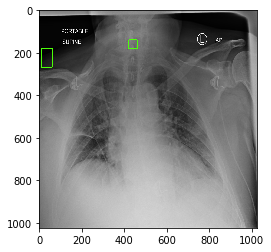

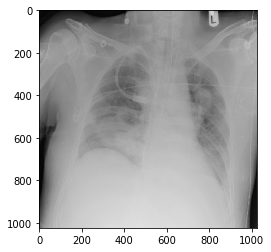

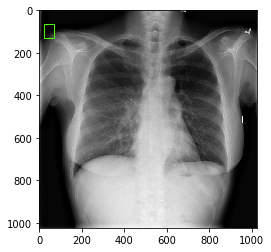

In [243]:
def visualize(test_image_fps): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize(test_image_fps)
visualize(test_image_fps)
visualize(test_image_fps)

In [241]:
results

[{'rois': array([[458, 680, 685, 793]], dtype=int32),
  'class_ids': array([1], dtype=int32),
  'scores': array([0.82747436], dtype=float32),
  'masks': array([[[False],
          [False],
          [False],
          ...,
          [False],
          [False],
          [False]],
  
         [[False],
          [False],
          [False],
          ...,
          [False],
          [False],
          [False]],
  
         [[False],
          [False],
          [False],
          ...,
          [False],
          [False],
          [False]],
  
         ...,
  
         [[False],
          [False],
          [False],
          ...,
          [False],
          [False],
          [False]],
  
         [[False],
          [False],
          [False],
          ...,
          [False],
          [False],
          [False]],
  
         [[False],
          [False],
          [False],
          ...,
          [False],
          [False],
          [False]]])}]